## Start

In [1]:
import sys
print(sys.executable)


/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/.venv/bin/python


In [2]:
import nba_api
print("nba_api ok")




nba_api ok


# Data Ingestion for 2023-2024 season

## Injesting teams & players

In [3]:
import pandas as pd
from nba_api.stats.static import teams, players

teams_df = pd.DataFrame(teams.get_teams()).rename(columns={
    "id": "team_id",
    "full_name": "team_name",
    "abbreviation": "team_abbr"
})[["team_id", "team_name", "team_abbr"]]

players_df = pd.DataFrame(players.get_players()).rename(columns={
    "id": "player_id",
    "full_name": "player_name"
})[["player_id", "player_name"]]

teams_df.head(), players_df.head(), (len(teams_df), len(players_df))



(      team_id             team_name team_abbr
 0  1610612737         Atlanta Hawks       ATL
 1  1610612738        Boston Celtics       BOS
 2  1610612739   Cleveland Cavaliers       CLE
 3  1610612740  New Orleans Pelicans       NOP
 4  1610612741         Chicago Bulls       CHI,
    player_id          player_name
 0      76001       Alaa Abdelnaby
 1      76002      Zaid Abdul-Aziz
 2      76003  Kareem Abdul-Jabbar
 3         51   Mahmoud Abdul-Rauf
 4       1505    Tariq Abdul-Wahad,
 (30, 5103))

In [4]:
# save them to disk in my project under data/raw/
import os
os.makedirs("data/raw", exist_ok=True)

teams_df.to_csv("data/raw/teams.csv", index=False)
players_df.to_csv("data/raw/players.csv", index=False)

print("wrote:", "data/raw/teams.csv", "and", "data/raw/players.csv")


wrote: data/raw/teams.csv and data/raw/players.csv


In [5]:
# confirm that the files exist
import os
os.listdir("data/raw")[:10]


['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Ingesting Games + box score (currently only season 2023-2024)

In [6]:
# we will use only one season for now, 2023-2024 to see if the injection works well.

In [7]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamelog

season = "2023-24"

lg = leaguegamelog.LeagueGameLog(season=season, season_type_all_star="Regular Season")
team_games_raw = lg.get_data_frames()[0]

team_games_raw.columns, team_games_raw.head(3), team_games_raw.shape


(Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
        'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
        'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
        'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
       dtype='object'),
   SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME     GAME_ID  \
 0     22023  1610612743               DEN         Denver Nuggets  0022300061   
 1     22023  1610612744               GSW  Golden State Warriors  0022300062   
 2     22023  1610612747               LAL     Los Angeles Lakers  0022300061   
 
     GAME_DATE      MATCHUP WL  MIN  FGM  ...  DREB  REB  AST  STL  BLK  TOV  \
 0  2023-10-24  DEN vs. LAL  W  240   48  ...    33   42   29    9    6   12   
 1  2023-10-24  GSW vs. PHX  L  240   36  ...    31   49   19   11    6   11   
 2  2023-10-24    LAL @ DEN  L  240   41  ...    31   44   23    5    4   12   
 
    PF  PTS  PLUS

In [8]:
# transform it into our canonical columns and add opponent_team_id + home_away

In [9]:
import pandas as pd

season = "2023-24"
league = "NBA"

df = team_games_raw.copy()

df = df.rename(columns={
    "SEASON_ID": "season_id_raw",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "MATCHUP": "matchup",
    "WL": "wl",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FG3_PCT": "fg3_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "VIDEO_AVAILABLE": "video_available",
})

df["league"] = league
df["season"] = season
df["game_date"] = pd.to_datetime(df["game_date"])

df["home_away"] = df["matchup"].apply(lambda s: "H" if "vs." in s else "A")
df["opp_abbr"] = df["matchup"].str.split().str[-1]

abbr_to_id = dict(zip(teams_df["team_abbr"], teams_df["team_id"]))
df["opponent_team_id"] = df["opp_abbr"].map(abbr_to_id)

team_game_fact = df[[
    "league","season","season_id_raw",
    "game_id","game_date",
    "team_id","team_abbr","team_name",
    "opponent_team_id","home_away","matchup","wl",
    "pts","minutes",
    "fgm","fga","fg_pct",
    "fg3m","fg3a","fg3_pct",
    "ftm","fta","ft_pct",
    "oreb","dreb","reb",
    "ast","tov","stl","blk","pf",
    "plus_minus",
    "video_available"
]].copy()

team_game_fact.head(), team_game_fact["opponent_team_id"].isna().sum()


(  league   season season_id_raw     game_id  game_date     team_id team_abbr  \
 0    NBA  2023-24         22023  0022300061 2023-10-24  1610612743       DEN   
 1    NBA  2023-24         22023  0022300062 2023-10-24  1610612744       GSW   
 2    NBA  2023-24         22023  0022300061 2023-10-24  1610612747       LAL   
 3    NBA  2023-24         22023  0022300062 2023-10-24  1610612756       PHX   
 4    NBA  2023-24         22023  0022300071 2023-10-25  1610612740       NOP   
 
                team_name  opponent_team_id home_away  ... oreb dreb  reb  ast  \
 0         Denver Nuggets        1610612747         H  ...    9   33   42   29   
 1  Golden State Warriors        1610612756         H  ...   18   31   49   19   
 2     Los Angeles Lakers        1610612743         A  ...   13   31   44   23   
 3           Phoenix Suns        1610612744         A  ...   17   43   60   23   
 4   New Orleans Pelicans        1610612763         A  ...   11   41   52   22   
 
    tov  stl  blk 

In [10]:
# saving team_game_fact to disk
team_game_fact.to_csv("data/raw/team_game_fact_2023_24_regular.csv", index=False)


In [11]:
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Injesting player game logs for 2023-24 regular season

In [12]:
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd

season = "2023-24"

lg_players = leaguegamelog.LeagueGameLog(
    season=season,
    season_type_all_star="Regular Season",
    player_or_team_abbreviation="P"
)
player_games_raw = lg_players.get_data_frames()[0]

player_games_raw.columns, player_games_raw.head(3), player_games_raw.shape


(Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
        'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM',
        'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
        'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
        'PLUS_MINUS', 'FANTASY_PTS', 'VIDEO_AVAILABLE'],
       dtype='object'),
   SEASON_ID  PLAYER_ID     PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
 0     22023     202704  Reggie Jackson  1610612743               DEN   
 1     22023     203932    Aaron Gordon  1610612743               DEN   
 2     22023     203999    Nikola Jokić  1610612743               DEN   
 
         TEAM_NAME     GAME_ID   GAME_DATE      MATCHUP WL  ...  REB  AST  STL  \
 0  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...    3    1    1   
 1  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...    7    5    2   
 2  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...   13   11 

In [13]:
import pandas as pd

season = "2023-24"
league = "NBA"

df = player_games_raw.copy()

df = df.rename(columns={
    "SEASON_ID": "season_id_raw",
    "PLAYER_ID": "player_id",
    "PLAYER_NAME": "player_name",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "MATCHUP": "matchup",
    "WL": "wl",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FG3_PCT": "fg3_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "FANTASY_PTS": "fantasy_pts",
    "VIDEO_AVAILABLE": "video_available",
})

df["league"] = league
df["season"] = season
df["game_date"] = pd.to_datetime(df["game_date"])

df["home_away"] = df["matchup"].apply(lambda s: "H" if "vs." in s else "A")
df["opp_abbr"] = df["matchup"].str.split().str[-1]

abbr_to_id = dict(zip(teams_df["team_abbr"], teams_df["team_id"]))
df["opponent_team_id"] = df["opp_abbr"].map(abbr_to_id)

# Position not in this endpoint; we’ll join later from roster/season info.
df["position"] = None

player_game_fact = df[[
    "league","season","season_id_raw",
    "game_id","game_date",
    "player_id","player_name",
    "team_id","team_abbr","team_name",
    "opponent_team_id","home_away","matchup","wl",
    "position",
    "pts","minutes",
    "fgm","fga","fg_pct",
    "fg3m","fg3a","fg3_pct",
    "ftm","fta","ft_pct",
    "oreb","dreb","reb",
    "ast","tov","stl","blk","pf",
    "plus_minus","fantasy_pts",
    "video_available"
]].copy()

player_game_fact.head(), player_game_fact["opponent_team_id"].isna().sum()


(  league   season season_id_raw     game_id  game_date  player_id  \
 0    NBA  2023-24         22023  0022300061 2023-10-24     202704   
 1    NBA  2023-24         22023  0022300061 2023-10-24     203932   
 2    NBA  2023-24         22023  0022300061 2023-10-24     203999   
 3    NBA  2023-24         22023  0022300061 2023-10-24    1629008   
 4    NBA  2023-24         22023  0022300061 2023-10-24    1629618   
 
           player_name     team_id team_abbr       team_name  ...  dreb reb  \
 0      Reggie Jackson  1610612743       DEN  Denver Nuggets  ...     3   3   
 1        Aaron Gordon  1610612743       DEN  Denver Nuggets  ...     5   7   
 2        Nikola Jokić  1610612743       DEN  Denver Nuggets  ...    10  13   
 3  Michael Porter Jr.  1610612743       DEN  Denver Nuggets  ...    10  12   
 4       Jalen Pickett  1610612743       DEN  Denver Nuggets  ...     0   0   
 
   ast tov stl  blk  pf  plus_minus  fantasy_pts  video_available  
 0   1   2   1    0   0          1

In [14]:
player_game_fact.to_csv("data/raw/player_game_fact_2023_24_regular.csv", index=False)


In [15]:
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Injesting Play-by-Play stats

What we’ll use:
- nba_api.stats.endpoints.playbyplayv3 (newer, structured). If it fails, we fall back to playbyplay.

In [16]:
# grabbing a sample game
sample_game_id = team_game_fact["game_id"].iloc[0]
sample_game_id


'0022300061'

### Single-game smoke pull first, then generalize

In [17]:
from nba_api.stats.endpoints import playbyplayv3
import pandas as pd

game_id = "0022300061"

pbp = playbyplayv3.PlayByPlayV3(game_id=game_id)
pbp_raw = pbp.get_data_frames()[0]

pbp_raw.columns, pbp_raw.head(5), pbp_raw.shape


(Index(['gameId', 'actionNumber', 'clock', 'period', 'teamId', 'teamTricode',
        'personId', 'playerName', 'playerNameI', 'xLegacy', 'yLegacy',
        'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway',
        'pointsTotal', 'location', 'description', 'actionType', 'subType',
        'videoAvailable', 'shotValue', 'actionId'],
       dtype='object'),
        gameId  actionNumber        clock  period      teamId teamTricode  \
 0  0022300061             2  PT12M00.00S       1           0               
 1  0022300061             4  PT12M00.00S       1  1610612743         DEN   
 2  0022300061             7  PT11M42.00S       1  1610612747         LAL   
 3  0022300061            10  PT11M15.00S       1  1610612743         DEN   
 4  0022300061            11  PT10M57.00S       1  1610612747         LAL   
 
    personId playerName playerNameI  xLegacy  ...  scoreHome  scoreAway  \
 0         0                               0  ...          0          0   
 1    2

In [18]:
# we now create pbp_event for that game

In [19]:
import pandas as pd

league = "NBA"
season = "2023-24"
game_id = "0022300061"

df = pbp_raw.copy()

pbp_event = pd.DataFrame({
    "league": league,
    "season": season,
    "game_id": df["gameId"].astype(str),
    "event_id": df["actionNumber"].astype(int),
    "period": df["period"].astype(int),
    "clock": df["clock"],                      # keep raw clock string for now
    "team_id": df["teamId"],                   # nullable
    "player_id": df["personId"],               # nullable
    "player_name": df["playerName"],           # display/debug
    "event_type": df["actionType"],
    "event_subtype": df["subType"],
    "points": df["shotValue"].fillna(0).astype(int),
    "description": df["description"],
    "score_home": df["scoreHome"],
    "score_away": df["scoreAway"],
})

pbp_event.head(10), pbp_event.shape


(  league   season     game_id  event_id  period        clock     team_id  \
 0    NBA  2023-24  0022300061         2       1  PT12M00.00S           0   
 1    NBA  2023-24  0022300061         4       1  PT12M00.00S  1610612743   
 2    NBA  2023-24  0022300061         7       1  PT11M42.00S  1610612747   
 3    NBA  2023-24  0022300061        10       1  PT11M15.00S  1610612743   
 4    NBA  2023-24  0022300061        11       1  PT10M57.00S  1610612747   
 5    NBA  2023-24  0022300061        13       1  PT10M40.00S  1610612743   
 6    NBA  2023-24  0022300061        14       1  PT10M33.00S  1610612747   
 7    NBA  2023-24  0022300061        16       1  PT10M16.00S  1610612743   
 8    NBA  2023-24  0022300061        18       1  PT10M03.00S  1610612747   
 9    NBA  2023-24  0022300061        19       1  PT10M01.00S  1610612747   
 
    player_id player_name   event_type                   event_subtype  points  \
 0          0                   period                           star

In [20]:
pbp_event.to_csv("data/raw/pbp_event_sample_0022300061.csv", index=False)


In [21]:
# confirm that the files exist
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

### We now proceed with creating the pbp_event file for the whole 2023-2024 season

In [23]:
import time
import random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import playbyplayv3

season = "2023-24"
league = "NBA"

PROJECT_ROOT = Path.cwd().parent
out_dir = PROJECT_ROOT / "data" / "raw" / "pbp" / f"season={season}"
out_dir.mkdir(parents=True, exist_ok=True)

game_ids = team_game_fact["game_id"].astype(str).drop_duplicates().tolist()
print("games to fetch:", len(game_ids))
print("output dir:", out_dir)

def fetch_one_game(game_id: str) -> pd.DataFrame:
    pbp = playbyplayv3.PlayByPlayV3(game_id=game_id, timeout=20)
    df = pbp.get_data_frames()[0]
    df.insert(0, "league", league)
    df.insert(1, "season", season)
    return df

failed = []
skipped = 0
saved = 0

for i, gid in enumerate(game_ids, start=1):
    out_path = out_dir / f"game_id={gid}.csv"
    if out_path.exists():
        skipped += 1
        continue

    ok = False
    for attempt in range(1, 6):
        try:
            df = fetch_one_game(gid)
            df.to_csv(out_path, index=False)
            saved += 1
            ok = True
            break
        except Exception:
            time.sleep(min(30, 2 ** attempt) + random.uniform(0.1, 0.7))

    if not ok:
        failed.append(gid)

    time.sleep(0.25 + random.uniform(0.05, 0.2))

    if i % 25 == 0:
        print(f"progress: {i}/{len(game_ids)} | saved={saved} skipped={skipped} failed={len(failed)}")

if failed:
    pd.DataFrame({"game_id": failed}).to_csv(out_dir / "_failed_game_ids.csv", index=False)

print("done:", {"saved": saved, "skipped": skipped, "failed": len(failed), "out_dir": str(out_dir)})


games to fetch: 1230
output dir: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/pbp/season=2023-24
progress: 600/1230 | saved=1 skipped=599 failed=0
progress: 725/1230 | saved=6 skipped=719 failed=0
progress: 750/1230 | saved=31 skipped=719 failed=0
progress: 775/1230 | saved=56 skipped=719 failed=0
progress: 800/1230 | saved=81 skipped=719 failed=0
progress: 825/1230 | saved=106 skipped=719 failed=0
progress: 850/1230 | saved=131 skipped=719 failed=0
progress: 875/1230 | saved=156 skipped=719 failed=0
progress: 900/1230 | saved=181 skipped=719 failed=0
progress: 925/1230 | saved=206 skipped=719 failed=0
progress: 950/1230 | saved=231 skipped=719 failed=0
progress: 975/1230 | saved=256 skipped=719 failed=0
progress: 1000/1230 | saved=281 skipped=719 failed=0
progress: 1025/1230 | saved=306 skipped=719 failed=0
progress: 1050/1230 | saved=331 skipped=719 failed=0
progress: 1075/1230 | saved=356 skipped=719 failed=0
progress: 1100/1230 | saved=381 skipp

In [24]:
# building the canonical pbp_event_2023_24 by reading those per-game raw CSVs and mapping columns.

In [25]:
import pandas as pd
from pathlib import Path
import glob

season = "2023-24"
league = "NBA"

PROJECT_ROOT = Path.cwd().parent
in_dir = PROJECT_ROOT / "data" / "raw" / "pbp" / f"season={season}"
out_path = PROJECT_ROOT / "data" / "processed" / f"pbp_event_{season}_regular.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)

files = sorted(glob.glob(str(in_dir / "game_id=*.csv")))
print("files:", len(files))

chunks = []
for f in files:
    df = pd.read_csv(f)
    chunks.append(pd.DataFrame({
        "league": df["league"],
        "season": df["season"],
        "game_id": df["gameId"].astype(str),
        "event_id": df["actionNumber"].astype(int),
        "period": df["period"].astype(int),
        "clock": df["clock"],
        "team_id": df["teamId"],
        "player_id": df["personId"],
        "event_type": df["actionType"],
        "event_subtype": df["subType"],
        "description": df["description"],
        "score_home": df["scoreHome"],
        "score_away": df["scoreAway"],
    }))

pbp_event = pd.concat(chunks, ignore_index=True)
pbp_event.to_csv(out_path, index=False)

pbp_event.shape, out_path


files: 1230


((598705, 13),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/pbp_event_2023-24_regular.csv'))

## Shot charts & Dimension building

### Dimensions: Shot diet & shooting efficiency

#### Single-player smoke test using ShotChartDetail

In [27]:
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd

season = "2023-24"

# Smoke test: Nikola Jokic, Denver
player_id = 203999
team_id = 1610612743

sc = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=player_id,
    season_nullable=season,
    season_type_all_star="Regular Season",
    context_measure_simple="FGA"
)

shots_raw = sc.get_data_frames()[0]

shots_raw.shape, shots_raw.columns.tolist()[:25], shots_raw.head(3)


((1411, 24),
 ['GRID_TYPE',
  'GAME_ID',
  'GAME_EVENT_ID',
  'PLAYER_ID',
  'PLAYER_NAME',
  'TEAM_ID',
  'TEAM_NAME',
  'PERIOD',
  'MINUTES_REMAINING',
  'SECONDS_REMAINING',
  'EVENT_TYPE',
  'ACTION_TYPE',
  'SHOT_TYPE',
  'SHOT_ZONE_BASIC',
  'SHOT_ZONE_AREA',
  'SHOT_ZONE_RANGE',
  'SHOT_DISTANCE',
  'LOC_X',
  'LOC_Y',
  'SHOT_ATTEMPTED_FLAG',
  'SHOT_MADE_FLAG',
  'GAME_DATE',
  'HTM',
  'VTM'],
            GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
 0  Shot Chart Detail  0022300006             14     203999  Nikola Jokić   
 1  Shot Chart Detail  0022300006             29     203999  Nikola Jokić   
 2  Shot Chart Detail  0022300006             66     203999  Nikola Jokić   
 
       TEAM_ID       TEAM_NAME  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
 0  1610612743  Denver Nuggets       1                 10                 55   
 1  1610612743  Denver Nuggets       1                  9                  7   
 2  1610612743  Denver Nuggets       1    

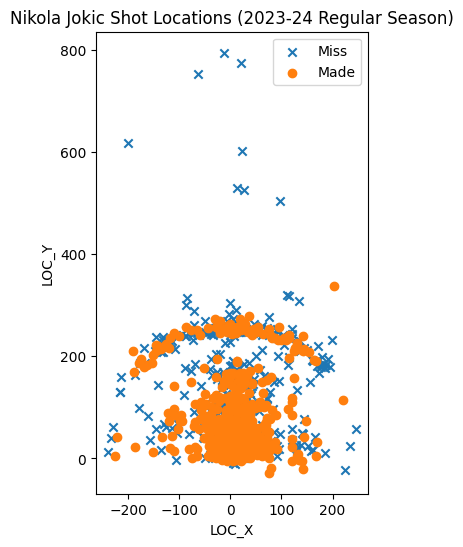

In [28]:
# let's build a visualization for fun
import matplotlib.pyplot as plt

df = shots_raw.copy()
made = df[df["SHOT_MADE_FLAG"] == 1]
miss = df[df["SHOT_MADE_FLAG"] == 0]

plt.figure(figsize=(7,6))
plt.scatter(miss["LOC_X"], miss["LOC_Y"], marker="x", label="Miss")
plt.scatter(made["LOC_X"], made["LOC_Y"], marker="o", label="Made")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
plt.title("Nikola Jokic Shot Locations (2023-24 Regular Season)")
plt.legend()
plt.show()


In [32]:
# Defining functions for drawing basketball half-court and plotting shots on that court

In [29]:
# plotting by layering the court
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

def draw_half_court(ax=None, color="black", lw=1):
    if ax is None:
        ax = plt.gca()

    # NBA hoop is at (0, 0) in nba_api LOC coords
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, edgecolor=color, facecolor="none")
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, edgecolor=color, facecolor="none")

    # Paint (lane)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, edgecolor=color, facecolor="none")
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, edgecolor=color, facecolor="none")

    # Free throw arcs
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, edgecolor=color)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, edgecolor=color, linestyle="dashed")

    # Restricted area arc
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, edgecolor=color)

    # Three point line (approx in this coord system)
    corner_left = Rectangle((-220, -47.5), 0, 140, linewidth=lw, edgecolor=color, facecolor="none")
    corner_right = Rectangle((220, -47.5), 0, 140, linewidth=lw, edgecolor=color, facecolor="none")
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, edgecolor=color)

    # Center court (not visible in half-court usually, skip)

    for item in [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                 restricted, corner_left, corner_right, three_arc]:
        ax.add_patch(item)

    return ax

def plot_shots_with_court(shots_df, title="Shot Chart"):
    made = shots_df[shots_df["SHOT_MADE_FLAG"] == 1]
    miss = shots_df[shots_df["SHOT_MADE_FLAG"] == 0]

    fig, ax = plt.subplots(figsize=(7,6))
    draw_half_court(ax=ax, lw=1)

    ax.scatter(miss["LOC_X"], miss["LOC_Y"], marker="x", label="Miss")
    ax.scatter(made["LOC_X"], made["LOC_Y"], marker="o", label="Made")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-250, 250)
    ax.set_ylim(-60, 470)
    ax.set_xlabel("LOC_X")
    ax.set_ylabel("LOC_Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

# Example:
# plot_shots_with_court(shots_raw, "Nikola Jokic Shot Chart (2023-24)")


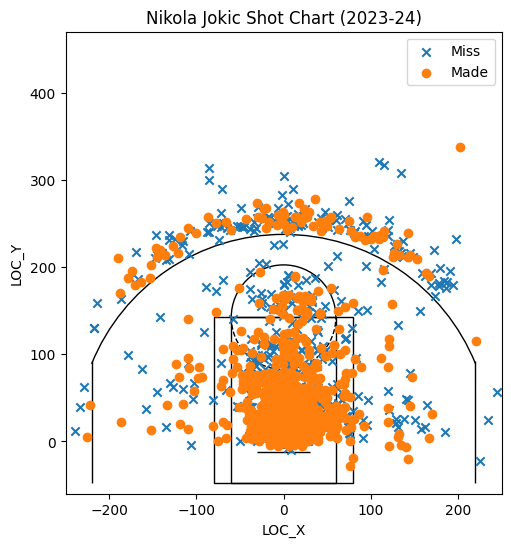

In [31]:
%matplotlib inline
plot_shots_with_court(shots_raw, "Nikola Jokic Shot Chart (2023-24)")


#### Build season-level shot_event for 2023-24.

- Getting the list of active players in 2023-24 from your player_game_fact_2023_24_regular.csv (unique player_id).

- For each player_id, calling ShotChartDetail with team_id=0 (all teams) and save one CSV per player under data/raw/shots/season=2023-24/.

- Concatenating later into one shot_event_2023_24.csv.

In [33]:
import time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import shotchartdetail

season = "2023-24"
league = "NBA"

# project root (assumes notebook is in /notebooks)
PROJECT_ROOT = Path.cwd().parent
out_dir = PROJECT_ROOT / "data" / "raw" / "shots" / f"season={season}"
out_dir.mkdir(parents=True, exist_ok=True)

# Get player_ids for this season from your saved player_game_fact
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
player_game_fact = pd.read_csv(pg_path)

player_ids = sorted(player_game_fact["player_id"].dropna().astype(int).unique().tolist())
print("players to fetch:", len(player_ids))
print("output dir:", out_dir)

def fetch_player_shots(pid: int) -> pd.DataFrame:
    sc = shotchartdetail.ShotChartDetail(
        team_id=0,                       # all teams (handles trades)
        player_id=pid,
        season_nullable=season,
        season_type_all_star="Regular Season",
        context_measure_simple="FGA",
        timeout=20
    )
    df = sc.get_data_frames()[0]
    df.insert(0, "league", league)
    df.insert(1, "season", season)
    return df

failed = []
skipped = 0
saved = 0

for i, pid in enumerate(player_ids, start=1):
    out_path = out_dir / f"player_id={pid}.csv"
    if out_path.exists():
        skipped += 1
        continue

    ok = False
    for attempt in range(1, 6):
        try:
            df = fetch_player_shots(pid)
            df.to_csv(out_path, index=False)
            saved += 1
            ok = True
            break
        except Exception:
            time.sleep(min(30, 2 ** attempt) + random.uniform(0.1, 0.7))

    if not ok:
        failed.append(pid)

    time.sleep(0.25 + random.uniform(0.05, 0.25))

    if i % 50 == 0:
        print(f"progress: {i}/{len(player_ids)} | saved={saved} skipped={skipped} failed={len(failed)}")

if failed:
    pd.DataFrame({"player_id": failed}).to_csv(out_dir / "_failed_player_ids.csv", index=False)

print("done:", {"saved": saved, "skipped": skipped, "failed": len(failed), "out_dir": str(out_dir)})


players to fetch: 572
output dir: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/shots/season=2023-24
progress: 50/572 | saved=50 skipped=0 failed=0
progress: 100/572 | saved=100 skipped=0 failed=0
progress: 150/572 | saved=150 skipped=0 failed=0
progress: 200/572 | saved=200 skipped=0 failed=0
progress: 250/572 | saved=250 skipped=0 failed=0
progress: 300/572 | saved=300 skipped=0 failed=0
progress: 350/572 | saved=350 skipped=0 failed=0
progress: 400/572 | saved=400 skipped=0 failed=0
progress: 450/572 | saved=450 skipped=0 failed=0
progress: 500/572 | saved=500 skipped=0 failed=0
progress: 550/572 | saved=550 skipped=0 failed=0
done: {'saved': 572, 'skipped': 0, 'failed': 0, 'out_dir': '/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/shots/season=2023-24'}


In [36]:
# merging those per-player files into one canonical shot_event table and save to data/processed/

In [37]:
import pandas as pd
from pathlib import Path
import glob

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_dir = PROJECT_ROOT / "data" / "raw" / "shots" / f"season={season}"
files = sorted(glob.glob(str(in_dir / "player_id=*.csv")))
print("files:", len(files))

chunks = []
for f in files:
    df = pd.read_csv(f)
    chunks.append(pd.DataFrame({
        "league": df["league"],
        "season": df["season"],
        "game_id": df["GAME_ID"].astype(str),
        "event_id": df["GAME_EVENT_ID"].astype(int),
        "game_date": pd.to_datetime(df["GAME_DATE"]),
        "team_id": df["TEAM_ID"],
        "player_id": df["PLAYER_ID"],
        "period": df["PERIOD"],
        "minutes_remaining": df["MINUTES_REMAINING"],
        "seconds_remaining": df["SECONDS_REMAINING"],
        "shot_type": df["SHOT_TYPE"],
        "action_type": df["ACTION_TYPE"],
        "shot_zone_basic": df["SHOT_ZONE_BASIC"],
        "shot_zone_area": df["SHOT_ZONE_AREA"],
        "shot_zone_range": df["SHOT_ZONE_RANGE"],
        "shot_distance": df["SHOT_DISTANCE"],
        "loc_x": df["LOC_X"],
        "loc_y": df["LOC_Y"],
        "shot_attempted": df["SHOT_ATTEMPTED_FLAG"],
        "shot_made": df["SHOT_MADE_FLAG"],
        "htm": df["HTM"],
        "vtm": df["VTM"],
    }))

shot_event = pd.concat(chunks, ignore_index=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
shot_event.to_csv(out_path, index=False)

shot_event.shape, out_path


files: 572


((218700, 22),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/shot_event_2023-24_regular.csv'))

#### Creating player_shot_profile_season_2023-24.csv

In [38]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

shot_event = pd.read_csv(shot_path)

# Flags using NBA zone labels
shot_event["is_three"]   = shot_event["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shot_event["is_corner3"] = shot_event["shot_zone_basic"].eq("Corner 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

# Aggregate counts (no fancy lambdas; do it with filtered groupbys)
keys = ["league", "season", "player_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

# Fill missing zone counts with 0
for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

# Rates
df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

# FG% splits
df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

player_shot_profile_season = df

out_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}.csv"
player_shot_profile_season.to_csv(out_path, index=False)

player_shot_profile_season.shape, out_path


((568, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_shot_profile_season_2023-24.csv'))

#### Computing team_shot_profile_season

In [41]:
# from the same shot_event (group by team_id instead of player_id

In [42]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

shot_event = pd.read_csv(shot_path)

shot_event["is_three"]   = shot_event["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shot_event["is_corner3"] = shot_event["shot_zone_basic"].eq("Corner 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

keys = ["league", "season", "team_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

team_shot_profile_season = df

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
team_shot_profile_season.to_csv(out_path, index=False)

team_shot_profile_season.shape, out_path


((30, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24.csv'))

#### Converting shot profiles into percentiles

In [43]:
# first players, position agnostic for now

In [44]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks

in_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((568, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_shot_profile_season_2023-24_pctiles.csv'))

In [45]:
# now for the team_shot_profile_season

In [46]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24_pctiles.csv'))

#### Computing TS% and eFG% per player-season (2023-24)

In [47]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league", "season", "player_id"]

player_box_season = pg.groupby(keys, as_index=False).agg(
    pts=("pts", "sum"),
    fga=("fga", "sum"),
    fgm=("fgm", "sum"),
    fg3m=("fg3m", "sum"),
    fta=("fta", "sum"),
    ftm=("ftm", "sum"),
    minutes=("minutes", "sum"),
    games=("game_id", "nunique"),
)

# Advanced efficiency
den_ts = 2 * (player_box_season["fga"] + 0.44 * player_box_season["fta"])
player_box_season["ts_pct"] = player_box_season["pts"] / den_ts.replace({0: pd.NA})

player_box_season["efg_pct"] = (
    (player_box_season["fgm"] + 0.5 * player_box_season["fg3m"])
    / player_box_season["fga"].replace({0: pd.NA})
)

# Percentiles (league-wide for now; later we'll redo within position)
player_box_season["ts_pct_pctile"] = player_box_season["ts_pct"].rank(pct=True)
player_box_season["efg_pct_pctile"] = player_box_season["efg_pct"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_box_season_{season}_adv_eff.csv"
player_box_season.to_csv(out_path, index=False)

player_box_season.shape, out_path


((572, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_box_season_2023-24_adv_eff.csv'))

#### Computing team TS% and eFG% per season (2023-24)

In [48]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / "team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

keys = ["league", "season", "team_id"]

team_box_season = tg.groupby(keys, as_index=False).agg(
    pts=("pts", "sum"),
    fga=("fga", "sum"),
    fgm=("fgm", "sum"),
    fg3m=("fg3m", "sum"),
    fta=("fta", "sum"),
    ftm=("ftm", "sum"),
    minutes=("minutes", "sum"),
    games=("game_id", "nunique"),
)

den_ts = 2 * (team_box_season["fga"] + 0.44 * team_box_season["fta"])
team_box_season["ts_pct"] = team_box_season["pts"] / den_ts.replace({0: pd.NA})

team_box_season["efg_pct"] = (
    (team_box_season["fgm"] + 0.5 * team_box_season["fg3m"])
    / team_box_season["fga"].replace({0: pd.NA})
)

team_box_season["ts_pct_pctile"] = team_box_season["ts_pct"].rank(pct=True)
team_box_season["efg_pct_pctile"] = team_box_season["efg_pct"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"
team_box_season.to_csv(out_path, index=False)

team_box_season.shape, out_path


((30, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_box_season_2023-24_adv_eff.csv'))

In [50]:
# merge these advanced efficiency metrics into my existing shot profile tables (players + teams) 
# so the UI can show them and we can use them in shooting_eff_score

In [51]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"player_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

# Keep only the advanced metrics columns from adv
adv_keep = adv[["league","season","player_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((568, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_profile_shooting_2023-24.csv'))

In [52]:
# doing the same for teams

In [53]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

adv_keep = adv[["league","season","team_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24.csv'))

#### Calculating Shooting Efficiency Dimension

In [54]:
# players
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df[["player_id","ts_pct_pctile","efg_pct_pctile","shooting_eff_score"]].head(), df.shape, out_path


(   player_id  ts_pct_pctile  efg_pct_pctile  shooting_eff_score
 0       2544       0.869718        0.848592           85.915493
 1     101108       0.369718        0.440141           40.492958
 2     200768       0.688380        0.667254           67.781690
 3     200782       0.214789        0.254401           23.459507
 4     201142       0.855634        0.776408           81.602113,
 (568, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_profile_shooting_2023-24_scored.csv'))

In [55]:
# teams
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df[["team_id","ts_pct_pctile","efg_pct_pctile","shooting_eff_score"]].head(), df.shape, out_path


(      team_id  ts_pct_pctile  efg_pct_pctile  shooting_eff_score
 0  1610612737       0.433333        0.466667           45.000000
 1  1610612738       1.000000        0.966667           98.333333
 2  1610612739       0.600000        0.600000           60.000000
 3  1610612740       0.700000        0.666667           68.333333
 4  1610612741       0.333333        0.300000           31.666667,
 (30, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24_scored.csv'))

#### Creating a player_card_shooting_2023-24.csv

In [56]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# scored table already includes shot rates + pctiles + TS/eFG + shooting_eff_score
path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}_scored.csv"
df = pd.read_csv(path)

card = df[[
    "league","season","player_id",

    # shot diet (rates)
    "rim_rate","mid_rate","three_rate","corner3_rate","corner3_share_of_3",

    # shot diet (percentiles)
    "rim_rate_pctile","mid_rate_pctile","three_rate_pctile","corner3_rate_pctile","corner3_share_of_3_pctile",

    # scoring efficiency
    "ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile","shooting_eff_score",
]].copy()

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}.csv"
card.to_csv(out_path, index=False)

card.shape, out_path


((568, 18),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_shooting_2023-24.csv'))

In [57]:
# adding player names and team names and abbreviations
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}.csv"
pg_path   = PROJECT_ROOT / "data" / "raw" / f"player_game_fact_2023_24_regular.csv"

card = pd.read_csv(card_path)
pg   = pd.read_csv(pg_path)

pg["game_date"] = pd.to_datetime(pg["game_date"])

# latest team per player in this season (regular season)
latest = (pg.sort_values(["player_id","game_date"])
            .groupby("player_id", as_index=False)
            .tail(1)[["player_id","player_name","team_id","team_abbr"]])

card2 = card.merge(latest, on="player_id", how="left")

# reorder for UI friendliness
cols = ["league","season","player_id","player_name","team_id","team_abbr"] + [c for c in card.columns if c not in ["league","season","player_id"]]
card2 = card2[cols]

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}_named.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 21),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_shooting_2023-24_named.csv'))

### Dimension: Pace & Transition bias

#### Calculating Team Pace

In [58]:
# compute team possessions and pace proxies from game logs
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

# Possessions proxy (classic box score estimate)
# poss = FGA + 0.44*FTA - OREB + TOV
tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

team_pace = tg.groupby(["league","season","team_id"], as_index=False).agg(
    games=("game_id", "nunique"),
    minutes=("minutes", "sum"),
    poss_est=("poss_est", "sum"),
    pts=("pts", "sum"),
)

# Pace per 48 minutes: possessions per 48
team_pace["pace_per48"] = team_pace["poss_est"] / team_pace["minutes"] * 48

# Percentile (league-wide)
team_pace["pace_per48_pctile"] = team_pace["pace_per48"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
team_pace.to_csv(out_path, index=False)

team_pace.shape, out_path


((30, 9),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_pace_season_2023-24.csv'))

#### Building team_default_profile_2023-24.csv

In [59]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pace_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
shoot_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"

pace = pd.read_csv(pace_path)
shoot = pd.read_csv(shoot_path)

team_default = shoot.merge(
    pace[["league","season","team_id","pace_per48","pace_per48_pctile"]],
    on=["league","season","team_id"],
    how="left"
)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}.csv"
team_default.to_csv(out_path, index=False)

team_default.shape, out_path


((30, 40),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24.csv'))

#### Building a Player Pace Proxy for adjusted metrics

In [60]:
# add a simple pace context to each player card
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}_named.csv"
pace_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"

card = pd.read_csv(card_path)
team_pace = pd.read_csv(pace_path)[["team_id","pace_per48","pace_per48_pctile"]]

card2 = card.merge(team_pace, on="team_id", how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_named_with_teampace.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path

# add a simple pace context to each player card

((568, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_named_with_teampace.csv'))

### Dimension: Ball-movement vs. Self-creation

What we’ll build

- player_creation_season_2023-24.csv: player-level proxies (how much they create shots vs finish plays)

- team_ball_movement_season_2023-24.csv: team-level proxies for default sliders

Key proxies (simple, defensible):

- AST per 100 possessions: passing/creation
- PlayerPossUsed = FGA + 0.44*FTA + TOV
- TeamPossUsed = TeamFGA + 0.44*TeamFTA + TeamTOV
- TeamMinutes = total team minutes in games (usually games * 240 for regulation; your team_game_fact.minutes already sums this)
- PlayerMinutes = player total minutes

I calculate:

- Possessions used per 100 minutes (workload rate)
- USG% (classic usage approximation)
- Possessions Decided% using:
   - PlayerPossDecided = FGA + 0.44*FTA + TOV + 0.5*AST
   - TeamPossDecided = TeamFGA + 0.44*TeamFTA + TeamTOV + 0.5*TeamAST
- Assists_per_100_possessions
- Turnover_per_100_possessions
- Assist ratio
- Trunover ration
- Posessions used ratio

In [61]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# Inputs
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
tg_path = PROJECT_ROOT / "data" / "raw" / "team_game_fact_2023_24_regular.csv"

pg = pd.read_csv(pg_path)
tg = pd.read_csv(tg_path)

# --- Player season totals ---
pkeys = ["league","season","player_id"]
player = pg.groupby(pkeys, as_index=False).agg(
    games=("game_id", "nunique"),
    minutes=("minutes", "sum"),
    fga=("fga", "sum"),
    fta=("fta", "sum"),
    tov=("tov", "sum"),
    ast=("ast", "sum"),
    team_id_mode=("team_id", lambda s: s.mode().iloc[0] if len(s.mode()) else s.iloc[0]),  # main team
)

player["player_poss_used"] = player["fga"] + 0.44 * player["fta"] + player["tov"]
player["player_poss_decided"] = player["player_poss_used"] + 0.5 * player["ast"]

# Rates
player["poss_used_per100_min"] = 100 * player["player_poss_used"] / player["minutes"].replace({0: pd.NA})
player["ast_per100_poss_used"] = 100 * player["ast"] / player["player_poss_used"].replace({0: pd.NA})
player["tov_per100_poss_used"] = 100 * player["tov"] / player["player_poss_used"].replace({0: pd.NA})

# Simple shares within player possessions used (not official AST%/TOV%, but consistent for your slider logic)
player["assist_pct"] = 100 * player["ast"] / player["player_poss_used"].replace({0: pd.NA})
player["tov_pct"] = 100 * player["tov"] / player["player_poss_used"].replace({0: pd.NA})
player["poss_used_pct"] = 100.0  # placeholder; real "poss_used_% of team" computed after team merge

# --- Team season totals ---
tkeys = ["league","season","team_id"]
team = tg.groupby(tkeys, as_index=False).agg(
    team_minutes=("minutes", "sum"),
    team_fga=("fga", "sum"),
    team_fta=("fta", "sum"),
    team_tov=("tov", "sum"),
    team_ast=("ast", "sum"),
)

team["team_poss_used"] = team["team_fga"] + 0.44 * team["team_fta"] + team["team_tov"]
team["team_poss_decided"] = team["team_poss_used"] + 0.5 * team["team_ast"]

# --- Merge to compute USG% / PossDecided% + poss_used_% of team ---
merged = player.merge(
    team,
    left_on=["league","season","team_id_mode"],
    right_on=["league","season","team_id"],
    how="left"
)

merged["usg_pct"] = 100 * (
    merged["player_poss_used"] * (merged["team_minutes"] / 5)
    / (merged["minutes"] * merged["team_poss_used"]).replace({0: pd.NA})
)

merged["poss_decided_pct"] = 100 * (
    merged["player_poss_decided"] * (merged["team_minutes"] / 5)
    / (merged["minutes"] * merged["team_poss_decided"]).replace({0: pd.NA})
)

# Share of team possessions used (season-level approximation, not on-court)
merged["poss_used_pct"] = 100 * merged["player_poss_used"] / merged["team_poss_used"].replace({0: pd.NA})

# Percentiles (league-wide for now)
pct_metrics = [
    "poss_used_per100_min",
    "ast_per100_poss_used",
    "tov_per100_poss_used",
    "assist_pct",
    "tov_pct",
    "poss_used_pct",
    "usg_pct",
    "poss_decided_pct",
]
for c in pct_metrics:
    merged[f"{c}_pctile"] = merged[c].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_creation_season_{season}_usage.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((572, 36),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv'))

In [62]:
# attaching those metrics into my player cards
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_named_with_teampace.csv"
cre_path  = PROJECT_ROOT / "data" / "processed" / f"player_creation_season_{season}_usage.csv"

card = pd.read_csv(card_path)
cre  = pd.read_csv(cre_path)

cre_keep = cre[[
    "league","season","player_id",
    "ast_per100_poss_used","tov_per100_poss_used",
    "assist_pct","tov_pct",
    "poss_used_per100_min","poss_used_pct",
    "usg_pct","poss_decided_pct",
    "ast_per100_poss_used_pctile","tov_per100_poss_used_pctile",
    "assist_pct_pctile","tov_pct_pctile",
    "poss_used_per100_min_pctile","poss_used_pct_pctile",
    "usg_pct_pctile","poss_decided_pct_pctile"
]].copy()

card2 = card.merge(cre_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v2_shooting_pace_creation.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 39),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v2_shooting_pace_creation.csv'))

What I just made

- Input: player_card_2023-24_named_with_teampace.csv (568 rows)

- Joined: selected creation/usage fields from player_creation_season_2023-24_usage.csv

- Output: data/processed/player_card_2023-24_v2_shooting_pace_creation.csv

- Result: (568, 39) columns (card got wider with creation metrics + percentiles)

In [63]:
# now I build the team version of ball movement/self-creation for default sliders (team AST rate, team usage concentration proxy)

What we’re building

A team-season ball movement table (1 row per team) for slider defaults.

Simple, defensible team proxies:
- ast_per100_poss (ball movement)
- tov_per100_poss (care/security)
- poss_est_per48 (already pace, but we can reuse)

We’ll use the same possessions estimate: FGA + 0.44*FTA - OREB + TOV.

In [64]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

keys = ["league","season","team_id"]
team_bm = tg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    ast=("ast","sum"),
    tov=("tov","sum"),
    poss_est=("poss_est","sum"),
)

team_bm["ast_per100_poss"] = 100 * team_bm["ast"] / team_bm["poss_est"].replace({0: pd.NA})
team_bm["tov_per100_poss"] = 100 * team_bm["tov"] / team_bm["poss_est"].replace({0: pd.NA})

team_bm["ast_per100_poss_pctile"] = team_bm["ast_per100_poss"].rank(pct=True)
team_bm["tov_per100_poss_pctile"] = team_bm["tov_per100_poss"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"
team_bm.to_csv(out_path, index=False)

team_bm.shape, out_path


((30, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_ball_movement_season_2023-24.csv'))

In [65]:
# merging into team default profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}.csv"
bm_path   = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"

base = pd.read_csv(base_path)
bm   = pd.read_csv(bm_path)

bm_keep = bm[[
    "league","season","team_id",
    "ast_per100_poss","tov_per100_poss",
    "ast_per100_poss_pctile","tov_per100_poss_pctile"
]].copy()

merged = base.merge(bm_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v2.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 44),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v2.csv'))

### Dimension: Physicality and extra possessions

Two quick season-level proxies:

- OREB rate (extra possessions): OREB / (OREB + OppDREB) per team-game, then season average
- FT rate (physical pressure): FTA / FGA (or per 100 poss)

We’ll compute team-season first for slider defaults.

In [67]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

# Opponent DREB via self-join on game_id + opponent_team_id
opp = tg[["league","season","game_id","team_id","dreb"]].copy()
opp = opp.rename(columns={"team_id": "opponent_team_id", "dreb": "opp_dreb"})

tg2 = tg.merge(
    opp,
    on=["league","season","game_id","opponent_team_id"],
    how="left"
)

# Season totals + rates
keys = ["league","season","team_id"]
team_phys = tg2.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    oreb=("oreb","sum"),
    opp_dreb=("opp_dreb","sum"),
    fta=("fta","sum"),
    fga=("fga","sum"),
)

team_phys["oreb_rate"] = team_phys["oreb"] / (team_phys["oreb"] + team_phys["opp_dreb"]).replace({0: pd.NA})
team_phys["fta_per_fga"] = team_phys["fta"] / team_phys["fga"].replace({0: pd.NA})

team_phys["oreb_rate_pctile"] = team_phys["oreb_rate"].rank(pct=True)
team_phys["fta_per_fga_pctile"] = team_phys["fta_per_fga"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"
team_phys.to_csv(out_path, index=False)

team_phys.shape, out_path


((30, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_physicality_season_2023-24.csv'))

In [68]:
# merging into the team profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v2.csv"
phys_path = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"

base = pd.read_csv(base_path)
phys = pd.read_csv(phys_path)

phys_keep = phys[[
    "league","season","team_id",
    "oreb_rate","fta_per_fga",
    "oreb_rate_pctile","fta_per_fga_pctile"
]].copy()

merged = base.merge(phys_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v3.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 48),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v3.csv'))

What we just made

- Built: team_physicality_season_2023-24.csv (30, 12)
   - oreb_rate and fta_per_fga + percentiles

- Merged into: team_default_profile_2023-24_v2.csv
- Exported: team_default_profile_2023-24_v3.csv
- Result: (30, 48) (added 4 physicality columns)

In [69]:
# computing player physicality proxies

- OREB rate proxy: oreb_per100_min = 100 * OREB / minutes (simple, works with box score)

- FT pressure: fta_per_fga = FTA / FGA

- Add percentiles, then merge into the player card.

In [70]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / f"player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league","season","player_id"]
player_phys = pg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    oreb=("oreb","sum"),
    fga=("fga","sum"),
    fta=("fta","sum"),
)

player_phys["oreb_per100_min"] = 100 * player_phys["oreb"] / player_phys["minutes"].replace({0: pd.NA})
player_phys["fta_per_fga"] = player_phys["fta"] / player_phys["fga"].replace({0: pd.NA})

player_phys["oreb_per100_min_pctile"] = player_phys["oreb_per100_min"].rank(pct=True)
player_phys["fta_per_fga_pctile"] = player_phys["fta_per_fga"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_physicality_season_{season}.csv"
player_phys.to_csv(out_path, index=False)

player_phys.shape, out_path


((572, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_physicality_season_2023-24.csv'))

In [71]:
# now we merge
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v2_shooting_pace_creation.csv"
phys_path = PROJECT_ROOT / "data" / "processed" / f"player_physicality_season_{season}.csv"

card = pd.read_csv(card_path)
phys = pd.read_csv(phys_path)

phys_keep = phys[[
    "league","season","player_id",
    "oreb_per100_min","fta_per_fga",
    "oreb_per100_min_pctile","fta_per_fga_pctile"
]].copy()

card2 = card.merge(phys_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v3_shooting_pace_creation_physicality.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 43),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v3_shooting_pace_creation_physicality.csv'))

### Dimension: Defense

The following defensive stats will be created:
- pts_allowed_per100_poss
- stl_per100_poss, blk_per100_poss, pf_per100_poss
- forced_tov_per100_poss (opponent turnovers per 100 poss)
- dreb_rate
- opp_fg_pct, opp_fg3_pct
- opp_rim_rate, opp_mid_rate, opp_three_rate, opp_corner3_rate, opp_corner3_share_of_3
- plus percentiles for each (league-wide)

In [72]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path   = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

tg = pd.read_csv(tg_path)
shots = pd.read_csv(shot_path)

# --- possessions estimate (team-side) ---
tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

# --- opponent join (to get points allowed, opp shooting %, forced TOV, reb rates) ---
opp = tg[[
    "league","season","game_id","team_id",
    "pts","fgm","fga","fg3m","fg3a","tov","oreb","dreb","poss_est"
]].rename(columns={
    "team_id": "opponent_team_id",
    "pts": "opp_pts",
    "fgm": "opp_fgm",
    "fga": "opp_fga",
    "fg3m": "opp_fg3m",
    "fg3a": "opp_fg3a",
    "tov": "opp_tov",
    "oreb": "opp_oreb",
    "dreb": "opp_dreb",
    "poss_est": "opp_poss_est"
})

tg2 = tg.merge(
    opp,
    on=["league","season","game_id","opponent_team_id"],
    how="left"
)

# --- team-season aggregation for defense core ---
keys = ["league","season","team_id"]

team_def = tg2.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    stl=("stl","sum"),
    blk=("blk","sum"),
    pf=("pf","sum"),
    dreb=("dreb","sum"),
    opp_oreb=("opp_oreb","sum"),
    opp_pts=("opp_pts","sum"),
    opp_fgm=("opp_fgm","sum"),
    opp_fga=("opp_fga","sum"),
    opp_fg3m=("opp_fg3m","sum"),
    opp_fg3a=("opp_fg3a","sum"),
    opp_tov=("opp_tov","sum"),
    opp_poss_est=("opp_poss_est","sum"),
)

# Rates per 100 possessions faced (use opponent possessions estimate)
den_poss = team_def["opp_poss_est"].replace({0: pd.NA})

team_def["pts_allowed_per100_poss"] = 100 * team_def["opp_pts"] / den_poss
team_def["forced_tov_per100_poss"]  = 100 * team_def["opp_tov"] / den_poss

team_def["stl_per100_poss"] = 100 * team_def["stl"] / den_poss
team_def["blk_per100_poss"] = 100 * team_def["blk"] / den_poss
team_def["pf_per100_poss"]  = 100 * team_def["pf"] / den_poss

team_def["dreb_rate"] = team_def["dreb"] / (team_def["dreb"] + team_def["opp_oreb"]).replace({0: pd.NA})

team_def["opp_fg_pct"]  = team_def["opp_fgm"]  / team_def["opp_fga"].replace({0: pd.NA})
team_def["opp_fg3_pct"] = team_def["opp_fg3m"] / team_def["opp_fg3a"].replace({0: pd.NA})

# --- opponent shot-location diet allowed (rim/mid/3/corner) ---
# Build mapping: for each (game_id, offense_team_id) -> defense_team_id
map_df = tg[["league","season","game_id","team_id","opponent_team_id"]].rename(columns={
    "team_id": "offense_team_id",
    "opponent_team_id": "defense_team_id"
})

shots2 = shots.merge(
    map_df,
    left_on=["league","season","game_id","team_id"],
    right_on=["league","season","game_id","offense_team_id"],
    how="left"
)

shots2["is_three"]   = shots2["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shots2["is_corner3"] = shots2["shot_zone_basic"].eq("Corner 3")
shots2["is_rim"]     = shots2["shot_zone_basic"].eq("Restricted Area")
shots2["is_mid"]     = shots2["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

dkeys = ["league","season","defense_team_id"]
allowed = shots2.groupby(dkeys, as_index=False).agg(
    opp_fga=("shot_attempted","sum"),
    opp_rim_fga=("is_rim","sum"),
    opp_mid_fga=("is_mid","sum"),
    opp_three_fga=("is_three","sum"),
    opp_corner3_fga=("is_corner3","sum"),
)

allowed["opp_rim_rate"]   = allowed["opp_rim_fga"]   / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_mid_rate"]   = allowed["opp_mid_fga"]   / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_three_rate"] = allowed["opp_three_fga"] / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_corner3_rate"] = allowed["opp_corner3_fga"] / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_corner3_share_of_3"] = allowed["opp_corner3_fga"] / allowed["opp_three_fga"].replace({0: pd.NA})

allowed = allowed.rename(columns={"defense_team_id":"team_id"})

team_def = team_def.merge(
    allowed[[
        "league","season","team_id",
        "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3"
    ]],
    on=["league","season","team_id"],
    how="left"
)

# --- percentiles (league-wide) ---
metrics = [
    "pts_allowed_per100_poss",
    "stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss",
    "dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3"
]
for m in metrics:
    team_def[f"{m}_pctile"] = team_def[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"
team_def.to_csv(out_path, index=False)

team_def.shape, out_path


((30, 43),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_defense_season_2023-24.csv'))

In [73]:
# and now we merge with team_default_profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v3.csv"
def_path  = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"

base = pd.read_csv(base_path)
dfn  = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","team_id",
    "pts_allowed_per100_poss","stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss","dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3",
    "pts_allowed_per100_poss_pctile","stl_per100_poss_pctile","blk_per100_poss_pctile","pf_per100_poss_pctile",
    "forced_tov_per100_poss_pctile","dreb_rate_pctile",
    "opp_fg_pct_pctile","opp_fg3_pct_pctile",
    "opp_rim_rate_pctile","opp_mid_rate_pctile","opp_three_rate_pctile","opp_corner3_rate_pctile","opp_corner3_share_of_3_pctile"
]].copy()

merged = base.merge(def_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v4.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 74),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v4.csv'))

In [75]:
# quick sanity check
import pandas as pd
from pathlib import Path
season="2023-24"
root=Path.cwd().parent
df=pd.read_csv(root/"data/processed"/f"team_default_profile_{season}_v4.csv")

(df.shape,
 df["team_id"].nunique(),
 df.isna().sum().sort_values(ascending=False).head(10))


((30, 74),
 30,
 corner3_fg_pct_pctile    30
 corner3_fg_pct           30
 team_id                   0
 fga                       0
 fgm                       0
 three_fga                 0
 three_fgm                 0
 corner3_fga               0
 league                    0
 season                    0
 dtype: int64)

#### Fixxing corenr-3 mis-mapping

In [76]:
import pandas as pd
from pathlib import Path
season="2023-24"
root=Path.cwd().parent
t = pd.read_csv(root/"data/processed"/f"team_shot_profile_season_{season}.csv")
t[["team_id","corner3_fga","corner3_fgm","corner3_fg_pct"]].head(), (t["corner3_fga"]==0).sum()


(      team_id  corner3_fga  corner3_fgm  corner3_fg_pct
 0  1610612737            0            0             NaN
 1  1610612738            0            0             NaN
 2  1610612739            0            0             NaN
 3  1610612740            0            0             NaN
 4  1610612741            0            0             NaN,
 np.int64(30))

In [77]:
import pandas as pd
from pathlib import Path

season="2023-24"
root=Path.cwd().parent
shots = pd.read_csv(root/"data/processed"/f"shot_event_{season}_regular.csv")

shots["shot_zone_basic"].value_counts().head(20)


shot_zone_basic
Restricted Area          64669
Above the Break 3        63770
In The Paint (Non-RA)    43088
Mid-Range                24589
Left Corner 3            11523
Right Corner 3           10628
Backcourt                  433
Name: count, dtype: int64

Fix plan (do now)

1. Rebuild team shot profile with:
- is_corner3 = shot_zone_basic in {"Left Corner 3","Right Corner 3"}
- is_three = is_corner3 OR shot_zone_basic == "Above the Break 3"

2. Recompute:
- team_shot_profile_season_2023-24.csv
- team_shot_profile_season_2023-24_pctiles.csv

3. then regenerate:
- team_profile_shooting_2023-24.csv
- team_profile_shooting_2023-24_scored.csv
- team_default_profile_2023-24_v4.csv (because it depends on those earlier team shot columns)

In [78]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"
shot_event = pd.read_csv(shot_path)

# Correct NBA labels in your data
corner_labels = {"Left Corner 3", "Right Corner 3"}

shot_event["is_corner3"] = shot_event["shot_zone_basic"].isin(corner_labels)
shot_event["is_three"]   = shot_event["is_corner3"] | shot_event["shot_zone_basic"].eq("Above the Break 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

keys = ["league", "season", "team_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df.to_csv(out_path, index=False)

df[["corner3_fga","corner3_fgm","corner3_fg_pct"]].head(), (df["corner3_fga"]==0).sum(), out_path


(   corner3_fga  corner3_fgm  corner3_fg_pct
 0          869          330        0.379747
 1          765          329        0.430065
 2          753          279        0.370518
 3          735          313        0.425850
 4          755          291        0.385430,
 np.int64(0),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24.csv'))

In [79]:
# rebuilding team_shot_profile_season_2023-24_pctiles.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24_pctiles.csv'))

In [80]:
# rebuild team_profile_shooting_2023-24.csv

This merges:

- corrected team_shot_profile_season_..._pctiles.csv
- advanced efficiency team_box_season_2023-24_adv_eff.csv

In [81]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

adv_keep = adv[["league","season","team_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24.csv'))

In [83]:
# rebuild team_profile_shooting_2023-24_scored.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24_scored.csv'))

In [84]:
# rebuild team_default_profile_2023-24_v4.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shoot_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
pace_path  = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
bm_path    = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"
phys_path  = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"
def_path   = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"

shoot = pd.read_csv(shoot_path)

pace = pd.read_csv(pace_path)[["league","season","team_id","pace_per48","pace_per48_pctile"]]
bm   = pd.read_csv(bm_path)[["league","season","team_id","ast_per100_poss","tov_per100_poss","ast_per100_poss_pctile","tov_per100_poss_pctile"]]
phys = pd.read_csv(phys_path)[["league","season","team_id","oreb_rate","fta_per_fga","oreb_rate_pctile","fta_per_fga_pctile"]]

dfn = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","team_id",
    "pts_allowed_per100_poss","stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss","dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3",
    "pts_allowed_per100_poss_pctile","stl_per100_poss_pctile","blk_per100_poss_pctile","pf_per100_poss_pctile",
    "forced_tov_per100_poss_pctile","dreb_rate_pctile",
    "opp_fg_pct_pctile","opp_fg3_pct_pctile",
    "opp_rim_rate_pctile","opp_mid_rate_pctile","opp_three_rate_pctile","opp_corner3_rate_pctile","opp_corner3_share_of_3_pctile"
]].copy()

team_default_v4 = (shoot
    .merge(pace, on=["league","season","team_id"], how="left")
    .merge(bm,   on=["league","season","team_id"], how="left")
    .merge(phys, on=["league","season","team_id"], how="left")
    .merge(def_keep, on=["league","season","team_id"], how="left")
)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v4.csv"
team_default_v4.to_csv(out_path, index=False)

team_default_v4.shape, out_path


((30, 74),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v4.csv'))

In [85]:
# rerun sanity check
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

df = pd.read_csv(root / "data" / "processed" / f"team_default_profile_{season}_v4.csv")

(
    df.shape,
    df["team_id"].nunique(),
    df.isna().sum().sort_values(ascending=False).head(15)
)


((30, 74),
 30,
 league         0
 season         0
 team_id        0
 fga            0
 fgm            0
 three_fga      0
 three_fgm      0
 corner3_fga    0
 corner3_fgm    0
 rim_fga        0
 rim_fgm        0
 mid_fga        0
 mid_fgm        0
 rim_rate       0
 mid_rate       0
 dtype: int64)

In [86]:
# Player defense into player cards
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league","season","player_id"]
df = pg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    stl=("stl","sum"),
    blk=("blk","sum"),
    pf=("pf","sum"),
    dreb=("dreb","sum"),
    fga=("fga","sum"),
    fta=("fta","sum"),
    tov=("tov","sum"),
)

# Possessions-used proxy (for optional normalization)
df["poss_used"] = df["fga"] + 0.44*df["fta"] + df["tov"]

# Per-100-min rates
df["stl_per100_min"]  = 100 * df["stl"]  / df["minutes"].replace({0: pd.NA})
df["blk_per100_min"]  = 100 * df["blk"]  / df["minutes"].replace({0: pd.NA})
df["pf_per100_min"]   = 100 * df["pf"]   / df["minutes"].replace({0: pd.NA})
df["dreb_per100_min"] = 100 * df["dreb"] / df["minutes"].replace({0: pd.NA})

# Optional: per-100 poss_used (consistent scale, not true defensive poss)
df["stl_per100_poss_used"]  = 100 * df["stl"]  / df["poss_used"].replace({0: pd.NA})
df["blk_per100_poss_used"]  = 100 * df["blk"]  / df["poss_used"].replace({0: pd.NA})
df["pf_per100_poss_used"]   = 100 * df["pf"]   / df["poss_used"].replace({0: pd.NA})
df["dreb_per100_poss_used"] = 100 * df["dreb"] / df["poss_used"].replace({0: pd.NA})

metrics = [
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
    "stl_per100_poss_used","blk_per100_poss_used","pf_per100_poss_used","dreb_per100_poss_used"
]
for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_defense_season_{season}.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((572, 29),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_defense_season_2023-24.csv'))

In [87]:
# Merge player defense into the player card
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v3_shooting_pace_creation_physicality.csv"
def_path  = PROJECT_ROOT / "data" / "processed" / f"player_defense_season_{season}.csv"

card = pd.read_csv(card_path)
dfn  = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","player_id",
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
    "stl_per100_min_pctile","blk_per100_min_pctile","pf_per100_min_pctile","dreb_per100_min_pctile",
    "stl_per100_poss_used","blk_per100_poss_used","pf_per100_poss_used","dreb_per100_poss_used",
    "stl_per100_poss_used_pctile","blk_per100_poss_used_pctile","pf_per100_poss_used_pctile","dreb_per100_poss_used_pctile",
]].copy()

card2 = card.merge(def_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v4_shooting_pace_creation_physicality_defense.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 59),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v4_shooting_pace_creation_physicality_defense.csv'))

## Building players Positions

- read season’s player_ids from player_game_fact_2023_24_regular.csv

- fetch missing players only (resume-safe)

- export data/processed/player_dim.csv

In [88]:
import time
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import commonplayerinfo

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# Source of player_ids (already ingested)
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)
player_ids = sorted(pg["player_id"].dropna().astype(int).unique().tolist())

out_path = PROJECT_ROOT / "data" / "processed" / "player_dim.csv"
fail_path = PROJECT_ROOT / "data" / "processed" / "player_dim_failed.csv"

def height_to_cm(h):
    # NBA often returns "6-11"
    if not isinstance(h, str) or "-" not in h:
        return pd.NA
    try:
        ft, inch = h.split("-")
        return round((int(ft) * 12 + int(inch)) * 2.54, 1)
    except Exception:
        return pd.NA

def weight_to_kg(w):
    # NBA often returns pounds as string/int
    try:
        return round(float(w) * 0.45359237, 1)
    except Exception:
        return pd.NA

def primary_pos(pos_raw: str):
    # pos_raw examples: "Center", "Guard-Forward", "Forward-Center"
    if not isinstance(pos_raw, str) or not pos_raw.strip():
        return pd.NA
    p = pos_raw.lower()
    # choose first match in the raw ordering
    parts = [x.strip() for x in pos_raw.split("-")]
    if parts:
        head = parts[0].lower()
        if "guard" in head: return "G"
        if "forward" in head: return "F"
        if "center" in head: return "C"
    # fallback any-match
    if "guard" in p: return "G"
    if "forward" in p: return "F"
    if "center" in p: return "C"
    return pd.NA

# Resume if file exists
if out_path.exists():
    existing = pd.read_csv(out_path)
    done = set(existing["player_id"].dropna().astype(int).tolist())
else:
    existing = pd.DataFrame()
    done = set()

rows = []
fails = []
to_fetch = [pid for pid in player_ids if pid not in done]

print(f"players total={len(player_ids)} | already={len(done)} | to_fetch={len(to_fetch)}")

for i, pid in enumerate(to_fetch, start=1):
    try:
        ep = commonplayerinfo.CommonPlayerInfo(player_id=pid, league_id_nullable="00")
        info = ep.get_data_frames()[0]  # "CommonPlayerInfo"
        if info.empty:
            raise RuntimeError("Empty CommonPlayerInfo")
        r = info.iloc[0].to_dict()

        pos_raw = r.get("POSITION", pd.NA)
        height = r.get("HEIGHT", pd.NA)
        weight = r.get("WEIGHT", pd.NA)

        rows.append({
            "player_id": int(r.get("PERSON_ID", pid)),
            "player_name": r.get("DISPLAY_FIRST_LAST", pd.NA),
            "birthdate": r.get("BIRTHDATE", pd.NA),
            "height_raw": height,
            "height_cm": height_to_cm(height),
            "weight_raw_lb": weight,
            "weight_kg": weight_to_kg(weight),
            "pos_raw": pos_raw,
            "primary_pos": primary_pos(pos_raw),
            "team_id_current": r.get("TEAM_ID", pd.NA),
            "team_abbr_current": r.get("TEAM_ABBREVIATION", pd.NA),
            "team_name_current": r.get("TEAM_NAME", pd.NA),
            "season_exp": r.get("SEASON_EXP", pd.NA),
            "country": r.get("COUNTRY", pd.NA),
        })

        # polite pacing (NBA endpoints can throttle)
        time.sleep(0.6)

        if i % 25 == 0:
            print(f"progress {i}/{len(to_fetch)}")

    except Exception as e:
        fails.append({"player_id": pid, "error": str(e)})
        time.sleep(1.0)

new_df = pd.DataFrame(rows)

# Combine + save
if not existing.empty:
    combined = pd.concat([existing, new_df], ignore_index=True)
    combined = combined.drop_duplicates(subset=["player_id"], keep="last")
else:
    combined = new_df

combined.to_csv(out_path, index=False)

if fails:
    pd.DataFrame(fails).to_csv(fail_path, index=False)

combined.shape, out_path, (len(fails), fail_path if fails else None)


players total=572 | already=0 | to_fetch=572
progress 25/572
progress 50/572
progress 75/572
progress 100/572
progress 125/572
progress 150/572
progress 175/572
progress 200/572
progress 225/572
progress 250/572
progress 275/572
progress 300/572
progress 325/572
progress 350/572
progress 375/572
progress 400/572
progress 425/572
progress 450/572
progress 475/572
progress 500/572
progress 525/572
progress 550/572


((572, 14),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim.csv'),
 (0, None))

In [89]:
# merging into player_card
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

card_path = root/"data/processed"/f"player_card_{season}_v4_shooting_pace_creation_physicality_defense.csv"
dim_path  = root/"data/processed"/"player_dim.csv"

card = pd.read_csv(card_path)
dim  = pd.read_csv(dim_path)

dim_keep = dim[[
    "player_id","primary_pos","pos_raw","height_cm","weight_kg","birthdate"
]].copy()

card2 = card.merge(dim_keep, on="player_id", how="left")

out_path = root/"data/processed"/f"player_card_{season}_v5_with_positions.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path, card2["primary_pos"].isna().sum()


((568, 64),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v5_with_positions.csv'),
 np.int64(0))

In [90]:
import pandas as pd
from pathlib import Path

p = Path.cwd().parent / "data/processed" / "player_card_2023-24_v5_with_positions.csv"
df = pd.read_csv(p)

(df["primary_pos"].value_counts(), df["pos_raw"].value_counts())


(primary_pos
 G    272
 F    227
 C     69
 Name: count, dtype: int64,
 pos_raw
 Guard             230
 Forward           178
 Center             48
 Guard-Forward      42
 Forward-Center     33
 Center-Forward     21
 Forward-Guard      16
 Name: count, dtype: int64)

In [91]:
# recomputing percentiles including player positions now
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

path = root/"data/processed"/f"player_card_{season}_v5_with_positions.csv"
df = pd.read_csv(path)

# Choose which metrics should be position-relative
metrics = [
    # shooting efficiency
    "ts_pct","efg_pct",
    # shot diet rates
    "rim_rate","mid_rate","three_rate","corner3_rate","corner3_share_of_3",
    # creation / usage
    "usg_pct","poss_decided_pct",
    "ast_per100_poss_used","tov_per100_poss_used",
    # physicality
    "oreb_per100_min","fta_per_fga",
    # defense (box-score proxies)
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
]

# Compute percentiles within (season, primary_pos)
g = df.groupby(["season","primary_pos"], dropna=False)

for m in metrics:
    if m in df.columns:
        df[f"{m}_pos_pctile"] = g[m].rank(pct=True)
    else:
        print(f"skip missing column: {m}")

out_path = root/"data/processed"/f"player_card_{season}_v6_pos_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((568, 81),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v6_pos_pctiles.csv'))

## Mid-season Transfers definition (using 2023-2024)

In [96]:
# infer transfers by comparing a player’s primary team across seasons, or detect mid-season moves.

Core idea

Use the ordered sequence of games for each player within a season, and detect when team_id switches.

Practical rule (to avoid false positives)

A player is considered “transferred” within a season if:

- they appear for at least X games with Team A, then
- appear for at least Y games with Team B after the last game for Team A.

Set X=3 and Y=3 for MVP (tunable)

In [93]:
# implementing the mid-season transfers logic in season 2023-2024 to see if it's working.

In [94]:
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

pg_path = root/"data/raw"/"player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

# Ensure sortable date
pg["game_date"] = pd.to_datetime(pg["game_date"])

# Only keep games where player actually appeared (minutes > 0)
pg2 = pg.loc[pg["minutes"].fillna(0) > 0, ["league","season","player_id","game_id","game_date","team_id","minutes"]].copy()

# Sort within player-season
pg2 = pg2.sort_values(["league","season","player_id","game_date","game_id"])

# Build "stints": consecutive games with same team_id
pg2["team_change"] = (pg2["team_id"] != pg2.groupby(["league","season","player_id"])["team_id"].shift(1)).astype(int)
pg2["stint_id"] = pg2.groupby(["league","season","player_id"])["team_change"].cumsum()

stints = pg2.groupby(["league","season","player_id","stint_id"], as_index=False).agg(
    team_id=("team_id","first"),
    start_date=("game_date","min"),
    end_date=("game_date","max"),
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
)

# Convert consecutive stints into transfer events (A -> B)
stints = stints.sort_values(["league","season","player_id","stint_id"])

stints["next_team_id"] = stints.groupby(["league","season","player_id"])["team_id"].shift(-1)
stints["next_start_date"] = stints.groupby(["league","season","player_id"])["start_date"].shift(-1)
stints["next_games"] = stints.groupby(["league","season","player_id"])["games"].shift(-1)
stints["next_minutes"] = stints.groupby(["league","season","player_id"])["minutes"].shift(-1)

events = stints.dropna(subset=["next_team_id"]).copy()
events["next_team_id"] = events["next_team_id"].astype(int)

# Filter out noisy switches: require min games before and after
MIN_GAMES_FROM = 3
MIN_GAMES_TO = 3
events = events.loc[
    (events["games"] >= MIN_GAMES_FROM) &
    (events["next_games"] >= MIN_GAMES_TO) &
    (events["team_id"].astype(int) != events["next_team_id"])
].copy()

transfer_event = events.rename(columns={
    "team_id": "from_team_id",
    "next_team_id": "to_team_id",
    "next_start_date": "transfer_game_date",
    "games": "from_games",
    "minutes": "from_minutes",
    "next_games": "to_games",
    "next_minutes": "to_minutes",
    "end_date": "from_end_date",
}).loc[:, [
    "league","season","player_id",
    "from_team_id","to_team_id",
    "transfer_game_date","from_end_date",
    "from_games","to_games","from_minutes","to_minutes"
]]

transfer_event["is_midseason"] = True

out_path = root/"data/processed"/f"transfer_event_{season}_midseason.csv"
transfer_event.to_csv(out_path, index=False)

transfer_event.shape, out_path, transfer_event.head(10)


((75, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/transfer_event_2023-24_midseason.csv'),
    league   season  player_id  from_team_id  to_team_id transfer_game_date  \
 2     NBA  2023-24     200768    1610612748  1610612755         2024-02-22   
 4     NBA  2023-24     200782    1610612755  1610612746         2023-11-01   
 10    NBA  2023-24     201152    1610612761  1610612756         2024-02-23   
 15    NBA  2023-24     201568    1610612764  1610612765         2024-01-20   
 16    NBA  2023-24     201568    1610612765  1610612749         2024-02-23   
 22    NBA  2023-24     201587    1610612746  1610612755         2023-11-06   
 30    NBA  2023-24     201959    1610612752  1610612765         2024-03-18   
 32    NBA  2023-24     201976    1610612755  1610612749         2024-02-09   
 35    NBA  2023-24     201988    1610612737  1610612748         2024-03-08   
 39    NBA  2023-24     202330    1610612766  1610612760   

In [95]:
import pandas as pd
from pathlib import Path

p = Path.cwd().parent/"data/processed"/"transfer_event_2023-24_midseason.csv"
df = pd.read_csv(p)

df["player_id"].nunique(), df.groupby("player_id").size().value_counts().sort_index()


(70,
 1    65
 2     5
 Name: count, dtype: int64)

## Play-types creation

#### Step 1: sanity test (single playtype, players)

In [99]:
import inspect
from nba_api.stats.endpoints import synergyplaytypes

print(inspect.signature(synergyplaytypes.SynergyPlayTypes))


(league_id='00', per_mode_simple='Totals', player_or_team_abbreviation='T', season_type_all_star='Regular Season', season='2025-26', play_type_nullable='', type_grouping_nullable='', proxy=None, headers=None, timeout=30, get_request=True)


In [102]:
import time
import random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS  # key part

def fetch_synergy(play_type, type_grouping, season="2023-24", tries=8, base_sleep=1.0):
    last_err = None
    for i in range(tries):
        try:
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="P",
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=play_type,
                type_grouping_nullable=type_grouping,
                headers=STATS_HEADERS,
                timeout=100,
            )
            df = ep.get_data_frames()[0]
            return df
        except Exception as e:
            last_err = e
            sleep_s = base_sleep * (2 ** i) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} after {sleep_s:.1f}s | {type(e).__name__}: {e}")
            time.sleep(sleep_s)
    raise last_err

df = fetch_synergy("Isolation", "Offensive", season="2023-24")
df.shape, df.head(3)


((245, 24),
   SEASON_ID  PLAYER_ID              PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
 0     22023    1629029              Luka Dončić  1610612742               DAL   
 1     22023    1628983  Shai Gilgeous-Alexander  1610612760               OKC   
 2     22023    1628369             Jayson Tatum  1610612738               BOS   
 
                TEAM_NAME  PLAY_TYPE TYPE_GROUPING  PERCENTILE  GP  ...  \
 0       Dallas Mavericks  Isolation     Offensive       0.828  70  ...   
 1  Oklahoma City Thunder  Isolation     Offensive       0.865  75  ...   
 2         Boston Celtics  Isolation     Offensive       0.754  73  ...   
 
    TOV_POSS_PCT  SF_POSS_PCT  PLUSONE_POSS_PCT  SCORE_POSS_PCT  EFG_PCT  POSS  \
 0         0.057        0.145             0.027           0.479    0.533   7.3   
 1         0.063        0.158             0.035           0.531    0.519   6.1   
 2         0.075        0.110             0.026           0.450    0.510   6.4   
 
    PTS  FGM  FGA  FGMX  


#### Build playtype_dict (Synergy)

In [108]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent

playtypes = [
    "Isolation",
    "Transition",
    "Pick & Roll Ball Handler",
    "Pick & Roll Roll Man",
    "Post Up",
    "Spot Up",
    "Handoff",
    "Cut",
    "Off Screen",
    "Putbacks",
    "Misc",
]

rows = []
for pt in playtypes:
    rows.append({"playtype_name": pt, "type_grouping": "Offensive", "side": "OFF"})
    rows.append({"playtype_name": pt, "type_grouping": "Defensive", "side": "DEF"})

playtype_dict = pd.DataFrame(rows)

out_path = root / "data" / "processed" / "playtype_dict.csv"
playtype_dict.to_csv(out_path, index=False)

playtype_dict.shape, out_path, playtype_dict.head(6)


((22, 3),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/playtype_dict.csv'),
               playtype_name type_grouping side
 0                 Isolation     Offensive  OFF
 1                 Isolation     Defensive  DEF
 2                Transition     Offensive  OFF
 3                Transition     Defensive  DEF
 4  Pick & Roll Ball Handler     Offensive  OFF
 5  Pick & Roll Ball Handler     Defensive  DEF)

#### Build trial "isolation" player_playtype_season_2023-24.csv

In [112]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/ball-handler"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"

    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

candidates = [
    "Pick & Roll Ball Handler",
    "Pick and Roll Ball Handler",
    "P&R Ball Handler",
    "PRBallHandler",
    "PnR Ball Handler",
    "Ball Handler",
    "Pick&Roll Ball Handler",
]

for c in candidates:
    try:
        time.sleep(0.8 + random.random()*0.6)
        df = call_synergy(c)
        print(f"OK  | {c:<28} -> shape={df.shape} | PLAY_TYPE sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
    except Exception as e:
        print(f"ERR | {c:<28} -> {type(e).__name__}: {e}")


ERR | Pick & Roll Ball Handler     -> KeyError: 'resultSet'
ERR | Pick and Roll Ball Handler   -> KeyError: 'resultSet'
ERR | P&R Ball Handler             -> KeyError: 'resultSet'
OK  | PRBallHandler                -> shape=(308, 24) | PLAY_TYPE sample=PRBallHandler
ERR | PnR Ball Handler             -> KeyError: 'resultSet'
ERR | Ball Handler                 -> KeyError: 'resultSet'
ERR | Pick&Roll Ball Handler       -> KeyError: 'resultSet'


In [113]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

tests = {
    "PRRollMan": ["Pick & Roll Roll Man","PRRollMan","Roll Man","PnR Roll Man","PRRollman"],
    "OffScreen": ["Off Screen","OffScreen","Off_Screen"],
    "PostUp":    ["Post Up","PostUp","Postup"],
    "Putbacks":  ["Putbacks","PutBacks","PutBack"],
    "Handoff":   ["Handoff","HandOff"],
}

for label, candidates in tests.items():
    print(f"\n== {label} ==")
    for c in candidates:
        try:
            time.sleep(0.7 + random.random()*0.6)
            df = call_synergy(c)
            print(f"OK  | {c:<14} -> {df.shape} | sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
        except Exception as e:
            print(f"ERR | {c:<14} -> {type(e).__name__}: {e}")



== PRRollMan ==
ERR | Pick & Roll Roll Man -> KeyError: 'resultSet'
OK  | PRRollMan      -> (252, 24) | sample=PRRollMan
ERR | Roll Man       -> KeyError: 'resultSet'
ERR | PnR Roll Man   -> KeyError: 'resultSet'
OK  | PRRollman      -> (252, 24) | sample=PRRollMan

== OffScreen ==
ERR | Off Screen     -> KeyError: 'resultSet'
OK  | OffScreen      -> (201, 24) | sample=OffScreen
ERR | Off_Screen     -> KeyError: 'resultSet'

== PostUp ==
ERR | Post Up        -> KeyError: 'resultSet'
ERR | PostUp         -> KeyError: 'resultSet'
OK  | Postup         -> (152, 24) | sample=Postup

== Putbacks ==
ERR | Putbacks       -> KeyError: 'resultSet'
ERR | PutBacks       -> KeyError: 'resultSet'
ERR | PutBack        -> KeyError: 'resultSet'

== Handoff ==
OK  | Handoff        -> (281, 24) | sample=Handoff
OK  | HandOff        -> (281, 24) | sample=Handoff


#### Overwrite playtype_dict.csv with both label + api token (no Putbacks)

In [116]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent

playtypes = [
    ("Isolation", "Isolation"),
    ("Transition", "Transition"),
    ("Pick & Roll Ball Handler", "PRBallHandler"),
    ("Pick & Roll Roll Man", "PRRollMan"),
    ("Post Up", "Postup"),
    ("Spot Up", "Spotup"),     # placeholder token, we will verify in next cell
    ("Handoff", "Handoff"),
    ("Cut", "Cut"),
    ("Off Screen", "OffScreen"),
    ("Misc", "Misc"),
]

rows = []
for label, api in playtypes:
    rows.append({"playtype_label": label, "playtype_api": api, "type_grouping": "Offensive", "side": "OFF"})
    rows.append({"playtype_label": label, "playtype_api": api, "type_grouping": "Defensive", "side": "DEF"})

playtype_dict = pd.DataFrame(rows)

out_path = root/"data/processed"/"playtype_dict.csv"
playtype_dict.to_csv(out_path, index=False)

playtype_dict.shape, out_path, playtype_dict.head(6)


((20, 4),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/playtype_dict.csv'),
              playtype_label   playtype_api type_grouping side
 0                 Isolation      Isolation     Offensive  OFF
 1                 Isolation      Isolation     Defensive  DEF
 2                Transition     Transition     Offensive  OFF
 3                Transition     Transition     Defensive  DEF
 4  Pick & Roll Ball Handler  PRBallHandler     Offensive  OFF
 5  Pick & Roll Ball Handler  PRBallHandler     Defensive  DEF)

In [117]:
# spot up token check

In [118]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/spot-up"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

candidates = ["Spot Up", "Spotup", "SpotUp", "SpotUp", "SpotUp", "SpotUp"]
for c in list(dict.fromkeys(candidates)):
    try:
        time.sleep(0.8 + random.random()*0.6)
        df = call_synergy(c)
        print(f"OK  | {c:<10} -> {df.shape} | sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
    except Exception as e:
        print(f"ERR | {c:<10} -> {type(e).__name__}: {e}")


ERR | Spot Up    -> KeyError: 'resultSet'
OK  | Spotup     -> (376, 24) | sample=Spotup
OK  | SpotUp     -> (376, 24) | sample=Spotup


#### Building the player_playtype_efficiency

In [120]:
import os, time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

season = "2023-24"
root = Path.cwd().parent

playtype_dict = pd.read_csv(root/"data/processed"/"playtype_dict.csv")

out_path = root/"data/processed"/f"player_playtype_season_{season}.csv"
progress_path = root/"data/processed"/f"player_playtype_season_{season}__progress.csv"

# --- nuke old progress/output if schema is from previous run ---
if progress_path.exists():
    done_df = pd.read_csv(progress_path)
    if "playtype_api" not in done_df.columns:
        print("Old progress schema detected -> removing progress + output to rerun clean.")
        try: os.remove(progress_path)
        except: pass
        if out_path.exists():
            try: os.remove(out_path)
            except: pass

def headers_generic():
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    return h

def fetch_one(playtype_api: str, type_grouping: str, tries=6, timeout=80):
    last = None
    for i in range(tries):
        try:
            time.sleep(0.9 + random.uniform(0, 0.7))
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="P",
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=playtype_api,
                type_grouping_nullable=type_grouping,
                headers=headers_generic(),
                timeout=timeout,
            )
            return ep.get_data_frames()[0]
        except Exception as e:
            last = e
            sleep_s = (1.0 * (2 ** i)) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} | {type_grouping} / {playtype_api} | {type(e).__name__}: {e} | sleep {sleep_s:.1f}s")
            time.sleep(sleep_s)
    raise last

done = set()
parts_existing = []
if out_path.exists() and progress_path.exists():
    parts_existing = [pd.read_csv(out_path)]
    done_df = pd.read_csv(progress_path)
    done = set(zip(done_df["type_grouping"], done_df["playtype_api"]))

parts_new, done_rows = [], []

for idx, r in playtype_dict.iterrows():
    api = r["playtype_api"]
    label = r["playtype_label"]
    tg = r["type_grouping"]
    key = (tg, api)

    if key in done:
        print(f"[{idx+1}/{len(playtype_dict)}] skip: {tg} / {label} ({api})")
        continue

    print(f"[{idx+1}/{len(playtype_dict)}] fetching: {tg} / {label} ({api})")
    df = fetch_one(api, tg)

    df = df.rename(columns={
        "SEASON_ID": "season_id_raw",
        "PLAYER_ID": "player_id",
        "PLAYER_NAME": "player_name",
        "TEAM_ID": "team_id",
        "TEAM_ABBREVIATION": "team_abbr",
        "TEAM_NAME": "team_name",
        "PLAY_TYPE": "playtype_api",
        "TYPE_GROUPING": "type_grouping",
        "POSS": "poss_per_game",
        "PTS": "pts_per_game",
        "EFG_PCT": "efg_pct",
        "PERCENTILE": "synergy_percentile",
        "GP": "games",
    })

    df.insert(0, "season", season)
    df.insert(0, "league", "NBA")
    df["playtype_label"] = label
    df["ppp"] = df["pts_per_game"] / df["poss_per_game"].replace({0: pd.NA})

    keep = [
        "league","season","season_id_raw",
        "player_id","player_name","team_id","team_abbr","team_name",
        "playtype_label","playtype_api","type_grouping",
        "games","poss_per_game","pts_per_game","ppp","efg_pct","synergy_percentile",
        "TOV_POSS_PCT","SF_POSS_PCT","SCORE_POSS_PCT"
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    parts_new.append(df)
    done_rows.append({"type_grouping": tg, "playtype_api": api})

    combined = pd.concat(parts_existing + parts_new, ignore_index=True)
    combined.to_csv(out_path, index=False)

    done_all = pd.DataFrame(list(done) + [(d["type_grouping"], d["playtype_api"]) for d in done_rows],
                            columns=["type_grouping","playtype_api"]).drop_duplicates()
    done_all.to_csv(progress_path, index=False)

player_playtype = pd.read_csv(out_path)
player_playtype.shape, out_path


Old progress schema detected -> removing progress + output to rerun clean.
[1/20] fetching: Offensive / Isolation (Isolation)
[2/20] fetching: Defensive / Isolation (Isolation)
[3/20] fetching: Offensive / Transition (Transition)
[4/20] fetching: Defensive / Transition (Transition)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[5/20] fetching: Offensive / Pick & Roll Ball Handler (PRBallHandler)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[6/20] fetching: Defensive / Pick & Roll Ball Handler (PRBallHandler)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[7/20] fetching: Offensive / Pick & Roll Roll Man (PRRollMan)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[8/20] fetching: Defensive / Pick & Roll Roll Man (PRRollMan)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[9/20] fetching: Offensive / Post Up (Postup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[10/20] fetching: Defensive / Post Up (Postup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[11/20] fetching: Offensive / Spot Up (Spotup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[12/20] fetching: Defensive / Spot Up (Spotup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[13/20] fetching: Offensive / Handoff (Handoff)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[14/20] fetching: Defensive / Handoff (Handoff)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[15/20] fetching: Offensive / Cut (Cut)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[16/20] fetching: Defensive / Cut (Cut)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[17/20] fetching: Offensive / Off Screen (OffScreen)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[18/20] fetching: Defensive / Off Screen (OffScreen)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[19/20] fetching: Offensive / Misc (Misc)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[20/20] fetching: Defensive / Misc (Misc)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


((5076, 20),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24.csv'))

#### Building the team_play_type_efficiency

In [124]:
import os, time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

season = "2023-24"
root = Path.cwd().parent

playtype_dict = pd.read_csv(root/"data/processed"/"playtype_dict.csv")

out_path = root/"data/processed"/f"team_playtype_season_{season}.csv"
progress_path = root/"data/processed"/f"team_playtype_season_{season}__progress.csv"

# --- nuke old progress/output if schema is from previous run ---
if progress_path.exists():
    done_df = pd.read_csv(progress_path)
    if "playtype_api" not in done_df.columns:
        print("Old progress schema detected -> removing progress + output to rerun clean.")
        try: os.remove(progress_path)
        except: pass
        if out_path.exists():
            try: os.remove(out_path)
            except: pass

def headers_generic():
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/teams/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    return h

def fetch_one(playtype_api: str, type_grouping: str, tries=6, timeout=80):
    last = None
    for i in range(tries):
        try:
            time.sleep(0.9 + random.uniform(0, 0.7))
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="T",   # TEAMS
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=playtype_api,
                type_grouping_nullable=type_grouping,
                headers=headers_generic(),
                timeout=timeout,
            )
            return ep.get_data_frames()[0]
        except Exception as e:
            last = e
            sleep_s = (1.0 * (2 ** i)) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} | {type_grouping} / {playtype_api} | {type(e).__name__}: {e} | sleep {sleep_s:.1f}s")
            time.sleep(sleep_s)
    raise last

done = set()
parts_existing = []
if out_path.exists() and progress_path.exists():
    parts_existing = [pd.read_csv(out_path)]
    done_df = pd.read_csv(progress_path)
    done = set(zip(done_df["type_grouping"], done_df["playtype_api"]))

parts_new, done_rows = [], []

for idx, r in playtype_dict.iterrows():
    api = r["playtype_api"]
    label = r["playtype_label"]
    tg = r["type_grouping"]
    key = (tg, api)

    if key in done:
        print(f"[{idx+1}/{len(playtype_dict)}] skip: {tg} / {label} ({api})")
        continue

    print(f"[{idx+1}/{len(playtype_dict)}] fetching: {tg} / {label} ({api})")
    df = fetch_one(api, tg)

    df = df.rename(columns={
        "SEASON_ID": "season_id_raw",
        "TEAM_ID": "team_id",
        "TEAM_ABBREVIATION": "team_abbr",
        "TEAM_NAME": "team_name",
        "PLAY_TYPE": "playtype_api",
        "TYPE_GROUPING": "type_grouping",
        "POSS": "poss_per_game",
        "PTS": "pts_per_game",
        "EFG_PCT": "efg_pct",
        "PERCENTILE": "synergy_percentile",
        "GP": "games",
    })

    df.insert(0, "season", season)
    df.insert(0, "league", "NBA")
    df["playtype_label"] = label
    df["ppp"] = df["pts_per_game"] / df["poss_per_game"].replace({0: pd.NA})

    keep = [
        "league","season","season_id_raw",
        "team_id","team_abbr","team_name",
        "playtype_label","playtype_api","type_grouping",
        "games","poss_per_game","pts_per_game","ppp","efg_pct","synergy_percentile",
        "TOV_POSS_PCT","SF_POSS_PCT","SCORE_POSS_PCT"
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    parts_new.append(df)
    done_rows.append({"type_grouping": tg, "playtype_api": api})

    combined = pd.concat(parts_existing + parts_new, ignore_index=True)
    combined.to_csv(out_path, index=False)

    done_all = pd.DataFrame(list(done) + [(d["type_grouping"], d["playtype_api"]) for d in done_rows],
                            columns=["type_grouping","playtype_api"]).drop_duplicates()
    done_all.to_csv(progress_path, index=False)

team_playtype = pd.read_csv(out_path)
team_playtype.shape, out_path


[1/20] fetching: Offensive / Isolation (Isolation)
[2/20] fetching: Defensive / Isolation (Isolation)
[3/20] fetching: Offensive / Transition (Transition)
[4/20] fetching: Defensive / Transition (Transition)
[5/20] fetching: Offensive / Pick & Roll Ball Handler (PRBallHandler)
[6/20] fetching: Defensive / Pick & Roll Ball Handler (PRBallHandler)
[7/20] fetching: Offensive / Pick & Roll Roll Man (PRRollMan)
[8/20] fetching: Defensive / Pick & Roll Roll Man (PRRollMan)
[9/20] fetching: Offensive / Post Up (Postup)
[10/20] fetching: Defensive / Post Up (Postup)
[11/20] fetching: Offensive / Spot Up (Spotup)
[12/20] fetching: Defensive / Spot Up (Spotup)
[13/20] fetching: Offensive / Handoff (Handoff)
[14/20] fetching: Defensive / Handoff (Handoff)
[15/20] fetching: Offensive / Cut (Cut)
[16/20] fetching: Defensive / Cut (Cut)
[17/20] fetching: Offensive / Off Screen (OffScreen)
[18/20] fetching: Defensive / Off Screen (OffScreen)
[19/20] fetching: Offensive / Misc (Misc)
[20/20] fetching:

((600, 18),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24.csv'))

#### Building the player_playtype_opponent

where we take into account the opponent teams defensive rating as a filter

In [126]:
# Step 1: create team_strength_season (strong vs not)

In [129]:
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import leaguegamefinder

root = Path.cwd().parent
season = "2023-24"

lgf = leaguegamefinder.LeagueGameFinder(
    season_nullable=season,
    season_type_nullable="Regular Season",
    league_id_nullable="00",
)
team_games_raw = lgf.get_data_frames()[0]

team_game_fact = team_games_raw.rename(columns={
    "SEASON_ID": "season_id_raw",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "MATCHUP": "matchup",
    "WL": "wl",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "three_fgm",
    "FG3A": "three_fga",
    "FG3_PCT": "three_fg_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "VIDEO_AVAILABLE": "video_available",
})

team_game_fact.insert(0, "season", season)
team_game_fact.insert(0, "league", "NBA")
team_game_fact["game_date"] = pd.to_datetime(team_game_fact["game_date"])

out_path = root/"data/processed"/f"team_game_fact_{season}_regular.csv"
team_game_fact.to_csv(out_path, index=False)

team_game_fact.shape, out_path


((2460, 30),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_game_fact_2023-24_regular.csv'))

In [130]:
from pathlib import Path

root = Path.cwd().parent
sorted([p.name for p in (root/"data/processed").glob("team_game_fact*.csv")])[:50]


['team_game_fact_2023-24_regular.csv']

In [132]:
# deriving opponent_team_id
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")

# map team_abbr -> team_id (for opponent lookup)
abbr_to_id = (
    team_game_fact[["team_abbr","team_id"]]
    .drop_duplicates()
    .set_index("team_abbr")["team_id"]
    .to_dict()
)

# opponent abbr is last token in matchup: "DEN vs. LAL" or "PHX @ GSW"
team_game_fact["opponent_abbr"] = team_game_fact["matchup"].str.split().str[-1]
team_game_fact["opponent_team_id"] = team_game_fact["opponent_abbr"].map(abbr_to_id)

# self-join to get opponent stats in same game
g = team_game_fact.copy()
opp = g[["game_id","team_id","fga","fta","oreb","tov","pts"]].rename(columns={
    "team_id":"opponent_team_id",
    "fga":"opp_fga","fta":"opp_fta","oreb":"opp_oreb","tov":"opp_tov","pts":"opp_pts"
})
g = g.merge(opp, on=["game_id","opponent_team_id"], how="left")

# possessions estimate + defensive rating
g["poss_est"] = 0.5 * (
    (g["fga"] + 0.44*g["fta"] - g["oreb"] + g["tov"]) +
    (g["opp_fga"] + 0.44*g["opp_fta"] - g["opp_oreb"] + g["opp_tov"])
)

team_def = (
    g.groupby(["league","season","team_id","team_abbr","team_name"], as_index=False)
     .agg(games=("game_id","nunique"), poss=("poss_est","sum"), pts_allowed=("opp_pts","sum"))
)

team_def["def_rtg"] = 100 * team_def["pts_allowed"] / team_def["poss"].replace({0: pd.NA})

team_def = team_def.sort_values("def_rtg", ascending=True).reset_index(drop=True)
team_def["def_rank"] = team_def.index + 1
team_def["is_strong_defense"] = team_def["def_rank"] <= 10

out_path = root/"data/processed"/f"team_defense_rating_{season}.csv"
team_def.to_csv(out_path, index=False)

team_def.shape, out_path, team_def.head(12)[["team_abbr","def_rtg","def_rank","is_strong_defense"]]


((30, 11),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_defense_rating_2023-24.csv'),
    team_abbr     def_rtg  def_rank  is_strong_defense
 0        MIN  107.177914         1               True
 1        ORL  109.472067         2               True
 2        BOS  109.670120         3               True
 3        OKC  110.261912         4               True
 4        MIA  110.516198         5               True
 5        CLE  111.006031         6               True
 6        NYK  111.072444         7               True
 7        NOP  111.135062         8               True
 8        HOU  111.196025         9               True
 9        DEN  111.241218        10               True
 10       PHI  111.641361        11              False
 11       MEM  112.262060        12              False)

In [133]:
# defining offensive rating and flag for strong offense
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")

# map team_abbr -> team_id
abbr_to_id = (
    team_game_fact[["team_abbr","team_id"]]
    .drop_duplicates()
    .set_index("team_abbr")["team_id"]
    .to_dict()
)

# opponent id
team_game_fact["opponent_abbr"] = team_game_fact["matchup"].str.split().str[-1]
team_game_fact["opponent_team_id"] = team_game_fact["opponent_abbr"].map(abbr_to_id)

# opponent stats join
g = team_game_fact.copy()
opp = g[["game_id","team_id","fga","fta","oreb","tov","pts"]].rename(columns={
    "team_id":"opponent_team_id",
    "fga":"opp_fga","fta":"opp_fta","oreb":"opp_oreb","tov":"opp_tov","pts":"opp_pts"
})
g = g.merge(opp, on=["game_id","opponent_team_id"], how="left")

# possessions estimate
g["poss_est"] = 0.5 * (
    (g["fga"] + 0.44*g["fta"] - g["oreb"] + g["tov"]) +
    (g["opp_fga"] + 0.44*g["opp_fta"] - g["opp_oreb"] + g["opp_tov"])
)

team_off = (
    g.groupby(["league","season","team_id","team_abbr","team_name"], as_index=False)
     .agg(games=("game_id","nunique"), poss=("poss_est","sum"), pts_for=("pts","sum"))
)

team_off["off_rtg"] = 100 * team_off["pts_for"] / team_off["poss"].replace({0: pd.NA})

team_off = team_off.sort_values("off_rtg", ascending=False).reset_index(drop=True)
team_off["off_rank"] = team_off.index + 1
team_off["is_strong_offense"] = team_off["off_rank"] <= 10

out_path = root/"data/processed"/f"team_offense_rating_{season}.csv"
team_off.to_csv(out_path, index=False)

team_off.shape, out_path, team_off.head(12)[["team_abbr","off_rtg","off_rank","is_strong_offense"]]


((30, 11),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_offense_rating_2023-24.csv'),
    team_abbr     off_rtg  off_rank  is_strong_offense
 0        BOS  121.057104         1               True
 1        IND  118.929983         2               True
 2        OKC  117.518027         3               True
 3        LAC  116.736644         4               True
 4        DEN  116.576142         5               True
 5        MIL  116.360618         6               True
 6        NYK  115.779222         7               True
 7        DAL  115.624641         8               True
 8        PHX  115.582825         9               True
 9        NOP  115.568707        10               True
 10       GSW  115.549185        11              False
 11       ATL  115.140167        12              False)

In [134]:
# merging offrtg and defrtg in one matrix
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_def = pd.read_csv(root/"data/processed"/f"team_defense_rating_{season}.csv")
team_off = pd.read_csv(root/"data/processed"/f"team_offense_rating_{season}.csv")

team_strength = (
    team_off.merge(
        team_def[["league","season","team_id","def_rtg","def_rank","is_strong_defense"]],
        on=["league","season","team_id"],
        how="inner"
    )
)

team_strength["net_rtg"] = team_strength["off_rtg"] - team_strength["def_rtg"]

out_path = root/"data/processed"/f"team_strength_{season}.csv"
team_strength.to_csv(out_path, index=False)

team_strength.shape, out_path, team_strength.sort_values("net_rtg", ascending=False).head(10)[["team_abbr","off_rtg","def_rtg","net_rtg","is_strong_offense","is_strong_defense"]]


((30, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_strength_2023-24.csv'),
    team_abbr     off_rtg     def_rtg    net_rtg  is_strong_offense  \
 0        BOS  121.057104  109.670120  11.386984               True   
 2        OKC  117.518027  110.261912   7.256115               True   
 15       MIN  113.668712  107.177914   6.490798              False   
 4        DEN  116.576142  111.241218   5.334924               True   
 6        NYK  115.779222  111.072444   4.706778               True   
 9        NOP  115.568707  111.135062   4.433645               True   
 3        LAC  116.736644  113.424529   3.312114               True   
 13       PHI  114.692672  111.641361   3.051311              False   
 8        PHX  115.582825  112.539257   3.043568               True   
 1        IND  118.929983  115.989083   2.940900               True   
 
     is_strong_defense  
 0                True  
 2                True  
 1

In [135]:
# now we merge with team_playtype_season
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_playtype = pd.read_csv(root/"data/processed"/f"team_playtype_season_{season}.csv")
team_strength = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")

team_playtype_enriched = team_playtype.merge(
    team_strength[[
        "league","season","team_id",
        "off_rtg","off_rank","is_strong_offense",
        "def_rtg","def_rank","is_strong_defense",
        "net_rtg"
    ]],
    on=["league","season","team_id"],
    how="left"
)

out_path = root/"data/processed"/f"team_playtype_season_{season}_enriched.csv"
team_playtype_enriched.to_csv(out_path, index=False)

(team_playtype_enriched.shape,
 out_path,
 team_playtype_enriched[["team_abbr","playtype_label","type_grouping","ppp","off_rtg","def_rtg","net_rtg"]].head(8))


((600, 25),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24_enriched.csv'),
   team_abbr playtype_label type_grouping       ppp     off_rtg     def_rtg  \
 0       LAC      Isolation     Offensive  1.046154  116.736644  113.424529   
 1       DAL      Isolation     Offensive  1.051282  115.624641  113.459072   
 2       BOS      Isolation     Offensive  1.010101  121.057104  109.670120   
 3       PHI      Isolation     Offensive  0.950495  114.692672  111.641361   
 4       OKC      Isolation     Offensive  1.010989  117.518027  110.261912   
 5       PHX      Isolation     Offensive  0.945652  115.582825  112.539257   
 6       NOP      Isolation     Offensive  1.000000  115.568707  111.135062   
 7       MIL      Isolation     Offensive  0.964286  116.360618  113.796295   
 
      net_rtg  
 0   3.312114  
 1   2.165569  
 2  11.386984  
 3   3.051311  
 4   7.256115  
 5   3.043568  
 6   4.433645  
 7

In [149]:
# we need a “strength-conditioned” view of playtypes 

Instead of aggregating a player’s playtype across the whole season, I want to split it by opponent team:

For the same player + playtype:

- vs BOS: PPP = …
- vs MIN: PPP = …
- vs DET: PPP = …

That’s a per-opponent split.

Then I can aggregate those opponent splits into:

- “vs strong defenses” (subset of opponents)
- “vs not strong defenses”

Expected output table
player_playtype_vs_team

Grain (one row per):
(season, player_id, opponent_team_id, playtype_label, type_grouping/off/def)

Key columns:
- possessions (or playtype poss)
- points
- ppp = points / possessions
- freq (optional, but useful): playtype poss / total poss in those games
- opp_is_strong_defense (from your team_strength_2023-24.csv)

From that table, you can easily compute a derived table:

player_playtype_vs_def_tier

One row per (season, player_id, playtype_label, def_tier) with PPP/freq and percentiles.

In [151]:
from pathlib import Path

root = Path.cwd().parent
sorted([p.name for p in (root/"data/processed").glob(f"*player*game*2023-24*.csv")])


[]

In [153]:
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import leaguegamelog

root = Path.cwd().parent
season = "2023-24"

raw = leaguegamelog.LeagueGameLog(
    season=season,
    season_type_all_star="Regular Season",
    player_or_team_abbreviation="T"
).get_data_frames()[0]

tg = raw.rename(columns={
    "SEASON_ID": "season_id_raw",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "MATCHUP": "matchup",
    "WL": "wl",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FTM": "ftm",
    "FTA": "fta",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "VIDEO_AVAILABLE": "video_available",
})
tg["league"] = "NBA"
tg["season"] = season
tg["game_id"] = tg["game_id"].astype(str).str.zfill(10)
tg["game_date"] = pd.to_datetime(tg["game_date"])

# opponent_team_id from the matchup string
# "LAL @ DEN" -> opponent is DEN when team is LAL (away), and LAL when team is DEN (home)
tg["home_away"] = tg["matchup"].str.contains("vs.").map({True:"H", False:"A"})
tg["opponent_abbr"] = tg["matchup"].str.split().str[-1]

abbr2id = tg.drop_duplicates("team_abbr")[["team_abbr","team_id"]]
tg = tg.merge(abbr2id.rename(columns={"team_abbr":"opponent_abbr","team_id":"opponent_team_id"}),
              on="opponent_abbr", how="left")

out_path = root/"data/processed"/f"team_game_fact_{season}_regular.csv"
tg.to_csv(out_path, index=False)

(tg.shape, tg["opponent_team_id"].isna().sum(), out_path, tg.head(3)[["game_id","team_abbr","matchup","opponent_abbr","opponent_team_id"]])


((2460, 34),
 np.int64(0),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_game_fact_2023-24_regular.csv'),
       game_id team_abbr      matchup opponent_abbr  opponent_team_id
 0  0022300061       DEN  DEN vs. LAL           LAL        1610612747
 1  0022300062       GSW  GSW vs. PHX           PHX        1610612756
 2  0022300061       LAL    LAL @ DEN           DEN        1610612743)

In [154]:
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import leaguegamelog

root = Path.cwd().parent
season = "2023-24"

raw = leaguegamelog.LeagueGameLog(
    season=season,
    season_type_all_star="Regular Season",
    player_or_team_abbreviation="P"
).get_data_frames()[0]

pg = raw.rename(columns={
    "SEASON_ID": "season_id_raw",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "PLAYER_ID": "player_id",
    "PLAYER_NAME": "player_name",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FTM": "ftm",
    "FTA": "fta",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "WL": "wl",
    "MATCHUP": "matchup",
})

pg["league"] = "NBA"
pg["season"] = season
pg["game_id"] = pg["game_id"].astype(str).str.zfill(10)
pg["game_date"] = pd.to_datetime(pg["game_date"])

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")
team_game_fact["game_id"] = team_game_fact["game_id"].astype(str).str.zfill(10)

pg = pg.merge(
    team_game_fact[["game_id","team_id","opponent_team_id"]],
    on=["game_id","team_id"],
    how="left"
)

out_path = root/"data/processed"/f"player_game_fact_{season}_regular.csv"
pg.to_csv(out_path, index=False)

(pg.shape, pg["opponent_team_id"].isna().sum(), out_path)


((26401, 35),
 np.int64(0),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_game_fact_2023-24_regular.csv'))

In [155]:
import pandas as pd
import numpy as np
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

pg = pd.read_csv(root/"data/processed"/f"player_game_fact_{season}_regular.csv")
ts = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")[["team_id","is_strong_defense"]]

# --- estimate possessions per game (team-agnostic proxy) ---
pg["poss_est"] = pg["fga"] + 0.44*pg["fta"] - pg["oreb"] + pg["tov"]

# --- join opponent defense tier ---
# player_game_fact should already have opponent_team_id (if not, tell me)
if "opponent_team_id" not in pg.columns:
    raise KeyError("player_game_fact missing opponent_team_id. We need to add it from team_game_fact join first.")

pg = pg.merge(ts.rename(columns={"team_id":"opponent_team_id"}), on="opponent_team_id", how="left")

# --- aggregate split: vs strong def / vs not strong def ---
def agg_block(df):
    poss = df["poss_est"].sum()
    fga = df["fga"].sum()
    fta = df["fta"].sum()
    pts = df["pts"].sum()
    ast = df["ast"].sum()
    tov = df["tov"].sum()
    fgm = df["fgm"].sum()
    fg3m = df["fg3m"].sum()

    ts_pct = pts / (2 * (fga + 0.44*fta)) if (fga + 0.44*fta) > 0 else np.nan
    efg_pct = (fgm + 0.5*fg3m) / fga if fga > 0 else np.nan

    return pd.Series({
        "games": df["game_id"].nunique(),
        "poss_est": poss,
        "ts_pct": ts_pct,
        "efg_pct": efg_pct,
        "pts_per100_poss": 100 * pts / poss if poss > 0 else np.nan,
        "ast_per100_poss": 100 * ast / poss if poss > 0 else np.nan,
        "tov_per100_poss": 100 * tov / poss if poss > 0 else np.nan,
    })

g_strong = (
    pg[pg["is_strong_defense"] == True]
    .groupby(["league","season","player_id"], as_index=False)
    .apply(agg_block, include_groups=False)
    .rename(columns={c: f"{c}_vs_strong_def" for c in ["games","poss_est","ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]})
)

g_other = (
    pg[pg["is_strong_defense"] == False]
    .groupby(["league","season","player_id"], as_index=False)
    .apply(agg_block, include_groups=False)
    .rename(columns={c: f"{c}_vs_other_def" for c in ["games","poss_est","ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]})
)

out = g_strong.merge(g_other, on=["league","season","player_id"], how="outer")

# --- deltas (strong minus other) ---
for m in ["ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]:
    out[f"{m}_delta_strong_minus_other"] = out[f"{m}_vs_strong_def"] - out[f"{m}_vs_other_def"]

# --- percentiles for "vs strong def" metrics ---
for m in ["ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]:
    out[f"{m}_vs_strong_def_pctile"] = out[f"{m}_vs_strong_def"].rank(pct=True)

out_path = root/"data/processed"/f"player_vs_defense_tier_{season}.csv"
out.to_csv(out_path, index=False)

out.shape, out_path, out.head(5)


((572, 27),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_vs_defense_tier_2023-24.csv'),
   league   season  player_id  games_vs_strong_def  poss_est_vs_strong_def  \
 0    NBA  2023-24       2544                 26.0                  584.16   
 1    NBA  2023-24     101108                 24.0                  224.88   
 2    NBA  2023-24     200768                 18.0                  149.56   
 3    NBA  2023-24     200782                  9.0                    8.88   
 4    NBA  2023-24     201142                 24.0                  584.76   
 
    ts_pct_vs_strong_def  efg_pct_vs_strong_def  pts_per100_poss_vs_strong_def  \
 0              0.606889               0.570346                     108.703095   
 1              0.525315               0.500000                      93.383138   
 2              0.622437               0.599206                     113.666756   
 3              0.504323               0.461538     

In [157]:
# sanity checking with Nikola Jokic
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"
pid = 203999  # Jokic

pg = pd.read_csv(root/"data/processed"/f"player_game_fact_{season}_regular.csv")
strength = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")[["team_id","is_strong_defense","def_rtg","def_rank"]]

pg["poss_est"] = pg["fga"] + 0.44*pg["fta"] - pg["oreb"] + pg["tov"]

j = pg[pg["player_id"] == pid].merge(
    strength.rename(columns={"team_id":"opponent_team_id"}),
    on="opponent_team_id",
    how="left"
)

def summarize(df):
    poss = df["poss_est"].sum()
    fga = df["fga"].sum()
    fta = df["fta"].sum()
    pts = df["pts"].sum()
    ast = df["ast"].sum()
    tov = df["tov"].sum()
    fgm = df["fgm"].sum()
    fg3m = df["fg3m"].sum()
    return {
        "games": df["game_id"].nunique(),
        "poss_est": poss,
        "ts_pct": pts / (2*(fga + 0.44*fta)) if (fga + 0.44*fta) > 0 else None,
        "efg_pct": (fgm + 0.5*fg3m)/fga if fga > 0 else None,
        "pts_per100": 100*pts/poss if poss > 0 else None,
        "ast_per100": 100*ast/poss if poss > 0 else None,
        "tov_per100": 100*tov/poss if poss > 0 else None,
    }

strong = j[j["is_strong_defense"] == True]
other  = j[j["is_strong_defense"] == False]

print("Jokic vs STRONG defenses:", summarize(strong))
print("Jokic vs OTHER defenses :", summarize(other))

print("\nStrong-defense opponents faced (by team_id, top 12 by games):")
print(
    strong.groupby(["opponent_team_id","def_rank"], as_index=False)["game_id"]
          .nunique()
          .rename(columns={"game_id":"games"})
          .sort_values(["games","def_rank"], ascending=[False, True])
          .head(12)
)


Jokic vs STRONG defenses: {'games': 24, 'poss_est': np.float64(529.3599999999999), 'ts_pct': np.float64(0.6432295602236663), 'efg_pct': np.float64(0.6072961373390557), 'pts_per100': np.float64(128.64591204473328), 'ast_per100': np.float64(40.426175003778155), 'tov_per100': np.float64(13.979144627474689)}
Jokic vs OTHER defenses : {'games': 55, 'poss_est': np.float64(1088.3600000000001), 'ts_pct': np.float64(0.6534122640455713), 'efg_pct': np.float64(0.6142857142857143), 'pts_per100': np.float64(129.00143334925943), 'ast_per100': np.float64(45.38939321548017), 'tov_per100': np.float64(14.976662133852768)}

Strong-defense opponents faced (by team_id, top 12 by games):
   opponent_team_id  def_rank  games
5        1610612750         1      4
3        1610612745         9      4
8        1610612760         4      3
2        1610612740         8      3
7        1610612753         2      2
0        1610612738         3      2
4        1610612748         5      2
1        1610612739         6

In [161]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"
pid = 203999  # Jokic

pg = pd.read_csv(root/"data/processed"/f"player_game_fact_{season}_regular.csv")
strength = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")[["team_id","is_strong_defense","def_rank"]]
team_dim = pd.read_csv(root/"data/raw"/"teams.csv")[["team_id","team_abbr"]]

pg["poss_est"] = pg["fga"] + 0.44*pg["fta"] - pg["oreb"] + pg["tov"]

j = pg[pg["player_id"] == pid].merge(
    strength.rename(columns={"team_id":"opponent_team_id"}),
    on="opponent_team_id",
    how="left"
)

strong = j[j["is_strong_defense"] == True]

opp = (
    strong.groupby(["opponent_team_id","def_rank"], as_index=False)["game_id"]
          .nunique()
          .rename(columns={"game_id":"games"})
          .merge(team_dim.rename(columns={"team_id":"opponent_team_id"}), on="opponent_team_id", how="left")
          .sort_values(["games","def_rank"], ascending=[False, True])
)

print(opp[["team_abbr","games","def_rank"]].head(20))


  team_abbr  games  def_rank
5       MIN      4         1
3       HOU      4         9
8       OKC      3         4
2       NOP      3         8
7       ORL      2         2
0       BOS      2         3
4       MIA      2         5
1       CLE      2         6
6       NYK      2         7


In [163]:
import pandas as pd
import numpy as np
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

pg = pd.read_csv(root/"data/processed"/f"player_game_fact_{season}_regular.csv")
strength = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")[["team_id","is_strong_defense"]]
card_v7 = pd.read_csv(root/"data/processed"/f"player_card_{season}_v7_with_ast_shotbucket.csv")

# possessions estimate per game
pg["poss_est"] = pg["fga"] + 0.44*pg["fta"] - pg["oreb"] + pg["tov"]

# join opponent defense tier
pg = pg.merge(
    strength.rename(columns={"team_id":"opponent_team_id"}),
    on="opponent_team_id",
    how="left"
)

def agg_block(df):
    poss = df["poss_est"].sum()
    fga = df["fga"].sum()
    fta = df["fta"].sum()
    pts = df["pts"].sum()
    ast = df["ast"].sum()
    tov = df["tov"].sum()
    fgm = df["fgm"].sum()
    fg3m = df["fg3m"].sum()

    ts_pct = pts / (2 * (fga + 0.44*fta)) if (fga + 0.44*fta) > 0 else np.nan
    efg_pct = (fgm + 0.5*fg3m) / fga if fga > 0 else np.nan

    return pd.Series({
        "games": df["game_id"].nunique(),
        "poss_est": poss,
        "ts_pct": ts_pct,
        "efg_pct": efg_pct,
        "pts_per100_poss": 100 * pts / poss if poss > 0 else np.nan,
        "ast_per100_poss": 100 * ast / poss if poss > 0 else np.nan,
        "tov_per100_poss": 100 * tov / poss if poss > 0 else np.nan,
    })

strong = (
    pg[pg["is_strong_defense"] == True]
    .groupby(["league","season","player_id"], as_index=False)
    .apply(agg_block, include_groups=False)
    .rename(columns={c: f"{c}_vs_strong_def" for c in ["games","poss_est","ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]})
)

other = (
    pg[pg["is_strong_defense"] == False]
    .groupby(["league","season","player_id"], as_index=False)
    .apply(agg_block, include_groups=False)
    .rename(columns={c: f"{c}_vs_other_def" for c in ["games","poss_est","ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]})
)

out = strong.merge(other, on=["league","season","player_id"], how="outer")

for m in ["ts_pct","efg_pct","pts_per100_poss","ast_per100_poss","tov_per100_poss"]:
    out[f"{m}_delta_strong_minus_other"] = out[f"{m}_vs_strong_def"] - out[f"{m}_vs_other_def"]
    out[f"{m}_vs_strong_def_pctile"] = out[f"{m}_vs_strong_def"].rank(pct=True)

out_path = root/"data/processed"/f"player_vs_defense_tier_{season}.csv"
out.to_csv(out_path, index=False)

# merge into card (only key columns)
key_cols = [
    "league","season","player_id",
    "ts_pct_vs_strong_def","efg_pct_vs_strong_def","pts_per100_poss_vs_strong_def","ast_per100_poss_vs_strong_def","tov_per100_poss_vs_strong_def",
    "ts_pct_vs_strong_def_pctile","efg_pct_vs_strong_def_pctile","pts_per100_poss_vs_strong_def_pctile","ast_per100_poss_vs_strong_def_pctile","tov_per100_poss_vs_strong_def_pctile",
    "ts_pct_delta_strong_minus_other","efg_pct_delta_strong_minus_other","pts_per100_poss_delta_strong_minus_other"
]

card_v8 = card_v7.merge(out[key_cols], on=["league","season","player_id"], how="left")

out_card = root/"data/processed"/f"player_card_{season}_v8_with_vs_strong_def.csv"
card_v8.to_csv(out_card, index=False)

(out.shape, out_path, card_v8.shape, out_card)


((572, 27),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_vs_defense_tier_2023-24.csv'),
 (568, 102),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v8_with_vs_strong_def.csv'))

## Assist splits & precentiles to various FG categories

Step 1: ingest assist links from playbyplayv2 (made FG events with assister)

- This creates a season-level table we can later join to shot zones:

- Output: data/processed/assist_event_2023-24_regular.csv

- Columns: game_id, game_event_id, shooter_id, assister_id

In [139]:
# use the NBA “liveData” CDN play-by-play endpoint (via nba_api.live). It does not return resultSet, and it includes assist IDs in the action payload.

In [138]:
import pandas as pd
from pathlib import Path
from nba_api.live.nba.endpoints import playbyplay

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")
gid = str(team_game_fact["game_id"].iloc[0]).zfill(10)

pbp = playbyplay.PlayByPlay(game_id=gid)
d = pbp.get_dict()

actions = d["game"]["actions"]
df = pd.DataFrame(actions)

# keep only made FGs that have an assister
# (field names can differ slightly; we inspect columns first)
print("game_id:", gid)
print("columns sample:", list(df.columns)[:30])
df.head(5)


game_id: 0022301188
columns sample: ['actionNumber', 'clock', 'timeActual', 'period', 'periodType', 'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y', 'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber', 'isTargetScoreLastPeriod', 'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description', 'personIdsFilter', 'teamId', 'teamTricode', 'descriptor', 'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName', 'playerNameI']


,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,...,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,turnoverTotal,stealPlayerName,stealPersonId
0,2,PT12M00.00S,2024-04-14T17:11:28.8Z,1,REGULAR,period,start,[],0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,PT11M58.00S,2024-04-14T17:11:31.0Z,1,REGULAR,jumpball,recovered,[],1629631,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,PT11M38.00S,2024-04-14T17:11:49.8Z,1,REGULAR,2pt,Layup,[pointsinthepaint],1628981,6.389619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,PT11M38.00S,2024-04-14T17:11:49.8Z,1,REGULAR,block,,[],1626167,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,PT11M35.00S,2024-04-14T17:11:52.8Z,1,REGULAR,rebound,defensive,[],1626167,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We’ll use:

- actionNumber as the per-game event key (we’ll treat it as game_event_id)
- personId as shooter
- assistPersonId as assister
- plus isFieldGoal + shotResult info is implicit in actionType and pointsTotal

In [140]:
# assists by rim/mid/3/corner3 per 100 poss_used + percentiles + merge

In [142]:
from pathlib import Path

root = Path.cwd().parent
sorted([p.name for p in (root/"data/processed").glob("*usage*2023-24*.csv")])[:50], \
sorted([p.name for p in (root/"data/processed").glob("*creation*2023-24*.csv")])[:50]


([], ['player_creation_season_2023-24_usage.csv'])

In [143]:
import time, random
import pandas as pd
from pathlib import Path
from nba_api.live.nba.endpoints import playbyplay

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")
shots = pd.read_csv(root/"data/processed"/f"shot_event_{season}_regular.csv")
player_usage = pd.read_csv(root/"data/processed"/f"player_creation_season_{season}_usage.csv")
player_card_v6 = pd.read_csv(root/"data/processed"/f"player_card_{season}_v6_pos_pctiles.csv")

# --- 1) Fetch assist links for all games (season) using live pbp ---
game_ids = sorted(team_game_fact["game_id"].astype(str).str.zfill(10).unique().tolist())

rows = []
failed = 0
for i, gid in enumerate(game_ids, 1):
    try:
        time.sleep(0.25 + random.uniform(0, 0.25))
        d = playbyplay.PlayByPlay(game_id=gid).get_dict()
        df = pd.DataFrame(d["game"]["actions"])

        df = df[(df["isFieldGoal"] == 1) & (df["assistPersonId"].notna()) & (df["pointsTotal"].notna())].copy()

        out = df[["actionNumber","personId","assistPersonId"]].rename(columns={
            "actionNumber":"game_event_id",
            "personId":"shooter_id",
            "assistPersonId":"assister_id",
        })
        out.insert(0, "game_id", gid)
        rows.append(out)
    except Exception:
        failed += 1

    if i % 200 == 0:
        print(f"progress {i}/{len(game_ids)} | batches={len(rows)} | failed_games={failed}")

assist_link = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
    columns=["game_id","game_event_id","shooter_id","assister_id"]
)

# --- 2) Join to shots to label the assisted make by shot bucket ---
# Ensure we have a bucket column; if your name differs, change here.
if "shot_bucket" not in shots.columns:
    raise KeyError(f"'shot_bucket' not found in shots columns. Found: {list(shots.columns)[:30]}")

shots_key = shots.rename(columns={"player_id":"shooter_id"})

assist_shots = assist_link.merge(
    shots_key[["game_id","game_event_id","shooter_id","shot_bucket"]],
    on=["game_id","game_event_id","shooter_id"],
    how="inner"
)

# --- 3) Aggregate assists by bucket for assister ---
assist_counts = (
    assist_shots
    .groupby(["assister_id","shot_bucket"], as_index=False)
    .size()
    .rename(columns={"assister_id":"player_id","size":"ast_madefg"})
)

assist_wide = assist_counts.pivot_table(
    index="player_id", columns="shot_bucket", values="ast_madefg", fill_value=0, aggfunc="sum"
).reset_index()

for c in ["rim","mid","three","corner3"]:
    if c not in assist_wide.columns:
        assist_wide[c] = 0

assist_wide = assist_wide.rename(columns={
    "rim":"ast_rim",
    "mid":"ast_mid",
    "three":"ast_three",
    "corner3":"ast_corner3",
})

# --- 4) Normalize per 100 possessions used ---
if "poss_used" not in player_usage.columns:
    raise KeyError(f"'poss_used' not found in usage columns. Found: {list(player_usage.columns)}")

usage = player_usage[["player_id","poss_used"]].copy()
assist_rate = assist_wide.merge(usage, on="player_id", how="left")

for c in ["ast_rim","ast_mid","ast_three","ast_corner3"]:
    assist_rate[f"{c}_per100_poss_used"] = 100 * assist_rate[c] / assist_rate["poss_used"].replace({0: pd.NA})

# --- 5) Percentiles across league ---
def pct_rank(s):
    return s.rank(pct=True)

for c in ["ast_rim_per100_poss_used","ast_mid_per100_poss_used","ast_three_per100_poss_used","ast_corner3_per100_poss_used"]:
    assist_rate[f"{c}_pctile"] = pct_rank(assist_rate[c])

assist_rate.insert(0, "season", season)
assist_rate.insert(0, "league", "NBA")

out_assist = root/"data/processed"/f"player_assist_shotbucket_{season}.csv"
assist_rate.to_csv(out_assist, index=False)

# --- 6) Merge into player card (v6 -> v7) ---
cols_to_merge = [
    "league","season","player_id",
    "ast_rim_per100_poss_used","ast_mid_per100_poss_used","ast_three_per100_poss_used","ast_corner3_per100_poss_used",
    "ast_rim_per100_poss_used_pctile","ast_mid_per100_poss_used_pctile","ast_three_per100_poss_used_pctile","ast_corner3_per100_poss_used_pctile",
]

player_card_v7 = player_card_v6.merge(
    assist_rate[cols_to_merge],
    on=["league","season","player_id"],
    how="left"
)

out_card = root/"data/processed"/f"player_card_{season}_v7_with_ast_shotbucket.csv"
player_card_v7.to_csv(out_card, index=False)

(assist_link.shape, assist_shots.shape, assist_rate.shape, out_assist, player_card_v7.shape, out_card)


progress 200/1230 | batches=200 | failed_games=0
progress 400/1230 | batches=400 | failed_games=0
progress 600/1230 | batches=600 | failed_games=0
progress 800/1230 | batches=800 | failed_games=0
progress 1000/1230 | batches=1000 | failed_games=0
progress 1200/1230 | batches=1200 | failed_games=0


KeyError: "'shot_bucket' not found in shots columns. Found: ['league', 'season', 'game_id', 'event_id', 'game_date', 'team_id', 'player_id', 'period', 'minutes_remaining', 'seconds_remaining', 'shot_type', 'action_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y', 'shot_attempted', 'shot_made', 'htm', 'vtm']"

In [146]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

player_usage = pd.read_csv(root/"data/processed"/f"player_creation_season_{season}_usage.csv")
print("usage columns:", list(player_usage.columns))

# pick the first matching column name we used previously
cand = [c for c in player_usage.columns if c.lower() in {"poss_used","possessions_used","poss_used_est","poss_used_estimated"}]
if not cand:
    # fallback: any column containing both 'poss' and 'used'
    cand = [c for c in player_usage.columns if ("poss" in c.lower() and "used" in c.lower())]

if not cand:
    raise KeyError("Could not find a possessions-used column. Paste the printed columns list.")
poss_used_col = cand[0]
print("using poss_used column:", poss_used_col)

# build minimal usage df for merges
usage = player_usage[["player_id", poss_used_col]].rename(columns={poss_used_col: "poss_used"})
usage.head()


usage columns: ['league', 'season', 'player_id', 'games', 'minutes', 'fga', 'fta', 'tov', 'ast', 'team_id_mode', 'player_poss_used', 'player_poss_decided', 'poss_used_per100_min', 'ast_per100_poss_used', 'tov_per100_poss_used', 'assist_pct', 'tov_pct', 'poss_used_pct', 'team_id', 'team_minutes', 'team_fga', 'team_fta', 'team_tov', 'team_ast', 'team_poss_used', 'team_poss_decided', 'usg_pct', 'poss_decided_pct', 'poss_used_per100_min_pctile', 'ast_per100_poss_used_pctile', 'tov_per100_poss_used_pctile', 'assist_pct_pctile', 'tov_pct_pctile', 'poss_used_pct_pctile', 'usg_pct_pctile', 'poss_decided_pct_pctile']
using poss_used column: player_poss_used


,player_id,poss_used
0,2544,1691.76
1,101108,565.88
2,200768,495.00
3,200782,59.32
4,201142,1866.12


In [147]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

# --- inputs ---
shots = pd.read_csv(root/"data/processed"/f"shot_event_{season}_regular.csv")
player_usage = pd.read_csv(root/"data/processed"/f"player_creation_season_{season}_usage.csv")
player_card_v6 = pd.read_csv(root/"data/processed"/f"player_card_{season}_v6_pos_pctiles.csv")

# --- require assist_link from earlier fetch cell ---
try:
    assist_link.shape
except NameError:
    raise NameError("assist_link not in memory. If so, tell me and I’ll give you the cached-per-game fetch cell.")

# --- shot bucket ---
def bucket_from_zone(row):
    zb = str(row["shot_zone_basic"])
    if "Restricted Area" in zb:
        return "rim"
    if "Mid-Range" in zb or "In The Paint (Non-RA)" in zb:
        return "mid"
    if "Corner 3" in zb:
        return "corner3"
    if "3" in zb:
        return "three"
    return "other"

shots["shot_bucket"] = shots.apply(bucket_from_zone, axis=1)

shots_key = shots.rename(columns={
    "player_id": "shooter_id",
    "event_id": "game_event_id",
}).copy()

# dtype alignment
shots_key["game_id"] = shots_key["game_id"].astype(str).str.zfill(10)
shots_key["game_event_id"] = shots_key["game_event_id"].astype(int)
shots_key["shooter_id"] = shots_key["shooter_id"].astype(int)

assist_link2 = assist_link.copy()
assist_link2["game_id"] = assist_link2["game_id"].astype(str).str.zfill(10)
assist_link2["game_event_id"] = assist_link2["game_event_id"].astype(int)
assist_link2["shooter_id"] = assist_link2["shooter_id"].astype(int)
assist_link2["assister_id"] = assist_link2["assister_id"].astype(int)

# --- join assisted makes to shot buckets ---
assist_shots = assist_link2.merge(
    shots_key[["game_id","game_event_id","shooter_id","shot_bucket"]],
    on=["game_id","game_event_id","shooter_id"],
    how="inner"
)

# --- aggregate by assister and bucket ---
assist_counts = (
    assist_shots
    .groupby(["assister_id","shot_bucket"], as_index=False)
    .size()
    .rename(columns={"assister_id":"player_id","size":"ast_madefg"})
)

assist_wide = assist_counts.pivot_table(
    index="player_id", columns="shot_bucket", values="ast_madefg", fill_value=0, aggfunc="sum"
).reset_index()

for c in ["rim","mid","three","corner3"]:
    if c not in assist_wide.columns:
        assist_wide[c] = 0

assist_wide = assist_wide.rename(columns={
    "rim":"ast_rim",
    "mid":"ast_mid",
    "three":"ast_three",
    "corner3":"ast_corner3",
})

# --- normalize per 100 poss used (player_poss_used) ---
usage = player_usage[["player_id","player_poss_used"]].rename(columns={"player_poss_used":"poss_used"})
assist_rate = assist_wide.merge(usage, on="player_id", how="left")

for c in ["ast_rim","ast_mid","ast_three","ast_corner3"]:
    assist_rate[f"{c}_per100_poss_used"] = 100 * assist_rate[c] / assist_rate["poss_used"].replace({0: pd.NA})

# --- percentiles across league ---
for c in ["ast_rim_per100_poss_used","ast_mid_per100_poss_used","ast_three_per100_poss_used","ast_corner3_per100_poss_used"]:
    assist_rate[f"{c}_pctile"] = assist_rate[c].rank(pct=True)

assist_rate.insert(0, "season", season)
assist_rate.insert(0, "league", "NBA")

out_assist = root/"data/processed"/f"player_assist_shotbucket_{season}.csv"
assist_rate.to_csv(out_assist, index=False)

# --- merge into player card v6 -> v7 ---
cols_to_merge = [
    "league","season","player_id",
    "ast_rim_per100_poss_used","ast_mid_per100_poss_used","ast_three_per100_poss_used","ast_corner3_per100_poss_used",
    "ast_rim_per100_poss_used_pctile","ast_mid_per100_poss_used_pctile","ast_three_per100_poss_used_pctile","ast_corner3_per100_poss_used_pctile",
]

player_card_v7 = player_card_v6.merge(
    assist_rate[cols_to_merge],
    on=["league","season","player_id"],
    how="left"
)

out_card = root/"data/processed"/f"player_card_{season}_v7_with_ast_shotbucket.csv"
player_card_v7.to_csv(out_card, index=False)

(assist_link2.shape, assist_shots.shape, assist_rate.shape, out_assist, player_card_v7.shape, out_card)


((65610, 4),
 (65610, 5),
 (552, 17),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_assist_shotbucket_2023-24.csv'),
 (568, 89),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v7_with_ast_shotbucket.csv'))

In [148]:
# sanity check with Jokic
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

assist = pd.read_csv(root/"data/processed"/f"player_assist_shotbucket_{season}.csv")
players = pd.read_csv(root/"data/raw"/"players.csv")  # assuming you saved this earlier

# Find Jokic's player_id robustly
jokic = players[players["player_name"].str.contains("Joki", case=False, na=False)].head(5)
print(jokic)

# If you already know his id (203999), this works directly:
pid = 203999

row = assist[assist["player_id"] == pid]
row[[
    "player_id",
    "ast_rim_per100_poss_used","ast_rim_per100_poss_used_pctile",
    "ast_mid_per100_poss_used","ast_mid_per100_poss_used_pctile",
    "ast_three_per100_poss_used","ast_three_per100_poss_used_pctile",
    "ast_corner3_per100_poss_used","ast_corner3_per100_poss_used_pctile",
]]


      player_id   player_name
2316     203999  Nikola Jokić


,player_id,ast_rim_per100_poss_used,ast_rim_per100_poss_used_pctile,ast_mid_per100_poss_used,ast_mid_per100_poss_used_pctile,ast_three_per100_poss_used,ast_three_per100_poss_used_pctile,ast_corner3_per100_poss_used,ast_corner3_per100_poss_used_pctile
97,203999,16.895563,0.894737,8.203312,0.814882,9.615803,0.794918,3.748533,0.716878


## Merging different "per possession" and "per-minutes" rates into player cards

In [164]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

card_v8_path = root/"data/processed"/f"player_card_{season}_v8_with_vs_strong_def.csv"
usage_path   = root/"data/processed"/f"player_creation_season_{season}_usage.csv"

card = pd.read_csv(card_v8_path)
usage = pd.read_csv(usage_path)

# pick only the denominators + a couple helpful totals (optional)
keep = [
    "league","season","player_id",
    "games","minutes",
    "player_poss_used","player_poss_decided",
    "team_poss_used","team_poss_decided",
    "usg_pct","poss_decided_pct"  # optional but handy
]

den = usage[keep].copy()

card_v9 = card.merge(den, on=["league","season","player_id"], how="left")

out_path = root/"data/processed"/f"player_card_{season}_v9_with_denominators.csv"
card_v9.to_csv(out_path, index=False)

(card.shape, usage.shape, card_v9.shape, card_v9[["minutes","player_poss_used","player_poss_decided"]].isna().sum(), out_path)


((568, 102),
 (572, 36),
 (568, 110),
 minutes                0
 player_poss_used       0
 player_poss_decided    0
 dtype: int64,
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v9_with_denominators.csv'))

# Creation of player fit score

## Loading path

In [166]:
from pathlib import Path
import os

print("cwd:", Path.cwd())
print("cwd contents (top):", sorted([p.name for p in Path.cwd().iterdir()])[:30])

# Try to locate the file anywhere under the project
matches = list(Path.cwd().rglob("team_playtype_season_2023-24_enriched.csv"))
print("matches:", [str(m) for m in matches[:10]])
print("n_matches:", len(matches))


cwd: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks
cwd contents (top): ['.ipynb_checkpoints', '00_ingest_entities.ipynb', '02_ingest_season_pipeline.ipynb']
matches: []
n_matches: 0


In [167]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent  # project root (because we're inside /notebooks)
print("ROOT:", ROOT)

processed = ROOT / "data" / "processed"
print("processed exists:", processed.exists())
print("some files:", sorted([p.name for p in processed.glob("*.csv")])[:30])

# find the file by name
matches = list(processed.glob("*team_playtype_season_2023-24*"))
print("matches:", [p.name for p in matches])

# if found, load the enriched one
enriched = processed / "team_playtype_season_2023-24_enriched.csv"
print("enriched exists:", enriched.exists())
if enriched.exists():
    df = pd.read_csv(enriched)
    print("shape:", df.shape)
    print("poss-like columns:", [c for c in df.columns if "poss" in c.lower()])
    print("head cols:", df.columns.tolist()[:25])


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
processed exists: True
some files: ['pbp_event_2023-24_regular.csv', 'player_assist_shotbucket_2023-24.csv', 'player_box_season_2023-24_adv_eff.csv', 'player_card_2023-24_named_with_teampace.csv', 'player_card_2023-24_v2_shooting_pace_creation.csv', 'player_card_2023-24_v3_shooting_pace_creation_physicality.csv', 'player_card_2023-24_v4_shooting_pace_creation_physicality_defense.csv', 'player_card_2023-24_v5_with_positions.csv', 'player_card_2023-24_v6_pos_pctiles.csv', 'player_card_2023-24_v7_with_ast_shotbucket.csv', 'player_card_2023-24_v8_with_vs_strong_def.csv', 'player_card_2023-24_v9_with_denominators.csv', 'player_card_shooting_2023-24.csv', 'player_card_shooting_2023-24_named.csv', 'player_creation_season_2023-24_usage.csv', 'player_defense_season_2023-24.csv', 'player_dim.csv', 'player_game_fact_2023-24_regular.csv', 'player_physicality_season_2023-24.csv', 'player_playtype_season_2023-24.csv', 'pl

## Phase A: Build targets(team identity + coach edits)

### Step 0: Compute and append freq to team_playtype_season_2023-24_enriched.csv

In [ ]:
# split by type_grouping (OFF/DEF) so OFF frequencies sum to 100 per team, and DEF frequencies also sum to 100 per team.

In [169]:
import pandas as pd
from pathlib import Path
import numpy as np

ROOT = Path.cwd().parent
path = ROOT / "data/processed/team_playtype_season_2023-24_enriched.csv"
df = pd.read_csv(path)

# denom per team + side
den = df.groupby(["league","season","team_id","type_grouping"])["poss_per_game"].transform("sum")

df["freq"] = np.where(den > 0, 100 * df["poss_per_game"] / den, np.nan)

out = ROOT / "data/processed/team_playtype_season_2023-24_enriched_freq.csv"
df.to_csv(out, index=False)

print(df.shape, "freq nulls:", df["freq"].isna().sum())
print("check sums (first 6):")
print(df.groupby(["team_abbr","type_grouping"])["freq"].sum().head(6))
print("saved:", out)


(600, 26) freq nulls: 0
check sums (first 6):
team_abbr  type_grouping
ATL        Defensive        100.0
           Offensive        100.0
BKN        Defensive        100.0
           Offensive        100.0
BOS        Defensive        100.0
           Offensive        100.0
Name: freq, dtype: float64
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24_enriched_freq.csv


In [170]:
# add freq to the player playtype table
import pandas as pd
from pathlib import Path
import numpy as np

ROOT = Path.cwd().parent
path = ROOT / "data/processed/player_playtype_season_2023-24.csv"
df = pd.read_csv(path)

print("shape:", df.shape)
print("poss-like cols:", [c for c in df.columns if "poss" in c.lower()])

# pick the right poss column name
poss_col = "poss_per_game" if "poss_per_game" in df.columns else ("poss" if "poss" in df.columns else None)
if poss_col is None:
    raise KeyError(f"No poss column found. Columns include: {df.columns.tolist()[:40]}")

den = df.groupby(["league","season","player_id","type_grouping"])[poss_col].transform("sum")
df["freq"] = np.where(den > 0, 100 * df[poss_col] / den, np.nan)

out = ROOT / "data/processed/player_playtype_season_2023-24_freq.csv"
df.to_csv(out, index=False)

print("saved:", out)
print("freq nulls:", df["freq"].isna().sum())

# sanity: should be 100 per player per side
print(df.groupby(["player_id","type_grouping"])["freq"].sum().head(6))


shape: (5076, 20)
poss-like cols: ['poss_per_game', 'TOV_POSS_PCT', 'SF_POSS_PCT', 'SCORE_POSS_PCT']
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24_freq.csv
freq nulls: 0
player_id  type_grouping
2544       Defensive        100.0
           Offensive        100.0
101108     Defensive        100.0
           Offensive        100.0
200768     Defensive        100.0
           Offensive        100.0
Name: freq, dtype: float64


### Step A2: Load baseline team playtype identity for selected team

In [171]:
# for a selected team, I can instantly render OFF/DEF tables with Frequency and PPP

In [172]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent
df = pd.read_csv(ROOT / "data/processed/team_playtype_season_2023-24_enriched_freq.csv")

team = "BOS"
team_base = df[df["team_abbr"] == team].copy()

off = team_base[team_base["type_grouping"] == "Offensive"][["playtype_label","playtype_api","freq","ppp","synergy_percentile"]].sort_values("freq", ascending=False)
deff = team_base[team_base["type_grouping"] == "Defensive"][["playtype_label","playtype_api","freq","ppp","synergy_percentile"]].sort_values("freq", ascending=False)

print("OFF top 10:")
print(off.head(10).to_string(index=False))
print("\nDEF top 10:")
print(deff.head(10).to_string(index=False))


OFF top 10:
          playtype_label  playtype_api      freq      ppp  synergy_percentile
                 Spot Up        Spotup 24.569790 1.167315               1.000
              Transition    Transition 18.929254 1.186869               0.897
Pick & Roll Ball Handler PRBallHandler 15.391969 0.913043               0.517
               Isolation     Isolation  9.464627 1.010101               0.828
                 Post Up        Postup  7.743786 1.123457               1.000
                     Cut           Cut  6.022945 1.380952               0.897
    Pick & Roll Roll Man     PRRollMan  5.927342 1.225806               0.793
                    Misc          Misc  5.066922 0.603774               0.931
                 Handoff       Handoff  3.441683 0.861111               0.103
              Off Screen     OffScreen  3.441683 1.194444               1.000

DEF top 10:
          playtype_label  playtype_api      freq      ppp  synergy_percentile
                 Spot Up        Spotup 

### Step B1: MacroFit mapping

We now define, in code, how to compute each of the 6 macro dimensions from the player_card v9 columns (percentiles you already have). This is the core missing link to calculate: baseline_team_dim, target_dim, player_dim_score.

#### Step B1.1: Inspect available player-card columns (so mapping is exact, no guessing)

In [173]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent
player_path = ROOT / "data/processed/player_card_2023-24_v9_with_denominators.csv"
df = pd.read_csv(player_path)

pct_cols = [c for c in df.columns if c.endswith("_pctile")]
print("n_pct_cols:", len(pct_cols))
print("pct_cols sample (first 60):")
print(pct_cols[:60])

# also show any key non-pct columns we might use in dims
key_cols = [c for c in df.columns if any(k in c.lower() for k in ["pace","ts","efg","usg","assist","tov","oreb","ft","stl","blk","rim_rate","mid_rate","three_rate","corner3_rate"])]
print("\nkey_cols:", key_cols)


n_pct_cols: 52
pct_cols sample (first 60):
['rim_rate_pctile', 'mid_rate_pctile', 'three_rate_pctile', 'corner3_rate_pctile', 'corner3_share_of_3_pctile', 'ts_pct_pctile', 'efg_pct_pctile', 'pace_per48_pctile', 'ast_per100_poss_used_pctile', 'tov_per100_poss_used_pctile', 'assist_pct_pctile', 'tov_pct_pctile', 'poss_used_per100_min_pctile', 'poss_used_pct_pctile', 'usg_pct_pctile', 'poss_decided_pct_pctile', 'oreb_per100_min_pctile', 'fta_per_fga_pctile', 'stl_per100_min_pctile', 'blk_per100_min_pctile', 'pf_per100_min_pctile', 'dreb_per100_min_pctile', 'stl_per100_poss_used_pctile', 'blk_per100_poss_used_pctile', 'pf_per100_poss_used_pctile', 'dreb_per100_poss_used_pctile', 'ts_pct_pos_pctile', 'efg_pct_pos_pctile', 'rim_rate_pos_pctile', 'mid_rate_pos_pctile', 'three_rate_pos_pctile', 'corner3_rate_pos_pctile', 'corner3_share_of_3_pos_pctile', 'usg_pct_pos_pctile', 'poss_decided_pct_pos_pctile', 'ast_per100_poss_used_pos_pctile', 'tov_per100_poss_used_pos_pctile', 'oreb_per100_min_po

#### Step Β1.2: Computing player_dim_scores_2023-2024.csv

In [175]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parent
player_path = ROOT / "data/processed/player_card_2023-24_v9_with_denominators.csv"
df = pd.read_csv(player_path)

def pick(col_base: str) -> str:
    pos = f"{col_base}_pos_pctile"
    league = f"{col_base}_pctile"
    if pos in df.columns:
        return pos
    if league in df.columns:
        return league
    raise KeyError(f"Missing percentile column for {col_base}")

def pct_series(col_base: str) -> pd.Series:
    c = pick(col_base)
    s = df[c].astype(float)
    # Auto-detect: if it looks like 0-1 percentiles, convert to 0-100.
    if s.max(skipna=True) <= 1.5:
        s = s * 100.0
    return s

def inv(s: pd.Series) -> pd.Series:
    return 100.0 - s

# Pull pctiles on 0–100 scale
pace = pct_series("pace_per48")
rim_rate = pct_series("rim_rate")
mid_rate = pct_series("mid_rate")
three_rate = pct_series("three_rate")
corner3_share = pct_series("corner3_share_of_3")
ts = pct_series("ts_pct")
efg = pct_series("efg_pct")

ast_rate = pct_series("ast_per100_poss_used")
assist_pct = pct_series("assist_pct")
usg = pct_series("usg_pct")
tov_rate = pct_series("tov_per100_poss_used")

oreb = pct_series("oreb_per100_min")
fta_per_fga = pct_series("fta_per_fga")
dreb = pct_series("dreb_per100_min")

stl = pct_series("stl_per100_min")
blk = pct_series("blk_per100_min")
pf = pct_series("pf_per100_min")

out = df[["league","season","player_id","player_name","team_id","team_abbr","primary_pos"]].copy()
out["dim_pace"] = pace
out["dim_shot_diet"] = np.mean([rim_rate, three_rate, corner3_share, inv(mid_rate)], axis=0)
out["dim_shoot_eff"] = np.mean([ts, efg], axis=0)
out["dim_ball_move"] = np.mean([ast_rate, assist_pct, inv(usg), inv(tov_rate)], axis=0)
out["dim_physical"] = np.mean([oreb, fta_per_fga, dreb], axis=0)
out["dim_defense"] = np.mean([stl, blk, inv(pf), dreb], axis=0)

dim_cols = [c for c in out.columns if c.startswith("dim_")]
out[dim_cols] = out[dim_cols].fillna(50.0).clip(0, 100)

out_path = ROOT / "data/processed/player_dim_scores_2023-24.csv"
out.to_csv(out_path, index=False)

print(out.shape, out_path)
print(out[dim_cols].describe().round(2))


(568, 13) /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24.csv
       dim_pace  dim_shot_diet  dim_shoot_eff  dim_ball_move  dim_physical  \
count    568.00         568.00         568.00         568.00        568.00   
mean      51.81          50.53          50.26          49.96         50.26   
std       28.59          10.49          28.51          16.38         20.73   
min        3.33          18.83           0.44           2.05          1.69   
25%       26.67          43.61          25.30          38.20         34.73   
50%       53.33          50.55          50.74          49.25         49.94   
75%       76.67          58.70          74.94          61.71         64.62   
max      100.00          80.56         100.00          99.15         97.21   

       dim_defense  
count       568.00  
mean         50.13  
std          14.58  
min           3.77  
25%          40.85  
50%          50.51  
75%          61.05  
m

### Step B2: Build team baseline dimension scores

Goal: when I pick a team in the app, the 6 sliders are prefilled from the team’s current identity.

Definition (simple + defensible for MVP)

For each team and each dimension:

- take the minutes-weighted average of the players’ dim_* scores on that team
- optionally require a minimum minutes threshold (we can add later)

In [177]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent
box = pd.read_csv(ROOT / "data/processed/player_box_season_2023-24_adv_eff.csv")

print(box.shape)
print([c for c in box.columns if "team" in c.lower()][:50])
print([c for c in box.columns if "abbr" in c.lower()][:50])
print([c for c in box.columns if "min" in c.lower()][:50])


(572, 15)
[]
[]
['minutes']


In [178]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
dim = pd.read_csv(ROOT / "data/processed/player_dim.csv")

print(dim.shape)
print(dim.columns.tolist())
print(dim[["player_id","team_id","team_abbr"]].head(5))
print("team_id nulls:", dim["team_id"].isna().sum(), "team_abbr nulls:", dim["team_abbr"].isna().sum())


(572, 14)
['player_id', 'player_name', 'birthdate', 'height_raw', 'height_cm', 'weight_raw_lb', 'weight_kg', 'pos_raw', 'primary_pos', 'team_id_current', 'team_abbr_current', 'team_name_current', 'season_exp', 'country']


KeyError: "['team_id', 'team_abbr'] not in index"

In [179]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
dim = pd.read_csv(ROOT / "data/processed/player_dim.csv")

dim_team = (
    dim[["player_id", "team_id_current", "team_abbr_current", "team_name_current"]]
      .rename(columns={
          "team_id_current": "team_id",
          "team_abbr_current": "team_abbr",
          "team_name_current": "team_name",
      })
)

print(dim_team.head())
print("nulls:", dim_team[["team_id","team_abbr"]].isna().sum().to_dict())


   player_id     team_id team_abbr team_name
0       2544  1610612747       LAL    Lakers
1     101108  1610612746       LAC  Clippers
2     200768  1610612755       PHI     76ers
3     200782  1610612752       NYK    Knicks
4     201142  1610612745       HOU   Rockets
nulls: {'team_id': 0, 'team_abbr': 74}


In [181]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
pg = pd.read_csv(ROOT / "data/processed/player_game_fact_2023-24_regular.csv")

print(pg.columns.tolist())


['season_id_raw', 'player_id', 'player_name', 'team_id', 'team_abbr', 'team_name', 'game_id', 'game_date', 'matchup', 'wl', 'min', 'pts', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'plus_minus', 'league', 'season', 'home_away', 'opponent_abbr_x', 'opponent_team_id', 'opponent_abbr_y']


In [182]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
pg = pd.read_csv(ROOT / "data/processed/player_game_fact_2023-24_regular.csv")

# pick minutes column
candidate_cols = ["minutes", "min", "mins", "min_played", "minutes_played", "player_minutes"]
minutes_col = next((c for c in candidate_cols if c in pg.columns), None)
if minutes_col is None:
    raise KeyError(f"No minutes column found. Checked: {candidate_cols}. Available: {pg.columns.tolist()}")

# infer season team as team with most games (then minutes)
player_team = (
    pg.groupby(["player_id", "team_id", "team_abbr"], as_index=False)
      .agg(games=("game_id", "nunique"), minutes=(minutes_col, "sum"))
      .sort_values(["player_id", "games", "minutes"], ascending=[True, False, False])
      .drop_duplicates("player_id")
      [["player_id", "team_id", "team_abbr", "games", "minutes"]]
)

print("minutes_col:", minutes_col)
print("shape:", player_team.shape)
print("nulls:", player_team[["team_id","team_abbr"]].isna().sum().to_dict())
print(player_team.head(10))



minutes_col: min
shape: (572, 5)
nulls: {'team_id': 0, 'team_abbr': 0}
    player_id     team_id team_abbr  games  minutes
0        2544  1610612747       LAL     71     2508
1      101108  1610612744       GSW     58     1533
2      200768  1610612748       MIA     37     1039
4      200782  1610612746       LAC     28      420
6      201142  1610612756       PHX     75     2790
7      201143  1610612738       BOS     65     1742
8      201144  1610612750       MIN     76     2190
9      201145  1610612745       HOU     78     1306
11     201152  1610612761       TOR     23      351
12     201565  1610612763       MEM     24      399


In [184]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent

dim = pd.read_csv(ROOT / "data/processed/player_dim_scores_2023-24.csv")
pg  = pd.read_csv(ROOT / "data/processed/player_game_fact_2023-24_regular.csv")

# dtype guard (prevents silent non-merge)
dim["player_id"] = dim["player_id"].astype(int)
pg["player_id"]  = pg["player_id"].astype(int)
pg["team_id"]    = pg["team_id"].astype(int)

# season team per player (most games, then minutes)
player_team = (
    pg.groupby(["player_id", "team_id", "team_abbr"], as_index=False)
      .agg(games=("game_id", "nunique"), minutes=("min", "sum"))
      .sort_values(["player_id", "games", "minutes"], ascending=[True, False, False])
      .drop_duplicates("player_id")
      [["player_id", "team_id", "team_abbr"]]
)

# merge with explicit suffixes to avoid surprises
dim_named = dim.merge(player_team, on="player_id", how="left", suffixes=("", "_season"))

print("dim cols:", list(dim.columns))
print("player_team cols:", list(player_team.columns))
print("dim_named cols:", list(dim_named.columns))

# normalize final column names (handles suffix cases)
if "team_id" not in dim_named.columns and "team_id_season" in dim_named.columns:
    dim_named = dim_named.rename(columns={"team_id_season": "team_id"})
if "team_abbr" not in dim_named.columns and "team_abbr_season" in dim_named.columns:
    dim_named = dim_named.rename(columns={"team_abbr_season": "team_abbr"})

# now this should never KeyError; it will show null counts if merge failed
print("nulls:", dim_named[["team_id","team_abbr"]].isna().sum().to_dict())

out = ROOT / "data/processed/player_dim_scores_2023-24_named.csv"
dim_named.to_csv(out, index=False)
print("saved:", out, "| shape:", dim_named.shape)


dim cols: ['league', 'season', 'player_id', 'player_name', 'team_id', 'team_abbr', 'primary_pos', 'dim_pace', 'dim_shot_diet', 'dim_shoot_eff', 'dim_ball_move', 'dim_physical', 'dim_defense']
player_team cols: ['player_id', 'team_id', 'team_abbr']
dim_named cols: ['league', 'season', 'player_id', 'player_name', 'team_id', 'team_abbr', 'primary_pos', 'dim_pace', 'dim_shot_diet', 'dim_shoot_eff', 'dim_ball_move', 'dim_physical', 'dim_defense', 'team_id_season', 'team_abbr_season']
nulls: {'team_id': 0, 'team_abbr': 0}
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_named.csv | shape: (568, 15)


In [185]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent
df = pd.read_csv(ROOT / "data/processed/player_dim_scores_2023-24_named.csv")

# keep the season-derived columns as the single source of truth
df = df.drop(columns=["team_id", "team_abbr"])
df = df.rename(columns={"team_id_season": "team_id", "team_abbr_season": "team_abbr"})

# sanity
assert df["team_id"].isna().sum() == 0
assert df["team_abbr"].isna().sum() == 0

out = ROOT / "data/processed/player_dim_scores_2023-24_named_clean.csv"
df.to_csv(out, index=False)

print(df.shape, out)
print(df[["team_abbr"]].nunique())


(568, 13) /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_named_clean.csv
team_abbr    30
dtype: int64


In [187]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path.cwd().parent

dim = pd.read_csv(ROOT / "data/processed/player_dim_scores_2023-24_named_clean.csv")
pg = pd.read_csv(ROOT / "data/processed/player_game_fact_2023-24_regular.csv")

# pick minutes column in player_game_fact
min_col = "minutes" if "minutes" in pg.columns else ("min" if "min" in pg.columns else None)
if min_col is None:
    raise KeyError(f"No minutes column in player_game_fact. Found: {list(pg.columns)[:40]}")

# minutes by player-team over the season
pt_min = (
    pg.groupby(["player_id", "team_id"], as_index=False)[min_col]
      .sum()
      .rename(columns={min_col: "minutes"})
)

# merge minutes onto dim using player_id + team_id only (avoid team_abbr mismatches)
base = dim.merge(pt_min, on=["player_id", "team_id"], how="left", validate="many_to_one")

missing = int(base["minutes"].isna().sum())
print("missing minutes rows:", missing)
if missing:
    # show a small sample to diagnose
    print(base.loc[base["minutes"].isna(), ["player_id","player_name","team_id","team_abbr"]].head(10))

dims = ["dim_pace", "dim_shot_diet", "dim_shoot_eff", "dim_ball_move", "dim_physical", "dim_defense"]

def wavg(g, col):
    w = g["minutes"].to_numpy()
    x = g[col].to_numpy()
    return float(np.average(x, weights=w)) if np.isfinite(w).any() and w.sum() > 0 else float(np.nanmean(x))

team_baseline = (
    base.dropna(subset=["minutes"])
        .groupby(["league", "season", "team_id", "team_abbr"], as_index=False)
        .apply(lambda g: pd.Series({c: wavg(g, c) for c in dims} | {"team_total_minutes": float(g["minutes"].sum())}))
)

out = ROOT / "data/processed/team_dim_baseline_2023-24.csv"
team_baseline.to_csv(out, index=False)

print(team_baseline.shape, out)
print(team_baseline.head(5))


missing minutes rows: 0
(30, 11) /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_dim_baseline_2023-24.csv
  league   season     team_id team_abbr   dim_pace  dim_shot_diet  \
0    NBA  2023-24  1610612737       ATL  85.811296      47.602399   
1    NBA  2023-24  1610612738       BOS  36.666667      53.557656   
2    NBA  2023-24  1610612739       CLE  13.333333      53.769455   
3    NBA  2023-24  1610612740       NOP  40.314344      46.841095   
4    NBA  2023-24  1610612741       CHI   6.666667      49.528625   

   dim_shoot_eff  dim_ball_move  dim_physical  dim_defense  team_total_minutes  
0      58.940963      46.359272     56.274719    53.056800             19777.0  
1      78.210860      55.958614     53.724669    59.568416             19140.0  
2      61.931671      53.098110     49.146289    54.179038             19646.0  
3      64.421944      53.825147     51.471161    55.499024             19713.0  
4      52.227735      49.9764

/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/1278104446.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({c: wavg(g, c) for c in dims} | {"team_total_minutes": float(g["minutes"].sum())}))


### Step B3: Compute MacroFit (6 sliders)

This computes MacroFit for a chosen team against either:

- baseline (default target), or
- a manual target (simulating sliders).

In [189]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path.cwd().parent

# inputs
team_abbr = "BOS"  # change this to test
selected = team_abbr
use_manual_target = False  # True to simulate slider edits

# load
team_base = pd.read_csv(ROOT / "data/processed/team_dim_baseline_2023-24.csv")
player_dim = pd.read_csv(ROOT / "data/processed/player_dim_scores_2023-24_named_clean.csv")

dims = ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]

# pick baseline for team
b = team_base.loc[team_base["team_abbr"] == team_abbr].iloc[0]
baseline = {d: float(b[d]) for d in dims}

# target = baseline (default) or manual sliders
target = baseline.copy()
if use_manual_target:
    # simulate sliders (0-100)
    target.update({
        "dim_pace": 60,
        "dim_shot_diet": 55,
        "dim_shoot_eff": 70,
        "dim_ball_move": 50,
        "dim_physical": 45,
        "dim_defense": 65,
    })

# weights (MVP: equal weights)
weights = {d: 1.0 for d in dims}

# MacroFit = 100 - normalized weighted L1 distance
W = sum(weights.values())
def macrofit(row):
    dist = sum(weights[d] * abs(float(row[d]) - target[d]) for d in dims)  # max per dim=100
    norm = dist / (W * 100.0)  # 0..1
    return 100.0 * (1.0 - norm)

df = player_dim.copy()
df["macro_fit"] = df.apply(macrofit, axis=1)

# shortlist example: top 15 overall (later we'll filter by position/team/etc.)
df_pool = df[df["team_abbr"] != selected].copy()
short = df_pool.sort_values("macro_fit", ascending=False).head(15)

print("Team baseline:", team_abbr, baseline)
print("Team target:  ", team_abbr, target)
display(short[["player_id","player_name","team_abbr","primary_pos","macro_fit"] + dims])


Team baseline: BOS {'dim_pace': 36.66666666666666, 'dim_shot_diet': 53.55765618184953, 'dim_shoot_eff': 78.21086045407924, 'dim_ball_move': 55.95861419729888, 'dim_physical': 53.72466939083437, 'dim_defense': 59.568415784978846}
Team target:   BOS {'dim_pace': 36.66666666666666, 'dim_shot_diet': 53.55765618184953, 'dim_shoot_eff': 78.21086045407924, 'dim_ball_move': 55.95861419729888, 'dim_physical': 53.72466939083437, 'dim_defense': 59.568415784978846}


,player_id,player_name,team_abbr,primary_pos,macro_fit,dim_pace,dim_shot_diet,dim_shoot_eff,dim_ball_move,dim_physical,dim_defense
357,1630530,Trey Murphy III,NOP,F,95.136916,40.000000,60.905357,78.414097,52.635610,41.189427,62.004405
61,203468,CJ McCollum,NOP,G,94.475721,40.000000,46.646975,80.514706,50.044014,45.098039,65.625000
132,1627751,Jakob Poeltl,TOR,C,94.129613,63.333333,50.000000,76.811594,55.063533,54.106280,57.246377
19,201935,James Harden,LAC,G,93.288210,33.333333,59.882269,77.389706,58.326429,66.176471,74.540441
263,1629651,Nic Claxton,BKN,C,92.981742,26.666667,50.809436,63.768116,55.524724,57.487923,70.289855
246,1629627,Zion Williamson,NOP,F,92.882033,40.000000,43.394344,75.330396,42.189730,64.757709,58.039648
176,1628464,Daniel Theis,LAC,F,92.874385,33.333333,49.451613,71.806167,45.631360,59.324523,46.585903
2,200768,Kyle Lowry,MIA,G,92.768911,43.333333,57.308739,77.757353,69.635460,46.936275,47.518382
140,1627826,Ivica Zubac,LAC,C,92.621837,33.333333,50.000000,81.159420,42.590325,63.768116,48.550725
399,1630591,Jalen Suggs,ORL,G,92.521907,30.000000,60.617563,84.375000,38.544687,49.754902,55.974265


In [190]:
# fixing MacroFit score to have a wider range of values by using standards deviation to punish distances from target, and make the scores position related

In [194]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parent
PROC = ROOT / "data" / "processed"

players = pd.read_csv(PROC / "player_card_2023-24_v9_with_denominators.csv")
team_base = pd.read_csv(PROC / "team_dim_baseline_2023-24.csv")

def to_0_100(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mx = s.max(skipna=True)
    # if it's a percentile in [0,1] (Synergy-style), scale it
    if pd.notna(mx) and mx <= 1.1:
        return s * 100.0
    return s

def pct_col(name):
    return f"{name}_pos_pctile" if f"{name}_pos_pctile" in players.columns else f"{name}_pctile"

# columns we will use for dims
USE_COLS = [
    pct_col("pace_per48"),
    pct_col("rim_rate"), pct_col("mid_rate"), pct_col("three_rate"), pct_col("corner3_rate"),
    pct_col("ts_pct"), pct_col("efg_pct"),
    pct_col("assist_pct"), pct_col("usg_pct"), pct_col("tov_pct"),
    pct_col("oreb_per100_min"), pct_col("fta_per_fga"),
    pct_col("stl_per100_min"), pct_col("blk_per100_min"),
]

# sanity print BEFORE
print("Max values (before scaling):")
print({c: float(pd.to_numeric(players[c], errors="coerce").max()) for c in USE_COLS if c in players.columns})

# scale in place (only if needed)
for c in USE_COLS:
    if c in players.columns:
        players[c] = to_0_100(players[c])

print("\nMax values (after scaling):")
print({c: float(pd.to_numeric(players[c], errors="coerce").max()) for c in USE_COLS if c in players.columns})

# ---- recompute dims (all now 0..100) ----
players["dim_pace"] = players[pct_col("pace_per48")]

players["dim_shot_diet"] = players[
    [pct_col("rim_rate"), pct_col("mid_rate"), pct_col("three_rate"), pct_col("corner3_rate")]
].mean(axis=1)

players["dim_shoot_eff"] = players[[pct_col("ts_pct"), pct_col("efg_pct")]].mean(axis=1)

players["dim_ball_move"] = (
    0.50 * players[pct_col("assist_pct")] +
    0.25 * (100 - players[pct_col("usg_pct")]) +
    0.25 * (100 - players[pct_col("tov_pct")])
)

players["dim_physical"] = players[[pct_col("oreb_per100_min"), pct_col("fta_per_fga")]].mean(axis=1)

players["dim_defense"] = players[[pct_col("stl_per100_min"), pct_col("blk_per100_min")]].mean(axis=1)

DIM_COLS = ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]

# ---- compute MacroFit again ----
selected_team_abbr = "BOS"
selected_pos = "C"

target = team_base.loc[team_base["team_abbr"] == selected_team_abbr, DIM_COLS].iloc[0]

diff = np.abs(players[DIM_COLS] - target)
players["macro_mae"] = diff.mean(axis=1)

SCALE = 20.0
players["macro_fit"] = 100.0 * np.exp(-players["macro_mae"] / SCALE)

pool = players[
    (players["team_abbr"] != selected_team_abbr) &
    (players["primary_pos"] == selected_pos)
].copy()

print("\nMacroFit distribution (filtered pool):")
print(pool["macro_fit"].describe(percentiles=[.1,.25,.5,.75,.9]))


Max values (before scaling):
{'pace_per48_pctile': 1.0, 'rim_rate_pos_pctile': 1.0, 'mid_rate_pos_pctile': 1.0, 'three_rate_pos_pctile': 1.0, 'corner3_rate_pos_pctile': 0.5072463768115942, 'ts_pct_pos_pctile': 1.0, 'efg_pct_pos_pctile': 1.0, 'assist_pct_pctile': 0.9991197183098592, 'usg_pct_pos_pctile': 1.0, 'tov_pct_pctile': 1.0, 'oreb_per100_min_pos_pctile': 1.0, 'fta_per_fga_pos_pctile': 1.0, 'stl_per100_min_pos_pctile': 1.0, 'blk_per100_min_pos_pctile': 1.0}

Max values (after scaling):
{'pace_per48_pctile': 100.0, 'rim_rate_pos_pctile': 100.0, 'mid_rate_pos_pctile': 100.0, 'three_rate_pos_pctile': 100.0, 'corner3_rate_pos_pctile': 50.72463768115942, 'ts_pct_pos_pctile': 100.0, 'efg_pct_pos_pctile': 100.0, 'assist_pct_pctile': 99.91197183098592, 'usg_pct_pos_pctile': 100.0, 'tov_pct_pctile': 100.0, 'oreb_per100_min_pos_pctile': 100.0, 'fta_per_fga_pos_pctile': 100.0, 'stl_per100_min_pos_pctile': 100.0, 'blk_per100_min_pos_pctile': 100.0}

MacroFit distribution (filtered pool):
coun

Shape: (30, 11)
        dim_pace  dim_shot_diet  dim_shoot_eff  dim_ball_move  dim_physical  \
count  30.000000      30.000000      30.000000      30.000000     30.000000   
mean   51.406176      49.055586      59.166892      48.840434     51.758134   
std    27.701079       2.384406      10.408155       3.574665      3.778762   
min     5.491510      44.735734      33.140668      41.830321     42.514018   
25%    30.833333      47.528163      51.383540      46.949095     48.966423   
50%    51.382298      49.386563      58.808458      48.561396     52.601086   
75%    73.615467      50.528183      67.289158      51.309317     54.100656   
max    95.200934      53.769455      78.210860      55.958614     59.273313   

       dim_defense  
count    30.000000  
mean     53.034468  
std       3.579438  
min      46.191718  
25%      50.517901  
50%      52.613885  
75%      55.008712  
max      62.081354  


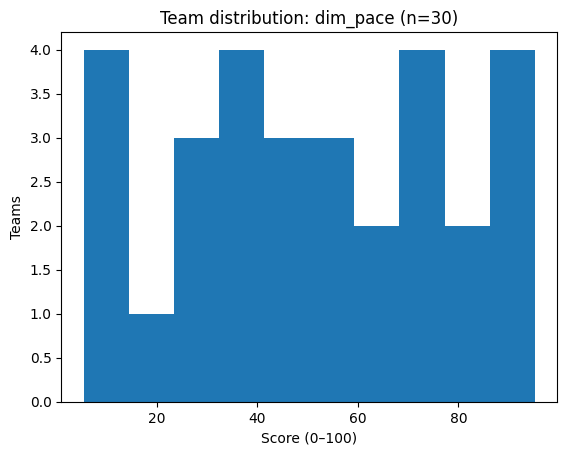

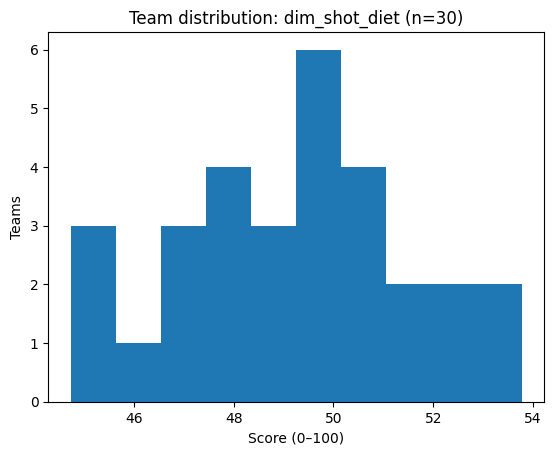

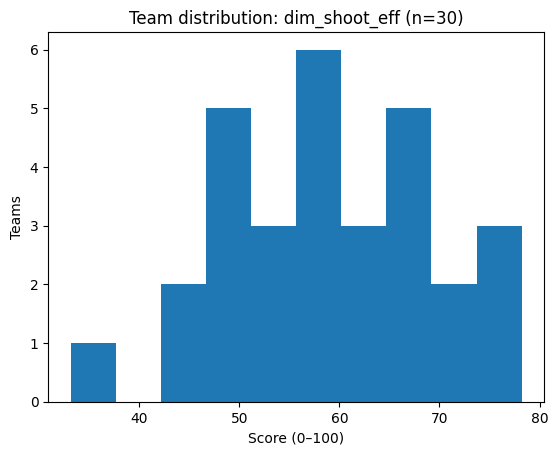

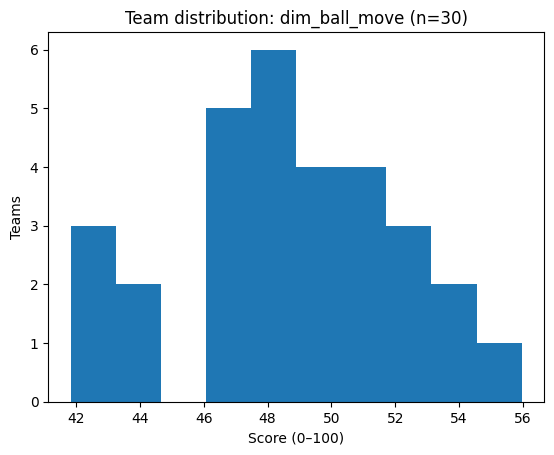

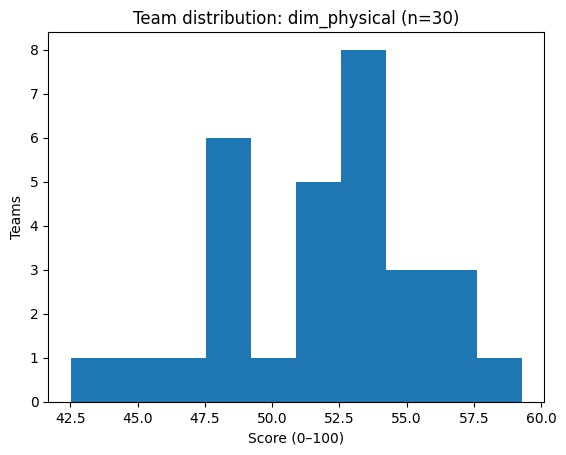

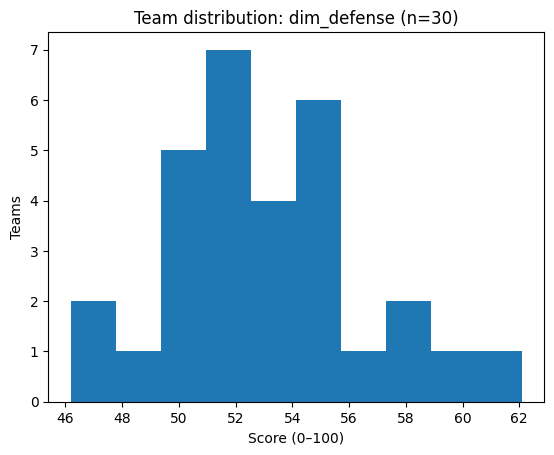

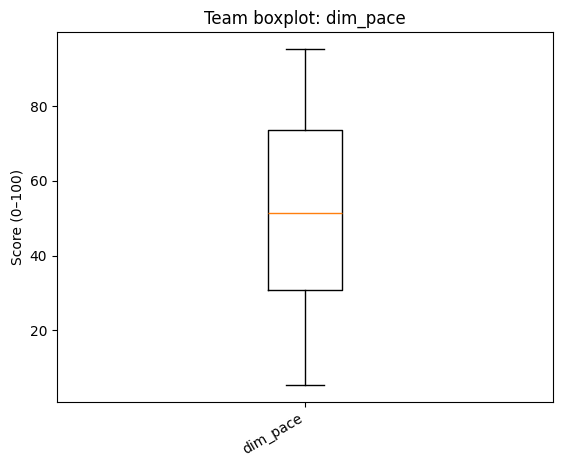

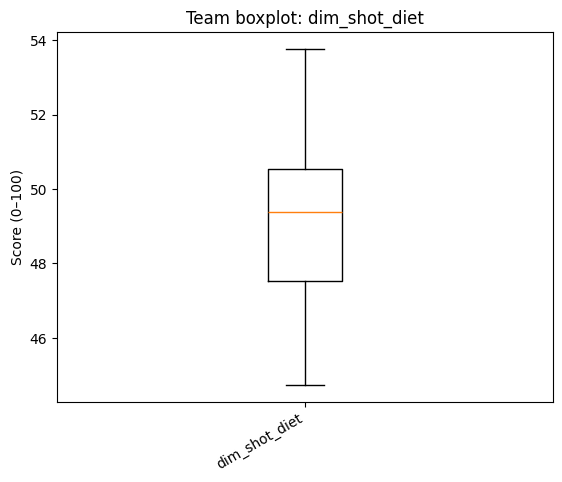

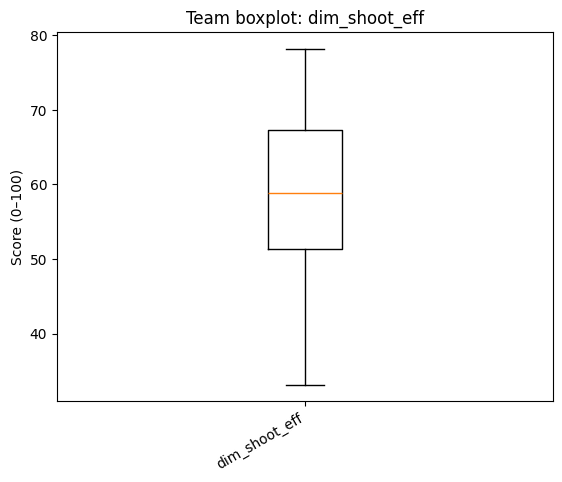

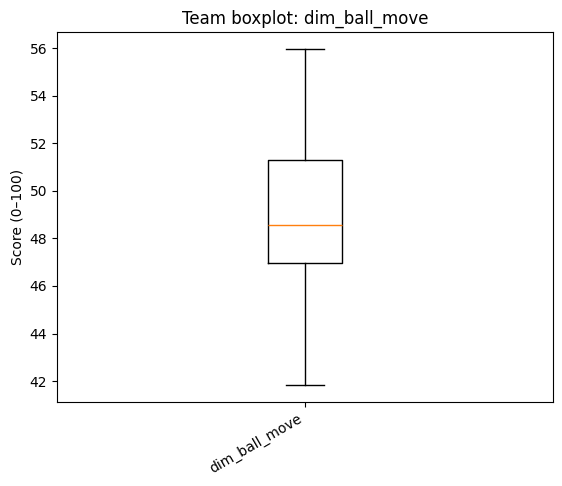

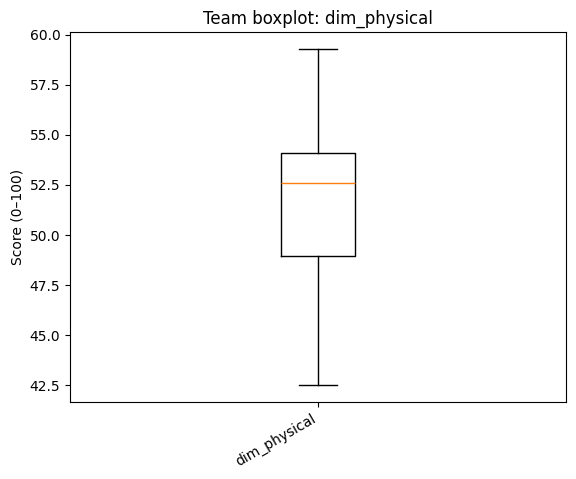

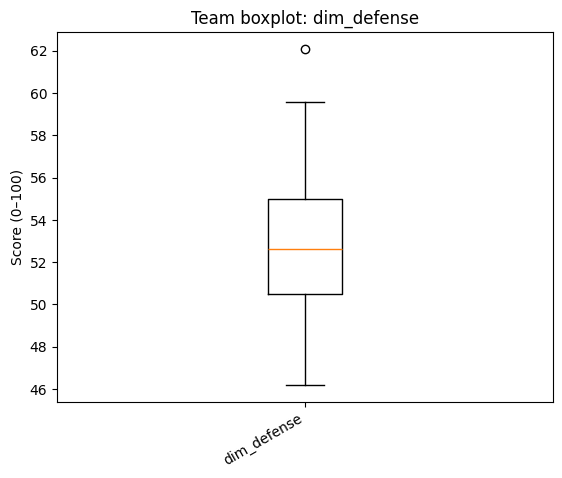

In [195]:
# examining distribution of dimension values across the league
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent  # if notebook is /notebooks
PROC = ROOT / "data" / "processed"

team_base = pd.read_csv(PROC / "team_dim_baseline_2023-24.csv")

DIM_COLS = ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]

print("Shape:", team_base.shape)
print(team_base[DIM_COLS].describe())

# --- histograms (one figure per dim) ---
for c in DIM_COLS:
    s = pd.to_numeric(team_base[c], errors="coerce").dropna()
    plt.figure()
    plt.hist(s, bins=10)
    plt.title(f"Team distribution: {c} (n={len(s)})")
    plt.xlabel("Score (0–100)")
    plt.ylabel("Teams")
    plt.show()

# --- boxplots (one figure per dim) ---
for c in DIM_COLS:
    s = pd.to_numeric(team_base[c], errors="coerce").dropna()
    plt.figure()
    plt.boxplot(s, vert=True)
    plt.title(f"Team boxplot: {c}")
    plt.ylabel("Score (0–100)")
    plt.xticks([1], [c], rotation=30, ha="right")
    plt.show()


In [196]:
# I want to fix the MacroFit scaling so that it spans more across 0 to 100

In [198]:
# to do that, I will first scale all dimensions involved in the macrofit, from 0-100, using relative scoring across the league 
# (the best team in a dimension for the season, gets scored as 100)

In [199]:
# then we also scale the frequencies and PPP efficiency with the same logic

In [200]:
from pathlib import Path
import numpy as np
import pandas as pd

# --- paths ---
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED = ROOT / "data" / "processed"

season = "2023-24"

team_dim_in = PROCESSED / f"team_dim_baseline_{season}.csv"
player_dim_in = PROCESSED / f"player_dim_scores_{season}_named_clean.csv"
player_dim_map_in = PROCESSED / "player_dim.csv"

team_pt_in = PROCESSED / f"team_playtype_season_{season}_enriched_freq.csv"
player_pt_in = PROCESSED / f"player_playtype_season_{season}_freq.csv"

assert team_dim_in.exists(), team_dim_in
assert player_dim_in.exists(), player_dim_in
assert player_dim_map_in.exists(), player_dim_map_in
assert team_pt_in.exists(), team_pt_in
assert player_pt_in.exists(), player_pt_in

# --- helpers ---
def minmax_0_100(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mn = s.min()
    mx = s.max()
    if pd.isna(mn) or pd.isna(mx) or mx == mn:
        return pd.Series(np.full(len(s), 50.0), index=s.index)  # degenerate -> neutral
    return 100.0 * (s - mn) / (mx - mn)

# -------------------------
# 1) TEAM macro dims scaled across teams (C1)
# -------------------------
team_dim = pd.read_csv(team_dim_in)
dim_cols = ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]

team_dim_scaled = team_dim.copy()
for c in dim_cols:
    team_dim_scaled[c + "_scaled"] = minmax_0_100(team_dim_scaled[c])

team_dim_scaled_out = PROCESSED / f"team_dim_baseline_{season}_scaled.csv"
team_dim_scaled.to_csv(team_dim_scaled_out, index=False)

# -------------------------
# 2) PLAYER macro dims scaled within position (C1 within primary_pos)
# -------------------------
player_dim = pd.read_csv(player_dim_in)

# ensure we have primary_pos (robust even if player_dim already has it)
player_dim_map = pd.read_csv(player_dim_map_in, usecols=["player_id","primary_pos"])
player_dim = player_dim.merge(player_dim_map, on="player_id", how="left", suffixes=("","_map"))
if "primary_pos_map" in player_dim.columns and player_dim["primary_pos"].isna().any():
    player_dim["primary_pos"] = player_dim["primary_pos"].fillna(player_dim["primary_pos_map"])
player_dim = player_dim.drop(columns=[c for c in ["primary_pos_map"] if c in player_dim.columns])

player_dim_scaled = player_dim.copy()
for c in dim_cols:
    player_dim_scaled[c + "_scaled"] = (
        player_dim_scaled.groupby("primary_pos", dropna=False)[c]
        .transform(minmax_0_100)
    )

player_dim_scaled_out = PROCESSED / f"player_dim_scores_{season}_scaled_pos.csv"
player_dim_scaled.to_csv(player_dim_scaled_out, index=False)

# -------------------------
# 3) TEAM playtype relative sliders:
#    freq_scaled + ppp_scaled within (type_grouping, playtype_api) across teams
# -------------------------
team_pt = pd.read_csv(team_pt_in)

need_cols_team = {"team_id","team_abbr","type_grouping","playtype_api","playtype_label","freq","ppp"}
missing = sorted(list(need_cols_team - set(team_pt.columns)))
assert not missing, f"team_playtype missing cols: {missing}"

g_team = ["type_grouping","playtype_api"]

team_pt_scaled = team_pt.copy()
team_pt_scaled["freq_scaled"] = team_pt_scaled.groupby(g_team)["freq"].transform(minmax_0_100)
team_pt_scaled["ppp_scaled"]  = team_pt_scaled.groupby(g_team)["ppp"].transform(minmax_0_100)

team_pt_scaled_out = PROCESSED / f"team_playtype_season_{season}_scaled.csv"
team_pt_scaled.to_csv(team_pt_scaled_out, index=False)

# -------------------------
# 4) PLAYER playtype relative sliders:
#    freq_scaled + ppp_scaled within (type_grouping, playtype_api, primary_pos) across players
# -------------------------
player_pt = pd.read_csv(player_pt_in)

need_cols_player = {"player_id","type_grouping","playtype_api","playtype_label","freq","ppp"}
missing = sorted(list(need_cols_player - set(player_pt.columns)))
assert not missing, f"player_playtype missing cols: {missing}"

player_pt = player_pt.merge(player_dim_map, on="player_id", how="left")

g_player = ["type_grouping","playtype_api","primary_pos"]

player_pt_scaled = player_pt.copy()
player_pt_scaled["freq_scaled"] = player_pt_scaled.groupby(g_player)["freq"].transform(minmax_0_100)
player_pt_scaled["ppp_scaled"]  = player_pt_scaled.groupby(g_player)["ppp"].transform(minmax_0_100)

player_pt_scaled_out = PROCESSED / f"player_playtype_season_{season}_scaled_pos.csv"
player_pt_scaled.to_csv(player_pt_scaled_out, index=False)

# --- quick sanity prints ---
print("saved:")
print(" ", team_dim_scaled_out)
print(" ", player_dim_scaled_out)
print(" ", team_pt_scaled_out)
print(" ", player_pt_scaled_out)

print("\nTEAM playtype scaled check (BOS OFF top 5 by freq):")
print(team_pt_scaled.query("team_abbr=='BOS' and type_grouping=='Offensive'")
      .sort_values("freq", ascending=False)[["playtype_label","freq","freq_scaled","ppp","ppp_scaled"]]
      .head(5))

print("\nPLAYER playtype scaled check (Jokic OFF top 5 by freq):")
# Jokic id = 203999 in your earlier sample; adjust if needed
print(player_pt_scaled.query("player_id==203999 and type_grouping=='Offensive'")
      .sort_values("freq", ascending=False)[["playtype_label","primary_pos","freq","freq_scaled","ppp","ppp_scaled"]]
      .head(5))


saved:
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_dim_baseline_2023-24_scaled.csv
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_scaled_pos.csv
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24_scaled.csv
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24_scaled_pos.csv

TEAM playtype scaled check (BOS OFF top 5 by freq):
               playtype_label       freq  freq_scaled       ppp  ppp_scaled
306                   Spot Up  24.569790    30.582150  1.167315  100.000000
68                 Transition  18.929254    56.699678  1.186869   83.913263
141  Pick & Roll Ball Handler  15.391969    15.875718  0.913043   53.359684
2                   Isolation   9.464627    63.330054  1.010101   84.863321
241                   Post Up   7.74

In [201]:
# creating MacroFit v2 using the scaled values
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED = ROOT / "data" / "processed"
season = "2023-24"

TEAM_ABBR = "BOS"      # <-- change
POS_FILTER = None      # e.g. "PG", "SG", "SF", "PF", "C" or None

team_dim = pd.read_csv(PROCESSED / f"team_dim_baseline_{season}_scaled.csv")
player_dim = pd.read_csv(PROCESSED / f"player_dim_scores_{season}_scaled_pos.csv")

dim_scaled_cols = [c + "_scaled" for c in ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]]

# --- target = team baseline (scaled) ---
team_row = team_dim.loc[team_dim["team_abbr"] == TEAM_ABBR]
assert len(team_row) == 1, f"Expected 1 team row for {TEAM_ABBR}, got {len(team_row)}"
target = team_row[dim_scaled_cols].iloc[0].to_dict()

# --- pool filters ---
pool = player_dim.copy()

# exclude same team
if "team_abbr" in pool.columns:
    pool = pool.loc[pool["team_abbr"] != TEAM_ABBR].copy()
else:
    raise KeyError("player_dim_scores_* must include team_abbr to exclude same team")

# position filter (optional)
if POS_FILTER is not None:
    pool = pool.loc[pool["primary_pos"] == POS_FILTER].copy()

# --- distance (equal weights) ---
X = pool[dim_scaled_cols].astype(float).to_numpy()
t = np.array([target[c] for c in dim_scaled_cols], dtype=float)

# RMS distance across 6 dims (0..100 scale)
dist = np.sqrt(np.mean((X - t) ** 2, axis=1))
pool["macro_dist"] = dist

# --- map to 0..100 with best=100, worst=0 in THIS pool ---
dmin = pool["macro_dist"].min()
dmax = pool["macro_dist"].max()
if dmax == dmin:
    pool["macro_fit_v2"] = 100.0
else:
    pool["macro_fit_v2"] = 100.0 * (1.0 - (pool["macro_dist"] - dmin) / (dmax - dmin))

# --- show distribution + top results ---
print("Target team (scaled baseline):", TEAM_ABBR, target)
print("\nMacroFit v2 distribution (pool):")
print(pool["macro_fit_v2"].describe(percentiles=[.1,.25,.5,.75,.9]))

show_cols = ["player_id","player_name","team_abbr","primary_pos","macro_fit_v2","macro_dist"] + dim_scaled_cols
top = pool.sort_values("macro_fit_v2", ascending=False).head(20)[show_cols]
print("\nTop 20 MacroFit v2:")
print(top.to_string(index=False))


Target team (scaled baseline): BOS {'dim_pace_scaled': 34.7512618350426, 'dim_shot_diet_scaled': 97.6554623233855, 'dim_shoot_eff_scaled': 100.0, 'dim_ball_move_scaled': 100.0, 'dim_physical_scaled': 66.89214219814892, 'dim_defense_scaled': 84.18504859960966}

MacroFit v2 distribution (pool):
count    553.000000
mean      43.612391
std       16.794725
min        0.000000
10%       21.713092
25%       32.105150
50%       44.709399
75%       55.376471
90%       64.488930
max      100.000000
Name: macro_fit_v2, dtype: float64

Top 20 MacroFit v2:
 player_id        player_name team_abbr primary_pos  macro_fit_v2  macro_dist  dim_pace_scaled  dim_shot_diet_scaled  dim_shoot_eff_scaled  dim_ball_move_scaled  dim_physical_scaled  dim_defense_scaled
   1630288    Jeff Dowtin Jr.       PHI           G    100.000000   11.094191        41.379310             96.263911             99.441341             81.543302            48.162993           85.121107
    201587      Nicolas Batum       PHI       

### Step B4: Playtype Fit + Final FitScore

In [202]:
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED = ROOT / "data" / "processed"
season = "2023-24"

TEAM_ABBR = "BOS"           # selected team
POS_FILTER = None           # e.g. "PG","SG","SF","PF","C" or None
SIDE = "OFF"                # "OFF" or "DEF"
ALPHA = 0.6                 # weight on MacroFit vs PlaytypeFit

# For MVP demo: only these playtypes are "editable"/considered
PLAYTYPES = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]  # labels, not api
# Coach targets: None => use team baseline. Or set values in 0..100 scaled space.
# Example: increase both frequency+ppp targets a bit
COACH_TARGET_OVERRIDES = {
    # "Pick & Roll Ball Handler": {"freq_scaled": 70.0, "ppp_scaled": 70.0},
    # "Pick & Roll Roll Man": {"freq_scaled": 70.0, "ppp_scaled": 70.0},
}

# --- load required tables ---
team_pt = pd.read_csv(PROCESSED / f"team_playtype_season_{season}_scaled.csv")
player_pt = pd.read_csv(PROCESSED / f"player_playtype_season_{season}_scaled_pos.csv")
player_dim = pd.read_csv(PROCESSED / f"player_dim_scores_{season}_scaled_pos.csv")

# --- rebuild MacroFit v2 quickly (same as before) ---
dim_scaled_cols = [c + "_scaled" for c in ["dim_pace","dim_shot_diet","dim_shoot_eff","dim_ball_move","dim_physical","dim_defense"]]
team_dim = pd.read_csv(PROCESSED / f"team_dim_baseline_{season}_scaled.csv")
team_row = team_dim.loc[team_dim["team_abbr"] == TEAM_ABBR]
assert len(team_row) == 1
macro_target = team_row[dim_scaled_cols].iloc[0].to_dict()

pool = player_dim.copy()
pool = pool.loc[pool["team_abbr"] != TEAM_ABBR].copy()
if POS_FILTER is not None:
    pool = pool.loc[pool["primary_pos"] == POS_FILTER].copy()

X = pool[dim_scaled_cols].astype(float).to_numpy()
t = np.array([macro_target[c] for c in dim_scaled_cols], dtype=float)
pool["macro_dist"] = np.sqrt(np.mean((X - t) ** 2, axis=1))

dmin, dmax = pool["macro_dist"].min(), pool["macro_dist"].max()
pool["macro_fit_v2"] = 100.0 if dmax == dmin else 100.0 * (1.0 - (pool["macro_dist"] - dmin) / (dmax - dmin))

# --- build playtype targets from team baseline ---
pt_side = "Offensive" if SIDE == "OFF" else "Defensive"
team_side = team_pt[(team_pt["team_abbr"] == TEAM_ABBR) & (team_pt["type_grouping"] == pt_side)].copy()

# Keep only selected playtypes (labels)
team_side = team_side[team_side["playtype_label"].isin(PLAYTYPES)].copy()
assert len(team_side) == len(PLAYTYPES), f"Missing some playtypes for team {TEAM_ABBR}/{SIDE}. Found: {team_side['playtype_label'].tolist()}"

targets = {}
for _, r in team_side.iterrows():
    label = r["playtype_label"]
    targets[label] = {
        "freq_scaled": float(r["freq_scaled"]),
        "ppp_scaled": float(r["ppp_scaled"]),
    }

# Apply coach overrides (if any)
for label, ov in COACH_TARGET_OVERRIDES.items():
    if label in targets:
        targets[label]["freq_scaled"] = float(ov.get("freq_scaled", targets[label]["freq_scaled"]))
        targets[label]["ppp_scaled"] = float(ov.get("ppp_scaled", targets[label]["ppp_scaled"]))

print("Playtype targets:", SIDE, targets)

# --- compute PlaytypeFit for each player in pool ---
# Filter player playtypes to pool + side + selected playtypes
ppt_side = player_pt[(player_pt["type_grouping"] == pt_side) & (player_pt["playtype_label"].isin(PLAYTYPES))].copy()
ppt_side = ppt_side[ppt_side["player_id"].isin(pool["player_id"])].copy()

# Ensure we use position-aware scaling (already in file); if not, fallback to non-pos
need_cols = ["player_id","playtype_label","freq_scaled","ppp_scaled"]
missing = [c for c in need_cols if c not in ppt_side.columns]
assert not missing, f"Missing columns in player playtype table: {missing}"

# Distance per playtype
def row_dist(row):
    tgt = targets[row["playtype_label"]]
    return float(np.sqrt((row["freq_scaled"] - tgt["freq_scaled"])**2 + (row["ppp_scaled"] - tgt["ppp_scaled"])**2))

ppt_side["pt_dist"] = ppt_side.apply(row_dist, axis=1)

# Aggregate per player: average dist across selected playtypes
pt_agg = ppt_side.groupby("player_id", as_index=False)["pt_dist"].mean()

# Merge into pool; players missing a playtype get dropped (or set worst). We'll set worst.
pool2 = pool.merge(pt_agg, on="player_id", how="left")
worst = pool2["pt_dist"].max()
pool2["pt_dist"] = pool2["pt_dist"].fillna(worst)

# Calibrate to 0..100 within pool
dmin, dmax = pool2["pt_dist"].min(), pool2["pt_dist"].max()
pool2["playtype_fit_v2"] = 100.0 if dmax == dmin else 100.0 * (1.0 - (pool2["pt_dist"] - dmin) / (dmax - dmin))

# Final FitScore
pool2["fit_score"] = ALPHA * pool2["macro_fit_v2"] + (1.0 - ALPHA) * pool2["playtype_fit_v2"]

print("\nFitScore distribution:")
print(pool2["fit_score"].describe(percentiles=[.1,.25,.5,.75,.9]))

show_cols = ["player_id","player_name","team_abbr","primary_pos","fit_score","macro_fit_v2","playtype_fit_v2"]
print("\nTop 20 FitScore:")
print(pool2.sort_values("fit_score", ascending=False).head(20)[show_cols].to_string(index=False))


Playtype targets: OFF {'Pick & Roll Ball Handler': {'freq_scaled': 15.875718076087017, 'ppp_scaled': 53.35968379446635}, 'Pick & Roll Roll Man': {'freq_scaled': 45.883733168542776, 'ppp_scaled': 70.59721011333912}}

FitScore distribution:
count    553.000000
mean      43.685246
std       19.271531
min        0.000000
10%       15.968082
25%       28.080109
50%       46.288619
75%       58.958782
90%       67.453460
max       83.389398
Name: fit_score, dtype: float64

Top 20 FitScore:
 player_id          player_name team_abbr primary_pos  fit_score  macro_fit_v2  playtype_fit_v2
   1631246   Vince Williams Jr.       MEM           G  83.389398     73.278867        98.555195
   1629162    Jordan McLaughlin       MIN           G  83.354494     86.041971        79.323279
    200768           Kyle Lowry       MIA           G  81.488776     75.365118        90.674263
    201935         James Harden       LAC           G  79.805584     79.279952        80.594031
    203939        Dwight Powell

In [203]:
# we will convert FitScore to percentile - it preserves ranking and guarantees the top candidate gets ~100 from the filtered pool of players

In [205]:
print("cols:", [c for c in df_pool.columns if "fit" in c.lower()])
print("all cols sample:", list(df_pool.columns)[:40])


cols: ['macro_fit']
all cols sample: ['league', 'season', 'player_id', 'player_name', 'primary_pos', 'dim_pace', 'dim_shot_diet', 'dim_shoot_eff', 'dim_ball_move', 'dim_physical', 'dim_defense', 'team_id', 'team_abbr', 'macro_fit']


In [212]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROC = ROOT / "data" / "processed"

def coalesce_any(df, base, suffixes):
    """Create df[base] by first-non-null across base+suffix variants."""
    cols = [base] + [f"{base}{s}" for s in suffixes]
    existing = [c for c in cols if c in df.columns]
    if not existing:
        raise KeyError(f"No columns found for base={base}. Tried: {cols}. "
                       f"Available cols sample: {list(df.columns)[:40]}")
    if base not in df.columns:
        df[base] = pd.Series([np.nan] * len(df))
    for c in existing:
        if c == base:
            continue
        df[base] = df[base].combine_first(df[c])
    return df

# --- load the same files ---
team_dims   = pd.read_csv(PROC / "team_dim_baseline_2023-24_scaled.csv")
player_dims = pd.read_csv(PROC / "player_dim_scores_2023-24_scaled_pos.csv")
team_pt     = pd.read_csv(PROC / "team_playtype_season_2023-24_scaled.csv")
player_pt   = pd.read_csv(PROC / "player_playtype_season_2023-24_scaled_pos.csv")
player_dim  = pd.read_csv(PROC / "player_dim.csv")

# --- normalize player_dim source columns ---
if "team_abbr" not in player_dim.columns:
    for c in ["team_abbr_current","team_abbr_season","teamTricode","team_tricode"]:
        if c in player_dim.columns:
            player_dim["team_abbr"] = player_dim[c]; break
if "team_id" not in player_dim.columns:
    for c in ["team_id_current","team_id_season"]:
        if c in player_dim.columns:
            player_dim["team_id"] = player_dim[c]; break
if "player_name" not in player_dim.columns:
    for c in ["full_name","display_first_last"]:
        if c in player_dim.columns:
            player_dim["player_name"] = player_dim[c]; break
if "primary_pos" not in player_dim.columns:
    for c in ["pos_primary","position","pos_raw"]:
        if c in player_dim.columns:
            player_dim["primary_pos"] = player_dim[c]; break

player_dim_small = player_dim[["player_id","player_name","team_id","team_abbr","primary_pos"]].copy()

# --- merge dims + identity columns ---
df = player_dims.merge(player_dim_small, on="player_id", how="left", suffixes=("_dims", "_dim"))

# IMPORTANT: your df has *_dims and *_dim, so coalesce those
suffixes = ["_x","_y","_dims","_dim","_current","_season"]
for base in ["team_abbr","team_id","player_name","primary_pos"]:
    df = coalesce_any(df, base, suffixes)

# quick verification
print("canonical cols present:",
      {c: (c in df.columns) for c in ["team_abbr","team_id","player_name","primary_pos"]})
print("nulls:", {
    "team_abbr": int(df["team_abbr"].isna().sum()),
    "team_id": int(df["team_id"].isna().sum()),
    "player_name": int(df["player_name"].isna().sum()),
    "primary_pos": int(df["primary_pos"].isna().sum()),
})
print("sample team_abbr:", df["team_abbr"].dropna().unique()[:10])


canonical cols present: {'team_abbr': True, 'team_id': True, 'player_name': True, 'primary_pos': True}
nulls: {'team_abbr': 0, 'team_id': 0, 'player_name': 0, 'primary_pos': 0}
sample team_abbr: ['LAL' 'GSW' 'MIA' 'LAC' 'PHX' 'BOS' 'MIN' 'HOU' 'TOR' 'MEM']


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/1359943055.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[base].combine_first(df[c])


In [213]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROC = ROOT / "data" / "processed"

def coalesce_any(df, base, suffixes):
    cols = [base] + [f"{base}{s}" for s in suffixes]
    existing = [c for c in cols if c in df.columns]
    if not existing:
        raise KeyError(f"No columns found for base={base}. Tried: {cols}. "
                       f"Available cols sample: {list(df.columns)[:40]}")
    if base not in df.columns:
        df[base] = pd.Series([np.nan] * len(df))
    for c in existing:
        if c == base:
            continue
        df[base] = df[base].combine_first(df[c])
    return df

def pct_rank_0_100(s):
    return s.rank(pct=True, method="average") * 100.0

# --- load ---
team_dims   = pd.read_csv(PROC / "team_dim_baseline_2023-24_scaled.csv")
player_dims = pd.read_csv(PROC / "player_dim_scores_2023-24_scaled_pos.csv")
team_pt     = pd.read_csv(PROC / "team_playtype_season_2023-24_scaled.csv")
player_pt   = pd.read_csv(PROC / "player_playtype_season_2023-24_scaled_pos.csv")
player_dim  = pd.read_csv(PROC / "player_dim.csv")

# normalize player_dim minimal cols
if "team_abbr" not in player_dim.columns:
    for c in ["team_abbr_current","team_abbr_season","teamTricode","team_tricode"]:
        if c in player_dim.columns:
            player_dim["team_abbr"] = player_dim[c]; break
if "team_id" not in player_dim.columns:
    for c in ["team_id_current","team_id_season"]:
        if c in player_dim.columns:
            player_dim["team_id"] = player_dim[c]; break
if "player_name" not in player_dim.columns:
    for c in ["full_name","display_first_last"]:
        if c in player_dim.columns:
            player_dim["player_name"] = player_dim[c]; break
if "primary_pos" not in player_dim.columns:
    for c in ["pos_primary","position","pos_raw"]:
        if c in player_dim.columns:
            player_dim["primary_pos"] = player_dim[c]; break

player_dim_small = player_dim[["player_id","player_name","team_id","team_abbr","primary_pos"]].copy()

# --- merge dims + identity fields ---
df = player_dims.merge(player_dim_small, on="player_id", how="left", suffixes=("_dims", "_dim"))
for base in ["team_abbr","team_id","player_name","primary_pos"]:
    df = coalesce_any(df, base, ["_x","_y","_dims","_dim","_current","_season"])

# --- pick team baseline/target (example: BOS) ---
TEAM = "BOS"
baseline = team_dims.loc[team_dims["team_abbr"] == TEAM].iloc[0].to_dict()
target = baseline  # for now, same as baseline; your UI later changes target

dim_cols = [
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"
]

# convert target dict into same key names
target_vec = np.array([
    baseline["dim_pace"], baseline["dim_shot_diet"], baseline["dim_shoot_eff"],
    baseline["dim_ball_move"], baseline["dim_physical"], baseline["dim_defense"]
], dtype=float)

# --- macro fit (distance -> 0..100, where perfect match=100) ---
X = df[dim_cols].to_numpy(dtype=float)
dist = np.sqrt(((X - target_vec) ** 2).sum(axis=1))
max_dist = np.sqrt((100.0**2) * len(dim_cols))
df["macro_fit_v2"] = (1.0 - (dist / max_dist)).clip(0, 1) * 100.0

# --- playtype fit (example: OFF PRBallHandler + PRRollMan) ---
# You can expand this later; keep MVP simple.
target_playtypes = ["PRBallHandler", "PRRollMan"]
# take team OFF targets from team_pt (scaled)
tp = team_pt[(team_pt["team_abbr"] == TEAM) & (team_pt["type_grouping"] == "Offensive")].copy()
tp = tp[tp["playtype_api"].isin(target_playtypes)].set_index("playtype_api")

# if team missing any playtype rows (rare), fill with 0
for pt_name in target_playtypes:
    if pt_name not in tp.index:
        tp.loc[pt_name, ["freq_scaled","ppp_scaled"]] = [0.0, 0.0]

team_targets = tp[["freq_scaled","ppp_scaled"]].to_dict(orient="index")

# player OFF playtypes (scaled)
pp = player_pt[(player_pt["type_grouping"] == "Offensive") & (player_pt["playtype_api"].isin(target_playtypes))].copy()

# position-aware scaling already in player_pt; ensure columns exist
need_cols = ["player_id","playtype_api","freq_scaled","ppp_scaled","primary_pos"]
missing = [c for c in need_cols if c not in pp.columns]
if missing:
    raise KeyError(f"player_pt missing columns: {missing}. Available: {list(pp.columns)[:40]}")

# pivot to wide per player
wide = pp.pivot_table(
    index=["player_id","primary_pos"],
    columns="playtype_api",
    values=["freq_scaled","ppp_scaled"],
    aggfunc="mean"
)
wide.columns = [f"{a}_{b}" for a,b in wide.columns]
wide = wide.reset_index()

# compute playtype distance
def playtype_dist_row(r):
    d = 0.0
    for pt_name in target_playtypes:
        tf = float(team_targets[pt_name]["freq_scaled"])
        te = float(team_targets[pt_name]["ppp_scaled"])
        pf = float(r.get(f"freq_scaled_{pt_name}", 0.0))
        pe = float(r.get(f"ppp_scaled_{pt_name}", 0.0))
        d += (pf - tf) ** 2 + (pe - te) ** 2
    return np.sqrt(d)

wide["playtype_dist"] = wide.apply(playtype_dist_row, axis=1)
max_pt_dist = np.sqrt(len(target_playtypes) * (100.0**2 + 100.0**2))
wide["playtype_fit_v2"] = (1.0 - (wide["playtype_dist"] / max_pt_dist)).clip(0, 1) * 100.0

# merge playtype fit back
df = df.merge(wide[["player_id","playtype_fit_v2"]], on="player_id", how="left")
df["playtype_fit_v2"] = df["playtype_fit_v2"].fillna(0.0)

# --- combine into fit_score with alpha (you can later expose alpha as slider) ---
alpha = 0.6  # macro weight
df["fit_score"] = alpha * df["macro_fit_v2"] + (1 - alpha) * df["playtype_fit_v2"]

# --- percentile transformation ---
df["fit_score_pctile"] = pct_rank_0_100(df["fit_score"])

out_path = PROC / "player_fit_scores_2023-24_bos_example.csv"
df[[
    "league","season","player_id","player_name","team_abbr","primary_pos",
    "macro_fit_v2","playtype_fit_v2","fit_score","fit_score_pctile"
]].to_csv(out_path, index=False)

print("saved:", out_path)
print(df[["fit_score","fit_score_pctile","macro_fit_v2","playtype_fit_v2"]].describe())
print("Top 10 by fit_score_pctile:")
print(df.sort_values("fit_score_pctile", ascending=False)[
    ["player_name","team_abbr","primary_pos","fit_score","fit_score_pctile","macro_fit_v2","playtype_fit_v2"]
].head(10).to_string(index=False))


saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_fit_scores_2023-24_bos_example.csv
        fit_score  fit_score_pctile  macro_fit_v2  playtype_fit_v2
count  568.000000        568.000000    568.000000       568.000000
mean    51.936213         50.088028     74.294453        18.398854
std     14.707917         28.892914      8.277257        31.958674
min     31.258742          0.176056     52.097904         0.000000
25%     42.038235         25.132042     68.511367         0.000000
50%     46.474819         50.088028     74.934450         0.000000
75%     61.859906         75.044014     80.690484        47.843528
max     89.029386        100.000000     93.763762        90.144162
Top 10 by fit_score_pctile:
     player_name team_abbr primary_pos  fit_score  fit_score_pctile  macro_fit_v2  playtype_fit_v2
     Amir Coffey       LAC           G  89.029386        100.000000     88.286202        90.144162
 Trey Murphy III       NOP        

/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/3296391141.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[base].combine_first(df[c])


#### Step B5: one-cell scoring engine (team-param, α slider, exclude team, optional pos filter, recompute percentiles)

In [215]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
PROCESSED = ROOT / "data" / "processed"
OUT_DIR = ROOT / "data" / "app" / "fit_scores" / "season=2023-24"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------
# Helpers
# -----------------------
DIM_COLS_SCALED = [
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"
]

def pct_rank_0_100(s: pd.Series) -> pd.Series:
    # stable percentile rank into [0,100]
    return s.rank(pct=True, method="average") * 100

def macro_fit_from_target(players: pd.DataFrame, target: dict, dim_cols=DIM_COLS_SCALED) -> pd.DataFrame:
    # equal weights by default; distance = mean abs diff across dims
    diffs = []
    for c in dim_cols:
        t = float(target[c])
        diffs.append((players[c] - t).abs())
    dist = pd.concat(diffs, axis=1).mean(axis=1)  # 0..100
    macro_fit = (100 - dist).clip(0, 100)
    out = players.copy()
    out["macro_dist"] = dist
    out["macro_fit_v2"] = macro_fit
    return out

def playtype_fit(players_play: pd.DataFrame, targets: dict) -> pd.Series:
    """
    targets: dict like:
      {
        "Pick & Roll Ball Handler": {"freq_scaled": x, "ppp_scaled": y},
        "Pick & Roll Roll Man": {"freq_scaled": x, "ppp_scaled": y},
      }
    players_play: rows at grain (player_id, type_grouping, playtype_label) with freq_scaled/ppp_scaled
    returns series indexed by player_id in [0,100]
    """
    if not targets:
        return pd.Series(dtype=float)

    parts = []
    for label, t in targets.items():
        sub = players_play[players_play["playtype_label"] == label].copy()
        if sub.empty:
            continue
        # distance per playtype = mean(abs(freq - target_freq), abs(ppp - target_ppp))
        d = (sub["freq_scaled"] - float(t["freq_scaled"])).abs()
        d = pd.concat([d, (sub["ppp_scaled"] - float(t["ppp_scaled"])).abs()], axis=1).mean(axis=1)
        fit = (100 - d).clip(0, 100)
        parts.append(pd.DataFrame({"player_id": sub["player_id"].values, f"fit_{label}": fit.values}))

    if not parts:
        return pd.Series(dtype=float)

    wide = parts[0]
    for p in parts[1:]:
        wide = wide.merge(p, on="player_id", how="outer")

    fit_cols = [c for c in wide.columns if c.startswith("fit_")]
    wide["playtype_fit_v2"] = wide[fit_cols].mean(axis=1, skipna=True).fillna(0.0)
    return wide.set_index("player_id")["playtype_fit_v2"]

# -----------------------
# Load base tables
# -----------------------
players_dim_scaled = pd.read_csv(PROCESSED / "player_dim_scores_2023-24_scaled_pos.csv")
team_dim_scaled = pd.read_csv(PROCESSED / "team_dim_baseline_2023-24_scaled.csv")
team_play_scaled = pd.read_csv(PROCESSED / "team_playtype_season_2023-24_scaled.csv")
player_play_scaled = pd.read_csv(PROCESSED / "player_playtype_season_2023-24_scaled_pos.csv")

# canonical columns for safety (you already did a version of this)
def canonicalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    for base in ["team_abbr","team_id","player_name","primary_pos"]:
        cands = [c for c in df.columns if c == base or c.endswith(f"_{base}") or c.endswith(f"_{base}_dim") or c.endswith(f"_{base}_dims") or c.endswith(f"_{base}_season") or c.endswith(f"_{base}_current")]
        if base not in df.columns and cands:
            # prefer exact suffix order
            df[base] = df[cands[0]]
            for c in cands[1:]:
                df[base] = df[base].combine_first(df[c])
    return df

players_dim_scaled = canonicalize_cols(players_dim_scaled)

# -----------------------
# Parameters (edit these in Streamlit later)
# -----------------------
TEAM_ABBR = "BOS"
ALPHA = 0.5                 # weight between macro vs playtypes: Fit = α*Macro + (1-α)*Playtype
POS_FILTER = None           # e.g. "G" or "F" or "C" or None
EXCLUDE_TEAM = True         # exclude TEAM_ABBR from shortlist
USE_OFF_PLAYTYPES = True

# For MVP demo: only two OFF playtypes
OFF_PLAYTYPE_LABELS = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]

# -----------------------
# Build team targets (baseline == target unless you override sliders)
# -----------------------
team_row = team_dim_scaled.loc[team_dim_scaled["team_abbr"] == TEAM_ABBR].iloc[0]
team_target_dims = {c: float(team_row[c]) for c in DIM_COLS_SCALED}

# Playtype targets from team baseline for those playtypes (OFF only)
team_play_off = team_play_scaled[(team_play_scaled["team_abbr"] == TEAM_ABBR) & (team_play_scaled["type_grouping"] == "Offensive")]
team_play_off = team_play_off[team_play_off["playtype_label"].isin(OFF_PLAYTYPE_LABELS)]
playtype_targets_off = {
    r["playtype_label"]: {"freq_scaled": float(r["freq_scaled"]), "ppp_scaled": float(r["ppp_scaled"])}
    for _, r in team_play_off.iterrows()
}

# -----------------------
# Filter player pool
# -----------------------
pool = players_dim_scaled.copy()

if EXCLUDE_TEAM and "team_abbr" in pool.columns:
    pool = pool[pool["team_abbr"] != TEAM_ABBR]

if POS_FILTER:
    pool = pool[pool["primary_pos"] == POS_FILTER]

# -----------------------
# Compute MacroFit + PlaytypeFit + FitScore + percentiles (within current pool)
# -----------------------
scored = macro_fit_from_target(pool, team_target_dims)

# playtype fit (OFF)
if USE_OFF_PLAYTYPES and playtype_targets_off:
    pp = player_play_scaled[(player_play_scaled["type_grouping"] == "Offensive") & (player_play_scaled["playtype_label"].isin(OFF_PLAYTYPE_LABELS))]
    play_fit = playtype_fit(pp, playtype_targets_off)
    scored = scored.merge(play_fit.rename("playtype_fit_v2"), left_on="player_id", right_index=True, how="left")
else:
    scored["playtype_fit_v2"] = 0.0

scored["playtype_fit_v2"] = scored["playtype_fit_v2"].fillna(0.0)

scored["fit_score"] = (ALPHA * scored["macro_fit_v2"] + (1 - ALPHA) * scored["playtype_fit_v2"]).clip(0, 100)
scored["fit_score_pctile"] = pct_rank_0_100(scored["fit_score"])

# quick summary
print("Pool size:", len(scored))
print(scored[["fit_score","fit_score_pctile","macro_fit_v2","playtype_fit_v2"]].describe())

# save
out_path = OUT_DIR / f"fit_scores_team={TEAM_ABBR}_alpha={ALPHA}_pos={POS_FILTER or 'ALL'}_excl={EXCLUDE_TEAM}.csv"
scored.sort_values("fit_score", ascending=False).to_csv(out_path, index=False)
print("saved:", out_path)

# show top 15
display(scored.sort_values("fit_score", ascending=False)[
    ["player_id","player_name","team_abbr","primary_pos","fit_score","fit_score_pctile","macro_fit_v2","playtype_fit_v2"]
].head(15))


Pool size: 596
        fit_score  fit_score_pctile  macro_fit_v2  playtype_fit_v2
count  596.000000        596.000000    596.000000       596.000000
mean    58.330453         50.083893     61.765694        54.895211
std     20.566146         28.891721      9.336602        37.967609
min     16.461617          0.167785     32.923234         0.000000
25%     33.973844         25.125839     55.763129         0.000000
50%     67.435168         50.083893     62.111759        73.945518
75%     74.428092         75.041946     68.609922        83.602422
max     86.817830        100.000000     92.216639        98.391692
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24/fit_scores_team=BOS_alpha=0.5_pos=ALL_excl=True.csv


,player_id,player_name,team_abbr,primary_pos,fit_score,fit_score_pctile,macro_fit_v2,playtype_fit_v2
489,1631246,Vince Williams Jr.,MEM,G,86.817830,100.000000,75.859060,97.776600
87,203939,Dwight Powell,DAL,F,85.565446,99.832215,74.802810,96.328082
19,201935,James Harden,LAC,G,84.790198,99.664430,82.621709,86.958686
2,200768,Kyle Lowry,MIA,G,84.676261,99.496644,76.363118,92.989404
231,1629162,Jordan McLaughlin,MIN,G,84.559334,99.328859,83.371025,85.747644
325,1630208,Nick Richards,CHA,C,84.363916,99.161074,73.753217,94.974615
424,1630700,Dyson Daniels,NOP,G,84.258506,98.993289,75.334055,93.182957
368,1630544,Tre Mann,CHA,G,84.082973,98.825503,73.594614,94.571332
192,1628978,Donte DiVincenzo,NYK,G,83.833540,98.657718,74.350704,93.316376
147,1627936,Alex Caruso,CHI,G,83.822551,98.489933,80.461161,87.183941


## Phase B: From here to Streamlit

#### Step 1: add volume fields (mpg, poss_used_pg, poss_decided_pg) and merge into a single player-card table

In [216]:
import pandas as pd
from pathlib import Path

# run from /notebooks; adjust ROOT if you're elsewhere
ROOT = Path.cwd().parent
path = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"

df = pd.read_csv(path)
print("path:", path)
print("shape:", df.shape)
print("columns:", list(df.columns))


path: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
shape: (572, 36)
columns: ['league', 'season', 'player_id', 'games', 'minutes', 'fga', 'fta', 'tov', 'ast', 'team_id_mode', 'player_poss_used', 'player_poss_decided', 'poss_used_per100_min', 'ast_per100_poss_used', 'tov_per100_poss_used', 'assist_pct', 'tov_pct', 'poss_used_pct', 'team_id', 'team_minutes', 'team_fga', 'team_fta', 'team_tov', 'team_ast', 'team_poss_used', 'team_poss_decided', 'usg_pct', 'poss_decided_pct', 'poss_used_per100_min_pctile', 'ast_per100_poss_used_pctile', 'tov_per100_poss_used_pctile', 'assist_pct_pctile', 'tov_pct_pctile', 'poss_used_pct_pctile', 'usg_pct_pctile', 'poss_decided_pct_pctile']


In [218]:
# compute per-game volume fields from this CSV, then merge them into the player card

In [219]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent

usage_path = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"
card_in   = ROOT / "data" / "processed" / "player_card_2023-24_v9_with_denominators.csv"

usage = pd.read_csv(usage_path)
card  = pd.read_csv(card_in)

# --- 1) create per-game fields (volume filters) ---
# protect against divide-by-zero
usage["games"] = usage["games"].fillna(0).astype(float)
usage["minutes"] = usage["minutes"].fillna(0).astype(float)
usage["player_poss_used"] = usage["player_poss_used"].fillna(0).astype(float)
usage["player_poss_decided"] = usage["player_poss_decided"].fillna(0).astype(float)

usage["mpg"] = (usage["minutes"] / usage["games"]).where(usage["games"] > 0, 0.0)
usage["poss_used_pg"] = (usage["player_poss_used"] / usage["games"]).where(usage["games"] > 0, 0.0)
usage["poss_decided_pg"] = (usage["player_poss_decided"] / usage["games"]).where(usage["games"] > 0, 0.0)

# keep only what we need for the shortlist filters
usage_vol = usage[[
    "league","season","player_id",
    "games","minutes","mpg",
    "player_poss_used","poss_used_pg",
    "player_poss_decided","poss_decided_pg"
]].copy()

out_usage = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage_with_volume.csv"
usage_vol.to_csv(out_usage, index=False)

# --- 2) merge into player card (single source of truth for Streamlit shortlist later) ---
merge_keys = ["league","season","player_id"]
missing_keys = [k for k in merge_keys if k not in card.columns]
if missing_keys:
    raise KeyError(f"Player card missing keys {missing_keys}. card cols sample={list(card.columns)[:25]}")

card_v10 = card.merge(usage_vol, on=merge_keys, how="left", suffixes=("", "_usage"))

# sanity
nulls = card_v10[["games","mpg","player_poss_decided","poss_decided_pg"]].isna().sum().to_dict()

out_card = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"
card_v10.to_csv(out_card, index=False)

print("saved usage:", out_usage)
print("saved card:", out_card)
print("shape usage_vol:", usage_vol.shape)
print("shape card_v10:", card_v10.shape)
print("nulls:", nulls)
print(card_v10[["player_id","games","mpg","player_poss_decided","poss_decided_pg"]].head())


saved usage: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage_with_volume.csv
saved card: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v10_with_volume_filters.csv
shape usage_vol: (572, 10)
shape card_v10: (568, 117)
nulls: {'games': 0, 'mpg': 0, 'player_poss_decided': 0, 'poss_decided_pg': 0}
   player_id  games        mpg  player_poss_decided  poss_decided_pg
0       2544     71  35.323944              1986.26        27.975493
1     101108     58  26.431034               762.38        13.144483
2     200768     60  28.183333               621.50        10.358333
3     200782     31  15.709677                67.32         2.171613
4     201142     75  37.200000              2055.12        27.401600


#### Step 2: build a “shortlist query” in notebook: load fit-scores + player-card, apply team exclusion + position + volume thresholds, show top 10

In [221]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent

# Inputs
card_path = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"
fit_path  = ROOT / "data" / "app" / "fit_scores" / "season=2023-24" / "fit_scores_team=BOS_alpha=0.5_pos=ALL_excl=True.csv"

card = pd.read_csv(card_path)
fit  = pd.read_csv(fit_path)

# --- parameters (these become Streamlit sliders later) ---
selected_team_abbr = "BOS"   # dropdown later
position_filter = "ALL"      # dropdown later: ALL/G/F/C
min_games = 1               # slider later
min_mpg = 1.0               # slider later (0..48 for NBA)
min_poss_decided_pg = 1.0   # slider later

# --- normalize / safety ---
# canonicalize expected columns
required_card = ["league","season","player_id","team_abbr","primary_pos","games","mpg","player_poss_decided","poss_decided_pg"]
missing = [c for c in required_card if c not in card.columns]
if missing:
    raise KeyError(f"player_card missing cols: {missing}. cols sample={list(card.columns)[:30]}")

# fit table should have at least player_id + fit_score_pctile (or fit_score)
if "fit_score_pctile" not in fit.columns and "fit_score" not in fit.columns:
    raise KeyError(f"fit table missing fit_score_pctile/fit_score. cols={list(fit.columns)}")

# merge: keep fit ordering, attach volume + meta from card
df = fit.merge(
    card[["player_id","player_name","team_abbr","primary_pos","games","mpg","player_poss_decided","poss_decided_pg"]],
    on="player_id",
    how="left",
    suffixes=("", "_card")
)

# --- filters ---
# exclude selected team (important for Transfer Machine)
df = df[df["team_abbr"] != selected_team_abbr]

# position filter (simple mapping: treat G/F/C as buckets)
if position_filter != "ALL":
    df = df[df["primary_pos"] == position_filter]

# volume filters
df = df[(df["games"] >= min_games) & (df["mpg"] >= min_mpg) & (df["poss_decided_pg"] >= min_poss_decided_pg)]

# --- ranking + output ---
score_col = "fit_score_pctile" if "fit_score_pctile" in df.columns else "fit_score"
top10 = df.sort_values(score_col, ascending=False).head(10)

print("pool size after filters:", len(df))
print("top10 cols:", list(top10.columns))
print(top10[["player_id","player_name","team_abbr","primary_pos","games","mpg","poss_decided_pg", score_col]])


pool size after filters: 587
top10 cols: ['league', 'season', 'player_id', 'player_name', 'primary_pos', 'dim_pace', 'dim_shot_diet', 'dim_shoot_eff', 'dim_ball_move', 'dim_physical', 'dim_defense', 'team_id', 'team_abbr', 'dim_pace_scaled', 'dim_shot_diet_scaled', 'dim_shoot_eff_scaled', 'dim_ball_move_scaled', 'dim_physical_scaled', 'dim_defense_scaled', 'macro_dist', 'macro_fit_v2', 'playtype_fit_v2', 'fit_score', 'fit_score_pctile', 'player_name_card', 'team_abbr_card', 'primary_pos_card', 'games', 'mpg', 'player_poss_decided', 'poss_decided_pg']
   player_id         player_name team_abbr primary_pos  games        mpg  \
0    1631246  Vince Williams Jr.       MEM           G     52  27.750000   
1     203939       Dwight Powell       DAL           F     63  13.269841   
2     201935        James Harden       LAC           G     72  34.291667   
3     200768          Kyle Lowry       MIA           G     60  28.183333   
4    1629162   Jordan McLaughlin       MIN           G     56  

#### Step 3: clean columns + a reusable shortlist function

In [222]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent

def _canonicalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Prefer non-suffixed cols; fall back to *_card if needed
    def pick(base, candidates):
        for c in candidates:
            if c in df.columns:
                df[base] = df[base].combine_first(df[c]) if base in df.columns else df[c]
        return df

    for base, cands in [
        ("player_name", ["player_name", "player_name_card"]),
        ("team_abbr",   ["team_abbr", "team_abbr_card"]),
        ("primary_pos", ["primary_pos", "primary_pos_card"]),
    ]:
        if base not in df.columns:
            df[base] = pd.NA
        df = pick(base, cands)

    return df

def shortlist_top10(
    selected_team_abbr: str,
    position_filter: str = "ALL",   # ALL/G/F/C
    min_games: int = 1,
    min_mpg: float = 1.0,
    min_poss_decided_pg: float = 1.0,
    fit_path: Path = None,
    card_path: Path = None,
) -> pd.DataFrame:
    if fit_path is None or card_path is None:
        raise ValueError("Provide fit_path and card_path")

    card = pd.read_csv(card_path)
    fit  = pd.read_csv(fit_path)

    df = fit.merge(
        card[["player_id","player_name","team_abbr","primary_pos","games","mpg","player_poss_decided","poss_decided_pg"]],
        on="player_id",
        how="left",
        suffixes=("", "_card")
    )
    df = _canonicalize_columns(df)

    # filters
    df = df[df["team_abbr"] != selected_team_abbr]
    if position_filter != "ALL":
        df = df[df["primary_pos"] == position_filter]

    df = df[(df["games"] >= min_games) & (df["mpg"] >= min_mpg) & (df["poss_decided_pg"] >= min_poss_decided_pg)]

    score_col = "fit_score_pctile" if "fit_score_pctile" in df.columns else "fit_score"
    top10 = df.sort_values(score_col, ascending=False).head(10)

    return top10[["player_id","player_name","team_abbr","primary_pos","games","mpg","poss_decided_pg", score_col]]

# --- run example (BOS) ---
card_path = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"
fit_path  = ROOT / "data" / "app" / "fit_scores" / "season=2023-24" / "fit_scores_team=BOS_alpha=0.5_pos=ALL_excl=True.csv"

top10 = shortlist_top10(
    selected_team_abbr="BOS",
    position_filter="ALL",
    min_games=1,
    min_mpg=1.0,
    min_poss_decided_pg=1.0,
    fit_path=fit_path,
    card_path=card_path
)

print(top10)


   player_id         player_name team_abbr primary_pos  games        mpg  \
0    1631246  Vince Williams Jr.       MEM           G     52  27.750000   
1     203939       Dwight Powell       DAL           F     63  13.269841   
2     201935        James Harden       LAC           G     72  34.291667   
3     200768          Kyle Lowry       MIA           G     60  28.183333   
4    1629162   Jordan McLaughlin       MIN           G     56  11.178571   
5    1630208       Nick Richards       CHA           C     67  26.253731   
6    1630700       Dyson Daniels       NOP           G     61  22.311475   
7    1630544            Tre Mann       CHA           G     41  24.195122   
8    1628978    Donte DiVincenzo       NYK           G     81  29.172840   
9    1627936         Alex Caruso       CHI           G     71  28.732394   

   poss_decided_pg  fit_score_pctile  
0        11.840385        100.000000  
1         3.478730         99.832215  
2        20.352222         99.664430  
3      

#### Step 4: position-aware mapping and OFF/DEF identity switch

- map UI position → {G,F,C} bucket
- let you switch identity side via IDENTITY_SIDE = "OFF" | "DEF"
- recompute MacroFit + PlaytypeFit + FitScore + percentile for the selected team (no precomputed file needed)
- return Top-10 with volume columns

In [223]:
from pathlib import Path
import pandas as pd
import numpy as np

# -----------------------
# CONFIG (edit these)
# -----------------------
ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")

SEASON = "2023-24"
TEAM_ABBR = "BOS"
POSITION_UI = "ALL"   # options: ALL, G, F, C, PG, SG, SF, PF
IDENTITY_SIDE = "OFF" # "OFF" or "DEF" (switch tab)
EXCLUDE_SELECTED_TEAM = True

# relative importance slider:
# 1.0 => dimensions only, 0.0 => identity only
ALPHA_DIM = 0.5

# volume filters (your future sliders)
MIN_GAMES = 1
MIN_MPG = 0.0
MIN_POSS_DECIDED_PG = 0.0

# dimension ON/OFF switches (future UI toggles)
DIM_ON = {
    "dim_pace": True,
    "dim_shot_diet": True,
    "dim_shoot_eff": True,
    "dim_ball_move": True,
    "dim_physical": True,
    "dim_defense": True,
}

# playtypes to use in MVP demo (keep simple)
PLAYTYPES_MVP = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]

# If later you want "edit identity", set these targets manually (scaled 0..100), else None.
# Example:
# IDENTITY_OVERRIDE = {
#   "Pick & Roll Ball Handler": {"freq_scaled": 70, "ppp_scaled": 75},
#   "Pick & Roll Roll Man": {"freq_scaled": 55, "ppp_scaled": 80},
# }
IDENTITY_OVERRIDE = None

# -----------------------
# LOAD DATA
# -----------------------
processed = ROOT / "data" / "processed"

team_dim = pd.read_csv(processed / "team_dim_baseline_2023-24_scaled.csv")
player_dim = pd.read_csv(processed / "player_dim_scores_2023-24_scaled_pos.csv")
team_pt = pd.read_csv(processed / "team_playtype_season_2023-24_scaled.csv")
player_pt = pd.read_csv(processed / "player_playtype_season_2023-24_scaled_pos.csv")
card = pd.read_csv(processed / "player_card_2023-24_v10_with_volume_filters.csv")

# -----------------------
# POSITION MAPPING (UI -> bucket)
# -----------------------
pos_map = {
    "ALL": ["G", "F", "C"],
    "G": ["G"], "PG": ["G"], "SG": ["G"],
    "F": ["F"], "SF": ["F"], "PF": ["F"],
    "C": ["C"],
}
pos_allowed = pos_map.get(POSITION_UI.upper(), ["G", "F", "C"])

# canonical primary_pos in your data is already G/F/C
pool = player_dim[player_dim["primary_pos"].isin(pos_allowed)].copy()

# exclude selected team players
if EXCLUDE_SELECTED_TEAM:
    pool = pool[pool["team_abbr"] != TEAM_ABBR].copy()

# attach volume fields from card (games/mpg/poss_decided_pg)
vol_cols = ["player_id", "games", "mpg", "player_poss_decided", "poss_decided_pg"]
pool = pool.merge(card[vol_cols], on="player_id", how="left")

# apply volume filters
pool = pool[
    (pool["games"] >= MIN_GAMES) &
    (pool["mpg"] >= MIN_MPG) &
    (pool["poss_decided_pg"] >= MIN_POSS_DECIDED_PG)
].copy()

# -----------------------
# MACRO FIT (dims)
# -----------------------
team_row = team_dim[team_dim["team_abbr"] == TEAM_ABBR].iloc[0].to_dict()

dim_cols_scaled = {
    "dim_pace": "dim_pace_scaled",
    "dim_shot_diet": "dim_shot_diet_scaled",
    "dim_shoot_eff": "dim_shoot_eff_scaled",
    "dim_ball_move": "dim_ball_move_scaled",
    "dim_physical": "dim_physical_scaled",
    "dim_defense": "dim_defense_scaled",
}
active_dims = [k for k, on in DIM_ON.items() if on]

# target = baseline (scaled)
targets = {d: float(team_row[f"{d}_scaled"]) for d in active_dims}

# distance per dim and avg distance
dists = []
for d in active_dims:
    col = dim_cols_scaled[d]
    dists.append((pool[col] - targets[d]).abs())

if len(dists) == 0:
    pool["macro_fit_v2"] = 0.0
else:
    macro_dist = pd.concat(dists, axis=1).mean(axis=1)
    pool["macro_fit_v2"] = (100.0 - macro_dist).clip(0, 100)

# -----------------------
# PLAYTYPE FIT (OFF/DEF tab)
# -----------------------
type_group = "Offensive" if IDENTITY_SIDE.upper() == "OFF" else "Defensive"

# team targets per playtype for this side
team_targets_raw = team_pt[
    (team_pt["team_abbr"] == TEAM_ABBR) &
    (team_pt["type_grouping"] == type_group) &
    (team_pt["playtype_label"].isin(PLAYTYPES_MVP))
][["playtype_label", "freq_scaled", "ppp_scaled"]].copy()

team_targets = {}
for _, r in team_targets_raw.iterrows():
    team_targets[r["playtype_label"]] = {"freq_scaled": float(r["freq_scaled"]), "ppp_scaled": float(r["ppp_scaled"])}

# allow override
if IDENTITY_OVERRIDE:
    for k, v in IDENTITY_OVERRIDE.items():
        if k in team_targets:
            team_targets[k] = {"freq_scaled": float(v["freq_scaled"]), "ppp_scaled": float(v["ppp_scaled"])}

# build player playtype lookup filtered by side + position bucket
ppt = player_pt[
    (player_pt["type_grouping"] == type_group) &
    (player_pt["primary_pos"].isin(pos_allowed)) &
    (player_pt["playtype_label"].isin(PLAYTYPES_MVP))
][["player_id", "playtype_label", "freq_scaled", "ppp_scaled"]].copy()

# compute playtype fit per player (avg over playtypes)
# distance uses both freq and ppp; clamp to 0..100
def _pt_fit_for_player(pid: int) -> float:
    sub = ppt[ppt["player_id"] == pid]
    if sub.empty:
        return 0.0
    fits = []
    for pt_name, tgt in team_targets.items():
        row = sub[sub["playtype_label"] == pt_name]
        if row.empty:
            continue
        freq_d = abs(float(row["freq_scaled"].iloc[0]) - tgt["freq_scaled"])
        ppp_d  = abs(float(row["ppp_scaled"].iloc[0]) - tgt["ppp_scaled"])
        dist = 0.5 * freq_d + 0.5 * ppp_d
        fits.append(max(0.0, 100.0 - dist))
    return float(np.mean(fits)) if fits else 0.0

pool["playtype_fit_v2"] = pool["player_id"].apply(_pt_fit_for_player)

# -----------------------
# COMBINE + PERCENTILE
# -----------------------
pool["fit_score"] = (ALPHA_DIM * pool["macro_fit_v2"] + (1.0 - ALPHA_DIM) * pool["playtype_fit_v2"]).clip(0, 100)
pool["fit_score_pctile"] = pool["fit_score"].rank(pct=True) * 100.0

# -----------------------
# TOP 10 VIEW
# -----------------------
out_cols = [
    "player_id", "player_name", "team_abbr", "primary_pos",
    "fit_score", "fit_score_pctile", "macro_fit_v2", "playtype_fit_v2",
    "games", "mpg", "poss_decided_pg"
]
top10 = pool.sort_values(["fit_score_pctile", "fit_score"], ascending=False).head(10)[out_cols].reset_index(drop=True)

print(f"Team={TEAM_ABBR} | side={IDENTITY_SIDE} | pos={POSITION_UI} ({pos_allowed}) | pool={len(pool)} | alpha_dim={ALPHA_DIM}")
display(top10)


Team=BOS | side=OFF | pos=ALL (['G', 'F', 'C']) | pool=553 | alpha_dim=0.5


,player_id,player_name,team_abbr,primary_pos,fit_score,fit_score_pctile,macro_fit_v2,playtype_fit_v2,games,mpg,poss_decided_pg
0,1631246,Vince Williams Jr.,MEM,G,86.817830,100.000000,75.859060,97.776600,52,27.750000,11.840385
1,203939,Dwight Powell,DAL,F,85.565446,99.819168,74.802810,96.328082,63,13.269841,3.478730
2,201935,James Harden,LAC,G,84.790198,99.638336,82.621709,86.958686,72,34.291667,20.352222
3,200768,Kyle Lowry,MIA,G,84.676261,99.457505,76.363118,92.989404,60,28.183333,10.358333
4,1629162,Jordan McLaughlin,MIN,G,84.559334,99.276673,83.371025,85.747644,56,11.178571,4.052143
5,1630208,Nick Richards,CHA,C,84.363916,99.095841,73.753217,94.974615,67,26.253731,8.280000
6,1630700,Dyson Daniels,NOP,G,84.258506,98.915009,75.334055,93.182957,61,22.311475,7.792131
7,1628978,Donte DiVincenzo,NYK,G,83.833540,98.734177,74.350704,93.316376,81,29.172840,15.742716
8,1627936,Alex Caruso,CHI,G,83.822551,98.553345,80.461161,87.183941,71,28.732394,11.390704
9,1627780,Gary Payton II,GSW,G,83.717449,98.372514,75.409133,92.025766,44,15.568182,5.548182


#### Step 5: produce shortlist Top-10 + bottom-5 using OFF/DEF switch

- loads the already-saved BOS fit score file (or you can point it to any team file),
- applies position + volume filters,
- outputs top 10 and bottom 5,
- respects Identity side (OFF/DEF) by selecting the correct fit-score file path pattern

In [225]:
from pathlib import Path
import pandas as pd

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")

SEASON = "2023-24"
TEAM_ABBR = "BOS"
ALPHA = 0.5
EXCL = True

# volume filters (UI defaults)
MIN_GAMES = 1
MIN_MPG = 1.0
MIN_POSS_DECIDED_PG = 1.0

# choose score column preference
SCORE_COL = "fit_score_pctile"  # or "fit_score"

fit_path = ROOT / "data/app/fit_scores" / f"season={SEASON}" / f"fit_scores_team={TEAM_ABBR}_alpha={ALPHA}_pos=ALL_excl={EXCL}.csv"
card_path = ROOT / "data/processed" / "player_card_2023-24_v10_with_volume_filters.csv"

print("loading fit:", fit_path)
print("loading card:", card_path)

fit = pd.read_csv(fit_path)
card = pd.read_csv(card_path)

# pull only what we need from card
need = ["player_id", "games", "mpg", "poss_decided_pg", "team_abbr", "player_name", "primary_pos"]
present = [c for c in need if c in card.columns]
vol = card[present].drop_duplicates("player_id")

# merge into fit
df = fit.merge(vol[["player_id","games","mpg","poss_decided_pg"]], on="player_id", how="left")

# sanity: if any nulls, show count (but don't crash)
nulls = df[["games","mpg","poss_decided_pg"]].isna().sum().to_dict()
print("nulls after merge:", nulls)

# apply filters
pool = df[
    (df["games"].fillna(0) >= MIN_GAMES) &
    (df["mpg"].fillna(0) >= MIN_MPG) &
    (df["poss_decided_pg"].fillna(0) >= MIN_POSS_DECIDED_PG)
].copy()

print("pool size after filters:", len(pool))

if SCORE_COL not in pool.columns:
    raise KeyError(f"Missing score col '{SCORE_COL}'. Available score-like cols: {[c for c in pool.columns if 'fit' in c]}")

cols_show = ["player_id","player_name","team_abbr","primary_pos",SCORE_COL,"macro_fit_v2","playtype_fit_v2","games","mpg","poss_decided_pg"]
cols_show = [c for c in cols_show if c in pool.columns]

top10 = pool.sort_values(SCORE_COL, ascending=False).head(10)[cols_show]
bot5  = pool.sort_values(SCORE_COL, ascending=True).head(5)[cols_show]

print("\nTOP 10 BEST:")
display(top10)

print("\nBOTTOM 5 WORST:")
display(bot5)


loading fit: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24/fit_scores_team=BOS_alpha=0.5_pos=ALL_excl=True.csv
loading card: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v10_with_volume_filters.csv
nulls after merge: {'games': 0, 'mpg': 0, 'poss_decided_pg': 0}
pool size after filters: 587

TOP 10 BEST:


,player_id,player_name,team_abbr,primary_pos,fit_score_pctile,macro_fit_v2,playtype_fit_v2,games,mpg,poss_decided_pg
0,1631246,Vince Williams Jr.,MEM,G,100.000000,75.859060,97.776600,52,27.750000,11.840385
1,203939,Dwight Powell,DAL,F,99.832215,74.802810,96.328082,63,13.269841,3.478730
2,201935,James Harden,LAC,G,99.664430,82.621709,86.958686,72,34.291667,20.352222
3,200768,Kyle Lowry,MIA,G,99.496644,76.363118,92.989404,60,28.183333,10.358333
4,1629162,Jordan McLaughlin,MIN,G,99.328859,83.371025,85.747644,56,11.178571,4.052143
5,1630208,Nick Richards,CHA,C,99.161074,73.753217,94.974615,67,26.253731,8.280000
6,1630700,Dyson Daniels,NOP,G,98.993289,75.334055,93.182957,61,22.311475,7.792131
7,1630544,Tre Mann,CHA,G,98.825503,73.594614,94.571332,41,24.195122,11.938049
8,1628978,Donte DiVincenzo,NYK,G,98.657718,74.350704,93.316376,81,29.172840,15.742716
9,1627936,Alex Caruso,CHI,G,98.489933,80.461161,87.183941,71,28.732394,11.390704



BOTTOM 5 WORST:


,player_id,player_name,team_abbr,primary_pos,fit_score_pctile,macro_fit_v2,playtype_fit_v2,games,mpg,poss_decided_pg
595,1631100,AJ Griffin,ATL,F,0.167785,32.923234,0.0,20,8.500000,3.669000
594,1631209,Isaiah Wong,IND,G,0.335570,33.291696,0.0,1,4.000000,3.000000
592,1641721,Maxwell Lewis,LAL,F,0.671141,37.333510,0.0,34,2.970588,1.038824
591,1641931,Onuralp Bitim,CHI,F,0.838926,38.028480,0.0,23,11.652174,4.465217
590,201577,Robin Lopez,MIL,C,1.006711,38.051960,0.0,16,3.937500,1.492500


#### Step 6: save two files for BOSTON, one side=OFF and one side=DEF

In [226]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
SEASON = "2023-24"
TEAM_ABBR = "BOS"
ALPHA = 0.5
EXCL_TEAM = True
POS = "ALL"   # keep ALL for now; we can add position mapping after

# ---- inputs (already created earlier) ----
team_dim_path   = ROOT / "data/processed" / f"team_dim_baseline_{SEASON}_scaled.csv"
player_dim_path = ROOT / "data/processed" / f"player_dim_scores_{SEASON}_scaled_pos.csv"
team_pt_path    = ROOT / "data/processed" / f"team_playtype_season_{SEASON}_scaled.csv"
player_pt_path  = ROOT / "data/processed" / f"player_playtype_season_{SEASON}_scaled_pos.csv"
card_vol_path   = ROOT / "data/processed" / "player_card_2023-24_v10_with_volume_filters.csv"

out_dir = ROOT / "data/app/fit_scores" / f"season={SEASON}"
out_dir.mkdir(parents=True, exist_ok=True)

dims = pd.read_csv(team_dim_path)
pdim = pd.read_csv(player_dim_path)
tpt  = pd.read_csv(team_pt_path)
ppt  = pd.read_csv(player_pt_path)
card = pd.read_csv(card_vol_path)

# volume columns
vol = card[["player_id","games","mpg","poss_decided_pg"]].drop_duplicates("player_id")

DIM_COLS = ["dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled","dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"]

def _macro_fit(team_row, pool_df):
    target = team_row[DIM_COLS].astype(float).to_dict()
    A = pool_df[DIM_COLS].astype(float)
    d = (A - pd.Series(target)).abs()
    dist = d.sum(axis=1)  # equal weights for MVP
    max_dist = 100.0 * len(DIM_COLS)
    fit = 100.0 * (1.0 - (dist / max_dist))
    return dist.values, fit.values

def _playtype_targets(team_abbr, side):
    # side: "OFF" -> type_grouping="Offensive", "DEF" -> type_grouping="Defensive"
    tg = "Offensive" if side == "OFF" else "Defensive"
    team_rows = tpt[(tpt["team_abbr"] == team_abbr) & (tpt["type_grouping"] == tg)].copy()
    # keep your demo subset (PnR BH + RollMan)
    keep = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]
    team_rows = team_rows[team_rows["playtype_label"].isin(keep)]
    # targets are the team's scaled freq/ppp for those playtypes
    targets = {
        r["playtype_label"]: {
            "freq_scaled": float(r["freq_scaled"]),
            "ppp_scaled": float(r["ppp_scaled"]),
        }
        for _, r in team_rows.iterrows()
    }
    return targets, tg

def _playtype_fit(pool_df, side):
    targets, tg = _playtype_targets(TEAM_ABBR, side)
    # if any target missing, treat as no-identity constraints (fit=0)
    if not targets:
        return np.zeros(len(pool_df)), targets, tg

    # build player playtype matrix for the pool + this side grouping
    sub = ppt[(ppt["type_grouping"] == tg) & (ppt["player_id"].isin(pool_df["player_id"]))].copy()

    # compute distance per playtype and sum
    dist = np.zeros(len(pool_df), dtype=float)
    pid_to_ix = {pid: i for i, pid in enumerate(pool_df["player_id"].tolist())}

    for label, targ in targets.items():
        # rows for this playtype
        r = sub[sub["playtype_label"] == label]
        # default: if player has no row, assume 0 for freq/ppp (harsh but consistent for MVP)
        freq = {int(a): float(b) for a,b in zip(r["player_id"], r["freq_scaled"])}
        ppp  = {int(a): float(b) for a,b in zip(r["player_id"], r["ppp_scaled"])}

        for pid, ix in pid_to_ix.items():
            f = freq.get(int(pid), 0.0)
            p = ppp.get(int(pid), 0.0)
            dist[ix] += abs(f - targ["freq_scaled"]) + abs(p - targ["ppp_scaled"])

    # normalize: each playtype contributes max 200 distance (100 freq + 100 ppp)
    max_dist = 200.0 * len(targets)
    fit = 100.0 * (1.0 - (dist / max_dist))
    fit = np.clip(fit, 0, 100)
    return fit, targets, tg

def build_fit_file(side):
    # pool: start from player dims
    pool = pdim.copy()

    if EXCL_TEAM:
        pool = pool[pool["team_abbr"] != TEAM_ABBR].copy()

    # macro
    team_row = dims[dims["team_abbr"] == TEAM_ABBR].iloc[0]
    macro_dist, macro_fit = _macro_fit(team_row, pool)
    pool["macro_dist"] = macro_dist
    pool["macro_fit_v2"] = macro_fit

    # playtype
    pt_fit, targets, tg = _playtype_fit(pool, side)
    pool["playtype_fit_v2"] = pt_fit

    # combine
    a = float(ALPHA)
    pool["fit_score"] = a * pool["macro_fit_v2"] + (1.0 - a) * pool["playtype_fit_v2"]

    # percentile within this computed pool
    pool["fit_score_pctile"] = pool["fit_score"].rank(pct=True) * 100.0

    # add volume
    pool = pool.merge(vol, on="player_id", how="left")

    # output
    out_path = out_dir / f"fit_scores_team={TEAM_ABBR}_side={side}_alpha={ALPHA}_pos={POS}_excl={EXCL_TEAM}.csv"
    pool.to_csv(out_path, index=False)

    print(f"\n== saved {side} ==")
    print("type_grouping used:", tg)
    print("targets:", targets)
    print("path:", out_path)
    print("shape:", pool.shape)
    print(pool[["fit_score","fit_score_pctile","macro_fit_v2","playtype_fit_v2","games","mpg","poss_decided_pg"]].describe())

build_fit_file("OFF")
build_fit_file("DEF")



== saved OFF ==
type_grouping used: Offensive
targets: {'Pick & Roll Ball Handler': {'freq_scaled': 15.875718076087017, 'ppp_scaled': 53.35968379446635}, 'Pick & Roll Roll Man': {'freq_scaled': 45.883733168542776, 'ppp_scaled': 70.59721011333912}}
path: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24/fit_scores_team=BOS_side=OFF_alpha=0.5_pos=ALL_excl=True.csv
shape: (553, 27)
        fit_score  fit_score_pctile  macro_fit_v2  playtype_fit_v2  \
count  553.000000        553.000000    553.000000       553.000000   
mean    63.125868         50.090416     61.729315        64.522422   
std      7.840150         28.893602      9.431681        10.368985   
min     43.247074          0.180832     32.923234        42.003443   
25%     57.828874         25.135624     55.531472        53.570914   
50%     62.902318         50.090416     62.136682        64.275176   
75%     68.658455         75.045208     68.627411        72.762386   

#### Step 7: creating a single player universe for all shortlist logic, and the players of the team selected to be excluded afterwards

In [227]:
# Step: build ONE canonical shortlist pool (before any fit-score computation)

import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent  # notebook is in /notebooks
CARD_PATH = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"

# ---- UI-like inputs (edit these) ----
selected_team_abbr = "BOS"
pos_choice = "ALL"            # "ALL", "G", "F", "C" (keep it simple for now)
min_games = 1
min_mpg = 1.0
min_poss_decided_pg = 1.0
exclude_selected_team = True
# -------------------------------------

df = pd.read_csv(CARD_PATH)

# basic safety: ensure required columns exist
need = ["team_abbr", "primary_pos", "games", "mpg", "poss_decided_pg", "player_id", "player_name"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in v10 file: {missing}. Found sample: {list(df.columns)[:30]}")

pool_df = df.copy()

# position filter
if pos_choice != "ALL":
    pool_df = pool_df[pool_df["primary_pos"] == pos_choice]

# volume filters
pool_df = pool_df[
    (pool_df["games"] >= min_games) &
    (pool_df["mpg"] >= min_mpg) &
    (pool_df["poss_decided_pg"] >= min_poss_decided_pg)
]

# exclude selected team
if exclude_selected_team:
    pool_df = pool_df[pool_df["team_abbr"] != selected_team_abbr]

# ---- outputs I asked for ----
print("pool_df.shape:", pool_df.shape)
print("n teams in pool:", pool_df["team_abbr"].nunique())
display_cols = ["player_id","player_name","team_abbr","primary_pos","games","mpg","poss_decided_pg"]
print(pool_df[display_cols].head(3))


pool_df.shape: (542, 117)
n teams in pool: 29
   player_id   player_name team_abbr primary_pos  games        mpg  \
0       2544  LeBron James       LAL           F     71  35.323944   
1     101108    Chris Paul       GSW           G     58  26.431034   
2     200768    Kyle Lowry       PHI           G     60  28.183333   

   poss_decided_pg  
0        27.975493  
1        13.144483  
2        10.358333  


In [228]:
# sanity check to see row removals based on filter limitations
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent
df = pd.read_csv(ROOT / "data/processed/player_card_2023-24_v10_with_volume_filters.csv")

selected_team_abbr = "BOS"
pos_choice = "ALL"
min_games = 1
min_mpg = 1.0
min_poss_decided_pg = 1.0
exclude_selected_team = True

print("start:", df.shape, "| teams:", df["team_abbr"].nunique())

a = df.copy()
if pos_choice != "ALL":
    a = a[a["primary_pos"] == pos_choice]
print("after pos:", a.shape, "| teams:", a["team_abbr"].nunique())

b = a[(a["games"] >= min_games) & (a["mpg"] >= min_mpg) & (a["poss_decided_pg"] >= min_poss_decided_pg)]
print("after volume:", b.shape, "| teams:", b["team_abbr"].nunique())

c = b[b["team_abbr"] != selected_team_abbr] if exclude_selected_team else b
print("after excl team:", c.shape, "| teams:", c["team_abbr"].nunique())

# show what got removed by volume filters
removed = a.loc[~a.index.isin(b.index), ["player_id","player_name","team_abbr","games","mpg","poss_decided_pg"]]
print("removed by volume filters:", removed.shape[0])
print(removed.sort_values(["mpg","games","poss_decided_pg"]).head(10))


start: (568, 117) | teams: 30
after pos: (568, 117) | teams: 30
after volume: (559, 117) | teams: 30
after excl team: (542, 117) | teams: 29
removed by volume filters: 9
     player_id         player_name team_abbr  games       mpg  poss_decided_pg
504    1631376   Dmytro Skapintsev       NYK      2  1.000000         0.500000
146    1627885  Shaquille Harrison       MEM      3  2.000000         0.666667
143    1627853    Ryan Arcidiacono       NYK     20  2.200000         0.500000
558    1641847         Andrew Funk       CHI      5  2.400000         0.800000
414    1630643            Jay Huff       DEN     20  2.500000         0.894000
316    1630196      Filip Petrusev       SAC      3  3.000000         0.960000
548    1641771       Jalen Slawson       SAC     12  3.083333         0.750000
490    1631250          Pete Nance       CLE      8  3.375000         0.985000
488    1631245     Quenton Jackson       IND      3  3.666667         0.960000


#### Step 8: generates both OFF+DEF scores + percentiles in the same table, ready for Streamlit.

- loads single canonical pool (player_card_...v10_with_volume_filters.csv)

- loads scaled tables:
   - player_playtype_season_2023-24_scaled_pos.csv
   - team_playtype_season_2023-24_scaled.csv
   - team_dim_baseline_2023-24_scaled.csv
   - player_dim_scores_2023-24_scaled_pos.csv

- applies your filters (team exclusion, position, volume)

- computes:
   - macro_fit_v2 (from scaled team baseline vs scaled player dims, position-aware)
   - playtype_fit_off_v2 and playtype_fit_def_v2
   - fit_score_off, fit_score_def
   - fit_score_off_pctile, fit_score_def_pctile
   - and fit_score_addition + fit_score_addition_pctile driven by addition_focus (OFF/DEF)

In [230]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT = Path.cwd().parent  # notebook in /notebooks

# -------------------------
# UI-like inputs (edit here)
# -------------------------
team_abbr = "BOS"
pos_choice = "ALL"          # "ALL" | "G" | "F" | "C"
exclude_selected_team = True

min_games = 1
min_mpg = 0.0
min_poss_decided_pg = 0.0

alpha_dim = 0.5             # 0 => playtypes only, 1 => macro only
addition_focus = "OFF"      # "OFF" | "DEF"

# playtype targets you want active in UI demo
tracked_playtypes = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]

# -------------------------
# Load tables
# -------------------------
card = pd.read_csv(ROOT / "data/processed/player_card_2023-24_v10_with_volume_filters.csv")

team_dim = pd.read_csv(ROOT / "data/processed/team_dim_baseline_2023-24_scaled.csv")
player_dim = pd.read_csv(ROOT / "data/processed/player_dim_scores_2023-24_scaled_pos.csv")

team_pt = pd.read_csv(ROOT / "data/processed/team_playtype_season_2023-24_scaled.csv")
player_pt = pd.read_csv(ROOT / "data/processed/player_playtype_season_2023-24_scaled_pos.csv")

# -------------------------
# Canonical pool + filters
# -------------------------
pool = card.copy()

if pos_choice != "ALL":
    pool = pool[pool["primary_pos"] == pos_choice]

pool = pool[
    (pool["games"] >= min_games) &
    (pool["mpg"] >= min_mpg) &
    (pool["poss_decided_pg"] >= min_poss_decided_pg)
]

if exclude_selected_team:
    pool = pool[pool["team_abbr"] != team_abbr]

# -------------------------
# MacroFit v2 (scaled team baseline vs scaled player dims)
# -------------------------
dim_cols = ["dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled","dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"]

team_row = team_dim.loc[team_dim["team_abbr"] == team_abbr]
if team_row.empty:
    raise ValueError(f"No team baseline row for {team_abbr} in team_dim_baseline_2023-24_scaled.csv")

target = team_row.iloc[0][dim_cols].to_dict()

# attach scaled dims to pool
pool = pool.merge(
    player_dim[["player_id","primary_pos"] + dim_cols],
    on=["player_id","primary_pos"],
    how="left",
    validate="m:1"
)
if pool[dim_cols].isna().any().any():
    bad = pool.loc[pool[dim_cols].isna().any(axis=1), ["player_id","player_name","primary_pos"]].head(10)
    raise ValueError(f"Missing scaled dim values for some players. Sample:\n{bad}")

# distance in 0..100 space, then invert to fit
d = np.zeros(len(pool), dtype=float)
for c in dim_cols:
    d += (pool[c].astype(float) - float(target[c]))**2
macro_dist = np.sqrt(d)  # Euclidean in 0..100 space
max_dist = np.sqrt(len(dim_cols) * (100.0**2))  # theoretical max
pool["macro_fit_v2"] = 100.0 * (1.0 - (macro_dist / max_dist))
pool["macro_fit_v2"] = pool["macro_fit_v2"].clip(0, 100)

# -------------------------
# PlaytypeFit v2 (OFF + DEF separately)
# -------------------------
def playtype_fit_for_side(team_abbr: str, side: str, pool_df: pd.DataFrame) -> pd.Series:
    # side: "Offensive" or "Defensive"
    t = team_pt[(team_pt["team_abbr"] == team_abbr) & (team_pt["type_grouping"] == side) & (team_pt["playtype_label"].isin(tracked_playtypes))]
    if t.empty:
        # no targets => fit 0 for everyone (conservative)
        return pd.Series(0.0, index=pool_df.index)

    # targets from team (scaled)
    targets = {
        r["playtype_label"]: {"freq_scaled": float(r["freq_scaled"]), "ppp_scaled": float(r["ppp_scaled"])}
        for _, r in t.iterrows()
    }

    # player rows for that side + those playtypes
    p = player_pt[(player_pt["type_grouping"] == side) & (player_pt["playtype_label"].isin(tracked_playtypes))].copy()
    # position-aware: join on player_id + primary_pos
    p = p[["player_id","primary_pos","playtype_label","freq_scaled","ppp_scaled"]]

    # wide form per player (freq/ppp per playtype)
    wide = p.pivot_table(
        index=["player_id","primary_pos"],
        columns="playtype_label",
        values=["freq_scaled","ppp_scaled"],
        aggfunc="mean"
    )
    # flatten columns like: freq_scaled|Pick & Roll Ball Handler
    wide.columns = [f"{a}__{b}" for a,b in wide.columns]
    wide = wide.reset_index()

    m = pool_df.merge(wide, on=["player_id","primary_pos"], how="left")

    # compute average distance over tracked playtypes in 0..100 space
    # if player missing a playtype, treat as 0 scaled (penalize missing volume/eff)
    dist_sum = np.zeros(len(m), dtype=float)
    n = 0
    for pt_name, tgt in targets.items():
        fcol = f"freq_scaled__{pt_name}"
        ecol = f"ppp_scaled__{pt_name}"
        pf = m[fcol].fillna(0.0).astype(float)
        pe = m[ecol].fillna(0.0).astype(float)
        dist_sum += (pf - tgt["freq_scaled"])**2 + (pe - tgt["ppp_scaled"])**2
        n += 2

    dist = np.sqrt(dist_sum)
    max_d = np.sqrt(n * (100.0**2))
    fit = 100.0 * (1.0 - dist / max_d)
    return pd.Series(fit.clip(0, 100), index=pool_df.index)

pool["playtype_fit_off_v2"] = playtype_fit_for_side(team_abbr, "Offensive", pool)
pool["playtype_fit_def_v2"] = playtype_fit_for_side(team_abbr, "Defensive", pool)

# combined fit per side (OFF vs DEF)
pool["fit_score_off"] = alpha_dim * pool["macro_fit_v2"] + (1.0 - alpha_dim) * pool["playtype_fit_off_v2"]
pool["fit_score_def"] = alpha_dim * pool["macro_fit_v2"] + (1.0 - alpha_dim) * pool["playtype_fit_def_v2"]

# percentiles (0..100) within current pool
pool["fit_score_off_pctile"] = pool["fit_score_off"].rank(pct=True, method="average") * 100.0
pool["fit_score_def_pctile"] = pool["fit_score_def"].rank(pct=True, method="average") * 100.0

# pick which score drives shortlist based on addition_focus
if addition_focus.upper() == "DEF":
    pool["fit_score_addition"] = pool["fit_score_def"]
    pool["fit_score_addition_pctile"] = pool["fit_score_def_pctile"]
else:
    pool["fit_score_addition"] = pool["fit_score_off"]
    pool["fit_score_addition_pctile"] = pool["fit_score_off_pctile"]

# -------------------------
# Output: ready for Streamlit shortlist
# -------------------------
keep = [
    "player_id","player_name","team_abbr","primary_pos",
    "games","mpg","poss_decided_pg",
    "macro_fit_v2","playtype_fit_off_v2","playtype_fit_def_v2",
    "fit_score_off","fit_score_off_pctile",
    "fit_score_def","fit_score_def_pctile",
    "fit_score_addition","fit_score_addition_pctile"
]
out = pool[keep].sort_values("fit_score_addition_pctile", ascending=False)

print(f"Team={team_abbr} | pos={pos_choice} | pool={len(out)} | alpha_dim={alpha_dim} | addition_focus={addition_focus}")
print("\nTOP 10 BEST:")
print(out.head(10).to_string(index=False))

print("\nBOTTOM 5 WORST:")
print(out.tail(5).to_string(index=False))


Team=BOS | pos=ALL | pool=551 | alpha_dim=0.5 | addition_focus=OFF

TOP 10 BEST:
 player_id      player_name team_abbr primary_pos  games       mpg  poss_decided_pg  macro_fit_v2  playtype_fit_off_v2  playtype_fit_def_v2  fit_score_off  fit_score_off_pctile  fit_score_def  fit_score_def_pctile  fit_score_addition  fit_score_addition_pctile
   1627936      Alex Caruso       CHI           G     71 28.732394        11.390704     76.711922            84.704769            62.117883      80.708345            100.000000      69.414902             99.455535           80.708345                 100.000000
   1629622        Max Strus       CLE           G     70 32.014286        14.631143     71.892819            88.870561            54.042122      80.381690             99.818512      62.967471             93.466425           80.381690                  99.818512
   1630598    Aaron Wiggins       OKC           G     78 15.705128         6.503077     68.601257            88.800625            54.337

In [231]:
from pathlib import Path
import pandas as pd

# --- config (matches what you used so far) ---
TEAM = "BOS"
SEASON = "2023-24"
ALPHA = 0.5
POS = "ALL"
EXCL = True

ROOT = Path.cwd().parent  # notebook is /notebooks
app_dir = ROOT / "data" / "app" / "fit_scores" / f"season={SEASON}"
proc_dir = ROOT / "data" / "processed"

# Your existing per-team files (already created)
p_off = app_dir / f"fit_scores_team={TEAM}_side=OFF_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"
p_def = app_dir / f"fit_scores_team={TEAM}_side=DEF_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"

if not p_off.exists() or not p_def.exists():
    raise FileNotFoundError(f"Missing OFF or DEF file.\nOFF: {p_off}\nDEF: {p_def}")

df_off = pd.read_csv(p_off)
df_def = pd.read_csv(p_def)

# Ensure volume columns exist (games/mpg/poss_decided_pg)
card_v10 = pd.read_csv(proc_dir / "player_card_2023-24_v10_with_volume_filters.csv")
vol_cols = ["player_id", "games", "mpg", "poss_decided_pg", "player_poss_decided", "minutes"]
vol = card_v10[[c for c in vol_cols if c in card_v10.columns]].drop_duplicates("player_id")

def _ensure_volume(df: pd.DataFrame) -> pd.DataFrame:
    need = {"games", "mpg", "poss_decided_pg"} - set(df.columns)
    if need:
        df = df.merge(vol, on="player_id", how="left")
    return df

df_off = _ensure_volume(df_off)
df_def = _ensure_volume(df_def)

# Save "canonical" names (side-only) for Streamlit to load
out_off = app_dir / f"fit_scores_canonical_side=OFF_team={TEAM}_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"
out_def = app_dir / f"fit_scores_canonical_side=DEF_team={TEAM}_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"

df_off.to_csv(out_off, index=False)
df_def.to_csv(out_def, index=False)

print("saved:")
print(" ", out_off)
print(" ", out_def)
print("shapes:", df_off.shape, df_def.shape)

# OPTIONAL: delete the old team-named files (uncomment if you really want them gone)
# p_off.unlink(missing_ok=True)
# p_def.unlink(missing_ok=True)


saved:
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24/fit_scores_canonical_side=OFF_team=BOS_alpha=0.5_pos=ALL_excl=True.csv
  /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24/fit_scores_canonical_side=DEF_team=BOS_alpha=0.5_pos=ALL_excl=True.csv
shapes: (553, 27) (553, 27)


## Phase C: Minimal Streamlit MVP (BOSTON only, season 2023-2024

In [232]:
# code exists in app.py file

## Phase D: Replace precomputed BOSTON-only scores with on-the-fly scoring, so sliders actually change results

In [1]:
## adding poss_decided_rate to the player card

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(8):  # enough to climb out of notebooks/
        if (p / "data" / "processed").exists():
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find repo root above: {start}")

ROOT = find_repo_root(Path.cwd())
print("ROOT:", ROOT)

CARD_IN  = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"
CARD_OUT = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_poss_decided_rate.csv"

print("reading:", CARD_IN)
df = pd.read_csv(CARD_IN)

need = ["player_poss_decided", "team_poss_decided"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns {missing}. Available sample: {list(df.columns)[:40]}")

den = df["team_poss_decided"].replace({0: np.nan})
df["poss_decided_rate"] = (df["player_poss_decided"] / den).fillna(0.0).clip(0.0, 1.0)

df.to_csv(CARD_OUT, index=False)

print("saved:", CARD_OUT)
print("shape:", df.shape)
print(df["poss_decided_rate"].describe())


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
reading: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v10_with_volume_filters.csv
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_poss_decided_rate.csv
shape: (568, 118)
count    568.000000
mean       0.052502
std        0.052664
min        0.000098
25%        0.009343
50%        0.033685
75%        0.080994
max        0.248428
Name: poss_decided_rate, dtype: float64


In [5]:
# changing USG% and Possessions Decided Rate based on the real definition which is about possessions that the player is on the court, and not general totla team possessions in a seasonn.

In [6]:
# aplying change to players card

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

# --- Paths ---
ROOT = Path.cwd()
while ROOT.name != "transfer-fit-nba" and ROOT != ROOT.parent:
    ROOT = ROOT.parent

usage_full_path = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"
usage_vol_path  = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage_with_volume.csv"
card_v10_path   = ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv"

out_usage = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage_with_oncourt_rates.csv"
out_card  = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv"

print("ROOT:", ROOT)
print("reading usage_full:", usage_full_path)
print("reading usage_vol :", usage_vol_path)
print("reading card_v10  :", card_v10_path)

u_full = pd.read_csv(usage_full_path)
u_vol  = pd.read_csv(usage_vol_path)
card   = pd.read_csv(card_v10_path)

# --- Validate required cols exist in FULL usage ---
need = ["player_id","minutes","team_minutes","player_poss_used","player_poss_decided","team_poss_used","team_poss_decided"]
missing = [c for c in need if c not in u_full.columns]
if missing:
    raise KeyError(f"FULL usage missing cols: {missing}. Has: {list(u_full.columns)[:40]}")

# --- Compute on-court team possessions (minute-share approximation) ---
eps = 1e-9
minute_share = (u_full["minutes"] / u_full["team_minutes"].clip(lower=eps)).clip(lower=0, upper=1)

u_full["team_poss_decided_on"] = u_full["team_poss_decided"] * minute_share
u_full["team_poss_used_on"]    = u_full["team_poss_used"]    * minute_share

u_full["poss_decided_rate"] = u_full["player_poss_decided"] / u_full["team_poss_decided_on"].clip(lower=eps)
u_full["poss_used_rate"]    = u_full["player_poss_used"]    / u_full["team_poss_used_on"].clip(lower=eps)

# Optional sanity caps for tiny-minute outliers (remove if you prefer raw)
u_full["poss_decided_rate"] = u_full["poss_decided_rate"].clip(lower=0, upper=1.5)
u_full["poss_used_rate"]    = u_full["poss_used_rate"].clip(lower=0, upper=1.5)

# --- Build a compact table and re-attach the "volume" fields from usage_with_volume ---
vol_cols = ["player_id","games","mpg","poss_used_pg","poss_decided_pg","player_poss_used","player_poss_decided"]
missing_vol = [c for c in vol_cols if c not in u_vol.columns]
if missing_vol:
    raise KeyError(f"usage_with_volume missing cols: {missing_vol}. Has: {list(u_vol.columns)[:40]}")

u_rates = (
    u_full[["player_id","team_poss_decided_on","team_poss_used_on","poss_decided_rate","poss_used_rate"]]
    .merge(u_vol[vol_cols], on="player_id", how="left", suffixes=("", "_vol"))
)

u_rates.to_csv(out_usage, index=False)

# --- Merge into player card (overwrite/insert these columns) ---
# Drop old columns if they exist, then merge
drop_if_exists = ["poss_decided_rate","poss_used_rate","team_poss_decided_on","team_poss_used_on"]
card2 = card.drop(columns=[c for c in drop_if_exists if c in card.columns], errors="ignore") \
            .merge(u_rates[["player_id"] + drop_if_exists], on="player_id", how="left")

card2.to_csv(out_card, index=False)

print("== saved usage ==", out_usage)
print("== saved card  ==", out_card)
print("card2 shape:", card2.shape)
print("nulls:", card2[drop_if_exists].isna().sum().to_dict())
print(card2["poss_decided_rate"].describe())


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
reading usage_full: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
reading usage_vol : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage_with_volume.csv
reading card_v10  : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v10_with_volume_filters.csv
== saved usage == /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage_with_oncourt_rates.csv
== saved card  == /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
card2 shape: (568, 121)
nulls: {'poss_decided_rate': 0, 'poss_used_rate': 0, 'team_poss_decided_on': 0, 'team_poss_used_on': 0}
count   

## Phase E: Positional multi-label role archetypes

#### Step 1: Building the metric feature set for archetypes

In [10]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(8):  # enough to climb out of notebooks/ etc.
        if (p / "data" / "processed").exists() or (p / ".git").exists():
            return p
        p = p.parent
    raise RuntimeError(f"Could not find repo root from: {start}")

ROOT = find_repo_root(Path.cwd())
print("CWD :", Path.cwd())
print("ROOT:", ROOT)

card_candidates = [
    ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv",
    ROOT / "data" / "processed" / "player_card_2023-24_v11_with_poss_decided_rate.csv",
    ROOT / "data" / "processed" / "player_card_2023-24_v10_with_volume_filters.csv",
]

play_player_path = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos.csv"
play_team_path   = ROOT / "data" / "processed" / "team_playtype_season_2023-24_scaled.csv"

def pick_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

card_path = pick_existing(card_candidates)

print("\nCard path picked:", card_path)
print("Exists:", play_player_path.exists(), "|", play_player_path)
print("Exists:", play_team_path.exists(),   "|", play_team_path)

# Stop early with a clear error if still missing
missing = []
if card_path is None: missing.append("player_card (v11/v10)")
if not play_player_path.exists(): missing.append("player_playtype_season_2023-24_scaled_pos.csv")
if not play_team_path.exists(): missing.append("team_playtype_season_2023-24_scaled.csv")
if missing:
    raise FileNotFoundError("Missing required inputs under ROOT/data/processed: " + ", ".join(missing))

# Load + minimal sanity
card = pd.read_csv(card_path)
pp   = pd.read_csv(play_player_path)
tp   = pd.read_csv(play_team_path)

print("\n== SHAPES ==")
print("card:", card.shape)
print("player_playtypes:", pp.shape)
print("team_playtypes  :", tp.shape)

print("\npp type_grouping unique:", sorted(pp["type_grouping"].dropna().unique().tolist()) if "type_grouping" in pp.columns else "NO type_grouping")
print("tp type_grouping unique:", sorted(tp["type_grouping"].dropna().unique().tolist()) if "type_grouping" in tp.columns else "NO type_grouping")


CWD : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks
ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba

Card path picked: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24_scaled_pos.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24_scaled.csv

== SHAPES ==
card: (568, 121)
player_playtypes: (5076, 24)
team_playtypes  : (600, 28)

pp type_grouping unique: ['Defensive', 'Offensive']
tp type_grouping unique: ['Defensive', 'Offensive']


#### Step 2: Compute archetype scores and assign top3

In [14]:
import pandas as pd
from pathlib import Path

# --- root ---
ROOT = Path.cwd()
if not (ROOT / "data").exists():
    ROOT = ROOT.parent
ROOT = ROOT.resolve()
print("ROOT:", ROOT)

CARD_PATH = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv"
DIM_PATH  = ROOT / "data" / "processed" / "player_dim_scores_2023-24_scaled_pos.csv"
PP_PATH   = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos.csv"

card = pd.read_csv(CARD_PATH)
dims = pd.read_csv(DIM_PATH)
pp   = pd.read_csv(PP_PATH)

# 1) Remove duplicate column labels (this is what triggers your ValueError)
card = card.loc[:, ~card.columns.duplicated()].copy()
dims = dims.loc[:, ~dims.columns.duplicated()].copy()
pp   = pp.loc[:, ~pp.columns.duplicated()].copy()

# 2) Build a clean dims subset with player_id included exactly once
dims_cols = [
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"
]
missing = [c for c in (["player_id"] + dims_cols) if c not in dims.columns]
if missing:
    raise KeyError(f"dims missing: {missing}. Available sample: {list(dims.columns)[:60]}")

dims_sub = dims[["player_id"] + dims_cols].copy()

# 3) Merge should now work
base = card.merge(dims_sub, on="player_id", how="left")

print("OK: base shape:", base.shape)
print("columns unique?:", base.columns.is_unique)
print("any null dims?:", base[dims_cols].isna().any().to_dict())
print("primary_pos candidates present:",
      {c: (c in base.columns) for c in ["primary_pos","primary_pos_x","primary_pos_y","primary_pos_dim","primary_pos_dims","primary_pos_card"]})


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
OK: base shape: (568, 127)
columns unique?: True
any null dims?: {'dim_pace_scaled': False, 'dim_shot_diet_scaled': False, 'dim_shoot_eff_scaled': False, 'dim_ball_move_scaled': False, 'dim_physical_scaled': False, 'dim_defense_scaled': False}
primary_pos candidates present: {'primary_pos': True, 'primary_pos_x': False, 'primary_pos_y': False, 'primary_pos_dim': False, 'primary_pos_dims': False, 'primary_pos_card': False}


#### Step 3: Doing a fix so that archetypes reflect reality and all cases

In [22]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------
# Paths
# -----------------------------
ROOT = Path.cwd()
if (ROOT / "data").exists() is False and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent  # if you're inside /notebooks

CARD_PATH   = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv"
DIMS_PATH   = ROOT / "data" / "processed" / "player_dim_scores_2023-24_scaled_pos.csv"
PT_PATH     = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos.csv"
USAGE_PATH  = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"

for p in [CARD_PATH, DIMS_PATH, PT_PATH, USAGE_PATH]:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}")

print("ROOT:", ROOT)
print("reading card :", CARD_PATH)
print("reading dims :", DIMS_PATH)
print("reading ptypes:", PT_PATH)
print("reading usage:", USAGE_PATH)

# -----------------------------
# Load + build base (no duplicate columns)
# -----------------------------
card = pd.read_csv(CARD_PATH)
dims = pd.read_csv(DIMS_PATH)
pt   = pd.read_csv(PT_PATH)
usage = pd.read_csv(USAGE_PATH)

# --- compat: your file uses playtype_label, not playtype_name ---
pt = pt.copy()
if "playtype_name" not in pt.columns and "playtype_label" in pt.columns:
    pt = pt.rename(columns={"playtype_label": "playtype_name"})

need_pt_cols = ["league","season","player_id","type_grouping","playtype_name","freq_scaled","ppp_scaled"]
missing_pt = [c for c in need_pt_cols if c not in pt.columns]
if missing_pt:
    raise KeyError(f"player_playtype file missing cols: {missing_pt}. Has: {list(pt.columns)[:30]}")

# (keep the rest of the code the same after this point)


# Keep dims we actually need (scaled 0..100 already)
dims_keep = [
    "league","season","player_id","primary_pos",
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled",
]
dims = dims[dims_keep].drop_duplicates(subset=["league","season","player_id"])

# Add FGA per game (for FGA token) if possible
usage_tmp = usage[["league","season","player_id","games","fga"]].copy()
usage_tmp["fga_pg"] = np.where(usage_tmp["games"] > 0, usage_tmp["fga"] / usage_tmp["games"], np.nan)
usage_tmp = usage_tmp.drop_duplicates(subset=["league","season","player_id"])

# Merge card + dims + usage_tmp (controlled cols -> avoids non-unique 'player_id')
base = card.merge(
    dims.drop(columns=["primary_pos"]),  # keep primary_pos from card (canonical)
    on=["league","season","player_id"],
    how="left",
    validate="one_to_one",
).merge(
    usage_tmp[["league","season","player_id","fga_pg"]],
    on=["league","season","player_id"],
    how="left",
    validate="one_to_one",
)

# Ensure we have primary_pos
primary_pos_candidates = [c for c in ["primary_pos","primary_pos_x","primary_pos_y","primary_pos_card","primary_pos_dim"] if c in base.columns]
if "primary_pos" not in base.columns:
    raise KeyError(f"primary_pos missing. candidates present: {primary_pos_candidates}")

# -----------------------------
# Pivot playtypes into token columns (freq/ppp), OFF + DEF
# -----------------------------
# Expected columns in pt: player_id, type_grouping, playtype_name, freq_scaled, ppp_scaled
need_pt_cols = ["league","season","player_id","type_grouping","playtype_name","freq_scaled","ppp_scaled"]
missing_pt = [c for c in need_pt_cols if c not in pt.columns]
if missing_pt:
    raise KeyError(f"player_playtype file missing cols: {missing_pt}. Has: {list(pt.columns)[:30]}")

# Map playtype_name -> token stem used in your formulas
PLAYTYPE_MAP = {
    "Isolation": "ISO",
    "Transition": "TRANS",
    "Cut": "CUT",
    "Off Screen": "OFF_SCR",
    "Handoff": "HAND",
    "Pick & Roll Ball Handler": "PNR_BH",
    "Pick & Roll Roll Man": "PNR_RM",
    "Post Up": "POST",
    # intentionally ignoring "Misc" (removed from UI by your request)
}

pt2 = pt.copy()
pt2 = pt2[pt2["playtype_name"].isin(PLAYTYPE_MAP.keys())].copy()
pt2["stem"] = pt2["playtype_name"].map(PLAYTYPE_MAP)

# Build token names per stat + side
def token_name(row, stat):
    if row["type_grouping"] == "Defensive":
        return f"DF_{row['stem']}_{stat}"
    return f"{row['stem']}_{stat}"

pt2["token_freq"] = pt2.apply(lambda r: token_name(r, "FREQ"), axis=1)
pt2["token_ppp"]  = pt2.apply(lambda r: token_name(r, "PPP"),  axis=1)

wide_freq = pt2.pivot_table(
    index=["league","season","player_id"],
    columns="token_freq",
    values="freq_scaled",
    aggfunc="mean",
).reset_index()

wide_ppp = pt2.pivot_table(
    index=["league","season","player_id"],
    columns="token_ppp",
    values="ppp_scaled",
    aggfunc="mean",
).reset_index()

pt_wide = wide_freq.merge(wide_ppp, on=["league","season","player_id"], how="outer")
pt_wide.columns = [c if not isinstance(c, tuple) else c[1] for c in pt_wide.columns]

# Merge playtype wide into base
base = base.merge(pt_wide, on=["league","season","player_id"], how="left", validate="one_to_one")

# Fill missing playtype tokens with 0 (meaning: no volume / not present)
for col in base.columns:
    if re.match(r"^(DF_)?(ISO|TRANS|CUT|OFF_SCR|HAND|PNR_BH|PNR_RM|POST)_(FREQ|PPP)$", col):
        base[col] = base[col].fillna(0.0)

# -----------------------------
# Build feature accessors (all normalized to 0..1, higher=better)
# -----------------------------
def pctile01(col):
    if col not in base.columns:
        return None
    x = base[col].astype(float)
    # many of your fields are already 0..100 (pctile/scaled); clamp then /100
    return np.clip(x, 0.0, 100.0) / 100.0

# Tokens -> columns (best-effort, using what exists in your card)
# NOTE: CARE is "ball security" -> inverse of turnover pctile
TOKEN_COLS = {
    # creation / role
    "DEC":  "poss_decided_pct_pctile",
    "USG":  "usg_pct_pctile",
    "FGA":  None,  # computed below from fga_pg (we'll percentile it)

    # shooting profile
    "RIM":  "rim_rate_pctile",
    "THREE":"three_rate_pctile",
    "C3":   "corner3_rate_pctile",
    "TS":   "ts_pct_pctile",

    # playmaking / security
    "AST":  "assist_pct_pctile",
    "CARE": "tov_pct_pctile",  # will invert

    # rebounds + defense events
    "STL":  "stl_per100_min_pctile",
    "BLK":  "blk_per100_min_pctile",
    "DREB": "dreb_per100_min_pctile",
    "OREB": "oreb_per100_min_pctile",

    # foul drawing proxy
    "FTA":  "fta_per_fga_pctile",

    # dimensions (already scaled 0..100)
    "DIM_BM":  "dim_ball_move_scaled",
    "DIM_PHY": "dim_physical_scaled",
    "DIM_DEF": "dim_defense_scaled",
}

# Compute FGA pctile from fga_pg if present
if "fga_pg" in base.columns:
    # percentile within position to avoid bigs/guards distribution clash
    base["fga_pg_pctile"] = base.groupby("primary_pos")["fga_pg"].rank(pct=True, method="average") * 100.0
    TOKEN_COLS["FGA"] = "fga_pg_pctile"
else:
    # fallback: use poss_used_per100_min_pctile if it exists, else DEC
    TOKEN_COLS["FGA"] = "poss_used_per100_min_pctile" if "poss_used_per100_min_pctile" in base.columns else TOKEN_COLS["DEC"]

# Playtype tokens exist directly as columns in base (scaled 0..100)
PLAYTYPE_TOKENS = [
    "ISO_FREQ","ISO_PPP",
    "TRANS_FREQ","TRANS_PPP",
    "CUT_FREQ","CUT_PPP",
    "OFF_SCR_FREQ","OFF_SCR_PPP",
    "HAND_FREQ","HAND_PPP",
    "PNR_BH_FREQ","PNR_BH_PPP",
    "PNR_RM_FREQ","PNR_RM_PPP",
    "POST_FREQ","POST_PPP",
    "DF_PNR_BH_FREQ","DF_PNR_BH_PPP",
    "DF_POST_FREQ","DF_POST_PPP",
]

# Materialize normalized token arrays
feat = {}

# Base stat tokens
for tok, col in TOKEN_COLS.items():
    if col is None or col not in base.columns:
        raise KeyError(f"Token '{tok}' expects column '{col}', but it's missing. Available sample: {list(base.columns)[:40]}")
    if tok == "CARE":
        # CARE higher=better -> invert turnover percentile
        feat[tok] = 1.0 - pctile01(col)
    else:
        feat[tok] = pctile01(col)

# Playtype tokens (scaled 0..100 already)
for tok in PLAYTYPE_TOKENS:
    if tok not in base.columns:
        # if absent, treat as 0 everywhere (rare if file coverage differs)
        feat[tok] = np.zeros(len(base), dtype=float)
    else:
        feat[tok] = np.clip(base[tok].astype(float), 0.0, 100.0) / 100.0

# -----------------------------
# Archetypes (exactly your list, with your corrected typos)
# -----------------------------
ARCHETYPES = [
    ("G","OFFENSIVE_ENGINE",      "2*DEC + 2*USG + 1*FGA + 1*DIM_DEF + 1*ISO_FREQ + 1*ISO_PPP + 1*PNR_BH_FREQ + 1*PNR_BH_PPP"),
    ("G","ALL_AROUND",            "1*DEC + 1*AST + 1*TS + 1*CARE + 1*STL + 1*DREB + 1*DIM_BM + 1*PNR_BH_PPP + 1*HAND_FREQ + 1*HAND_PPP"),
    ("G","PURE_POINT_GUARD",      "1*DEC + 3*AST + 2*CARE + 2*DIM_BM + 1*PNR_BH_FREQ + 1*PNR_BH_PPP"),
    ("G","SLASHER",               "1*FTA + 3*RIM + 1*DIM_PHY + 1*TRANS_FREQ + 1*TRANS_PPP + 2*CUT_FREQ + 1*CUT_PPP"),
    ("G","SHOOTING_SPECIALIST",   "3*THREE + 2*C3 + 2*TS + 1*OFF_SCR_FREQ + 2*OFF_SCR_PPP"),
    ("G","POINT_OF_ATTACK_DEFENDER","4*STL + 2*DIM_DEF + 2*DIM_PHY + 2*DF_PNR_BH_PPP"),
    ("G","MICROWAVE_SCORER",      "1*USG + 1*FGA + 1*THREE + 2*ISO_FREQ + 2*ISO_PPP + 1*TRANS_FREQ + 1*TRANS_PPP + 1*OFF_SCR_FREQ"),
    ("G","3ANDD_GUARD",           "2*THREE + 1*C3 + 1*TS + 1*DREB + 1*DIM_DEF + 1*DIM_PHY + 1*OFF_SCR_FREQ + 1*OFF_SCR_PPP"),
    ("F","ELITE_WING",            "2*DEC + 2*USG + 1*DREB + 1*RIM + 1*DIM_BM + 1*ISO_PPP + 1*TRANS_PPP + 1*PNR_BH_PPP"),
    ("F","GLUE_GUY",              "1*CARE + 1*STL + 1*DREB + 1*OREB + 1*DIM_DEF + 1*DIM_PHY + 1*DIM_BM + 1*TRANS_FREQ + 1*CUT_FREQ + 1*DF_PNR_BH_PPP"),
    ("F","3ANDD_WING",            "1*THREE + 2*C3 + 1*TS + 1*STL + 1*BLK + 1*DREB + 1*OREB + 1*DIM_DEF + 1*DIM_PHY"),
    ("F","LOCK_DOWN_DEFENDER",    "2*STL + 2*BLK + 3*DIM_DEF + 1*DIM_PHY + 1*DF_PNR_BH_PPP + 1*DF_POST_PPP"),
    ("F","REBOUND_AND_3_WING",    "1*THREE + 1*C3 + 1*TS + 3*DREB + 3*OREB + 1*DIM_PHY"),
    ("F","HUSTLER",               "1*FTA + 2*STL + 1*BLK + 1*DREB + 2*OREB + 1*DIM_DEF + 2*DIM_PHY"),
    ("C","UNICORN",               "1*USG + 1*THREE + 2*BLK + 1*DREB + 1*OREB + 1*RIM + 1*DIM_DEF + 1*POST_PPP + 1*DF_POST_PPP"),
    ("C","OFFENSIVE_HUB",         "2*DEC + 1*AST + 1*CARE + 1*DREB + 2*DIM_BM + 1*PNR_BH_PPP + 2*POST_PPP"),
    ("C","RIM_PROTECTOR",         "4*BLK + 1*DREB + 2*DIM_DEF + 1*DIM_PHY + 1*DF_PNR_BH_FREQ + 1*DF_POST_PPP"),
    ("C","ROLL_MAN",              "1*FTA + 1*TS + 2*RIM + 3*PNR_RM_FREQ + 3*PNR_RM_PPP"),
    ("C","STRETCH_BIG",           "4*THREE + 2*C3 + 1*BLK + 2*DREB + 1*OREB"),
    ("C","MOBILE_BIG",            "1*STL + 2*BLK + 2*DIM_DEF + 2*DF_PNR_BH_FREQ + 3*DF_PNR_BH_PPP"),
    ("C","POST_SCORER",           "1*FTA + 1*DREB + 1*OREB + 1*RIM + 3*POST_FREQ + 3*POST_PPP"),
    ("C","POST_DEFENDER",         "2*BLK + 1*DREB + 1*DIM_DEF + 3*DF_POST_FREQ + 3*DF_POST_PPP"),
    ("C","REBOUND_SPECIALIST",    "4*DREB + 4*OREB + 1*DIM_DEF + 1*DIM_PHY"),
]

def parse_formula(formula: str):
    # terms: "2*DEC + 1*ISO_FREQ" etc.
    terms = []
    for raw in formula.split("+"):
        t = raw.strip()
        if not t:
            continue
        w_str, tok = t.split("*", 1)
        w = int(w_str.strip())
        tok = tok.strip()
        terms.append((w, tok))
    return terms

# Validate tokens exist
all_needed = sorted({tok for _,_,f in ARCHETYPES for _,tok in parse_formula(f)})
missing_tokens = [t for t in all_needed if t not in feat]
if missing_tokens:
    raise KeyError(f"Missing token definitions: {missing_tokens}. Available tokens: {sorted(feat.keys())}")

# Compute archetype scores (0..100), only for matching position
scores = pd.DataFrame({
    "league": base["league"],
    "season": base["season"],
    "player_id": base["player_id"],
    "player_name": base["player_name"] if "player_name" in base.columns else None,
    "team_abbr": base["team_abbr"] if "team_abbr" in base.columns else None,
    "primary_pos": base["primary_pos"],
})

for pos, name, formula in ARCHETYPES:
    terms = parse_formula(formula)
    s = np.zeros(len(base), dtype=float)
    for w, tok in terms:
        s += w * feat[tok]  # feat in 0..1, weights sum to 10 by your design
    s = (s / 10.0) * 100.0  # -> 0..100
    # apply position mask
    mask = (base["primary_pos"] == pos)
    scores[name] = np.where(mask, s, np.nan)

# Top-1 + 2 runner-ups within the player's position
arche_cols = [name for _,name,_ in ARCHETYPES]

def topk_row(row, k=3):
    vals = row[arche_cols].astype(float)
    vals = vals.dropna()
    if vals.empty:
        return [None]*k, [np.nan]*k
    top = vals.sort_values(ascending=False).head(k)
    names = top.index.tolist()
    scs = top.values.tolist()
    # pad
    while len(names) < k:
        names.append(None); scs.append(np.nan)
    return names, scs

names_list = []
scores_list = []
for _, r in scores.iterrows():
    n, s = topk_row(r, k=3)
    names_list.append(n)
    scores_list.append(s)

scores["archetype_1"] = [x[0] for x in names_list]
scores["archetype_2"] = [x[1] for x in names_list]
scores["archetype_3"] = [x[2] for x in names_list]
scores["archetype_1_score"] = [x[0] for x in scores_list]
scores["archetype_2_score"] = [x[1] for x in scores_list]
scores["archetype_3_score"] = [x[2] for x in scores_list]

# Save + also produce a merged card (optional but convenient)
OUT_ARCH = ROOT / "data" / "processed" / "player_archetypes_2023-24.csv"
OUT_CARD = ROOT / "data" / "processed" / "player_card_2023-24_v12_with_archetypes.csv"

scores.to_csv(OUT_ARCH, index=False)
card_merged = card.merge(
    scores[["league","season","player_id","archetype_1","archetype_2","archetype_3","archetype_1_score","archetype_2_score","archetype_3_score"]],
    on=["league","season","player_id"],
    how="left",
    validate="one_to_one",
)
card_merged.to_csv(OUT_CARD, index=False)

print("== DONE ==")
print("base shape:", base.shape)
print("scores shape:", scores.shape)
print("saved archetypes:", OUT_ARCH)
print("saved card+archetypes:", OUT_CARD)

# Quick sanity peek: a few stars if present
peek_names = ["LeBron James", "Nikola Jokic", "Joel Embiid", "Stephen Curry", "Luka Doncic", "Giannis Antetokounmpo"]
if "player_name" in scores.columns:
    peek = scores[scores["player_name"].isin(peek_names)][
        ["player_name","primary_pos","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]
    ].sort_values(["primary_pos","player_name"])
    print("\n== PEEK ==")
    print(peek.to_string(index=False))


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
reading card : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
reading dims : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_scaled_pos.csv
reading ptypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24_scaled_pos.csv
reading usage: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
== DONE ==
base shape: (568, 157)
scores shape: (568, 35)
saved archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_archetypes_2023-24.csv
saved card+archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v12_with

In [23]:
# running diagnostics to find where the logical errors exist, and we get some players categorized unrealistically to expectations

In [24]:
import pandas as pd
from pathlib import Path
import numpy as np
import re

# -----------------------------
# Locate repo ROOT robustly
# -----------------------------
cwd = Path.cwd().resolve()
ROOT = None
for p in [cwd, *cwd.parents]:
    if (p / "data" / "processed").exists():
        ROOT = p
        break
if ROOT is None:
    raise FileNotFoundError("Could not find repo root containing data/processed")

# -----------------------------
# Paths
# -----------------------------
SCORES_PATH = ROOT / "data" / "processed" / "player_archetypes_2023-24.csv"
BASE_PATH   = ROOT / "data" / "processed" / "player_card_2023-24_v12_with_archetypes.csv"

print("ROOT:", ROOT)
print("reading scores:", SCORES_PATH)
print("reading base  :", BASE_PATH)

scores = pd.read_csv(SCORES_PATH)
base   = pd.read_csv(BASE_PATH)

# -----------------------------
# Identify archetype score columns
# (expects one numeric column per archetype, named exactly like the archetype)
# -----------------------------
ARCHETYPES = [
    "OFFENSIVE_ENGINE",
    "ELITE_WING", "GLUE_GUY", "3ANDD_WING", "LOCK_DOWN_DEFENDER", "REBOUND_AND_3_WING", "HUSTLER",
    "ALL_AROUND", "PURE_POINT_GUARD", "SLASHER", "SHOOTING_SPECIALIST", "POINT_OF_ATTACK_DEFENDER", "MICROWAVE_SCORER", "3ANDD_GUARD",
    "UNICORN", "OFFENSIVE_HUB", "RIM_PROTECTOR", "ROLL_MAN", "STRETCH_BIG", "MOBILE_BIG", "POST_SCORER", "POST_DEFENDER", "REBOUND_SPECIALIST",
]

meta_cols = {
    "league","season","player_id","player_name","team_id","team_abbr","primary_pos",
    "archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"
}

present = [a for a in ARCHETYPES if a in scores.columns]
if not present:
    # Fallback: guess score columns as numeric columns (excluding meta)
    num_cols = [c for c in scores.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(scores[c])]
    present = num_cols

if not present:
    raise ValueError("No archetype score columns found in player_archetypes_2023-24.csv")

print(f"\nFound {len(present)} archetype score columns.")
print("Sample:", present[:8])

# -----------------------------
# Summary table: mean/median per archetype
# -----------------------------
summary = []
for a in present:
    s = pd.to_numeric(scores[a], errors="coerce")
    summary.append({
        "archetype": a,
        "mean": float(np.nanmean(s)),
        "median": float(np.nanmedian(s)),
        "std": float(np.nanstd(s)),
        "min": float(np.nanmin(s)),
        "max": float(np.nanmax(s)),
        "non_null": int(s.notna().sum())
    })
summary_df = pd.DataFrame(summary).sort_values(["mean"], ascending=False)

print("\n=== Archetype summary (mean/median) ===")
display(summary_df)

# -----------------------------
# Top-10 per archetype
# -----------------------------
show_cols = [c for c in ["player_name","team_abbr","primary_pos"] if c in scores.columns]
show_cols = ["player_name","team_abbr","primary_pos"]  # these exist in your saved peek; keep strict

for a in present:
    tmp = scores[show_cols + [a]].copy()
    tmp[a] = pd.to_numeric(tmp[a], errors="coerce")
    tmp = tmp.sort_values(a, ascending=False).head(10)
    print(f"\n=== TOP 10: {a} ===")
    display(tmp)

# -----------------------------
# Component-level debug for one suspicious archetype
# (defaults to POINT_OF_ATTACK_DEFENDER)
# It auto-finds columns in `base` matching patterns.
# -----------------------------
SUSPECT = "POINT_OF_ATTACK_DEFENDER"
playerA = "Stephen Curry"
playerB = "Alex Caruso"

# patterns: try to capture likely columns you used in formulas
PATTERNS = {
    "STL":  [r"\bstl\b", r"stl_"],
    "DIM_DEF": [r"dim_def", r"dim_defense"],
    "DIM_PHY": [r"dim_phy", r"dim_physical"],
    "DF_PNR_BH_FREQ": [r"def.*pick.*roll.*ball.*handler.*freq", r"df.*pnr.*bh.*freq", r"pnr.*bh.*def.*freq"],
    "DF_PNR_BH_PPP":  [r"def.*pick.*roll.*ball.*handler.*ppp",  r"df.*pnr.*bh.*ppp",  r"pnr.*bh.*def.*ppp"],
}

def find_cols(patterns, cols):
    hits = []
    for pat in patterns:
        rx = re.compile(pat, flags=re.IGNORECASE)
        hits.extend([c for c in cols if rx.search(c)])
    # unique, stable order
    out = []
    for c in hits:
        if c not in out:
            out.append(c)
    return out

# Pull the two players from base
if "player_name" not in base.columns:
    raise KeyError("base file missing player_name")

rowA = base[base["player_name"].astype(str).str.contains(playerA, case=False, na=False)]
rowB = base[base["player_name"].astype(str).str.contains(playerB, case=False, na=False)]

if rowA.empty or rowB.empty:
    print("\n[WARN] Could not find both players in base for component debug.")
    print("Found A:", not rowA.empty, "Found B:", not rowB.empty)
else:
    cols_to_show = []
    for k, pats in PATTERNS.items():
        cols_to_show.extend(find_cols(pats, base.columns))
    cols_to_show = [c for c in cols_to_show if c in base.columns]

    # also include suspect archetype score if present
    if SUSPECT in base.columns and SUSPECT not in cols_to_show:
        cols_to_show = [SUSPECT] + cols_to_show

    cols_to_show = ["player_name","team_abbr","primary_pos"] + cols_to_show
    cols_to_show = [c for c in cols_to_show if c in base.columns]

    comp = pd.concat([rowA[cols_to_show].head(1), rowB[cols_to_show].head(1)], ignore_index=True)
    print(f"\n=== Component debug: {SUSPECT} | {playerA} vs {playerB} ===")
    display(comp)
    print("\n(If the columns shown look wrong or missing, we adjust the pattern matching or your feature naming.)")


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
reading scores: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_archetypes_2023-24.csv
reading base  : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v12_with_archetypes.csv

Found 23 archetype score columns.
Sample: ['OFFENSIVE_ENGINE', 'ELITE_WING', 'GLUE_GUY', '3ANDD_WING', 'LOCK_DOWN_DEFENDER', 'REBOUND_AND_3_WING', 'HUSTLER', 'ALL_AROUND']

=== Archetype summary (mean/median) ===


,archetype,mean,median,std,min,max,non_null
8,PURE_POINT_GUARD,35.933380,36.375477,5.592826,19.897048,51.379141,272
2,GLUE_GUY,30.325743,30.530881,6.466599,12.761196,46.122455,227
11,POINT_OF_ATTACK_DEFENDER,29.823707,30.286415,9.851820,6.021136,56.343793,272
19,MOBILE_BIG,27.064115,31.588614,14.512649,0.012259,51.249410,69
15,OFFENSIVE_HUB,25.725887,25.627323,7.283775,10.162601,46.027519,69
4,LOCK_DOWN_DEFENDER,24.787134,26.055532,8.871462,1.155197,47.665463,227
16,RIM_PROTECTOR,22.871218,23.759011,7.770062,3.873569,37.051180,69
7,ALL_AROUND,22.530360,23.811689,5.693832,10.002394,35.314090,272
17,ROLL_MAN,20.962799,23.672317,15.309935,0.005898,54.546966,69
12,MICROWAVE_SCORER,18.134102,17.818439,13.208602,0.078628,49.602699,272



=== TOP 10: OFFENSIVE_ENGINE ===


,player_name,team_abbr,primary_pos,OFFENSIVE_ENGINE
222,Luka Dončić,DAL,F,43.218836
150,Jayson Tatum,BOS,F,42.043853
41,Kawhi Leonard,LAC,F,37.356149
31,Paul George,LAC,F,37.187893
246,Zion Williamson,NOP,F,36.004973
4,Kevin Durant,PHX,F,34.873741
430,Paolo Banchero,ORL,F,34.144698
73,Giannis Antetokounmpo,MIL,F,34.058834
0,LeBron James,LAL,F,33.755165
127,Brandon Ingram,NOP,F,32.690265



=== TOP 10: ELITE_WING ===


,player_name,team_abbr,primary_pos,ELITE_WING
7,Jeff Green,HOU,F,24.555328
357,Trey Murphy III,NOP,F,22.493320
46,Jimmy Butler III,MIA,F,22.131727
378,Corey Kispert,WAS,F,21.611090
298,Isaac Okoro,CLE,F,21.137523
41,Kawhi Leonard,LAC,F,20.929748
246,Zion Williamson,NOP,F,20.255480
73,Giannis Antetokounmpo,MIL,F,20.181333
269,Cameron Johnson,BKN,F,20.043119
222,Luka Dončić,DAL,F,20.021754



=== TOP 10: GLUE_GUY ===


,player_name,team_abbr,primary_pos,GLUE_GUY
215,Jarred Vanderbilt,LAL,F,46.122455
8,Thaddeus Young,PHX,F,45.929352
480,Trayce Jackson-Davis,GSW,F,45.533695
87,Dwight Powell,DAL,F,45.387714
118,Larry Nance Jr.,NOP,F,44.370449
175,Chris Boucher,TOR,F,43.639567
178,Torrey Craig,CHI,F,43.100919
66,Mason Plumlee,LAC,F,43.081167
495,Jamal Cain,MIA,F,42.771571
234,Drew Eubanks,PHX,F,42.183385



=== TOP 10: 3ANDD_WING ===


,player_name,team_abbr,primary_pos,3ANDD_WING
50,Anthony Davis,LAL,F,19.537742
507,Victor Wembanyama,SAS,F,19.059708
152,Jonathan Isaac,ORL,F,18.455926
396,Usman Garuba,GSW,F,18.250610
459,Oscar Tshiebwe,IND,F,18.222918
73,Giannis Antetokounmpo,MIL,F,17.745777
565,Maozinha Pereira,MEM,F,17.445372
367,Isaiah Jackson,IND,F,17.030554
265,Daniel Gafford,DAL,F,16.829692
386,Scottie Barnes,TOR,F,16.409915



=== TOP 10: LOCK_DOWN_DEFENDER ===


,player_name,team_abbr,primary_pos,LOCK_DOWN_DEFENDER
507,Victor Wembanyama,SAS,F,47.665463
152,Jonathan Isaac,ORL,F,44.695091
50,Anthony Davis,LAL,F,43.997853
386,Scottie Barnes,TOR,F,41.680584
73,Giannis Antetokounmpo,MIL,F,41.466919
234,Drew Eubanks,PHX,F,39.301032
323,Lamar Stevens,MEM,F,39.272288
265,Daniel Gafford,DAL,F,39.171498
395,Santi Aldama,MEM,F,38.515512
374,Jalen Johnson,ATL,F,38.226328



=== TOP 10: REBOUND_AND_3_WING ===


,player_name,team_abbr,primary_pos,REBOUND_AND_3_WING
546,Adama Sanogo,CHI,F,10.686070
66,Mason Plumlee,LAC,F,10.348451
62,Cody Zeller,NOP,F,10.307271
123,Domantas Sabonis,SAC,F,10.226478
50,Anthony Davis,LAL,F,10.108467
112,Kevon Looney,GSW,F,10.070342
367,Isaiah Jackson,IND,F,9.968055
459,Oscar Tshiebwe,IND,F,9.944213
73,Giannis Antetokounmpo,MIL,F,9.942179
396,Usman Garuba,GSW,F,9.879237



=== TOP 10: HUSTLER ===


,player_name,team_abbr,primary_pos,HUSTLER
50,Anthony Davis,LAL,F,28.993637
459,Oscar Tshiebwe,IND,F,27.652139
396,Usman Garuba,GSW,F,27.622868
507,Victor Wembanyama,SAS,F,27.580671
73,Giannis Antetokounmpo,MIL,F,27.040228
152,Jonathan Isaac,ORL,F,26.484046
367,Isaiah Jackson,IND,F,26.374337
265,Daniel Gafford,DAL,F,25.981937
565,Maozinha Pereira,MEM,F,25.785809
66,Mason Plumlee,LAC,F,25.042491



=== TOP 10: ALL_AROUND ===


,player_name,team_abbr,primary_pos,ALL_AROUND
463,Keon Ellis,SAC,G,35.314090
78,Gary Harris,ORL,G,33.676310
101,Tyus Jones,WAS,G,32.855915
2,Kyle Lowry,PHI,G,32.505755
25,Patrick Beverley,MIL,G,32.427531
147,Alex Caruso,CHI,G,32.334716
458,Christian Braun,DEN,G,31.559291
544,Brandin Podziemski,GSW,G,31.433760
424,Dyson Daniels,NOP,G,31.241602
292,Killian Hayes,DET,G,30.779651



=== TOP 10: PURE_POINT_GUARD ===


,player_name,team_abbr,primary_pos,PURE_POINT_GUARD
348,Jeff Dowtin Jr.,PHI,G,51.379141
101,Tyus Jones,WAS,G,49.108894
503,Jacob Gilyard,BKN,G,47.376303
231,Jordan McLaughlin,MIN,G,47.051211
1,Chris Paul,GSW,G,46.359470
171,Monte Morris,MIN,G,46.231108
142,Fred VanVleet,HOU,G,46.119013
102,Delon Wright,MIA,G,45.658939
337,Trent Forrest,ATL,G,45.563161
321,Payton Pritchard,BOS,G,45.188896



=== TOP 10: SLASHER ===


,player_name,team_abbr,primary_pos,SLASHER
240,Terance Mann,LAC,G,39.529949
137,Gary Payton II,GSW,G,38.471130
287,Javonte Green,CHI,G,38.265149
17,Nicolas Batum,PHI,G,38.088801
122,Ben Simmons,BKN,G,37.764360
424,Dyson Daniels,NOP,G,33.701429
476,Peyton Watson,DEN,G,31.586331
458,Christian Braun,DEN,G,31.103007
301,Aaron Nesmith,IND,G,30.342760
403,Aaron Wiggins,OKC,G,29.451830



=== TOP 10: SHOOTING_SPECIALIST ===


,player_name,team_abbr,primary_pos,SHOOTING_SPECIALIST
37,Klay Thompson,GSW,G,23.349925
20,Stephen Curry,GSW,G,22.012735
321,Payton Pritchard,BOS,G,21.212435
255,Nickeil Alexander-Walker,MIN,G,20.817550
264,Luguentz Dort,OKC,G,20.744293
23,Jrue Holiday,BOS,G,20.603833
301,Aaron Nesmith,IND,G,20.370374
188,Jalen Brunson,NYK,G,19.550314
167,Derrick White,BOS,G,19.412015
513,Gradey Dick,TOR,G,19.121268



=== TOP 10: POINT_OF_ATTACK_DEFENDER ===


,player_name,team_abbr,primary_pos,POINT_OF_ATTACK_DEFENDER
373,Justin Champagnie,WAS,G,56.343793
510,Amen Thompson,HOU,G,50.607902
489,Vince Williams Jr.,MEM,G,49.752006
287,Javonte Green,CHI,G,49.204753
511,Ausar Thompson,DET,G,48.906457
122,Ben Simmons,BKN,G,48.596463
376,Jason Preston,UTA,G,46.960758
420,Jordan Goodwin,MEM,G,46.957116
194,Shai Gilgeous-Alexander,OKC,G,46.820433
394,Josh Giddey,OKC,G,45.846481



=== TOP 10: MICROWAVE_SCORER ===


,player_name,team_abbr,primary_pos,MICROWAVE_SCORER
194,Shai Gilgeous-Alexander,OKC,G,49.602699
19,James Harden,LAC,G,47.697015
289,Anthony Edwards,MIN,G,46.989552
33,Kyrie Irving,DAL,G,41.920580
107,Devin Booker,PHX,G,41.625249
147,Alex Caruso,CHI,G,40.038852
249,Ja Morant,MEM,G,39.829583
77,Jordan Clarkson,UTA,G,39.621273
188,Jalen Brunson,NYK,G,39.551658
213,Anfernee Simons,POR,G,39.507965



=== TOP 10: 3ANDD_GUARD ===


,player_name,team_abbr,primary_pos,3ANDD_GUARD
37,Klay Thompson,GSW,G,25.888743
20,Stephen Curry,GSW,G,25.751009
23,Jrue Holiday,BOS,G,24.936592
301,Aaron Nesmith,IND,G,24.230904
167,Derrick White,BOS,G,23.679844
194,Shai Gilgeous-Alexander,OKC,G,23.520839
289,Anthony Edwards,MIN,G,23.121407
489,Vince Williams Jr.,MEM,G,23.087707
296,Tyrese Haliburton,IND,G,22.846244
134,Jaylen Brown,BOS,G,22.775886



=== TOP 10: UNICORN ===


,player_name,team_abbr,primary_pos,UNICORN
165,Isaiah Hartenstein,NYK,C,20.967553
432,Chet Holmgren,OKC,C,20.470599
5,Al Horford,BOS,C,20.125202
263,Nic Claxton,BKN,C,19.641813
93,Clint Capela,ATL,C,19.507033
53,Andre Drummond,CHI,C,18.940546
291,James Wiseman,DET,C,18.921597
97,Nikola Jokić,DEN,C,18.855534
90,Joel Embiid,PHI,C,18.394123
71,Rudy Gobert,MIN,C,18.349589



=== TOP 10: OFFENSIVE_HUB ===


,player_name,team_abbr,primary_pos,OFFENSIVE_HUB
165,Isaiah Hartenstein,NYK,C,46.027519
5,Al Horford,BOS,C,45.873036
90,Joel Embiid,PHI,C,39.981741
97,Nikola Jokić,DEN,C,39.157198
432,Chet Holmgren,OKC,C,38.084207
263,Nic Claxton,BKN,C,36.302297
140,Ivica Zubac,LAC,C,34.926530
223,Goga Bitadze,ORL,C,34.483082
163,Bam Adebayo,MIA,C,34.257675
325,Nick Richards,CHA,C,31.663627



=== TOP 10: RIM_PROTECTOR ===


,player_name,team_abbr,primary_pos,RIM_PROTECTOR
53,Andre Drummond,CHI,C,37.051180
90,Joel Embiid,PHI,C,36.562454
71,Rudy Gobert,MIN,C,34.449207
371,Day'Ron Sharpe,BKN,C,33.289436
97,Nikola Jokić,DEN,C,32.349954
263,Nic Claxton,BKN,C,32.343236
260,Charles Bassey,SAS,C,32.325625
95,Jusuf Nurkić,PHX,C,32.117969
223,Goga Bitadze,ORL,C,31.661408
207,Jontay Porter,TOR,C,30.964637



=== TOP 10: ROLL_MAN ===


,player_name,team_abbr,primary_pos,ROLL_MAN
260,Charles Bassey,SAS,C,54.546966
18,DeAndre Jordan,DEN,C,51.142294
14,Brook Lopez,MIL,C,42.650507
132,Jakob Poeltl,TOR,C,42.007599
441,Jalen Duren,DET,C,41.975320
71,Rudy Gobert,MIN,C,41.086673
42,Nikola Vučević,CHI,C,40.579501
109,Myles Turner,IND,C,39.662471
174,Luke Kornet,BOS,C,39.552119
325,Nick Richards,CHA,C,38.345782



=== TOP 10: STRETCH_BIG ===


,player_name,team_abbr,primary_pos,STRETCH_BIG
414,Jay Huff,DEN,C,0.793967
207,Jontay Porter,TOR,C,0.781282
14,Brook Lopez,MIL,C,0.698617
432,Chet Holmgren,OKC,C,0.686570
5,Al Horford,BOS,C,0.684624
182,Mo Bamba,PHI,C,0.671108
109,Myles Turner,IND,C,0.667235
561,Duop Reath,POR,C,0.665131
275,Naz Reid,MIN,C,0.654606
104,Karl-Anthony Towns,MIN,C,0.629593



=== TOP 10: MOBILE_BIG ===


,player_name,team_abbr,primary_pos,MOBILE_BIG
567,Malik Williams,TOR,C,51.249410
260,Charles Bassey,SAS,C,50.867490
90,Joel Embiid,PHI,C,49.525264
223,Goga Bitadze,ORL,C,47.057698
95,Jusuf Nurkić,PHX,C,44.162340
452,Walker Kessler,UTA,C,43.356785
525,Dereck Lively II,DAL,C,43.277787
14,Brook Lopez,MIL,C,43.151742
263,Nic Claxton,BKN,C,42.905386
445,Mark Williams,CHA,C,41.568641



=== TOP 10: POST_SCORER ===


,player_name,team_abbr,primary_pos,POST_SCORER
97,Nikola Jokić,DEN,C,48.522327
35,Jonas Valančiūnas,NOP,C,47.329637
163,Bam Adebayo,MIA,C,43.974489
53,Andre Drummond,CHI,C,43.055709
95,Jusuf Nurkić,PHX,C,42.763445
71,Rudy Gobert,MIN,C,40.556527
90,Joel Embiid,PHI,C,40.017942
170,Thomas Bryant,MIA,C,39.335960
140,Ivica Zubac,LAC,C,38.957650
392,Alperen Sengun,HOU,C,38.317361



=== TOP 10: POST_DEFENDER ===


,player_name,team_abbr,primary_pos,POST_DEFENDER
210,Mitchell Robinson,NYK,C,51.622877
393,Jericho Sims,NYK,C,46.953009
562,Nathan Mensah,CHA,C,45.875317
5,Al Horford,BOS,C,42.189951
93,Clint Capela,ATL,C,40.060503
109,Myles Turner,IND,C,36.993839
190,Wendell Carter Jr.,ORL,C,35.955697
207,Jontay Porter,TOR,C,30.115817
392,Alperen Sengun,HOU,C,29.892372
291,James Wiseman,DET,C,29.537255



=== TOP 10: REBOUND_SPECIALIST ===


,player_name,team_abbr,primary_pos,REBOUND_SPECIALIST
53,Andre Drummond,CHI,C,19.749516
71,Rudy Gobert,MIN,C,18.367897
90,Joel Embiid,PHI,C,17.716318
16,JaVale McGee,SAC,C,17.103604
95,Jusuf Nurkić,PHX,C,16.929370
93,Clint Capela,ATL,C,16.757805
210,Mitchell Robinson,NYK,C,16.267792
371,Day'Ron Sharpe,BKN,C,16.147695
260,Charles Bassey,SAS,C,16.076245
97,Nikola Jokić,DEN,C,15.834738



=== Component debug: POINT_OF_ATTACK_DEFENDER | Stephen Curry vs Alex Caruso ===


,player_name,team_abbr,primary_pos,stl_per100_min,stl_per100_min_pctile,stl_per100_poss_used,stl_per100_poss_used_pctile,stl_per100_min_pos_pctile
0,Stephen Curry,GSW,G,2.231405,0.280210,3.004072,0.084507,0.224265
1,Alex Caruso,CHI,G,5.882353,0.944834,17.512113,0.941901,0.933824



(If the columns shown look wrong or missing, we adjust the pattern matching or your feature naming.)


In [25]:
## fixing positional missmatches, and re-apply positional gating to my archetypes
# TASKS: (1) fix primary_pos for known mislabels  +  (2) re-assign archetype_1..3 with positional gating
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

# ---- ROOT resolution (works even if CWD is notebooks/) ----
cwd = Path.cwd()
ROOT = cwd if (cwd / "data").exists() else cwd.parent
print("ROOT:", ROOT)

CARD_IN = ROOT / "data" / "processed" / "player_card_2023-24_v12_with_archetypes.csv"
ARCH_IN = ROOT / "data" / "processed" / "player_archetypes_2023-24.csv"

if not CARD_IN.exists():
    raise FileNotFoundError(f"Missing: {CARD_IN}")
if not ARCH_IN.exists():
    raise FileNotFoundError(f"Missing: {ARCH_IN}")

card = pd.read_csv(CARD_IN)
arch = pd.read_csv(ARCH_IN)

# ---- sanity: required columns ----
need_card = {"player_id", "player_name", "primary_pos"}
need_arch = {"player_id"}
missing_card = sorted(list(need_card - set(card.columns)))
missing_arch = sorted(list(need_arch - set(need_arch & set(arch.columns))))
if missing_card:
    raise KeyError(f"card missing required columns: {missing_card}")
if "player_id" not in arch.columns:
    raise KeyError("archetypes file missing required column: player_id")

# ---- merge archetype score columns into card (idempotent) ----
# (if they're already in card, this will just keep one copy)
score_cols = [c for c in arch.columns if c not in ("league", "season", "player_id", "player_name", "team_abbr", "primary_pos")]
base = card.drop(columns=[c for c in score_cols if c in card.columns], errors="ignore").copy()
base = base.merge(arch[["player_id"] + score_cols], on="player_id", how="left")

# ---- Task 1: fix known position mislabels ----
# Use player_id overrides (stable) and fallback to name match if needed.
pos_override_by_id = {
    203076: "C",   # Anthony Davis
    1641705: "C",  # Victor Wembanyama
}
pos_override_by_name = {
    "Anthony Davis": "C",
    "Victor Wembanyama": "C",
}

base["primary_pos_before"] = base["primary_pos"]

base["primary_pos"] = base["primary_pos"].where(
    ~base["player_id"].isin(pos_override_by_id.keys()),
    base["player_id"].map(pos_override_by_id)
)

base["primary_pos"] = base["primary_pos"].where(
    ~base["player_name"].isin(pos_override_by_name.keys()),
    base["player_name"].map(pos_override_by_name)
)

# ---- Task 2: positional gating for top-3 assignment (using YOUR per-position archetype list) ----
G_ARCH = [
    "OFFENSIVE_ENGINE", "ALL_AROUND","PURE_POINT_GUARD","SLASHER","SHOOTING_SPECIALIST",
    "POINT_OF_ATTACK_DEFENDER","MICROWAVE_SCORER","3ANDD_GUARD"
]
F_ARCH = [
    "ELITE_WING","GLUE_GUY","3ANDD_WING",
    "LOCK_DOWN_DEFENDER","REBOUND_AND_3_WING","HUSTLER"
]
C_ARCH = [
    "UNICORN","OFFENSIVE_HUB","RIM_PROTECTOR","ROLL_MAN",
    "STRETCH_BIG","MOBILE_BIG","POST_SCORER","POST_DEFENDER","REBOUND_SPECIALIST"
]

allowed = {"G": set(G_ARCH), "F": set(F_ARCH), "C": set(C_ARCH)}

# Validate score columns exist
missing_scores = sorted([a for a in (set(G_ARCH) | set(F_ARCH) | set(C_ARCH)) if a not in base.columns])
if missing_scores:
    raise KeyError(f"Missing archetype score columns in merged df: {missing_scores}")

def topk_row(row: pd.Series, k: int = 3):
    pos = row["primary_pos"]
    allow = allowed.get(pos, set())
    # Collect allowed archetype scores, drop NaNs
    vals = [(a, row[a]) for a in allow if pd.notna(row[a])]
    if not vals:
        return [None]*k, [np.nan]*k
    vals.sort(key=lambda t: t[1], reverse=True)
    names = [t[0] for t in vals[:k]]
    scores = [float(t[1]) for t in vals[:k]]
    # pad to k
    while len(names) < k:
        names.append(None)
        scores.append(np.nan)
    return names, scores

tops = base.apply(lambda r: topk_row(r, k=3), axis=1)
base["archetype_1"] = [t[0][0] for t in tops]
base["archetype_1_score"] = [t[1][0] for t in tops]
base["archetype_2"] = [t[0][1] for t in tops]
base["archetype_2_score"] = [t[1][1] for t in tops]
base["archetype_3"] = [t[0][2] for t in tops]
base["archetype_3_score"] = [t[1][2] for t in tops]

# ---- quick verification on the known offenders ----
focus_names = ["Anthony Davis", "Victor Wembanyama"]
peek = base.loc[base["player_name"].isin(focus_names), ["player_id","player_name","primary_pos_before","primary_pos","archetype_1","archetype_2","archetype_3"]]
print("\n== Position overrides check ==")
print(peek.to_string(index=False) if len(peek) else "(not found by name; check player_id mapping)")

# ---- save outputs (new versions; do not overwrite v12) ----
CARD_OUT = ROOT / "data" / "processed" / "player_card_2023-24_v13_with_archetypes_posfixed.csv"
ARCH_OUT = ROOT / "data" / "processed" / "player_archetypes_2023-24_posfixed.csv"

base.to_csv(CARD_OUT, index=False)

# Save only player_id + archetype score columns (plus pos/name if you want)
arch_out_cols = ["player_id"] + sorted(list(set(G_ARCH) | set(F_ARCH) | set(C_ARCH)))
arch_out = base[arch_out_cols].copy()
arch_out.to_csv(ARCH_OUT, index=False)

print("\n== DONE ==")
print("saved card+archetypes:", CARD_OUT)
print("saved archetypes:", ARCH_OUT)
print("base shape:", base.shape)


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba

== Position overrides check ==
 player_id       player_name primary_pos_before primary_pos archetype_1 archetype_2 archetype_3
    203076     Anthony Davis                  F           C        None        None        None
   1641705 Victor Wembanyama                  F           C        None        None        None

== DONE ==
saved card+archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v13_with_archetypes_posfixed.csv
saved archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_archetypes_2023-24_posfixed.csv
base shape: (568, 151)


In [26]:
# fix defensive PPP polairt so that "better defense' means PPP is lower instead of higher (because we want to measure PPP allowed, hence 1 - ppp)
from __future__ import annotations

from pathlib import Path
import pandas as pd
import numpy as np

# --- ROOT (works even if you run from notebooks/) ---
cwd = Path.cwd()
ROOT = cwd if (cwd / "data").exists() else cwd.parent
print("ROOT:", ROOT)

PT_IN = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos.csv"
if not PT_IN.exists():
    raise FileNotFoundError(f"Missing: {PT_IN}")

df = pd.read_csv(PT_IN)

need = {"type_grouping", "playtype_label", "ppp_scaled", "freq_scaled", "player_id"}
missing = sorted(list(need - set(df.columns)))
if missing:
    raise KeyError(f"playtype file missing cols: {missing}. Has: {list(df.columns)[:30]}")

# --- detect scale domain (some of your fields are 0..100, others could be 0..1) ---
mx = df["ppp_scaled"].dropna().max()
if mx <= 1.5:
    hi = 1.0
else:
    hi = 100.0
print("ppp_scaled max:", mx, "| treating as 0..", hi)

def invert_scale(s: pd.Series, hi: float) -> pd.Series:
    # defensive: lower PPP is better -> invert so higher is better
    return (hi - s)

df["ppp_scaled_def_good"] = df["ppp_scaled"]
is_def = df["type_grouping"].astype(str).str.lower().eq("defensive")
df.loc[is_def, "ppp_scaled_def_good"] = invert_scale(df.loc[is_def, "ppp_scaled"], hi=hi)

# Unified PPP you should use everywhere downstream (OFF stays as-is, DEF uses inverted)
df["ppp_scaled_use"] = np.where(is_def, df["ppp_scaled_def_good"], df["ppp_scaled"])

# --- quick sanity checks on defensive rows ---
chk = (
    df.loc[is_def, ["playtype_label", "ppp_scaled", "ppp_scaled_use"]]
      .dropna()
      .groupby("playtype_label")
      .agg(old_mean=("ppp_scaled","mean"), new_mean=("ppp_scaled_use","mean"))
      .sort_values("old_mean", ascending=False)
      .head(8)
)
print("\n== Defensive PPP polarity check (means) ==")
print(chk.to_string())

# Example: for a defensive playtype, higher old PPP (worse defense) should become lower new score
# (i.e., ordering flips).
sample = df.loc[is_def, ["player_id","playtype_label","ppp_scaled","ppp_scaled_use"]].dropna().head(5)
print("\n== Defensive sample rows ==")
print(sample.to_string(index=False))

# --- save new file ---
PT_OUT = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos_v2_ppp_def_good.csv"
df.to_csv(PT_OUT, index=False)
print("\n== DONE ==")
print("saved:", PT_OUT)
print("shape:", df.shape)


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
ppp_scaled max: 100.0 | treating as 0.. 100.0

== Defensive PPP polarity check (means) ==
                           old_mean   new_mean
playtype_label                                
Handoff                   56.166354  43.833646
Pick & Roll Ball Handler  54.657030  45.342970
Spot Up                   49.642121  50.357879
Off Screen                48.254100  51.745900
Pick & Roll Roll Man      45.703999  54.296001
Post Up                   42.582375  57.417625
Isolation                 36.440555  63.559445

== Defensive sample rows ==
 player_id playtype_label  ppp_scaled  ppp_scaled_use
   1631121      Isolation      0.0000        100.0000
   1629162      Isolation      0.0000        100.0000
   1630201      Isolation      9.3750         90.6250
   1628418      Isolation      0.0000        100.0000
   1628420      Isolation     23.4375         76.5625

== DONE ==
saved: /Users/vlachaki/Desktop/Ironhack_pro

In [27]:
# update the archetype pipeline for inverted defensive stats
from __future__ import annotations

from pathlib import Path
import pandas as pd

# --- ROOT (works even if you run from notebooks/) ---
cwd = Path.cwd()
ROOT = cwd if (cwd / "data").exists() else cwd.parent
print("ROOT:", ROOT)

PT_IN = ROOT / "data" / "processed" / "player_playtype_season_2023-24_scaled_pos_v2_ppp_def_good.csv"
if not PT_IN.exists():
    raise FileNotFoundError(f"Missing: {PT_IN}")

pp = pd.read_csv(PT_IN)

need = {"player_id", "season", "type_grouping", "playtype_label", "freq_scaled", "ppp_scaled_use"}
missing = sorted(list(need - set(pp.columns)))
if missing:
    raise KeyError(f"Missing cols in playtype file: {missing}. Has: {list(pp.columns)[:30]}")

# --- Build wide features: one row per player_id ---
# We keep OFF/DEF separate in the column names so archetypes can pick what they need.
pp["side"] = pp["type_grouping"].astype(str).str.upper().str.replace("ENSIVE", "", regex=False)  # Offensive->OFF, Defensive->DEF

# freq columns
wide_freq = (
    pp.pivot_table(
        index=["player_id", "season"],
        columns=["side", "playtype_label"],
        values="freq_scaled",
        aggfunc="mean",
    )
)

# ppp columns (now polarity-safe via ppp_scaled_use)
wide_ppp = (
    pp.pivot_table(
        index=["player_id", "season"],
        columns=["side", "playtype_label"],
        values="ppp_scaled_use",
        aggfunc="mean",
    )
)

# Flatten multi-index columns to stable names
def flatten_cols(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    df = df.copy()
    df.columns = [f"{prefix}{side}__{pt}".replace(" ", "_") for side, pt in df.columns.to_list()]
    return df

wide_freq = flatten_cols(wide_freq, "PT_FREQ__")
wide_ppp  = flatten_cols(wide_ppp,  "PT_PPP__")

wide = pd.concat([wide_freq, wide_ppp], axis=1).reset_index()

# --- quick check: ensure DEF PPP columns exist and look sane ---
def_cols = [c for c in wide.columns if c.startswith("PT_PPP__DEF__")]
off_cols = [c for c in wide.columns if c.startswith("PT_PPP__OFF__")]
print("wide shape:", wide.shape)
print("n DEF ppp cols:", len(def_cols), "| n OFF ppp cols:", len(off_cols))
print("sample DEF ppp cols:", def_cols[:6])

# Save for the next archetype scoring cell
OUT = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"
wide.to_csv(OUT, index=False)

print("\n== DONE ==")
print("saved:", OUT)
print("head cols:", list(wide.columns)[:20])


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
wide shape: (441, 36)
n DEF ppp cols: 7 | n OFF ppp cols: 10
sample DEF ppp cols: ['PT_PPP__DEF__Handoff', 'PT_PPP__DEF__Isolation', 'PT_PPP__DEF__Off_Screen', 'PT_PPP__DEF__Pick_&_Roll_Ball_Handler', 'PT_PPP__DEF__Pick_&_Roll_Roll_Man', 'PT_PPP__DEF__Post_Up']

== DONE ==
saved: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv
head cols: ['player_id', 'season', 'PT_FREQ__DEF__Handoff', 'PT_FREQ__DEF__Isolation', 'PT_FREQ__DEF__Off_Screen', 'PT_FREQ__DEF__Pick_&_Roll_Ball_Handler', 'PT_FREQ__DEF__Pick_&_Roll_Roll_Man', 'PT_FREQ__DEF__Post_Up', 'PT_FREQ__DEF__Spot_Up', 'PT_FREQ__OFF__Cut', 'PT_FREQ__OFF__Handoff', 'PT_FREQ__OFF__Isolation', 'PT_FREQ__OFF__Misc', 'PT_FREQ__OFF__Off_Screen', 'PT_FREQ__OFF__Pick_&_Roll_Ball_Handler', 'PT_FREQ__OFF__Pick_&_Roll_Roll_Man', 'PT_FREQ__OFF__Post_Up', 'PT_FREQ__OFF__Spot_Up', 'PT_F

In [29]:
# recomputing archetypes
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

# -----------------------
# Task 5: archetypes recompute using playtype_wide_v2 (DEF PPP polarity-safe)
# -----------------------

# --- ROOT ---
cwd = Path.cwd()
ROOT = cwd if (cwd / "data").exists() else cwd.parent
print("ROOT:", ROOT)

# --- Paths ---
CARD_PATH  = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv"
DIMS_PATH  = ROOT / "data" / "processed" / "player_dim_scores_2023-24_scaled_pos.csv"
USAGE_PATH = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"
PT_WIDE    = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"

for p in [CARD_PATH, DIMS_PATH, USAGE_PATH, PT_WIDE]:
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    print("OK:", p)

# --- Load ---
card  = pd.read_csv(CARD_PATH)
dims  = pd.read_csv(DIMS_PATH)
usage = pd.read_csv(USAGE_PATH)
ptw   = pd.read_csv(PT_WIDE)

# --- Ensure season col consistent ---
if "season" not in card.columns:
    raise KeyError("card missing 'season'")
if "season" not in dims.columns:
    raise KeyError("dims missing 'season'")
if "season" not in usage.columns:
    raise KeyError("usage missing 'season'")
if "season" not in ptw.columns:
    raise KeyError("pt wide missing 'season'")

# --- Build base (card + dims + usage) ---
# Keep only columns we need + stable identifiers
base_cols = ["league","season","player_id","player_name","team_id","team_abbr","primary_pos","games","mpg","poss_decided_pg"]
missing_base = [c for c in base_cols if c not in card.columns]
if missing_base:
    raise KeyError(f"card missing cols: {missing_base}")

base = card[base_cols].copy()

# Add dims (scaled)
dim_cols = ["player_id","season",
            "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
            "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"]
missing_dims = [c for c in dim_cols if c not in dims.columns]
if missing_dims:
    raise KeyError(f"dims missing cols: {missing_dims}")
base = base.merge(dims[dim_cols], on=["player_id","season"], how="left", suffixes=("", "_dims"))

# Add usage-ish stats (raw, not percentiles; you can swap later if you prefer pctiles)
# We'll be conservative: only pull columns if present.
usage_want = ["player_id","season","fga","fta","ast","tov","usg_pct","player_poss_decided","team_poss_decided"]
usage_have = [c for c in usage_want if c in usage.columns]
base = base.merge(usage[usage_have], on=["player_id","season"], how="left", suffixes=("", "_usage"))

# Basic null checks
req = ["primary_pos","dim_pace_scaled","dim_ball_move_scaled","dim_defense_scaled"]
if base[req].isna().any().any():
    # not fatal, but should be rare
    print("WARN: nulls in required dims/pos:", base[req].isna().sum().to_dict())

# --- Merge playtypes wide (LEFT MERGE to keep 568 players) ---
ptw_key = ["player_id","season"]
base = base.merge(ptw, on=ptw_key, how="left")

# Fill missing playtype features with 0 (players without playtype rows)
pt_cols = [c for c in base.columns if c.startswith("PT_FREQ__") or c.startswith("PT_PPP__")]
base[pt_cols] = base[pt_cols].fillna(0.0)

print("base shape after merges:", base.shape)

# -----------------------
# Playtype feature mapping (tokens -> columns)
# -----------------------
def pt_col(metric: str, side: str, label: str) -> str:
    # metric: "FREQ" or "PPP"
    # side: "OFF" or "DEF"
    # label must match pivot labels with underscores already (we’ll pass human label and normalize)
    norm = label.replace(" ", "_")
    return f"PT_{metric}__{side}__{norm}"

# Build the exact feature names your formulas referenced
PT_FEATURES = {
    "ISO_FREQ":        pt_col("FREQ","OFF","Isolation"),
    "ISO_PPP":         pt_col("PPP","OFF","Isolation"),
    "CUT_FREQ":        pt_col("FREQ","OFF","Cut"),
    "CUT_PPP":         pt_col("PPP","OFF","Cut"),
    "TRANS_FREQ":      pt_col("FREQ","OFF","Transition"),
    "TRANS_PPP":       pt_col("PPP","OFF","Transition"),
    "OFF_SCR_FREQ":    pt_col("FREQ","OFF","Off_Screen"),
    "OFF_SCR_PPP":     pt_col("PPP","OFF","Off_Screen"),
    "HAND_FREQ":       pt_col("FREQ","OFF","Handoff"),
    "HAND_PPP":        pt_col("PPP","OFF","Handoff"),
    "SPOT_FREQ":       pt_col("FREQ","OFF","Spot_Up"),
    "SPOT_PPP":        pt_col("PPP","OFF","Spot_Up"),
    "POST_FREQ":       pt_col("FREQ","OFF","Post_Up"),
    "POST_PPP":        pt_col("PPP","OFF","Post_Up"),
    "PNR_BH_FREQ":     pt_col("FREQ","OFF","Pick_&_Roll_Ball_Handler"),
    "PNR_BH_PPP":      pt_col("PPP","OFF","Pick_&_Roll_Ball_Handler"),
    "PNR_RM_FREQ":     pt_col("FREQ","OFF","Pick_&_Roll_Roll_Man"),
    "PNR_RM_PPP":      pt_col("PPP","OFF","Pick_&_Roll_Roll_Man"),

    "DF_PNR_BH_FREQ":  pt_col("FREQ","DEF","Pick_&_Roll_Ball_Handler"),
    "DF_PNR_BH_PPP":   pt_col("PPP","DEF","Pick_&_Roll_Ball_Handler"),
    "DF_POST_FREQ":    pt_col("FREQ","DEF","Post_Up"),
    "DF_POST_PPP":     pt_col("PPP","DEF","Post_Up"),
}

# create these as flat columns in base (missing columns => 0)
for k, col in PT_FEATURES.items():
    if col not in base.columns:
        base[k] = 0.0
    else:
        base[k] = pd.to_numeric(base[col], errors="coerce").fillna(0.0)

# -----------------------
# Token -> column mapping for non-playtype stats
# -----------------------
# IMPORTANT: this is intentionally minimal + conservative.
# You can swap to pctile columns later if you want stricter comparability.

# -----------------------
# Token helpers (FIX: handle missing columns without returning scalars)
# -----------------------
N = len(base)

def col_or_zeros(df: pd.DataFrame, col: str, default: float = 0.0) -> np.ndarray:
    if col in df.columns:
        return pd.to_numeric(df[col], errors="coerce").fillna(default).to_numpy(dtype=float)
    return np.full(N, float(default), dtype=float)

# -----------------------
# Token -> column mapping for non-playtype stats
# -----------------------
TOK = {}

# Creation / volume-ish
TOK["DEC"]  = col_or_zeros(base, "player_poss_decided", 0.0)
TOK["USG"]  = col_or_zeros(base, "usg_pct", 0.0)
TOK["FGA"]  = col_or_zeros(base, "fga", 0.0)
TOK["FTA"]  = col_or_zeros(base, "fta", 0.0)
TOK["AST"]  = col_or_zeros(base, "ast", 0.0)

# Turnovers / care (placeholder)
tov = col_or_zeros(base, "tov", 0.0)
TOK["CARE"] = np.maximum(0.0, 100.0 - tov)

# Shooting profile (prefer pctiles if present, else rates)
TOK["THREE"] = col_or_zeros(base, "three_rate_pctile", 0.0) if "three_rate_pctile" in base.columns else col_or_zeros(base, "three_rate", 0.0)
TOK["C3"]    = col_or_zeros(base, "corner3_rate_pctile", 0.0) if "corner3_rate_pctile" in base.columns else col_or_zeros(base, "corner3_rate", 0.0)
TOK["TS"]    = col_or_zeros(base, "ts_pct_pctile", 0.0) if "ts_pct_pctile" in base.columns else col_or_zeros(base, "ts_pct", 0.0)
TOK["RIM"]   = col_or_zeros(base, "rim_rate_pctile", 0.0) if "rim_rate_pctile" in base.columns else col_or_zeros(base, "rim_rate", 0.0)

# Rebounding / defense box-derived (prefer pctiles if available)
TOK["DREB"] = col_or_zeros(base, "dreb_per100_min_pctile", 0.0) if "dreb_per100_min_pctile" in base.columns else col_or_zeros(base, "dreb_per100_min", 0.0)
TOK["OREB"] = col_or_zeros(base, "oreb_per100_min_pctile", 0.0) if "oreb_per100_min_pctile" in base.columns else col_or_zeros(base, "oreb_per100_min", 0.0)
TOK["STL"]  = col_or_zeros(base, "stl_per100_min_pctile", 0.0) if "stl_per100_min_pctile" in base.columns else col_or_zeros(base, "stl_per100_min", 0.0)
TOK["BLK"]  = col_or_zeros(base, "blk_per100_min_pctile", 0.0) if "blk_per100_min_pctile" in base.columns else col_or_zeros(base, "blk_per100_min", 0.0)

# Dimensions (scaled 0..100)
TOK["DIM_DEF"] = col_or_zeros(base, "dim_defense_scaled", 0.0)
TOK["DIM_PHY"] = col_or_zeros(base, "dim_physical_scaled", 0.0)
TOK["DIM_BM"]  = col_or_zeros(base, "dim_ball_move_scaled", 0.0)

# Playtype tokens (already created as base[...] columns earlier in the cell)
for t in [
    "ISO_FREQ","ISO_PPP","CUT_FREQ","CUT_PPP","TRANS_FREQ","TRANS_PPP",
    "OFF_SCR_FREQ","OFF_SCR_PPP","HAND_FREQ","HAND_PPP",
    "PNR_BH_FREQ","PNR_BH_PPP","PNR_RM_FREQ","PNR_RM_PPP",
    "POST_FREQ","POST_PPP",
    "DF_PNR_BH_FREQ","DF_PNR_BH_PPP","DF_POST_FREQ","DF_POST_PPP"
]:
    TOK[t] = col_or_zeros(base, t, 0.0)


# -----------------------
# Archetype formulas (exactly as you provided)
# -----------------------
ARCHETYPES = [
    # Guards
    ("G","ALL_AROUND",              "1*DEC + 1*AST + 1*TS + 1*CARE + 1*STL + 1*DREB + 1*DIM_BM + 1*PNR_BH_PPP + 1*HAND_FREQ + 1*HAND_PPP"),
    ("G","PURE_POINT_GUARD",        "1*DEC + 3*AST + 2*CARE + 2*DIM_BM + 1*PNR_BH_FREQ + 1*PNR_BH_PPP"),
    ("G","SLASHER",                 "1*FTA + 3*RIM + 1*DIM_PHY + 1*TRANS_FREQ + 1*TRANS_PPP + 2*CUT_FREQ + 1*CUT_PPP"),
    ("G","SHOOTING_SPECIALIST",     "2*THREE + 2*C3 + 2*TS + 1*OFF_SCR_FREQ + 1*OFF_SCR_PPP + 1*HAND_FREQ + 1*HAND_PPP"),
    ("G","POINT_OF_ATTACK_DEFENDER","2*STL + 2*DIM_DEF + 1*DIM_PHY + 2*DF_PNR_BH_FREQ + 3*DF_PNR_BH_PPP"),
    ("G","MICROWAVE_SCORER",        "1*USG + 1*FGA + 1*THREE + 2*ISO_FREQ + 2*ISO_PPP + 1*TRANS_FREQ + 1*TRANS_PPP + 1*OFF_SCR_FREQ"),
    ("G","3ANDD_GUARD",             "2*THREE + 1*C3 + 1*TS + 1*DREB + 1*DIM_DEF + 1*DIM_PHY + 1*OFF_SCR_FREQ + 1*OFF_SCR_PPP"),
    ("G","OFFENSIVE_ENGINE",        "2*DEC + 2*USG + 1*FGA + 1*DIM_DEF + 1*ISO_FREQ + 1*ISO_PPP + 1*PNR_BH_FREQ + 1*PNR_BH_PPP"),

    # Forwards
    ("F","ELITE_WING",              "2*DEC + 2*USG + 1*DREB + 1*RIM + 1*DIM_BM + 1*ISO_PPP + 1*TRANS_PPP + 1*PNR_BH_PPP"),
    ("F","GLUE_GUY",                "1*CARE + 1*STL + 1*DREB + 1*OREB + 1*DIM_DEF + 1*DIM_PHY + 1*DIM_BM + 1*TRANS_FREQ + 1*CUT_FREQ + 1*DF_PNR_BH_PPP"),
    ("F","3ANDD_WING",              "1*THREE + 2*C3 + 1*TS + 1*STL + 1*BLK + 1*DREB + 1*OREB + 1*DIM_DEF + 1*DIM_PHY"),
    ("F","LOCK_DOWN_DEFENDER",      "2*STL + 2*BLK + 3*DIM_DEF + 1*DIM_PHY + 1*DF_PNR_BH_PPP + 1*DF_POST_PPP"),
    ("F","REBOUND_AND_3_WING",      "1*THREE + 1*C3 + 1*TS + 3*DREB + 3*OREB + 1*DIM_PHY"),
    ("F","HUSTLER",                 "1*FTA + 2*STL + 1*BLK + 1*DREB + 2*OREB + 1*DIM_DEF + 2*DIM_PHY"),

    # Centers
    ("C","UNICORN",                 "1*USG + 1*THREE + 2*BLK + 1*DREB + 1*OREB + 1*RIM + 1*DIM_DEF + 1*POST_PPP + 1*DF_POST_PPP"),
    ("C","OFFENSIVE_HUB",           "2*DEC + 1*AST + 1*CARE + 1*DREB + 2*DIM_BM + 1*PNR_BH_PPP + 2*POST_PPP"),
    ("C","RIM_PROTECTOR",           "4*BLK + 1*DREB + 2*DIM_DEF + 1*DIM_PHY + 1*DF_PNR_BH_FREQ + 1*DF_POST_PPP"),
    ("C","ROLL_MAN",                "1*FTA + 1*TS + 2*RIM + 3*PNR_RM_FREQ + 3*PNR_RM_PPP"),
    ("C","STRETCH_BIG",             "4*THREE + 2*C3 + 1*BLK + 2*DREB + 1*OREB"),
    ("C","MOBILE_BIG",              "1*STL + 2*BLK + 2*DIM_DEF + 2*DF_PNR_BH_FREQ + 3*DF_PNR_BH_PPP"),
    ("C","POST_SCORER",             "1*FTA + 1*DREB + 1*OREB + 1*RIM + 3*POST_FREQ + 3*POST_PPP"),
    ("C","POST_DEFENDER",           "2*BLK + 1*DREB + 1*DIM_DEF + 3*DF_POST_FREQ + 3*DF_POST_PPP"),
    ("C","REBOUND_SPECIALIST",      "4*DREB + 4*OREB + 1*DIM_DEF + 1*DIM_PHY"),
]

# Defensive typo fix: DF_POST_PPP token exists in TOK, but formula uses it; ensure present
# (already present via PT_FEATURES mapping)
if "DF_POST_PPP" not in TOK:
    TOK["DF_POST_PPP"] = np.zeros(len(base), dtype=float)

# -----------------------
# Parser/evaluator
# -----------------------
import re
term_re = re.compile(r"^\s*(\d+)\s*\*\s*([A-Z0-9_]+)\s*$")

def eval_formula(formula: str, TOK: dict[str, np.ndarray]) -> np.ndarray:
    parts = [p.strip() for p in formula.split("+")]
    out = np.zeros(len(next(iter(TOK.values()))), dtype=float)
    for part in parts:
        m = term_re.match(part)
        if not m:
            raise ValueError(f"Bad term '{part}' in formula '{formula}'")
        w = float(m.group(1))
        key = m.group(2)
        if key not in TOK:
            raise KeyError(f"Token '{key}' not in TOK. Available sample: {list(TOK.keys())[:25]}")
        out += w * TOK[key]
    return out

# -----------------------
# Compute archetype scores with positional gating
# -----------------------
scores = pd.DataFrame({"player_id": base["player_id"], "season": base["season"], "primary_pos": base["primary_pos"]})

for pos, name, formula in ARCHETYPES:
    s = eval_formula(formula, TOK)
    # Gate: only compute for matching position, else NaN
    mask = (base["primary_pos"] == pos).to_numpy()
    scores[name] = np.where(mask, s, np.nan)

# Rank top3 per player (within their position archetypes)
arche_cols = [name for _, name, _ in ARCHETYPES]

def topk_labels(row: pd.Series, k: int = 3):
    vals = row[arche_cols]
    vals = vals.dropna()
    if vals.empty:
        return [None]*k, [np.nan]*k
    top = vals.sort_values(ascending=False).head(k)
    labels = top.index.tolist()
    sc = top.values.tolist()
    # pad
    while len(labels) < k:
        labels.append(None); sc.append(np.nan)
    return labels, sc

labels = []
scs = []
for _, r in scores.iterrows():
    lab, sc = topk_labels(r, k=3)
    labels.append(lab); scs.append(sc)

labels = np.array(labels, dtype=object)
scs = np.array(scs, dtype=float)

scores["archetype_1"] = labels[:,0]
scores["archetype_1_score"] = scs[:,0]
scores["archetype_2"] = labels[:,1]
scores["archetype_2_score"] = scs[:,1]
scores["archetype_3"] = labels[:,2]
scores["archetype_3_score"] = scs[:,2]

# Save
OUT_SCORES = ROOT / "data" / "processed" / "player_archetypes_2023-24_v2_defpppfix.csv"
OUT_CARD   = ROOT / "data" / "processed" / "player_card_2023-24_v13_with_archetypes_defpppfix.csv"

scores.to_csv(OUT_SCORES, index=False)

card_out = card.merge(
    scores[["player_id","season","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]],
    on=["player_id","season"],
    how="left",
)
card_out.to_csv(OUT_CARD, index=False)

print("\n== DONE ==")
print("scores shape:", scores.shape)
print("saved archetypes:", OUT_SCORES)
print("saved card+archetypes:", OUT_CARD)

print("\n== PEEK ==")
peek = card_out[["player_name","primary_pos","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]].head(8)
print(peek.to_string(index=False))


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
OK: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
OK: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_scaled_pos.csv
OK: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
OK: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv
base shape after merges: (568, 57)

== DONE ==
scores shape: (568, 32)
saved archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_archetypes_2023-24_v2_defpppfix.csv
saved card+archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v13_with_archetypes_defp

In [30]:
# further optimization with consistent percentiles
# TASK 3 (token swap to percentile equivalents) — JUPYTER NOTEBOOK CELL

from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")

CARD_PATH   = ROOT / "data/processed/player_card_2023-24_v11_with_oncourt_rates.csv"
DIMS_PATH   = ROOT / "data/processed/player_dim_scores_2023-24_scaled_pos.csv"
USAGE_PATH  = ROOT / "data/processed/player_creation_season_2023-24_usage.csv"
PT_WIDE     = ROOT / "data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv"

print("ROOT:", ROOT)
for p in [CARD_PATH, DIMS_PATH, USAGE_PATH, PT_WIDE]:
    print("Exists:", p.exists(), "|", p)

# -----------------------------
# helpers
# -----------------------------
def pctile_0_100(s: pd.Series, higher_is_better: bool = True) -> pd.Series:
    """Return 0..100 percentile ranks, handling nulls. higher_is_better=False flips ordering."""
    if s is None:
        return None
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() == 0:
        return pd.Series(np.nan, index=s.index)
    # rank(pct=True) gives 0..1; multiply by 100
    if higher_is_better:
        return s.rank(pct=True) * 100.0
    return s.rank(pct=True, ascending=False) * 100.0

def clip_0_100(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    return s.clip(lower=0.0, upper=100.0)

def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

# -----------------------------
# Load + build base
# -----------------------------
card = pd.read_csv(CARD_PATH)
dims = pd.read_csv(DIMS_PATH)
usage = pd.read_csv(USAGE_PATH)
ptw = pd.read_csv(PT_WIDE)

# keep dims scaled cols only (avoid column bloat)
dim_keep = [
    "player_id",
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled",
]
dim_keep = [c for c in dim_keep if c in dims.columns]
dims2 = dims[dim_keep].copy()

# keep usage cols we might need for percentiles
usage_keep = ["player_id","fga","fta","tov","ast","player_poss_decided","player_poss_used","minutes","games"]
usage_keep = [c for c in usage_keep if c in usage.columns]
usage2 = usage[usage_keep].copy()

# build base
base = (
    card.merge(dims2, on="player_id", how="left")
        .merge(usage2, on="player_id", how="left", suffixes=("", "_usage"))
        .merge(ptw, on=["player_id","season"], how="left")
)

# normalize primary_pos column name (some cards have it already; keep it canonical)
# NOTE: your card already has primary_pos; if not, we try fallbacks.
if "primary_pos" not in base.columns:
    cand = pick_col(base, ["primary_pos_card","primary_pos_x","primary_pos_y"])
    if cand:
        base["primary_pos"] = base[cand]

# sanity: ensure 0..100 for dims if they are already scaled
for c in ["dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled","dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"]:
    if c in base.columns:
        base[c] = clip_0_100(base[c])

print("\nbase shape:", base.shape)
print("primary_pos in base:", "primary_pos" in base.columns)

# -----------------------------
# Token -> percentile-equivalent resolver
# Everything becomes 0..100
# -----------------------------
def resolve_token(df: pd.DataFrame, token: str) -> pd.Series:
    # playtype columns (already 0..100)
    PT_MAP = {
        "ISO_FREQ":      "PT_FREQ__OFF__Isolation",
        "ISO_PPP":       "PT_PPP__OFF__Isolation",
        "CUT_FREQ":      "PT_FREQ__OFF__Cut",
        "CUT_PPP":       "PT_PPP__OFF__Cut",
        "TRANS_FREQ":    "PT_FREQ__OFF__Transition",
        "TRANS_PPP":     "PT_PPP__OFF__Transition",
        "OFF_SCR_FREQ":  "PT_FREQ__OFF__Off_Screen",
        "OFF_SCR_PPP":   "PT_PPP__OFF__Off_Screen",
        "HAND_FREQ":     "PT_FREQ__OFF__Handoff",
        "HAND_PPP":      "PT_PPP__OFF__Handoff",
        "PNR_BH_FREQ":   "PT_FREQ__OFF__Pick_&_Roll_Ball_Handler",
        "PNR_BH_PPP":    "PT_PPP__OFF__Pick_&_Roll_Ball_Handler",
        "PNR_RM_FREQ":   "PT_FREQ__OFF__Pick_&_Roll_Roll_Man",
        "PNR_RM_PPP":    "PT_PPP__OFF__Pick_&_Roll_Roll_Man",
        "POST_FREQ":     "PT_FREQ__OFF__Post_Up",
        "POST_PPP":      "PT_PPP__OFF__Post_Up",
        "DF_PNR_BH_FREQ":"PT_FREQ__DEF__Pick_&_Roll_Ball_Handler",
        "DF_PNR_BH_PPP": "PT_PPP__DEF__Pick_&_Roll_Ball_Handler",  # already inverted to "higher better"
        "DF_POST_FREQ":  "PT_FREQ__DEF__Post_Up",
        "DF_POST_PPP":   "PT_PPP__DEF__Post_Up",                  # already inverted to "higher better"
    }
    if token in PT_MAP:
        col = PT_MAP[token]
        if col not in df.columns:
            return pd.Series(np.nan, index=df.index)
        return clip_0_100(df[col])

    # dims (already 0..100)
    DIM_MAP = {
        "DIM_DEF": "dim_defense_scaled",
        "DIM_BM":  "dim_ball_move_scaled",
        "DIM_PHY": "dim_physical_scaled",
    }
    if token in DIM_MAP:
        col = DIM_MAP[token]
        if col not in df.columns:
            return pd.Series(np.nan, index=df.index)
        return clip_0_100(df[col])

    # direct percentiles if present (preferred)
    DIRECT = {
        "DEC":   ["poss_decided_pct_pctile", "poss_decided_pctile"],  # prefer these
        "USG":   ["usg_pct_pctile", "usg_pctile"],
        "AST":   ["ast_per100_poss_used_pctile", "assist_pct_pctile"],
        "TS":    ["ts_pct_pctile"],
        "THREE": ["three_rate_pctile"],
        "C3":    ["corner3_rate_pctile"],
        "RIM":   ["rim_rate_pctile"],
        "DREB":  ["dreb_per100_min_pctile", "dreb_per100_poss_used_pctile"],
        "OREB":  ["oreb_per100_min_pctile"],
        "STL":   ["stl_per100_min_pctile", "stl_per100_poss_used_pctile"],
        "BLK":   ["blk_per100_min_pctile", "blk_per100_poss_used_pctile"],
    }
    if token in DIRECT:
        col = pick_col(df, DIRECT[token])
        if col:
            return clip_0_100(df[col])

    # computed percentiles (fallback) from raw columns
    if token == "FGA":
        return pctile_0_100(df.get("fga"))
    if token == "FTA":
        return pctile_0_100(df.get("fta"))
    if token == "DEC":
        # if no pctile field exists, use poss_decided_pg or player_poss_decided totals as last resort, but percentile it
        src = df.get("poss_decided_pg")
        if src is None:
            src = df.get("player_poss_decided")
        return pctile_0_100(src)
    if token == "USG":
        # fallback: poss_used_pctile if present, else percentile of poss_used_per100_min
        src = df.get("poss_used_pct_pctile")
        if src is not None:
            return clip_0_100(src)
        return pctile_0_100(df.get("poss_used_per100_min"))
    if token == "AST":
        return pctile_0_100(df.get("ast"))
    if token == "CARE":
        # "careful with the ball" -> low turnovers is better
        # Prefer tov_pct_pctile if present, but invert it.
        tov_pct_col = pick_col(df, ["tov_pct_pctile", "tov_per100_poss_used_pctile"])
        if tov_pct_col:
            return clip_0_100(100.0 - df[tov_pct_col])
        # fallback: percentile of raw tov, inverted
        return clip_0_100(100.0 - pctile_0_100(df.get("tov")))
    # unknown token -> NaNs
    return pd.Series(np.nan, index=df.index)

# -----------------------------
# Archetype formulas (your latest set, position-gated)
# Weights sum to 10, so score is weighted sum of 0..100 tokens -> 0..1000-ish.
# That’s fine; ranking is what matters.
# -----------------------------
ARCHETYPES = [
    # Guards (G)
    ("G","OFFENSIVE_ENGINE", {"DEC":2,"USG":2,"FGA":1,"DIM_DEF":1,"ISO_FREQ":1,"ISO_PPP":1,"PNR_BH_FREQ":1,"PNR_BH_PPP":1}),
    ("G","ALL_AROUND", {"DEC":1,"AST":1,"TS":1,"CARE":1,"STL":1,"DREB":1,"DIM_BM":1,"PNR_BH_PPP":1,"HAND_FREQ":1,"HAND_PPP":1}),
    ("G","PURE_POINT_GUARD", {"DEC":1,"AST":3,"CARE":2,"DIM_BM":2,"PNR_BH_FREQ":1,"PNR_BH_PPP":1}),
    ("G","SLASHER", {"FTA":1,"RIM":3,"DIM_PHY":1,"TRANS_FREQ":1,"TRANS_PPP":1,"CUT_FREQ":2,"CUT_PPP":1}),
    ("G","SHOOTING_SPECIALIST", {"THREE":2,"C3":2,"TS":2,"OFF_SCR_FREQ":1,"OFF_SCR_PPP":1,"HAND_FREQ":1,"HAND_PPP":1}),
    ("G","POINT_OF_ATTACK_DEFENDER", {"STL":2,"DIM_DEF":2,"DIM_PHY":1,"DF_PNR_BH_FREQ":2,"DF_PNR_BH_PPP":3}),
    ("G","MICROWAVE_SCORER", {"USG":1,"FGA":1,"THREE":1,"ISO_FREQ":2,"ISO_PPP":2,"TRANS_FREQ":1,"TRANS_PPP":1,"OFF_SCR_FREQ":1}),
    ("G","3ANDD_GUARD", {"THREE":2,"C3":1,"TS":1,"DREB":1,"DIM_DEF":1,"DIM_PHY":1,"OFF_SCR_FREQ":1,"OFF_SCR_PPP":1}),

    # Forwards (F)
    ("F","ELITE_WING", {"DEC":2,"USG":2,"DREB":1,"RIM":1,"DIM_BM":1,"ISO_PPP":1,"TRANS_PPP":1,"PNR_BH_PPP":1}),
    ("F","GLUE_GUY", {"CARE":1,"STL":1,"DREB":1,"OREB":1,"DIM_DEF":1,"DIM_PHY":1,"DIM_BM":1,"TRANS_FREQ":1,"CUT_FREQ":1,"DF_PNR_BH_PPP":1}),
    ("F","3ANDD_WING", {"THREE":1,"C3":2,"TS":1,"STL":1,"BLK":1,"DREB":1,"OREB":1,"DIM_DEF":1,"DIM_PHY":1}),
    ("F","LOCK_DOWN_DEFENDER", {"STL":2,"BLK":2,"DIM_DEF":3,"DIM_PHY":1,"DF_PNR_BH_PPP":1,"DF_POST_PPP":1}),
    ("F","REBOUND_AND_3_WING", {"THREE":1,"C3":1,"TS":1,"DREB":3,"OREB":3,"DIM_PHY":1}),
    ("F","HUSTLER", {"FTA":1,"STL":2,"BLK":1,"DREB":1,"OREB":2,"DIM_DEF":1,"DIM_PHY":2}),

    # Centers (C)
    ("C","UNICORN", {"USG":1,"THREE":1,"BLK":2,"DREB":1,"OREB":1,"RIM":1,"DIM_DEF":1,"POST_PPP":1,"DF_POST_PPP":1}),
    ("C","OFFENSIVE_HUB", {"DEC":2,"AST":1,"CARE":1,"DREB":1,"DIM_BM":2,"PNR_BH_PPP":1,"POST_PPP":2}),
    ("C","RIM_PROTECTOR", {"BLK":4,"DREB":1,"DIM_DEF":2,"DIM_PHY":1,"DF_PNR_BH_FREQ":1,"DF_POST_PPP":1}),
    ("C","ROLL_MAN", {"FTA":1,"TS":1,"RIM":2,"PNR_RM_FREQ":3,"PNR_RM_PPP":3}),
    ("C","STRETCH_BIG", {"THREE":4,"C3":2,"BLK":1,"DREB":2,"OREB":1}),
    ("C","MOBILE_BIG", {"STL":1,"BLK":2,"DIM_DEF":2,"DF_PNR_BH_FREQ":2,"DF_PNR_BH_PPP":3}),
    ("C","POST_SCORER", {"FTA":1,"DREB":1,"OREB":1,"RIM":1,"POST_FREQ":3,"POST_PPP":3}),
    ("C","POST_DEFENDER", {"BLK":2,"DREB":1,"DIM_DEF":1,"DF_POST_FREQ":3,"DF_POST_PPP":3}),
    ("C","REBOUND_SPECIALIST", {"DREB":4,"OREB":4,"DIM_DEF":1,"DIM_PHY":1}),
]

# Add DF_POST_* tokens mapping
# (they exist in wide file as Post Up DEF cols)
def resolve_token_with_df_post(df: pd.DataFrame, token: str) -> pd.Series:
    if token == "DF_POST_FREQ":
        col = "PT_FREQ__DEF__Post_Up"
        return clip_0_100(df[col]) if col in df.columns else pd.Series(np.nan, index=df.index)
    if token == "DF_POST_PPP":
        col = "PT_PPP__DEF__Post_Up"
        return clip_0_100(df[col]) if col in df.columns else pd.Series(np.nan, index=df.index)
    return resolve_token(df, token)

# Compute all tokens we might need once
all_tokens = sorted({t for _,_,formula in ARCHETYPES for t in formula.keys()})
token_cols = {}
for t in all_tokens:
    token_cols[t] = resolve_token_with_df_post(base, t)

# Quick audit: token ranges
audit_rows = []
for t, s in token_cols.items():
    audit_rows.append({
        "token": t,
        "non_null": int(s.notna().sum()),
        "min": float(np.nanmin(s.to_numpy())) if s.notna().any() else np.nan,
        "median": float(np.nanmedian(s.to_numpy())) if s.notna().any() else np.nan,
        "max": float(np.nanmax(s.to_numpy())) if s.notna().any() else np.nan,
    })
audit = pd.DataFrame(audit_rows).sort_values(["token"])
print("\n== TOKEN AUDIT (should be ~0..100) ==")
print(audit.to_string(index=False))

# -----------------------------
# Score archetypes, position-gated
# -----------------------------
scores = pd.DataFrame({"player_id": base["player_id"], "primary_pos": base["primary_pos"]})

for pos, name, formula in ARCHETYPES:
    s = pd.Series(0.0, index=base.index)
    for tok, w in formula.items():
        s = s + (float(w) * token_cols[tok])
    # gate by position
    s = s.where(base["primary_pos"] == pos, np.nan)
    scores[name] = s

# Top-3 per player within their position archetypes
arch_cols = [n for _,n,_ in ARCHETYPES]
def topk_row(row: pd.Series, k: int = 3):
    vals = row[arch_cols]
    vals = vals.dropna()
    if vals.empty:
        return [None, np.nan, None, np.nan, None, np.nan]
    top = vals.sort_values(ascending=False).head(k)
    out = []
    for i in range(k):
        if i < len(top):
            out += [top.index[i], float(top.iloc[i])]
        else:
            out += [None, np.nan]
    return out

topk = scores.apply(topk_row, axis=1, result_type="expand")
topk.columns = ["archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]

out = base[["player_id","player_name","team_abbr","primary_pos"]].merge(topk, left_index=True, right_index=True)

# Save
OUT_ARCH = ROOT / "data/processed/player_archetypes_2023-24_v3_alltokens_pctiles.csv"
OUT_CARD = ROOT / "data/processed/player_card_2023-24_v14_with_archetypes_alltokens_pctiles.csv"

out.to_csv(OUT_ARCH, index=False)

# merge back into card (keeping your card structure)
card_out = card.merge(out[["player_id","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]],
                      on="player_id", how="left")
card_out.to_csv(OUT_CARD, index=False)

print("\n== DONE ==")
print("saved archetypes:", OUT_ARCH)
print("saved card+archetypes:", OUT_CARD)

print("\n== PEEK (stars) ==")
peek_names = ["LeBron James","Stephen Curry","Kevin Durant","Anthony Davis","Victor Wembanyama","Nikola Jokić","Chris Paul","Al Horford","Isaiah Hartenstein"]
peek = out[out["player_name"].isin(peek_names)][["player_name","primary_pos","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]]
print(peek.sort_values(["primary_pos","player_name"]).to_string(index=False))


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_scaled_pos.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv

base shape: (568, 169)
primary_pos in base: True

== TOKEN AUDIT (should be ~0..100) ==
         token  non_null       min    median        max
           AST       568  0.015845  0.500880   0.999120
           BLK       568  0.046410  0.503503   0.999124
            C3       568  0.500880  0.500880   0.500880
          CARE    

In [34]:
# fixing percentile inconsistencies
# PATCH: normalize all tokens to 0..100 + repair C3 if constant
import numpy as np
import pandas as pd

def as_0_100(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() == 0:
        return s
    mx = float(s.max())
    # If it looks like 0..1 percentiles, scale to 0..100
    if mx <= 1.01:
        return s * 100.0
    return s

def pctile_0_100(s: pd.Series, higher_is_better: bool = True) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() == 0:
        return pd.Series(np.nan, index=s.index)
    if higher_is_better:
        return s.rank(pct=True) * 100.0
    return s.rank(pct=True, ascending=False) * 100.0

def clip_0_100(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce").clip(0.0, 100.0)

def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def resolve_token_fixed(df: pd.DataFrame, token: str) -> pd.Series:
    PT_MAP = {
        "ISO_FREQ":      "PT_FREQ__OFF__Isolation",
        "ISO_PPP":       "PT_PPP__OFF__Isolation",
        "CUT_FREQ":      "PT_FREQ__OFF__Cut",
        "CUT_PPP":       "PT_PPP__OFF__Cut",
        "TRANS_FREQ":    "PT_FREQ__OFF__Transition",
        "TRANS_PPP":     "PT_PPP__OFF__Transition",
        "OFF_SCR_FREQ":  "PT_FREQ__OFF__Off_Screen",
        "OFF_SCR_PPP":   "PT_PPP__OFF__Off_Screen",
        "HAND_FREQ":     "PT_FREQ__OFF__Handoff",
        "HAND_PPP":      "PT_PPP__OFF__Handoff",
        "PNR_BH_FREQ":   "PT_FREQ__OFF__Pick_&_Roll_Ball_Handler",
        "PNR_BH_PPP":    "PT_PPP__OFF__Pick_&_Roll_Ball_Handler",
        "PNR_RM_FREQ":   "PT_FREQ__OFF__Pick_&_Roll_Roll_Man",
        "PNR_RM_PPP":    "PT_PPP__OFF__Pick_&_Roll_Roll_Man",
        "POST_FREQ":     "PT_FREQ__OFF__Post_Up",
        "POST_PPP":      "PT_PPP__OFF__Post_Up",
        "DF_PNR_BH_FREQ":"PT_FREQ__DEF__Pick_&_Roll_Ball_Handler",
        "DF_PNR_BH_PPP": "PT_PPP__DEF__Pick_&_Roll_Ball_Handler",
        "DF_POST_FREQ":  "PT_FREQ__DEF__Post_Up",
        "DF_POST_PPP":   "PT_PPP__DEF__Post_Up",
    }
    if token in PT_MAP:
        col = PT_MAP[token]
        if col not in df.columns:
            return pd.Series(np.nan, index=df.index)
        return clip_0_100(df[col])

    DIM_MAP = {"DIM_DEF":"dim_defense_scaled","DIM_BM":"dim_ball_move_scaled","DIM_PHY":"dim_physical_scaled"}
    if token in DIM_MAP:
        col = DIM_MAP[token]
        if col not in df.columns:
            return pd.Series(np.nan, index=df.index)
        return clip_0_100(df[col])

    DIRECT = {
        "DEC":   ["poss_decided_pct_pctile", "poss_decided_pctile"],
        "USG":   ["usg_pct_pctile", "usg_pctile"],
        "AST":   ["ast_per100_poss_used_pctile", "assist_pct_pctile"],
        "TS":    ["ts_pct_pctile"],
        "THREE": ["three_rate_pctile"],
        "C3":    ["corner3_rate_pctile"],  # will be repaired if constant
        "RIM":   ["rim_rate_pctile"],
        "DREB":  ["dreb_per100_min_pctile", "dreb_per100_poss_used_pctile"],
        "OREB":  ["oreb_per100_min_pctile"],
        "STL":   ["stl_per100_min_pctile", "stl_per100_poss_used_pctile"],
        "BLK":   ["blk_per100_min_pctile", "blk_per100_poss_used_pctile"],
    }
    if token in DIRECT:
        col = pick_col(df, DIRECT[token])
        if col:
            s = as_0_100(df[col])
            # Repair C3 if it has ~no variance (your observed case)
            if token == "C3":
                nun = int(pd.Series(s).dropna().nunique())
                if nun <= 2 and "corner3_rate" in df.columns:
                    s = pctile_0_100(df["corner3_rate"])
            return clip_0_100(s)

    # computed percentiles fallbacks
    if token == "FGA":
        return pctile_0_100(df.get("fga"))
    if token == "FTA":
        return pctile_0_100(df.get("fta"))
    if token == "CARE":
        # lower turnovers is better
        tov_col = pick_col(df, ["tov_pct_pctile", "tov_per100_poss_used_pctile"])
        if tov_col:
            tov = as_0_100(df[tov_col])
            return clip_0_100(100.0 - tov)
        return clip_0_100(100.0 - pctile_0_100(df.get("tov")))
    if token == "AST":
        return pctile_0_100(df.get("ast"))
    if token == "DEC":
        src = df.get("poss_decided_pg")
        if src is None:
            src = df.get("player_poss_decided")
        return pctile_0_100(src)
    if token == "USG":
        col = pick_col(df, ["poss_used_pct_pctile"])
        if col:
            return clip_0_100(as_0_100(df[col]))
        return pctile_0_100(df.get("poss_used_per100_min"))

    return pd.Series(np.nan, index=df.index)

# Recompute tokens + audit using the already-built `base` and `ARCHETYPES` from your big cell
all_tokens = sorted({t for _,_,formula in ARCHETYPES for t in formula.keys()})
token_cols = {t: resolve_token_fixed(base, t) for t in all_tokens}

audit_rows = []
for t, s in token_cols.items():
    s2 = pd.to_numeric(s, errors="coerce")
    audit_rows.append({
        "token": t,
        "non_null": int(s2.notna().sum()),
        "min": float(np.nanmin(s2.to_numpy())) if s2.notna().any() else np.nan,
        "median": float(np.nanmedian(s2.to_numpy())) if s2.notna().any() else np.nan,
        "max": float(np.nanmax(s2.to_numpy())) if s2.notna().any() else np.nan,
        "nunique": int(s2.dropna().nunique()),
    })
audit = pd.DataFrame(audit_rows).sort_values("token")

print("== TOKEN AUDIT (normalized to 0..100) ==")
print(audit.to_string(index=False))


== TOKEN AUDIT (normalized to 0..100) ==
         token  non_null       min    median        max  nunique
           AST       568  1.584507 50.088028  99.911972      543
           BLK       568  4.640981 50.350263  99.912434      500
            C3       568 50.088028 50.088028  50.088028        1
          CARE       568  0.000000 49.911972  98.239437      531
      CUT_FREQ       281  0.000000 16.121728 100.000000      261
       CUT_PPP       281  0.000000 53.846154 100.000000      120
           DEC       568  0.700525 50.350263 100.000000      568
DF_PNR_BH_FREQ       354  2.912621 36.898262 100.000000      323
 DF_PNR_BH_PPP       354  0.000000 45.454545 100.000000      274
  DF_POST_FREQ       297  0.000000 17.397704 100.000000      256
   DF_POST_PPP       297  0.000000 57.142857 100.000000       57
        DIM_BM       568  0.000000 49.595710 100.000000      564
       DIM_DEF       568  0.000000 54.451608 100.000000      497
       DIM_PHY       568  0.000000 51.221595 100.

In [35]:
# removing C3
# TASK: Neutralize broken token C3 by removing it from all archetype formulas (in-memory only)

ARCHETYPES = [
    (pos, name, {k: w for k, w in formula.items() if k != "C3"})
    for (pos, name, formula) in ARCHETYPES
]

# quick sanity check: ensure no formula still uses C3
uses_c3 = [(pos, name) for (pos, name, f) in ARCHETYPES if "C3" in f]
print("archetypes still using C3:", uses_c3)


archetypes still using C3: []


In [37]:
# =========================
# RERUN ARCHETYPE SCORING (v3.1) — tokens 0..100 + DEF PPP polarity fixed + usage schema fix
# =========================

from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
print("ROOT:", ROOT)

CARD_PATH  = ROOT / "data" / "processed" / "player_card_2023-24_v11_with_oncourt_rates.csv"
DIMS_PATH  = ROOT / "data" / "processed" / "player_dim_scores_2023-24_scaled_pos.csv"
USAGE_PATH = ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv"
PT_WIDE    = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"

for p in [CARD_PATH, DIMS_PATH, USAGE_PATH, PT_WIDE]:
    print("Exists:", p.exists(), "|", p)

# ---------- helpers ----------
def pct_rank_0_100(s: pd.Series, higher_is_better: bool = True) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() <= 1:
        return pd.Series(np.nan, index=s.index)
    r = s.rank(pct=True, method="average")
    if not higher_is_better:
        r = 1.0 - r
    return (r * 100.0)

def require_cols(df: pd.DataFrame, cols: list[str], name: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{name} missing cols: {missing}. Has sample: {list(df.columns)[:50]}")

def v(df: pd.DataFrame, col: str) -> pd.Series:
    if col not in df.columns:
        return pd.Series(np.nan, index=df.index)
    return pd.to_numeric(df[col], errors="coerce")

# ---------- load ----------
card = pd.read_csv(CARD_PATH)
dims = pd.read_csv(DIMS_PATH)
usage = pd.read_csv(USAGE_PATH)
ptw  = pd.read_csv(PT_WIDE)

# ---------- minimal required columns ----------
require_cols(card,  ["player_id","player_name","team_abbr","primary_pos","games","mpg","poss_decided_pg"], "card")
require_cols(dims,  ["player_id","dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled","dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"], "dims")

# usage schema (NO poss_decided_pg here)
require_cols(
    usage,
    ["player_id","ast_per100_poss_used","tov_per100_poss_used","usg_pct","poss_decided_pct"],
    "usage"
)

require_cols(ptw,   ["player_id","season"], "pt_wide")

# ---------- build base (one row per player) ----------
base = card.copy()

dims_small = dims[[
    "player_id",
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"
]].drop_duplicates("player_id")

usage_small = usage.drop_duplicates("player_id").copy()

ptw_small = ptw.drop_duplicates("player_id").copy()

base = base.merge(dims_small, on="player_id", how="left")
base = base.merge(usage_small, on="player_id", how="left", suffixes=("", "_usage"))
base = base.merge(ptw_small, on="player_id", how="left")

print("base shape after merges:", base.shape)

# ---------- token resolver ----------
def resolve_token_series(df: pd.DataFrame, token: str) -> pd.Series:
    # dims
    if token == "DIM_BM":
        return v(df, "dim_ball_move_scaled")
    if token == "DIM_DEF":
        return v(df, "dim_defense_scaled")
    if token == "DIM_PHY":
        return v(df, "dim_physical_scaled")

    # possessions decided proxy (DEC)
    # Prefer usage %/pctile if present; else fall back to card poss_decided_pg
    if token == "DEC":
        for c in ["poss_decided_pct_pctile", "poss_decided_pct", "poss_decided_pg_pctile", "poss_decided_pg"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "USG":
        for c in ["usg_pct_pctile", "usg_pct"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "FGA":
        # usage file has raw fga; card may have other versions depending on your pipeline
        for c in ["fga_per100_min_pctile", "fga_per100_min", "fga_pg_pctile", "fga_pg", "fga"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "FTA":
        for c in ["fta_per100_min_pctile", "fta_per100_min", "fta_pg_pctile", "fta_pg", "fta"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "TS":
        for c in ["ts_pct_pctile", "ts_pct"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "AST":
        for c in ["ast_per100_poss_used_pctile", "assist_pct_pctile", "assist_pct", "ast_per100_poss_used"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "CARE":
        # turnovers: lower is better; we will invert via percentile polarity below
        for c in ["tov_per100_poss_used_pctile", "tov_pct_pctile", "tov_pct", "tov_per100_poss_used"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "STL":
        for c in ["stl_per100_min_pctile", "stl_per100_poss_used_pctile", "stl_per100_min"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "BLK":
        for c in ["blk_per100_min_pctile", "blk_per100_poss_used_pctile", "blk_per100_min"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "DREB":
        for c in ["dreb_per100_min_pctile", "dreb_per100_poss_used_pctile", "dreb_per100_min"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "OREB":
        for c in ["oreb_per100_min_pctile", "oreb_per100_min"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "RIM":
        for c in ["rim_rate_pctile", "rim_rate"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    if token == "THREE":
        for c in ["three_rate_pctile", "three_rate"]:
            if c in df.columns:
                return v(df, c)
        return pd.Series(np.nan, index=df.index)

    # playtype wide columns
    def pt_col(kind: str, side: str, label: str) -> str:
        return f"PT_{kind}__{side}__{label}"

    playtype_map = {
        "ISO_FREQ":      ("OFF","Isolation","FREQ"),
        "ISO_PPP":       ("OFF","Isolation","PPP"),
        "CUT_FREQ":      ("OFF","Cut","FREQ"),
        "CUT_PPP":       ("OFF","Cut","PPP"),
        "TRANS_FREQ":    ("OFF","Transition","FREQ"),
        "TRANS_PPP":     ("OFF","Transition","PPP"),
        "HAND_FREQ":     ("OFF","Handoff","FREQ"),
        "HAND_PPP":      ("OFF","Handoff","PPP"),
        "OFF_SCR_FREQ":  ("OFF","Off_Screen","FREQ"),
        "OFF_SCR_PPP":   ("OFF","Off_Screen","PPP"),
        "PNR_BH_FREQ":   ("OFF","Pick_&_Roll_Ball_Handler","FREQ"),
        "PNR_BH_PPP":    ("OFF","Pick_&_Roll_Ball_Handler","PPP"),
        "PNR_RM_FREQ":   ("OFF","Pick_&_Roll_Roll_Man","FREQ"),
        "PNR_RM_PPP":    ("OFF","Pick_&_Roll_Roll_Man","PPP"),
        "POST_FREQ":     ("OFF","Post_Up","FREQ"),
        "POST_PPP":      ("OFF","Post_Up","PPP"),
        "DF_PNR_BH_FREQ":("DEF","Pick_&_Roll_Ball_Handler","FREQ"),
        "DF_PNR_BH_PPP": ("DEF","Pick_&_Roll_Ball_Handler","PPP"),  # already inverted in v2 file
        "DF_POST_FREQ":  ("DEF","Post_Up","FREQ"),
        "DF_POST_PPP":   ("DEF","Post_Up","PPP"),                   # already inverted in v2 file
    }

    if token in playtype_map:
        side, label, kind = playtype_map[token]
        return v(df, pt_col(kind, side, label))

    return pd.Series(np.nan, index=df.index)

LOWER_IS_BETTER = {"CARE"}  # only turnovers

# ---------- build tokens (0..100 percentiles) ----------
tokens = sorted({k for (_, _, formula) in ARCHETYPES for k in formula.keys()})
token_df = pd.DataFrame({"player_id": base["player_id"]})

for t in tokens:
    s = resolve_token_series(base, t)
    token_df[t] = pct_rank_0_100(s, higher_is_better=(t not in LOWER_IS_BETTER))

audit = (token_df.drop(columns=["player_id"])
         .agg(["count","min","median","max","nunique"])
         .T.reset_index().rename(columns={"index":"token"}))
print("== TOKEN AUDIT (0..100) ==")
display(audit.sort_values("token"))

# ---------- score archetypes (pos-gated) ----------
scores = pd.DataFrame({
    "player_id": base["player_id"],
    "player_name": base["player_name"],
    "team_abbr": base["team_abbr"],
    "primary_pos": base["primary_pos"],
})

def score_one(formula: dict[str, float]) -> pd.Series:
    out = pd.Series(0.0, index=token_df.index)
    for tok, w in formula.items():
        out = out + (w * token_df[tok].fillna(0.0))
    return out

for pos, name, formula in ARCHETYPES:
    s = score_one(formula)
    scores[name] = s.where(scores["primary_pos"] == pos, np.nan)

arch_cols = [name for (_, name, _) in ARCHETYPES]

def topk_row(row: pd.Series, k: int = 3):
    vals = row[arch_cols].dropna()
    if vals.empty:
        return [None]*k, [np.nan]*k
    top = vals.sort_values(ascending=False).head(k)
    names = top.index.tolist()
    scs = top.values.tolist()
    while len(names) < k:
        names.append(None); scs.append(np.nan)
    return names, scs

tops = scores.apply(lambda r: topk_row(r, 3), axis=1)
tops_names = tops.apply(lambda x: x[0])
tops_scores = tops.apply(lambda x: x[1])

scores["archetype_1"] = tops_names.apply(lambda x: x[0])
scores["archetype_2"] = tops_names.apply(lambda x: x[1])
scores["archetype_3"] = tops_names.apply(lambda x: x[2])
scores["archetype_1_score"] = tops_scores.apply(lambda x: x[0])
scores["archetype_2_score"] = tops_scores.apply(lambda x: x[1])
scores["archetype_3_score"] = tops_scores.apply(lambda x: x[2])

OUT_ARCH = ROOT / "data" / "processed" / "player_archetypes_2023-24_v3_1_defpppfix_tokens100.csv"
OUT_CARD = ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv"

scores.to_csv(OUT_ARCH, index=False)
card_out = card.merge(
    scores[["player_id","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]],
    on="player_id", how="left"
)
card_out.to_csv(OUT_CARD, index=False)

print("\n== DONE ==")
print("scores shape:", scores.shape)
print("saved archetypes:", OUT_ARCH)
print("saved card+archetypes:", OUT_CARD)

print("\n== PEEK ==")
display(scores[["player_name","primary_pos","archetype_1","archetype_1_score","archetype_2","archetype_2_score","archetype_3","archetype_3_score"]].head(12))


ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v11_with_oncourt_rates.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim_scores_2023-24_scaled_pos.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv
Exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv
base shape after merges: (568, 197)
== TOKEN AUDIT (0..100) ==


,token,count,min,median,max,nunique
0,AST,568.0,1.584507,50.088028,99.911972,543.0
1,BLK,568.0,4.401408,50.088028,99.911972,500.0
2,CARE,568.0,0.000000,49.911972,98.239437,531.0
3,CUT_FREQ,281.0,0.711744,50.177936,99.644128,261.0
4,CUT_PPP,281.0,0.889680,51.779359,99.466192,120.0
5,DEC,568.0,0.176056,50.088028,100.000000,568.0
6,DF_PNR_BH_FREQ,354.0,0.282486,50.070621,98.305085,323.0
7,DF_PNR_BH_PPP,354.0,0.423729,50.282486,100.000000,274.0
8,DF_POST_FREQ,297.0,0.505051,50.336700,99.663300,256.0
9,DF_POST_PPP,297.0,0.673401,49.326599,99.326599,57.0



== DONE ==
scores shape: (568, 33)
saved archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_archetypes_2023-24_v3_1_defpppfix_tokens100.csv
saved card+archetypes: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v14_1_with_archetypes_defpppfix.csv

== PEEK ==


,player_name,primary_pos,archetype_1,archetype_1_score,archetype_2,archetype_2_score,archetype_3,archetype_3_score
0,LeBron James,F,ELITE_WING,721.442314,LOCK_DOWN_DEFENDER,635.369837,HUSTLER,620.774648
1,Chris Paul,G,PURE_POINT_GUARD,763.344072,OFFENSIVE_ENGINE,662.058258,ALL_AROUND,597.293160
2,Kyle Lowry,G,PURE_POINT_GUARD,603.538608,ALL_AROUND,563.271890,SHOOTING_SPECIALIST,527.259472
3,P.J. Tucker,F,HUSTLER,422.447183,REBOUND_AND_3_WING,398.943662,GLUE_GUY,377.694557
4,Kevin Durant,F,ELITE_WING,642.390210,LOCK_DOWN_DEFENDER,572.742092,HUSTLER,520.510563
5,Al Horford,C,POST_DEFENDER,682.405036,POST_SCORER,651.261737,REBOUND_SPECIALIST,648.239437
6,Mike Conley,G,PURE_POINT_GUARD,737.102937,ALL_AROUND,645.363976,SHOOTING_SPECIALIST,611.873706
7,Jeff Green,F,ELITE_WING,445.636251,HUSTLER,395.862676,REBOUND_AND_3_WING,394.718310
8,Thaddeus Young,F,GLUE_GUY,622.150088,HUSTLER,608.626761,REBOUND_AND_3_WING,575.352113
9,Derrick Rose,G,PURE_POINT_GUARD,633.742883,POINT_OF_ATTACK_DEFENDER,631.236572,OFFENSIVE_ENGINE,627.486111


In [42]:
# checking if some column names for assists per field goal type exist
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(10):
        if (p / ".git").exists():
            return p
        p = p.parent
    return start.resolve()

ROOT = find_repo_root(Path.cwd())
PROCESSED = ROOT / "data" / "processed"

print("CWD :", Path.cwd())
print("ROOT:", ROOT)
print("PROCESSED exists:", PROCESSED.exists(), "|", PROCESSED)

# 1) list candidate files that might contain assist-by-shot-bucket outputs
patterns = [
    "*assist*",
    "*ast*",
    "*shot*",
    "*bucket*",
    "*playtype*",
    "*card*",
]
candidates = []
for pat in patterns:
    candidates += list(PROCESSED.glob(pat + ".csv"))

# de-dupe, keep only existing files
candidates = sorted({p for p in candidates if p.exists()})

print("\n== Candidate files ==")
for p in candidates[:80]:
    print("-", p.name)
if len(candidates) > 80:
    print(f"... (+{len(candidates)-80} more)")

# 2) scan candidate files for columns that look like "assists by rim/mid/three/corner3"
def bucket_cols(cols):
    cols_l = [c.lower() for c in cols]
    out = []
    for c, cl in zip(cols, cols_l):
        has_ast = ("ast" in cl) or ("assist" in cl)
        has_bucket = any(k in cl for k in ["rim", "mid", "three", "corner", "c3"])
        if has_ast and has_bucket:
            out.append(c)
    return out

hits = []
for p in candidates:
    try:
        df = pd.read_csv(p, nrows=5)
    except Exception:
        continue
    cols = bucket_cols(df.columns)
    if cols:
        hits.append((p.name, cols))

print("\n== Files containing assist-by-bucket-like columns ==")
if not hits:
    print("NONE FOUND")
else:
    for name, cols in hits:
        print(f"\n{name}")
        for c in sorted(cols):
            print("  -", c)



CWD : /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks
ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
PROCESSED exists: True | /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed

== Candidate files ==
- player_assist_shotbucket_2023-24.csv
- player_card_2023-24_named_with_teampace.csv
- player_card_2023-24_v10_with_volume_filters.csv
- player_card_2023-24_v11_with_oncourt_rates.csv
- player_card_2023-24_v11_with_poss_decided_rate.csv
- player_card_2023-24_v12_with_archetypes.csv
- player_card_2023-24_v13_with_archetypes_defpppfix.csv
- player_card_2023-24_v13_with_archetypes_posfixed.csv
- player_card_2023-24_v14_1_with_archetypes_defpppfix.csv
- player_card_2023-24_v14_with_archetypes_alltokens_pctiles.csv
- player_card_2023-24_v2_shooting_pace_creation.csv
- player_card_2023-24_v3_shooting_pace_creation_physicality.csv
- player_card_2023-24_v4_shooting_pace_creation_physicality_defe

## Player Cards

#### Step 1: Verify playtype column names

In [43]:
# Step 1) Verify playtype column names
import pandas as pd
from pathlib import Path

# If you run the notebook from /notebooks, this points to repo root.
# If you run it from repo root, it still works.
ROOT = Path.cwd()
if (ROOT / "notebooks").exists() and not (ROOT / "data").exists():
    # rare case: you're in some nested folder
    pass
if (ROOT / "data").exists() is False and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

paths = [
    ROOT / "data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv",
    ROOT / "data/processed/player_playtype_season_2023-24_scaled_pos_v2_ppp_def_good.csv",
]

for p in paths:
    print("\n=== FILE:", p)
    if not p.exists():
        print("MISSING")
        continue

    df = pd.read_csv(p)
    print("shape:", df.shape)
    cols = list(df.columns)

    id_like = [c for c in cols if c in ("player_id","player_name","team_abbr","primary_pos","pos") or "player" in c.lower() or c.lower() == "pos"]
    print("id-like cols:", id_like[:30])

    pt_like = [c for c in cols if ("PT_" in c) or ("playtype" in c.lower()) or ("freq" in c.lower()) or ("ppp" in c.lower())]
    print("playtype-ish cols (first 120):")
    for c in pt_like[:120]:
        print("  ", c)



=== FILE: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv
shape: (441, 36)
id-like cols: ['player_id']
playtype-ish cols (first 120):
   PT_FREQ__DEF__Handoff
   PT_FREQ__DEF__Isolation
   PT_FREQ__DEF__Off_Screen
   PT_FREQ__DEF__Pick_&_Roll_Ball_Handler
   PT_FREQ__DEF__Pick_&_Roll_Roll_Man
   PT_FREQ__DEF__Post_Up
   PT_FREQ__DEF__Spot_Up
   PT_FREQ__OFF__Cut
   PT_FREQ__OFF__Handoff
   PT_FREQ__OFF__Isolation
   PT_FREQ__OFF__Misc
   PT_FREQ__OFF__Off_Screen
   PT_FREQ__OFF__Pick_&_Roll_Ball_Handler
   PT_FREQ__OFF__Pick_&_Roll_Roll_Man
   PT_FREQ__OFF__Post_Up
   PT_FREQ__OFF__Spot_Up
   PT_FREQ__OFF__Transition
   PT_PPP__DEF__Handoff
   PT_PPP__DEF__Isolation
   PT_PPP__DEF__Off_Screen
   PT_PPP__DEF__Pick_&_Roll_Ball_Handler
   PT_PPP__DEF__Pick_&_Roll_Roll_Man
   PT_PPP__DEF__Post_Up
   PT_PPP__DEF__Spot_Up
   PT_PPP__OFF__Cut
   PT_PPP__OFF__Handoff
   PT_PPP__OFF__Isolation
   PT_PPP__O

#### Spider chart

In [44]:
# spider chart data prep
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
if (ROOT / "data").exists() is False and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

df = pd.read_csv(ROOT / "data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv")

cols = [
    "PT_FREQ__OFF__Isolation",
    "PT_FREQ__OFF__Transition",
    "PT_PPP__OFF__Isolation",
    "PT_PPP__OFF__Transition",
]

print(df[cols].describe().T[["min","max","mean"]])


                          min    max       mean
PT_FREQ__OFF__Isolation   0.0  100.0  26.932253
PT_FREQ__OFF__Transition  0.0  100.0  24.115893
PT_PPP__OFF__Isolation    0.0  100.0  43.281693
PT_PPP__OFF__Transition   0.0  100.0  57.278769


In [45]:
# diagnose UI structure difference between two .py files
from pathlib import Path
import difflib

ROOT = Path.cwd()
if (ROOT / "data").exists() is False and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

p_old = ROOT / "app_with_archetypes_filter.py"
p_new = ROOT / "app_player_cards.py"

old = p_old.read_text().splitlines()
new = p_new.read_text().splitlines()

def find_idx(lines, needle):
    for i, line in enumerate(lines):
        if needle in line:
            return i
    return None

# Focus diff around UI creation
anchors = [
    "st.set_page_config",
    "with st.sidebar",
    "# ---- UI ----",
    "st.title(",
]

for a in anchors:
    io = find_idx(old, a)
    inew = find_idx(new, a)
    print(f"{a}: old={io}, new={inew}")

print("\n--- DIFF (first 250 lines only) ---\n")
diff = difflib.unified_diff(old[:250], new[:250], fromfile="app_with_archetypes_filter.py", tofile="app_player_cards.py", lineterm="")
print("\n".join(list(diff)[:400]))



st.set_page_config: old=13, new=13
with st.sidebar: old=202, new=240
# ---- UI ----: old=193, new=231
st.title(: old=194, new=232

--- DIFF (first 250 lines only) ---

--- app_with_archetypes_filter.py
+++ app_player_cards.py
@@ -21,6 +21,44 @@
 
 # Optional (UI-only, doesn’t affect scoring yet): for showing team defaults in Identity section
 TEAM_PLAYTYPE_PATH = ROOT / "data" / "processed" / "team_playtype_season_2023-24_scaled.csv"
+
+# --- Player card: playtype radar (OFF only) ---
+
+SPIDER_PLAYTYPES = [
+    ("Isolation", "Isolation"),
+    ("Transition", "Transition"),
+    ("PR Ball Handler", "Pick_&_Roll_Ball_Handler"),
+    ("PR Roll Man", "Pick_&_Roll_Roll_Man"),
+    ("Spot Up", "Spot_Up"),
+    ("Off Screen", "Off_Screen"),
+    ("Post Up", "Post_Up"),
+    ("Handoff", "Handoff"),
+    ("Cut", "Cut"),
+]
+
+def get_player_off_playtype_vectors(playtype_wide_df, player_id: int):
+    """
+    Returns (labels, freq_values, ppp_values) for the 9 spider playtypes.
+    Values ar

In [46]:
# rebuild app_player_cards.py
from pathlib import Path

ROOT = Path.cwd()
if (ROOT / "data").exists() is False and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

src = ROOT / "app_with_archetypes_filter.py"
dst = ROOT / "app_player_cards.py"

if not src.exists():
    raise FileNotFoundError(f"Missing source file: {src}")

text = src.read_text()

needle = 'TEAM_PLAYTYPE_PATH = ROOT / "data" / "processed" / "team_playtype_season_2023-24_scaled.csv"'
if needle not in text:
    raise ValueError("Could not find TEAM_PLAYTYPE_PATH line to insert after. The source file format differs.")

helper = '''

# --- Player card: playtype radar (OFF only) ---

SPIDER_PLAYTYPES = [
    ("Isolation", "Isolation"),
    ("Transition", "Transition"),
    ("PR Ball Handler", "Pick_&_Roll_Ball_Handler"),
    ("PR Roll Man", "Pick_&_Roll_Roll_Man"),
    ("Spot Up", "Spot_Up"),
    ("Off Screen", "Off_Screen"),
    ("Post Up", "Post_Up"),
    ("Handoff", "Handoff"),
    ("Cut", "Cut"),
]

def get_player_off_playtype_vectors(playtype_wide_df, player_id: int):
    """
    Returns (labels, freq_values, ppp_values) for the 9 spider playtypes.
    Values are percentiles (0..100).
    """
    row = playtype_wide_df.loc[playtype_wide_df["player_id"] == player_id]
    if row.empty:
        labels = [lbl for (lbl, _) in SPIDER_PLAYTYPES]
        return labels, [0.0] * len(labels), [0.0] * len(labels)

    row = row.iloc[0]
    labels = []
    freq_vals = []
    ppp_vals = []

    for label, suffix in SPIDER_PLAYTYPES:
        labels.append(label)
        freq_col = f"PT_FREQ__OFF__{suffix}"
        ppp_col = f"PT_PPP__OFF__{suffix}"
        freq_vals.append(float(row.get(freq_col, 0.0)))
        ppp_vals.append(float(row.get(ppp_col, 0.0)))

    return labels, freq_vals, ppp_vals
'''

# Insert helper only if not already present
if "SPIDER_PLAYTYPES" not in text and "get_player_off_playtype_vectors" not in text:
    text = text.replace(needle, needle + helper)

dst.write_text(text)
print(f"Wrote: {dst}")
print("Helper inserted:", ("SPIDER_PLAYTYPES" in dst.read_text()))


Wrote: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/app_player_cards.py
Helper inserted: True


In [47]:
from pathlib import Path
import pandas as pd

root = Path(".").resolve()
proc = root / "data" / "processed"

# Find candidate files that could contain TEAM-level dimensions
cands = sorted([p for p in proc.glob("*.csv") if "team" in p.name.lower() and ("dim" in p.name.lower() or "dimension" in p.name.lower())])
print("Candidates:")
for p in cands:
    print(" -", p.name)

# If we found any, peek into the most promising ones
for p in cands[:8]:
    df = pd.read_csv(p)
    cols = [c for c in df.columns if "team" in c.lower() or c.lower().startswith("dim_")]
    print("\n==", p.name, "shape:", df.shape)
    print("team-like:", [c for c in df.columns if "team" in c.lower()][:10])
    print("dim-like:", [c for c in df.columns if c.lower().startswith("dim_")][:20])
    # show first row of key cols if possible
    key_cols = [c for c in df.columns if c in ("team_abbr","team","team_id") or c.lower().startswith("dim_")]
    if key_cols:
        print(df[key_cols].head(3))


Candidates:


In [48]:
from pathlib import Path
import pandas as pd

proc = Path("data/processed")
csvs = sorted(proc.glob("*.csv"))

hits = []
for p in csvs:
    try:
        df = pd.read_csv(p, nrows=5)
    except Exception:
        continue

    cols = set(df.columns)

    has_team = "team_abbr" in cols
    dim_cols = [c for c in cols if c.startswith("dim_") and c.endswith("_scaled")]
    # We want team-level: it should have team_abbr and dim_*_scaled columns, and NOT player_id
    if has_team and len(dim_cols) >= 4 and "player_id" not in cols:
        hits.append((p.name, len(dim_cols), sorted(dim_cols)[:10]))

print("TEAM-DIM TABLE CANDIDATES (schema-based):")
if not hits:
    print(" - none found")
else:
    for name, k, sample in sorted(hits, key=lambda x: -x[1]):
        print(f" - {name}: dim_cols={k} sample={sample}")


TEAM-DIM TABLE CANDIDATES (schema-based):
 - none found


#### Checking if I can build shot heatmaps

In [49]:
from pathlib import Path
import pandas as pd

proc = Path("data/processed")
cands = sorted([p for p in proc.glob("*.csv") if "shot" in p.name.lower()])

print("Shot-related CSV candidates:")
for i, p in enumerate(cands):
    print(f"{i:02d}  {p.name}")

if not cands:
    print("\nNo shot-related CSVs found under data/processed/.")
else:
    # Peek into first ~12 candidates
    for p in cands[:12]:
        df = pd.read_csv(p, nrows=5)
        cols = list(df.columns)
        print(f"\n== {p.name}  shape(peek)={(len(df), len(cols))}")
        # show the most relevant columns if present
        key_like = [c for c in cols if any(k in c.lower() for k in ["player", "made", "miss", "fg", "x", "y", "loc", "zone", "dist", "period"])]
        print("key-like cols:", key_like[:60])


Shot-related CSV candidates:

No shot-related CSVs found under data/processed/.


In [51]:
from pathlib import Path
import os

print("cwd:", os.getcwd())

# Walk upwards to find repo root (folder that contains data/ and app files)
cwd = Path.cwd()
roots = [p for p in [cwd, *cwd.parents] if (p / "data" / "processed").exists()]
print("\nPossible repo roots (contain data/processed):")
for r in roots[:10]:
    print(" -", r)

if not roots:
    raise RuntimeError("Could not find a parent folder containing data/processed. Are you in the repo at all?")

repo = roots[0]
shots_path = repo / "data" / "processed" / "shots_2023-24_regular_canonical.csv"
print("\nResolved shots_path:", shots_path)
print("exists:", shots_path.exists())


cwd: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks

Possible repo roots (contain data/processed):
 - /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba

Resolved shots_path: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/shots_2023-24_regular_canonical.csv
exists: True


In [52]:
import pandas as pd

df = pd.read_csv(shots_path, nrows=5)
print("Columns:", df.columns.tolist())


Columns: ['game_id', 'game_event_id', 'game_date', 'team_id', 'team_name', 'player_id', 'player_name', 'period', 'minutes_remaining', 'seconds_remaining', 'shot_type', 'action_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y', 'shot_attempted', 'shot_made', 'htm', 'vtm', 'league', 'season']


In [53]:
# region mapping design
import pandas as pd
import numpy as np

shots = pd.read_csv(shots_path)

def region(row):
    basic = str(row["shot_zone_basic"])
    area  = str(row["shot_zone_area"])
    x = float(row["loc_x"])

    # Rim
    if basic == "Restricted Area":
        return "Rim"

    # Midrange (inside arc but not RA; NBA labels as Mid-Range)
    if basic == "Mid-Range":
        return "Mid-Range Left" if x < 0 else "Mid-Range Right"

    # Threes
    if basic == "Corner 3":
        return "Corner 3 Left" if x < 0 else "Corner 3 Right"

    if basic == "Above the Break 3":
        return "ATB 3 Left" if x < 0 else "ATB 3 Right"

    return None

# pick a player you know exists (Trey Murphy III)
pid = 1630530  # change if needed

p = shots[(shots["player_id"] == pid) & (shots["shot_attempted"] == 1)].copy()
p["region"] = p.apply(region, axis=1)
p = p.dropna(subset=["region"])

agg = (
    p.groupby("region", as_index=False)
     .agg(attempts=("shot_attempted","size"), makes=("shot_made","sum"))
)
agg["fg_pct"] = np.where(agg["attempts"] > 0, agg["makes"] / agg["attempts"], np.nan)

# enforce ordering
order = ["Rim","Mid-Range Left","Mid-Range Right","Corner 3 Left","Corner 3 Right","ATB 3 Left","ATB 3 Right"]
agg["region"] = pd.Categorical(agg["region"], categories=order, ordered=True)
agg = agg.sort_values("region")

print(agg)
print("\nTotal mapped attempts:", int(agg["attempts"].sum()))


            region  attempts  makes    fg_pct
4              Rim        96     74  0.770833
2   Mid-Range Left        10      3  0.300000
3  Mid-Range Right         8      2  0.250000
0       ATB 3 Left       190     73  0.384211
1      ATB 3 Right       159     59  0.371069

Total mapped attempts: 463


In [54]:
# investigagte Cirner Three issue
import pandas as pd
import numpy as np

shots = pd.read_csv(shots_path)

# Put Trey’s player_id here (the one you used earlier)
pid = 1630530  # change if your Trey id differs

p = shots[(shots["player_id"] == pid) & (shots["shot_attempted"] == 1)].copy()

print("Total attempts:", len(p))
print("\nshot_zone_basic value counts:")
print(p["shot_zone_basic"].value_counts(dropna=False))

print("\nshot_zone_area value counts (top 20):")
print(p["shot_zone_area"].value_counts(dropna=False).head(20))

# Quick sanity: show a few rows that are labeled Corner 3 (if any)
corner = p[p["shot_zone_basic"].astype(str) == "Corner 3"][["shot_zone_basic","shot_zone_area","shot_zone_range","shot_distance","loc_x","loc_y","shot_made"]].head(15)
print("\nSample rows where shot_zone_basic == 'Corner 3':")
print(corner if len(corner) else "NONE")

# Now do a coordinate-only corner heuristic (independent of labels).
# Typical NBA shotchart coords: corner threes tend to have |x| > ~22 and y < ~7 (varies by dataset).
p["is_corner_by_xy"] = (p["loc_x"].abs() >= 22) & (p["loc_y"] <= 7)

print("\nCorner-by-XY attempts:", int(p["is_corner_by_xy"].sum()))
print("Corner-by-XY FG%:", float(p.loc[p["is_corner_by_xy"], "shot_made"].mean()) if p["is_corner_by_xy"].any() else None)

# Cross-tab: are the corner-by-xy shots labeled as Corner 3?
ct = pd.crosstab(p["is_corner_by_xy"], p["shot_zone_basic"])
print("\nCrosstab (is_corner_by_xy vs shot_zone_basic):")
print(ct)


Total attempts: 621

shot_zone_basic value counts:
shot_zone_basic
Above the Break 3        349
Restricted Area           96
In The Paint (Non-RA)     62
Right Corner 3            48
Left Corner 3             47
Mid-Range                 18
Backcourt                  1
Name: count, dtype: int64

shot_zone_area value counts (top 20):
shot_zone_area
Center(C)                216
Left Side Center(LC)     157
Right Side Center(RC)    135
Left Side(L)              59
Right Side(R)             53
Back Court(BC)             1
Name: count, dtype: int64

Sample rows where shot_zone_basic == 'Corner 3':
NONE

Corner-by-XY attempts: 34
Corner-by-XY FG%: 0.5

Crosstab (is_corner_by_xy vs shot_zone_basic):
shot_zone_basic  Above the Break 3  Backcourt  In The Paint (Non-RA)  \
is_corner_by_xy                                                        
False                          349          1                     60   
True                             0          0                      2   

shot_zone

1. Fix the region mapping in the app to handle Left Corner 3 / Right Corner 3.

2. Recompute the region FG% map and confirm corner regions populate.

3. (Later) Fix the archetype pipeline C3 token using the same corrected mapping.

In [55]:
# Lock shot-viz and move focus to Player Card skeleton
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

card_path = ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv"
wide_pt_path = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"

card = pd.read_csv(card_path)
ptw = pd.read_csv(wide_pt_path)

print("player_card shape:", card.shape)
print("player_card columns (sample):", list(card.columns)[:80])

print("\nplaytype_wide shape:", ptw.shape)
print("playtype_wide columns (sample):", [c for c in ptw.columns if c.startswith("PT_")][:40])


player_card shape: (568, 127)
player_card columns (sample): ['league', 'season', 'player_id', 'player_name', 'team_id', 'team_abbr', 'rim_rate', 'mid_rate', 'three_rate', 'corner3_rate', 'corner3_share_of_3', 'rim_rate_pctile', 'mid_rate_pctile', 'three_rate_pctile', 'corner3_rate_pctile', 'corner3_share_of_3_pctile', 'ts_pct', 'efg_pct', 'ts_pct_pctile', 'efg_pct_pctile', 'shooting_eff_score', 'pace_per48', 'pace_per48_pctile', 'ast_per100_poss_used', 'tov_per100_poss_used', 'assist_pct', 'tov_pct', 'poss_used_per100_min', 'poss_used_pct', 'usg_pct_x', 'poss_decided_pct_x', 'ast_per100_poss_used_pctile', 'tov_per100_poss_used_pctile', 'assist_pct_pctile', 'tov_pct_pctile', 'poss_used_per100_min_pctile', 'poss_used_pct_pctile', 'usg_pct_pctile', 'poss_decided_pct_pctile', 'oreb_per100_min', 'fta_per_fga', 'oreb_per100_min_pctile', 'fta_per_fga_pctile', 'stl_per100_min', 'blk_per100_min', 'pf_per100_min', 'dreb_per100_min', 'stl_per100_min_pctile', 'blk_per100_min_pctile', 'pf_per100_mi

In [56]:
[c for c in card.columns if "ast_" in c and "per100" in c][:30]


['ast_per100_poss_used',
 'ast_per100_poss_used_pctile',
 'ast_per100_poss_used_pos_pctile',
 'ast_rim_per100_poss_used',
 'ast_mid_per100_poss_used',
 'ast_three_per100_poss_used',
 'ast_corner3_per100_poss_used',
 'ast_rim_per100_poss_used_pctile',
 'ast_mid_per100_poss_used_pctile',
 'ast_three_per100_poss_used_pctile',
 'ast_corner3_per100_poss_used_pctile',
 'ast_per100_poss_vs_strong_def',
 'ast_per100_poss_vs_strong_def_pctile']

In [57]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

card = pd.read_csv(ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv")

need = [
    "poss_decided_pg",
    "poss_decided_pg_pctile",
    "poss_decided_pct",
    "poss_decided_pct_pctile",
]

print("Poss-decided columns present:")
for c in need:
    print(c, "->", c in card.columns)

print("\nAssist-to-zone raw-count candidates present (first 30 ast_* columns):")
ast_cols = sorted([c for c in card.columns if c.startswith("ast_")])
print(ast_cols[:30])

print("\nAny per-game assist-to-zone columns present?")
print([c for c in ast_cols if c.endswith("_pg")][:30])

print("\nAny per100_poss_decided columns present?")
print([c for c in ast_cols if "per100" in c and "decided" in c][:30])


Poss-decided columns present:
poss_decided_pg -> True
poss_decided_pg_pctile -> False
poss_decided_pct -> False
poss_decided_pct_pctile -> True

Assist-to-zone raw-count candidates present (first 30 ast_* columns):
['ast_corner3_per100_poss_used', 'ast_corner3_per100_poss_used_pctile', 'ast_mid_per100_poss_used', 'ast_mid_per100_poss_used_pctile', 'ast_per100_poss_used', 'ast_per100_poss_used_pctile', 'ast_per100_poss_used_pos_pctile', 'ast_per100_poss_vs_strong_def', 'ast_per100_poss_vs_strong_def_pctile', 'ast_rim_per100_poss_used', 'ast_rim_per100_poss_used_pctile', 'ast_three_per100_poss_used', 'ast_three_per100_poss_used_pctile']

Any per-game assist-to-zone columns present?
[]

Any per100_poss_decided columns present?
[]


In [58]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

paths = [
    ROOT / "data" / "processed" / "player_creation_season_2023-24_usage.csv",
    ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv",
]

for p in paths:
    df = pd.read_csv(p)
    cols = [c for c in df.columns if "poss_decided" in c]
    print("\n", p.name)
    print("poss_decided cols:", cols)



 player_creation_season_2023-24_usage.csv
poss_decided cols: ['player_poss_decided', 'team_poss_decided', 'poss_decided_pct', 'poss_decided_pct_pctile']

 player_card_2023-24_v14_1_with_archetypes_defpppfix.csv
poss_decided cols: ['poss_decided_pct_x', 'poss_decided_pct_pctile', 'poss_decided_pct_pos_pctile', 'player_poss_decided', 'team_poss_decided', 'poss_decided_pct_y', 'player_poss_decided_usage', 'poss_decided_pg', 'poss_decided_rate', 'team_poss_decided_on']


In [59]:
pid = 1630530  # <-- replace with the player_id you're testing
row = card.loc[card["player_id"] == pid].iloc[0]

vals = {}
for c in ["poss_decided_pct_x", "poss_decided_pct_y", "poss_decided_pct_pctile", "poss_decided_pg"]:
    vals[c] = row.get(c, None)

vals


{'poss_decided_pct_x': np.float64(17.95850737550162),
 'poss_decided_pct_y': np.float64(17.95850737550162),
 'poss_decided_pct_pctile': np.float64(0.5691768826619965),
 'poss_decided_pg': np.float64(13.744561403508772)}

In [60]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

card = pd.read_csv(ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv")
ast = pd.read_csv(ROOT / "data" / "processed" / "player_assist_shotbucket_2023-24.csv")

pid = 1630530  # <-- replace with the player_id you tested

p = card.loc[card["player_id"] == pid].iloc[0]
a = ast.loc[ast["player_id"] == pid].iloc[0]

# show candidate poss_decided columns
poss_cols = [c for c in card.columns if "player_poss_decided" in c] + ["player_poss_decided"]
poss_cols = [c for c in poss_cols if c in card.columns]
print("poss_decided candidates:", poss_cols)
for c in poss_cols:
    print(c, "=", p.get(c))

player_poss_decided = None
for c in ["player_poss_decided", "player_poss_decided_usage"]:
    if c in card.columns and pd.notna(p.get(c)):
        player_poss_decided = float(p.get(c))
        picked = c
        break

print("\nPicked player_poss_decided from:", picked, "=", player_poss_decided)

# raw assist counts (adjust names if needed)
count_cols = [c for c in a.index if c.startswith("ast_") and not ("per100" in c or "pctile" in c)]
print("\nraw ast_* count cols:", count_cols)

# try typical buckets
for zone in ["rim", "mid", "three", "corner3"]:
    col = f"ast_{zone}"
    if col in a.index:
        val = float(a[col])
        rate = (val / player_poss_decided) * 100 if player_poss_decided else None
        print(f"{col}: count={val}, per100_decided={rate:.2f}" if rate is not None else f"{col}: count={val}, per100_decided=—")


poss_decided candidates: ['player_poss_decided', 'player_poss_decided_usage', 'player_poss_decided']
player_poss_decided = 783.44
player_poss_decided_usage = 783.44
player_poss_decided = 783.44

Picked player_poss_decided from: player_poss_decided = 783.44

raw ast_* count cols: ['ast_corner3', 'ast_mid', 'ast_rim', 'ast_three']
ast_rim: count=42.0, per100_decided=5.36
ast_mid: count=26.0, per100_decided=3.32
ast_three: count=36.0, per100_decided=4.60
ast_corner3: count=20.0, per100_decided=2.55


In [61]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

card = pd.read_csv(ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv")

# The Advanced Stats metrics we currently show (adjust if your UI uses slightly different ones)
metrics = {
    "Shooting": ["ts_pct", "efg_pct"],
    "Decision": ["ast_per100_poss_used", "tov_per100_poss_used"],  # total rates (we’ll treat zone AST separately)
    "Defense":  ["stl_per100_min", "blk_per100_min", "pf_per100_min", "dreb_per100_min"],
    "Physical": ["oreb_per100_min", "fta_per_fga"],
}

def find_pos_pctile_cols(base: str):
    c1 = f"{base}_pos_pctile"
    c2 = f"{base}_pos_pctile_pos"  # just in case you used another naming
    c3 = f"{base}_pos_percentile"
    return [c for c in [c1, c2, c3] if c in card.columns]

print("primary_pos present:", "primary_pos" in card.columns)
print("\nExisting *_pos_pctile columns for Advanced Stats:\n")

for section, bases in metrics.items():
    print(f"== {section} ==")
    for b in bases:
        cols = find_pos_pctile_cols(b)
        print(f"{b}: {cols if cols else 'NONE'}")
    print()

# Also list any existing columns containing '_pos_pctile' for quick scan
pos_cols = sorted([c for c in card.columns if c.endswith("_pos_pctile")])
print("Total *_pos_pctile columns found:", len(pos_cols))
print("Sample:", pos_cols[:30])


primary_pos present: True

Existing *_pos_pctile columns for Advanced Stats:

== Shooting ==
ts_pct: ['ts_pct_pos_pctile']
efg_pct: ['efg_pct_pos_pctile']

== Decision ==
ast_per100_poss_used: ['ast_per100_poss_used_pos_pctile']
tov_per100_poss_used: ['tov_per100_poss_used_pos_pctile']

== Defense ==
stl_per100_min: ['stl_per100_min_pos_pctile']
blk_per100_min: ['blk_per100_min_pos_pctile']
pf_per100_min: ['pf_per100_min_pos_pctile']
dreb_per100_min: ['dreb_per100_min_pos_pctile']

== Physical ==
oreb_per100_min: ['oreb_per100_min_pos_pctile']
fta_per_fga: ['fta_per_fga_pos_pctile']

Total *_pos_pctile columns found: 17
Sample: ['ast_per100_poss_used_pos_pctile', 'blk_per100_min_pos_pctile', 'corner3_rate_pos_pctile', 'corner3_share_of_3_pos_pctile', 'dreb_per100_min_pos_pctile', 'efg_pct_pos_pctile', 'fta_per_fga_pos_pctile', 'mid_rate_pos_pctile', 'oreb_per100_min_pos_pctile', 'pf_per100_min_pos_pctile', 'poss_decided_pct_pos_pctile', 'rim_rate_pos_pctile', 'stl_per100_min_pos_pctile

#### Inserting filter "vs strong defenses"

In [62]:
# Lock down the data contract
cols = [c for c in card.columns if "strong_def" in c.lower() or "vs_strong" in c.lower()]
cols[:200], len(cols)


(['ts_pct_vs_strong_def',
  'efg_pct_vs_strong_def',
  'pts_per100_poss_vs_strong_def',
  'ast_per100_poss_vs_strong_def',
  'tov_per100_poss_vs_strong_def',
  'ts_pct_vs_strong_def_pctile',
  'efg_pct_vs_strong_def_pctile',
  'pts_per100_poss_vs_strong_def_pctile',
  'ast_per100_poss_vs_strong_def_pctile',
  'tov_per100_poss_vs_strong_def_pctile'],
 10)

In [63]:
# Step 1: schema probe for vs-strong defense metrics + their "all games" counterparts

import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

card = pd.read_csv(ROOT / "data" / "processed" / "player_card_2023-24_v14_1_with_archetypes_defpppfix.csv")

vs_cols = [c for c in card.columns if "vs_strong_def" in c]
print("vs_strong_def columns:", vs_cols)

# For each vs-strong column, propose the base (all-games) column by stripping the suffix
pairs = []
missing_base = []
for c in vs_cols:
    base = c.replace("_vs_strong_def", "")
    pairs.append((c, base, base in card.columns))
    if base not in card.columns:
        missing_base.append((c, base))

print("\nProposed mapping (vs_strong -> base):")
for v, b, ok in pairs:
    print(f"{v}  ->  {b}   | base_exists={ok}")

print("\nMissing base columns:", missing_base)

# Also check percentile companions
vs_pct_cols = [c for c in card.columns if c.endswith("_vs_strong_def_pctile")]
print("\nvs_strong_def_pctile columns:", vs_pct_cols)
pairs_pct = []
missing_base_pct = []
for c in vs_pct_cols:
    base = c.replace("_vs_strong_def_pctile", "_pos_pctile")  # our desired normalized baseline
    pairs_pct.append((c, base, base in card.columns))
    if base not in card.columns:
        missing_base_pct.append((c, base))

print("\nProposed mapping (vs_strong_pctile -> base_pos_pctile):")
for v, b, ok in pairs_pct:
    print(f"{v}  ->  {b}   | base_exists={ok}")

print("\nMissing base pos-pctile columns:", missing_base_pct)


vs_strong_def columns: ['ts_pct_vs_strong_def', 'efg_pct_vs_strong_def', 'pts_per100_poss_vs_strong_def', 'ast_per100_poss_vs_strong_def', 'tov_per100_poss_vs_strong_def', 'ts_pct_vs_strong_def_pctile', 'efg_pct_vs_strong_def_pctile', 'pts_per100_poss_vs_strong_def_pctile', 'ast_per100_poss_vs_strong_def_pctile', 'tov_per100_poss_vs_strong_def_pctile']

Proposed mapping (vs_strong -> base):
ts_pct_vs_strong_def  ->  ts_pct   | base_exists=True
efg_pct_vs_strong_def  ->  efg_pct   | base_exists=True
pts_per100_poss_vs_strong_def  ->  pts_per100_poss   | base_exists=False
ast_per100_poss_vs_strong_def  ->  ast_per100_poss   | base_exists=False
tov_per100_poss_vs_strong_def  ->  tov_per100_poss   | base_exists=False
ts_pct_vs_strong_def_pctile  ->  ts_pct_pctile   | base_exists=True
efg_pct_vs_strong_def_pctile  ->  efg_pct_pctile   | base_exists=True
pts_per100_poss_vs_strong_def_pctile  ->  pts_per100_poss_pctile   | base_exists=False
ast_per100_poss_vs_strong_def_pctile  ->  ast_per100

In [64]:
# Step 2: find candidate base columns for PTS/AST/TOV (all games) in player_card v14.1

cands = {
    "PTS": [c for c in card.columns if c.startswith("pts_") and ("per100" in c or "per_100" in c)],
    "AST": [c for c in card.columns if c.startswith("ast_") and ("per100" in c or "per_100" in c) and "vs_strong" not in c],
    "TOV": [c for c in card.columns if c.startswith("tov_") and ("per100" in c or "per_100" in c) and "vs_strong" not in c],
}

print("PTS candidates:")
print(cands["PTS"])
print("\nAST candidates (non vs-strong):")
print(cands["AST"])
print("\nTOV candidates (non vs-strong):")
print(cands["TOV"])

# also show their pctile + pos_pctile companions if they exist
def companions(metric_col: str):
    return {
        "pctile": f"{metric_col}_pctile" if f"{metric_col}_pctile" in card.columns else None,
        "pos_pctile": f"{metric_col}_pos_pctile" if f"{metric_col}_pos_pctile" in card.columns else None,
    }

print("\nCompanions:")
for k in ["PTS", "AST", "TOV"]:
    for col in cands[k]:
        print(k, col, companions(col))


PTS candidates:
['pts_per100_poss_vs_strong_def', 'pts_per100_poss_vs_strong_def_pctile', 'pts_per100_poss_delta_strong_minus_other']

AST candidates (non vs-strong):
['ast_per100_poss_used', 'ast_per100_poss_used_pctile', 'ast_per100_poss_used_pos_pctile', 'ast_rim_per100_poss_used', 'ast_mid_per100_poss_used', 'ast_three_per100_poss_used', 'ast_corner3_per100_poss_used', 'ast_rim_per100_poss_used_pctile', 'ast_mid_per100_poss_used_pctile', 'ast_three_per100_poss_used_pctile', 'ast_corner3_per100_poss_used_pctile']

TOV candidates (non vs-strong):
['tov_per100_poss_used', 'tov_per100_poss_used_pctile', 'tov_per100_poss_used_pos_pctile']

Companions:
PTS pts_per100_poss_vs_strong_def {'pctile': 'pts_per100_poss_vs_strong_def_pctile', 'pos_pctile': None}
PTS pts_per100_poss_vs_strong_def_pctile {'pctile': None, 'pos_pctile': None}
PTS pts_per100_poss_delta_strong_minus_other {'pctile': None, 'pos_pctile': None}
AST ast_per100_poss_used {'pctile': 'ast_per100_poss_used_pctile', 'pos_pcti

In [65]:
# Step 1: search for any decided-possession fields that are split by strong defense
[c for c in card.columns if "decided" in c.lower() and "strong" in c.lower()]


[]

In [66]:
[c for c in card.columns if ("vs_strong_def" in c.lower()) and (c.startswith(("ast_", "tov_", "pts_"))) and ("per100" not in c.lower())]


[]

#### Checking if we can add DEF in the playtype spider charts

In [68]:
# what DEF playtypes exist?
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent

pt_path = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"
playtype_wide = pd.read_csv(pt_path)

def_cols = [c for c in playtype_wide.columns if c.startswith("PT_FREQ__DEF__")]
off_cols = [c for c in playtype_wide.columns if c.startswith("PT_FREQ__OFF__")]

print("DEF freq cols:", def_cols)
print("\nOFF freq cols:", off_cols)



DEF freq cols: ['PT_FREQ__DEF__Handoff', 'PT_FREQ__DEF__Isolation', 'PT_FREQ__DEF__Off_Screen', 'PT_FREQ__DEF__Pick_&_Roll_Ball_Handler', 'PT_FREQ__DEF__Pick_&_Roll_Roll_Man', 'PT_FREQ__DEF__Post_Up', 'PT_FREQ__DEF__Spot_Up']

OFF freq cols: ['PT_FREQ__OFF__Cut', 'PT_FREQ__OFF__Handoff', 'PT_FREQ__OFF__Isolation', 'PT_FREQ__OFF__Misc', 'PT_FREQ__OFF__Off_Screen', 'PT_FREQ__OFF__Pick_&_Roll_Ball_Handler', 'PT_FREQ__OFF__Pick_&_Roll_Roll_Man', 'PT_FREQ__OFF__Post_Up', 'PT_FREQ__OFF__Spot_Up', 'PT_FREQ__OFF__Transition']


#### Fixing percentile scaling for playtype frequency

In [70]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "data" / "processed").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing data/processed in parents.")

CWD = Path(".").resolve()
ROOT = find_repo_root(CWD)

wide_path = ROOT / "data" / "processed" / "player_playtype_wide_2023-24_v2_ppp_def_good.csv"
print("CWD:", CWD)
print("ROOT:", ROOT)
print("wide_path:", wide_path)
print("exists:", wide_path.exists())
if not wide_path.exists():
    raise FileNotFoundError(wide_path)

df = pd.read_csv(wide_path)
print("loaded shape:", df.shape)
print("cols sample:", list(df.columns)[:10])


CWD: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks
ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
wide_path: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_wide_2023-24_v2_ppp_def_good.csv
exists: True
loaded shape: (441, 36)
cols sample: ['player_id', 'season', 'PT_FREQ__DEF__Handoff', 'PT_FREQ__DEF__Isolation', 'PT_FREQ__DEF__Off_Screen', 'PT_FREQ__DEF__Pick_&_Roll_Ball_Handler', 'PT_FREQ__DEF__Pick_&_Roll_Roll_Man', 'PT_FREQ__DEF__Post_Up', 'PT_FREQ__DEF__Spot_Up', 'PT_FREQ__OFF__Cut']


In [71]:
import numpy as np

def summarize_col(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return {"n": 0}
    qs = np.quantile(s, [0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1.0])
    return {
        "n": int(s.shape[0]),
        "min": float(qs[0]),
        "p01": float(qs[1]),
        "p05": float(qs[2]),
        "p25": float(qs[3]),
        "p50": float(qs[4]),
        "p75": float(qs[5]),
        "p95": float(qs[6]),
        "p99": float(qs[7]),
        "max": float(qs[8]),
        "mean": float(s.mean()),
    }

# pick a few OFF freq + OFF ppp columns
cols_to_check = [
    "PT_FREQ__OFF__Isolation",
    "PT_FREQ__OFF__Spot_Up",
    "PT_FREQ__OFF__Transition",
    "PT_PPP__OFF__Isolation",
    "PT_PPP__OFF__Spot_Up",
    "PT_PPP__OFF__Transition",
]

for c in cols_to_check:
    if c not in df.columns:
        print("MISSING:", c)
        continue
    print("\n", c)
    print(summarize_col(df[c]))

# quick global sanity: what fraction of FREQ values are <= 1.5?
freq_cols = [c for c in df.columns if c.startswith("PT_FREQ__")]
freq_vals = pd.to_numeric(df[freq_cols].stack(), errors="coerce").dropna()
print("\nFREQ global: n=", len(freq_vals),
      "| share <= 1.5 =", float((freq_vals <= 1.5).mean()),
      "| share <= 100 =", float((freq_vals <= 100).mean()),
      "| min/max =", float(freq_vals.min()), float(freq_vals.max()))



 PT_FREQ__OFF__Isolation
{'n': 234, 'min': 0.0, 'p01': 0.09951219512195139, 'p05': 2.5979287381001406, 'p25': 10.914253479296791, 'p50': 19.839788534509395, 'p75': 38.30320025288323, 'p95': 70.37710422632038, 'p99': 99.9107069036792, 'max': 100.0, 'mean': 26.932253237289835}

 PT_FREQ__OFF__Spot_Up
{'n': 346, 'min': 0.0, 'p01': 1.0965575747664504, 'p05': 3.904384021144648, 'p25': 15.259120724237006, 'p50': 29.256694855532068, 'p75': 43.02184606913388, 'p95': 69.71687808315714, 'p99': 100.0, 'max': 100.0, 'mean': 31.420996285094095}

 PT_FREQ__OFF__Transition
{'n': 341, 'min': 0.0, 'p01': 1.8772871413080743, 'p05': 5.613512170889219, 'p25': 14.643119941133188, 'p50': 20.74003994533796, 'p75': 29.547228727556604, 'p95': 55.54329163600687, 'p99': 76.70610909787062, 'max': 100.0, 'mean': 24.115893483003184}

 PT_PPP__OFF__Isolation
{'n': 234, 'min': 0.0, 'p01': 0.0, 'p05': 16.0, 'p25': 34.60474308300396, 'p50': 41.48550724637681, 'p75': 50.0, 'p95': 77.77777777777776, 'p99': 100.0, 'max':

## Phase F: Generalize to all teams (season 23-24)

In [72]:
# Step 1: confirm score-file coverage for all teams
from pathlib import Path
import re

ROOT = Path(".").resolve()  # run from repo root
SCORES_DIR = ROOT / "data" / "app" / "fit_scores" / "season=2023-24"

pattern = re.compile(r"fit_scores_canonical_side=(OFF|DEF)_team=([A-Z]{3})_alpha=0\.5_pos=ALL_excl=True\.csv$")

files = list(SCORES_DIR.glob("fit_scores_canonical_side=*_team=*_alpha=0.5_pos=ALL_excl=True.csv"))

found = {}
for f in files:
    m = pattern.search(f.name)
    if not m:
        continue
    side, team = m.group(1), m.group(2)
    found.setdefault(team, set()).add(side)

teams = sorted(found.keys())
missing_off = [t for t in teams if "OFF" not in found[t]]
missing_def = [t for t in teams if "DEF" not in found[t]]

print("SCORES_DIR:", SCORES_DIR)
print("Total teams found:", len(teams))
print("Teams (sample):", teams[:10])
print("Missing OFF:", missing_off)
print("Missing DEF:", missing_def)

# Also show if any teams have only OFF or only DEF
only_off = [t for t in teams if found[t] == {"OFF"}]
only_def = [t for t in teams if found[t] == {"DEF"}]
print("Only OFF:", only_off)
print("Only DEF:", only_def)


SCORES_DIR: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks/data/app/fit_scores/season=2023-24
Total teams found: 0
Teams (sample): []
Missing OFF: []
Missing DEF: []
Only OFF: []
Only DEF: []


In [73]:
# auto-detect the repo root, then scan score files
from pathlib import Path
import re

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        candidate = p / "data" / "app" / "fit_scores" / "season=2023-24"
        if candidate.exists():
            return p
    raise FileNotFoundError("Could not find repo root containing data/app/fit_scores/season=2023-24")

HERE = Path.cwd()
ROOT = find_repo_root(HERE)
SCORES_DIR = ROOT / "data" / "app" / "fit_scores" / "season=2023-24"

pattern = re.compile(
    r"fit_scores_canonical_side=(OFF|DEF)_team=([A-Z]{3})_alpha=0\.5_pos=ALL_excl=True\.csv$"
)

files = list(SCORES_DIR.glob("fit_scores_canonical_side=*_team=*_alpha=0.5_pos=ALL_excl=True.csv"))

found = {}
unmatched = []
for f in files:
    m = pattern.search(f.name)
    if not m:
        unmatched.append(f.name)
        continue
    side, team = m.group(1), m.group(2)
    found.setdefault(team, set()).add(side)

teams = sorted(found.keys())
missing_off = [t for t in teams if "OFF" not in found[t]]
missing_def = [t for t in teams if "DEF" not in found[t]]

print("CWD:", HERE)
print("ROOT:", ROOT)
print("SCORES_DIR:", SCORES_DIR)
print("Matched files:", len(files) - len(unmatched), "/", len(files))
print("Unmatched (sample):", unmatched[:10])
print("Total teams found:", len(teams))
print("Teams:", teams)
print("Missing OFF:", missing_off)
print("Missing DEF:", missing_def)
print("Only OFF:", [t for t in teams if found[t] == {'OFF'}])
print("Only DEF:", [t for t in teams if found[t] == {'DEF'}])


CWD: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/notebooks
ROOT: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba
SCORES_DIR: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/app/fit_scores/season=2023-24
Matched files: 2 / 2
Unmatched (sample): []
Total teams found: 1
Teams: ['BOS']
Missing OFF: []
Missing DEF: []
Only OFF: []
Only DEF: []


In [75]:
import pandas as pd
from pathlib import Path

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
SEASON = "2023-24"

team_dim_path = ROOT / "data/processed" / f"team_dim_baseline_{SEASON}_scaled.csv"

dims = pd.read_csv(team_dim_path)

teams = sorted(dims["team_abbr"].dropna().unique().tolist())

print("Number of teams:", len(teams))
print("Teams:", teams)


Number of teams: 30
Teams: ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']


In [76]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
SEASON = "2023-24"
ALPHA = 0.5
EXCL_TEAM = True
POS = "ALL"

# ---- inputs (already created earlier) ----
team_dim_path   = ROOT / "data/processed" / f"team_dim_baseline_{SEASON}_scaled.csv"
player_dim_path = ROOT / "data/processed" / f"player_dim_scores_{SEASON}_scaled_pos.csv"
team_pt_path    = ROOT / "data/processed" / f"team_playtype_season_{SEASON}_scaled.csv"
player_pt_path  = ROOT / "data/processed" / f"player_playtype_season_{SEASON}_scaled_pos.csv"
card_vol_path   = ROOT / "data/processed" / "player_card_2023-24_v10_with_volume_filters.csv"

out_dir = ROOT / "data/app/fit_scores" / f"season={SEASON}"
out_dir.mkdir(parents=True, exist_ok=True)

dims = pd.read_csv(team_dim_path)
pdim = pd.read_csv(player_dim_path)
tpt  = pd.read_csv(team_pt_path)
ppt  = pd.read_csv(player_pt_path)
card = pd.read_csv(card_vol_path)

# volume columns
vol = card[["player_id", "games", "mpg", "poss_decided_pg"]].drop_duplicates("player_id")

DIM_COLS = [
    "dim_pace_scaled","dim_shot_diet_scaled","dim_shoot_eff_scaled",
    "dim_ball_move_scaled","dim_physical_scaled","dim_defense_scaled"
]

def _macro_fit(team_row: pd.Series, pool_df: pd.DataFrame):
    target = team_row[DIM_COLS].astype(float).to_dict()
    A = pool_df[DIM_COLS].astype(float)
    d = (A - pd.Series(target)).abs()
    dist = d.sum(axis=1)  # MVP: equal weights
    max_dist = 100.0 * len(DIM_COLS)
    fit = 100.0 * (1.0 - (dist / max_dist))
    return dist.values, fit.values

def _playtype_targets(team_abbr: str, side: str):
    # side: "OFF" -> type_grouping="Offensive", "DEF" -> type_grouping="Defensive"
    tg = "Offensive" if side == "OFF" else "Defensive"
    team_rows = tpt[(tpt["team_abbr"] == team_abbr) & (tpt["type_grouping"] == tg)].copy()

    # keep your demo subset (PnR BH + RollMan)
    keep = ["Pick & Roll Ball Handler", "Pick & Roll Roll Man"]
    team_rows = team_rows[team_rows["playtype_label"].isin(keep)]

    targets = {
        r["playtype_label"]: {
            "freq_scaled": float(r["freq_scaled"]),
            "ppp_scaled": float(r["ppp_scaled"]),
        }
        for _, r in team_rows.iterrows()
    }
    return targets, tg

def _playtype_fit(team_abbr: str, pool_df: pd.DataFrame, side: str):
    targets, tg = _playtype_targets(team_abbr, side)
    if not targets:
        return np.zeros(len(pool_df)), targets, tg

    sub = ppt[(ppt["type_grouping"] == tg) & (ppt["player_id"].isin(pool_df["player_id"]))].copy()

    dist = np.zeros(len(pool_df), dtype=float)
    pid_to_ix = {int(pid): i for i, pid in enumerate(pool_df["player_id"].tolist())}

    for label, targ in targets.items():
        r = sub[sub["playtype_label"] == label]

        freq = {int(a): float(b) for a, b in zip(r["player_id"], r["freq_scaled"])}
        ppp  = {int(a): float(b) for a, b in zip(r["player_id"], r["ppp_scaled"])}

        for pid, ix in pid_to_ix.items():
            f = freq.get(pid, 0.0)
            p = ppp.get(pid, 0.0)
            dist[ix] += abs(f - targ["freq_scaled"]) + abs(p - targ["ppp_scaled"])

    max_dist = 200.0 * len(targets)
    fit = 100.0 * (1.0 - (dist / max_dist))
    fit = np.clip(fit, 0, 100)
    return fit, targets, tg

def build_fit_file(team_abbr: str, side: str) -> Path:
    pool = pdim.copy()

    if EXCL_TEAM:
        pool = pool[pool["team_abbr"] != team_abbr].copy()

    # macro
    team_row = dims[dims["team_abbr"] == team_abbr].iloc[0]
    macro_dist, macro_fit = _macro_fit(team_row, pool)
    pool["macro_dist"] = macro_dist
    pool["macro_fit_v2"] = macro_fit

    # playtype
    pt_fit, targets, tg = _playtype_fit(team_abbr, pool, side)
    pool["playtype_fit_v2"] = pt_fit

    # combine
    a = float(ALPHA)
    pool["fit_score"] = a * pool["macro_fit_v2"] + (1.0 - a) * pool["playtype_fit_v2"]
    pool["fit_score"] = pool["fit_score"].clip(0, 100)

    # percentile within this pool
    pool["fit_score_pctile"] = pool["fit_score"].rank(pct=True) * 100.0

    # add volume
    pool = pool.merge(vol, on="player_id", how="left")

    out_path = out_dir / f"fit_scores_team={team_abbr}_side={side}_alpha={ALPHA}_pos={POS}_excl={EXCL_TEAM}.csv"
    pool.to_csv(out_path, index=False)
    return out_path

# ---- run for all teams ----
teams = sorted(dims["team_abbr"].dropna().unique().tolist())

written = []
errors = []

for team_abbr in teams:
    for side in ["OFF", "DEF"]:
        try:
            p = build_fit_file(team_abbr, side)
            written.append(str(p))
        except Exception as e:
            errors.append((team_abbr, side, repr(e)))

print("Wrote files:", len(written))
print("Errors:", len(errors))
if errors:
    print("First 10 errors:")
    for x in errors[:10]:
        print(" ", x)


Wrote files: 60
Errors: 0


In [77]:
from pathlib import Path
import pandas as pd

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
SEASON = "2023-24"
ALPHA = 0.5
POS = "ALL"
EXCL = True

app_dir  = ROOT / "data" / "app" / "fit_scores" / f"season={SEASON}"
proc_dir = ROOT / "data" / "processed"

# Volume source (same approach you used before)
card_v10 = pd.read_csv(proc_dir / "player_card_2023-24_v10_with_volume_filters.csv")
vol_cols = ["player_id", "games", "mpg", "poss_decided_pg", "player_poss_decided", "minutes"]
vol = card_v10[[c for c in vol_cols if c in card_v10.columns]].drop_duplicates("player_id")

def _ensure_volume(df: pd.DataFrame) -> pd.DataFrame:
    need = {"games", "mpg", "poss_decided_pg"} - set(df.columns)
    if need:
        df = df.merge(vol, on="player_id", how="left")
    return df

# discover teams from the non-canonical files we just created
off_files = sorted(app_dir.glob(f"fit_scores_team=*_side=OFF_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"))
teams = sorted({p.name.split("fit_scores_team=")[1].split("_side=")[0] for p in off_files})

written = []
errors = []

for team in teams:
    try:
        p_off = app_dir / f"fit_scores_team={team}_side=OFF_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"
        p_def = app_dir / f"fit_scores_team={team}_side=DEF_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"

        if not p_off.exists() or not p_def.exists():
            raise FileNotFoundError(f"missing OFF/DEF for {team}")

        df_off = _ensure_volume(pd.read_csv(p_off))
        df_def = _ensure_volume(pd.read_csv(p_def))

        out_off = app_dir / f"fit_scores_canonical_side=OFF_team={team}_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"
        out_def = app_dir / f"fit_scores_canonical_side=DEF_team={team}_alpha={ALPHA}_pos={POS}_excl={EXCL}.csv"

        df_off.to_csv(out_off, index=False)
        df_def.to_csv(out_def, index=False)

        written += [str(out_off), str(out_def)]
    except Exception as e:
        errors.append((team, repr(e)))

print("Canonical wrote:", len(written))
print("Canonical errors:", len(errors))
if errors:
    print("First 10 errors:")
    for x in errors[:10]:
        print(" ", x)


Canonical wrote: 60
Canonical errors: 0


In [78]:
from pathlib import Path
import re

ROOT = Path("/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba")
SCORES_DIR = ROOT / "data" / "app" / "fit_scores" / "season=2023-24"

pattern = re.compile(r"fit_scores_canonical_side=(OFF|DEF)_team=([A-Z]{3})_alpha=0\.5_pos=ALL_excl=True\.csv$")

found = {}  # team -> set(sides)
for p in SCORES_DIR.glob("fit_scores_canonical_side=*_team=*_alpha=0.5_pos=ALL_excl=True.csv"):
    m = pattern.search(p.name)
    if not m:
        continue
    side, team = m.group(1), m.group(2)
    found.setdefault(team, set()).add(side)

teams = sorted(found.keys())
missing_off = [t for t in teams if "OFF" not in found[t]]
missing_def = [t for t in teams if "DEF" not in found[t]]

print("Total teams found:", len(teams))
print("Teams:", teams)
print("Missing OFF:", missing_off)
print("Missing DEF:", missing_def)


Total teams found: 30
Teams: ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
Missing OFF: []
Missing DEF: []


# Post-MVP

## Add Season 2024-2025

## Step 1: cross-season transfers

## Step 2: Adjusted Metrics (_hat)

## Step 3: Adding player contract values